<a href="https://colab.research.google.com/github/ahmedengu/feature_importance/blob/master/Stocks/France/Valeo/Valeo_1H_Close.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
from IPython.display import clear_output
import pandas as pd

if pd.__version__ != '0.25.0' or False:
  # install
  !apt-get install default-jre build-essential swig
  !pip  install h2o==3.24.0.5 yfinance==0.1.43
  !pip  install git+https://github.com/ahmedengu/findatapy.git pandas==0.25.0
  clear_output(wait=True)

  !wget http://prdownloads.sourceforge.net/ta-lib/ta-lib-0.4.0-src.tar.gz
  !tar -xzvf ta-lib-0.4.0-src.tar.gz
  %cd ta-lib
  !./configure --prefix=/usr
  clear_output(wait=True)
  !make
  clear_output(wait=True)
  !make install
  clear_output(wait=True)
  !pip install Ta-Lib==0.4.17
  clear_output(wait=True)
  print('RESTARTING')
  %cd /content
  
  # force restart
  import os
  os.kill(os.getpid(), 9)

In [0]:
# Experiment Config
import pandas as pd
from IPython.display import display
from IPython.core.debugger import set_trace

data_ticker = "FRFREUR"
data_resample = '1H'
data_label = 'Close'
data_label_name = 'y'
start_date = '1 Jan 2018'
finish_date = '1 Jan 2019'
is_duka = True
is_yahoo = False
kaggle_file = 'bitstamp' # default None
kaggle_folder = '1 Day/Stocks'

models_summary = {}
for metric in ['accuracy','F1','auc','logloss','mean_per_class_error','rmse','mse']:
  models_summary.update({metric:pd.DataFrame()})

# feature elimination config
model_selected_features = 50
PCA_k = 50
HCF_threshold = 0.90
LVF_threshold = 0.1
GLRM_k = 20
select_k = 50
select_percentile = 10
select_alpha = 0.1
select_rfe = 50

features_to_include = ['All', 'DLF', 'XGBF', 'RFE', 'Fwe'] # True for all , ['All','Fwe','RFE','Percentile','KBest','LVF','HCF','PCA','XGBF','GLMF','DLF','GLRM'] 
is_EDA = True
max_models_num = 10

# pandas options
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

In [4]:
# random seed
from numpy.random import seed
seed(1)
from tensorflow import set_random_seed
set_random_seed(1)
import pandas as pd
import gc
import os

resample_how= {'Open': 'first', 'High': 'max', 'Low': 'min', 'Close': 'last',
                             'Volume': 'sum', 'Date': 'first'}

if is_duka:
  from findatapy.util import DataConstants

  DataConstants.market_thread_no.update({'dukascopy': 64})

  # Download dataset
  from findatapy.market import Market, MarketDataRequest, MarketDataGenerator

  market = Market(market_data_generator=MarketDataGenerator(log_every_day=30))

  md_request = MarketDataRequest(start_date=start_date, finish_date=finish_date,
                                       fields=['temp', 'ask', 'bid', 'askv', 'bidv'], vendor_fields=['temp', 'ask', 'bid', 'askv', 'bidv'],
                                       freq='tick', data_source='dukascopy',
                                       tickers=[data_ticker], vendor_tickers=[data_ticker])

  temp_dataset = market.fetch_market(md_request)
  full_dataset = pd.DataFrame(temp_dataset[data_ticker + '.bid'].resample(data_resample).ohlc())
  full_dataset.columns = ['Open', 'High', 'Low', 'Close']
  temp_dataset = pd.DataFrame(temp_dataset[data_ticker + '.bidv'].resample(data_resample).sum())
  temp_dataset.columns = ['Volume']
  full_dataset['Volume'] = temp_dataset['Volume']

  del temp_dataset, md_request, market, DataConstants, Market, MarketDataRequest, MarketDataGenerator

  gc.collect()

elif is_yahoo:
  import yfinance as yf
  from datetime import datetime

  full_dataset = yf.download(data_ticker, start=str(datetime.strptime(start_date, '%d %b %Y')).split(' ')[0], end=str(datetime.strptime(finish_date, '%d %b %Y')).split(' ')[0])
  full_dataset['Date']=full_dataset.index
  del yf,datetime

elif data_ticker == 'EURUSD':
  !wget -q https://github.com/philipperemy/FX-1-Minute-Data/raw/master/2000-Jun2019/eurusd/DAT_ASCII_EURUSD_M1_2014.zip
  !wget -q https://github.com/philipperemy/FX-1-Minute-Data/raw/master/2000-Jun2019/eurusd/DAT_ASCII_EURUSD_M1_2015.zip
  !wget -q https://github.com/philipperemy/FX-1-Minute-Data/raw/master/2000-Jun2019/eurusd/DAT_ASCII_EURUSD_M1_2016.zip
  !wget -q https://github.com/philipperemy/FX-1-Minute-Data/raw/master/2000-Jun2019/eurusd/DAT_ASCII_EURUSD_M1_2017.zip
  !wget -q https://github.com/philipperemy/FX-1-Minute-Data/raw/master/2000-Jun2019/eurusd/DAT_ASCII_EURUSD_M1_2018.zip
  !unzip -qq -o \*.zip
  full_dataset = pd.read_csv('DAT_ASCII_EURUSD_M1_2014.csv',names=['Date','Open', 'High', 'Low', 'Close','Volume'], delimiter=';')
  full_dataset = full_dataset.append(pd.read_csv('DAT_ASCII_EURUSD_M1_2015.csv',names=['Date','Open', 'High', 'Low', 'Close','Volume'], delimiter=';'))
  full_dataset = full_dataset.append(pd.read_csv('DAT_ASCII_EURUSD_M1_2016.csv',names=['Date','Open', 'High', 'Low', 'Close','Volume'], delimiter=';'))
  full_dataset = full_dataset.append(pd.read_csv('DAT_ASCII_EURUSD_M1_2017.csv',names=['Date','Open', 'High', 'Low', 'Close','Volume'], delimiter=';'))
  full_dataset = full_dataset.append(pd.read_csv('DAT_ASCII_EURUSD_M1_2018.csv',names=['Date','Open', 'High', 'Low', 'Close','Volume'], delimiter=';'))
  full_dataset['Date'] = pd.to_datetime(full_dataset['Date'])
  full_dataset.index = full_dataset['Date']
  full_dataset = full_dataset.dropna()
  full_dataset = full_dataset.sort_index()
  full_dataset = full_dataset.resample(data_resample, how=resample_how).dropna()
  full_dataset = full_dataset[full_dataset.index > start_date]
  full_dataset = full_dataset[full_dataset.index < finish_date]


    
elif data_ticker == 'APPLUSUSD':
  full_dataset=pd.read_csv('https://github.com/kyleconroy/apple-stock/raw/master/apple_stock_data.csv',index_col =0,parse_dates =[0])

  full_dataset = full_dataset.astype(float)
  full_dataset['Date']=full_dataset.index
  full_dataset = full_dataset[full_dataset.index > '2007-04-01']


elif data_ticker == 'COMI':
  full_dataset=pd.read_csv('https://static.mubasher.info/File.MubasherCharts/File.Historical_Stock_Charts_Dir/44507230b2b03e2da37352abf1a659545b44.csv',index_col =0,names =['Open', 'High', 'Low', 'Close','Volume'],parse_dates =[0])

  full_dataset = full_dataset.astype(float)
  full_dataset['Volume'] = full_dataset['Volume'] * full_dataset['Close'] 
  full_dataset = full_dataset.drop_duplicates()
  full_dataset['Date']=full_dataset.index
  full_dataset = full_dataset[full_dataset.index > start_date]
  full_dataset = full_dataset[full_dataset.index < finish_date]
  
elif kaggle_file is not None:
  if not os.path.isfile('kaggle.json'):
    from google.colab import files
    files.upload()
    
    import time
    time.sleep(10)
    !ls
    !mkdir -p ~/.kaggle
    !cp kaggle.json ~/.kaggle/
    !ls ~/.kaggle

    !chmod 600 /root/.kaggle/kaggle.json
    del files
    
  !kaggle datasets download $data_ticker
  !unzip -qq -o \*.zip
  !unzip -qq -o \*.zip

  if data_ticker == 'mczielinski/bitcoin-historical-data':
    
    full_dataset = pd.read_csv([file for file in os.listdir() if kaggle_file in file][0])
    full_dataset.columns= ['Date', 'Open', 'High', 'Low', 'Close', 'Volume', 'Volume_(Currency)','Weighted_Price']
    full_dataset.index=pd.to_datetime(full_dataset['Date'], unit='s')

    resample_how.update({'Volume_(Currency)': 'sum', 'Weighted_Price': 'last'})

    full_dataset = full_dataset.resample(data_resample, how=resample_how).dropna()[1:-1]
    full_dataset = full_dataset[full_dataset.index > start_date]
    full_dataset = full_dataset[full_dataset.index < finish_date]
  
  elif data_ticker == 'borismarjanovic/daily-and-intraday-stock-price-data':
    
    full_dataset = pd.read_csv(kaggle_folder + '/' + [file for file in os.listdir(kaggle_folder) if kaggle_file in file][0])
    if 'Time' in full_dataset.columns:
      full_dataset['Date'] = pd.to_datetime(full_dataset['Date'] + ' ' + full_dataset['Time'])
      full_dataset = full_dataset.drop('Time',axis=1)
    full_dataset.columns= ['Date', 'Open', 'High', 'Low', 'Close', 'Volume', 'OpenInt']
    full_dataset.index=pd.to_datetime(full_dataset['Date'])

    full_dataset = full_dataset[full_dataset.index > start_date]
    full_dataset = full_dataset[full_dataset.index < finish_date]

  
gc.collect()
full_dataset = full_dataset.dropna()

full_dataset = full_dataset.drop('Date',axis=1, errors='ignore')
full_dataset = full_dataset.sort_index()
full_dataset = full_dataset[-100000:]
display(full_dataset)
display(full_dataset.describe())
full_dataset.to_pickle('full_dataset')
del full_dataset, set_random_seed, seed
gc.collect()

2019-08-27 20:04:44,423 - findatapy.market.datavendorweb - INFO - Request Dukascopy data
2019-08-27 20:04:44,428 - findatapy.market.datavendorweb - INFO - About to download from Dukascopy... for FRFREUR
2019-08-27 20:07:51,111 - findatapy.market.datavendorweb - INFO - Downloading... 2018-01-30 00:00:00
2019-08-27 20:14:23,756 - findatapy.market.datavendorweb - INFO - Downloading... 2018-03-30 00:00:00
2019-08-27 20:17:57,243 - findatapy.market.datavendorweb - INFO - Downloading... 2018-04-30 00:00:00
2019-08-27 20:21:21,206 - findatapy.market.datavendorweb - INFO - Downloading... 2018-05-30 00:00:00
2019-08-27 20:24:40,546 - findatapy.market.datavendorweb - INFO - Downloading... 2018-06-30 00:00:00
2019-08-27 20:27:48,614 - findatapy.market.datavendorweb - INFO - Downloading... 2018-07-30 00:00:00
2019-08-27 20:31:06,587 - findatapy.market.datavendorweb - INFO - Downloading... 2018-08-30 00:00:00
2019-08-27 20:34:34,583 - findatapy.market.datavendorweb - INFO - Downloading... 2018-09-3

/usr/local/lib/python3.6/dist-packages/findatapy/market/ioengine.py:264: FutureWarning: to_msgpack is deprecated and will be removed in a future version.
It is recommended to use pyarrow for on-the-wire transmission of pandas objects.
  r.set(fname, data_frame.to_msgpack(compress='blosc'))


2019-08-27 20:44:26,460 - findatapy.market.ioengine - WARNING - Couldn't push MarketDataRequest_439__abstract_curve_key-None__category-None__category_key-backtest_default-cat_dukascopy_tick_NYC_FRFREUR__cut-NYC__data_source-dukascopy__environment-backtest__expiry_date-NaT__fields-temp_ask_bid_askv_bidv__finish_date-2019-01-01 00:00:00__freq-tick__freq_mult-1__gran_freq-None__resample-None__resample_how-last__start_date-2018-01-01 00:00:00__tickers-FRFREUR__trade_side-trade__vendor_fields-temp_ask_bid_askv_bidv__vendor_tickers-FRFREUR to Redis: Error 111 connecting to 127.0.0.1:6379. Connection refused.


Open     High      Low    Close    Volume
Date                                                             
2018-01-02 08:00:00  0.61948  0.61957  0.60987  0.61077  4.031731
2018-01-02 09:00:00  0.61078  0.61098  0.60597  0.60678  3.001442
2018-01-02 10:00:00  0.60677  0.61018  0.60628  0.60828  2.053729
2018-01-02 11:00:00  0.60837  0.60938  0.60807  0.60897  1.192205
2018-01-02 12:00:00  0.60898  0.61238  0.60898  0.61178  1.009956
...                      ...      ...      ...      ...       ...
2018-12-31 08:00:00  0.24707  0.24848  0.24597  0.24628  2.720639
2018-12-31 09:00:00  0.24618  0.25208  0.24618  0.25198  1.827814
2018-12-31 10:00:00  0.25198  0.25358  0.24998  0.25358  2.488293
2018-12-31 11:00:00  0.25358  0.25487  0.25307  0.25458  2.480777
2018-12-31 12:00:00  0.25467  0.25628  0.25417  0.25487  2.861934

[2277 rows x 5 columns]

Open         High          Low        Close       Volume
count  2277.000000  2277.000000  2277.000000  2277.000000  2277.000000
mean      0.458736     0.460441     0.457022     0.458688     3.417678
std       0.128589     0.128572     0.128729     0.128655     2.267427
min       0.230080     0.234180     0.226670     0.230170     0.000225
25%       0.360170     0.361780     0.359070     0.360180     1.827235
50%       0.490970     0.492380     0.490070     0.491170     2.789097
75%       0.553170     0.554770     0.551480     0.553370     4.333906
max       0.661180     0.664070     0.660570     0.661980    22.968575

25

In [5]:
# OHLC EDA
if is_EDA:
  import pandas_profiling as pp
  display(pp.ProfileReport(pd.read_pickle('full_dataset')))
  del pp

/usr/local/lib/python3.6/dist-packages/pandas/plotting/_matplotlib/converter.py:102: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.6/dist-packages/pandas_profiling/describe.py:392: FutureWarning: The join_axes-keyword is deprecated. Use .reindex or .reindex_like on the result to achieve the same functionality.
  variable_stats = pd.concat(ldesc, join_axes=pd.Index([names]), axis=1)


In [6]:
# features
from talib._ta_lib import *
import talib
import numpy as np
import uuid
import os


features_dataset = pd.read_pickle('full_dataset').sort_index()


periods = np.resize([2, 3, 3, 2], len(features_dataset['Close'])).astype(float)
timeperiods = [8, 12, 14, 20, 24, 30]
matypes = range(9)
nbdevs = [2, 3, 4, 5]

# date features
features_dataset['day'] = features_dataset.index.day
features_dataset['dayofweek'] = features_dataset.index.dayofweek
features_dataset['dayofyear'] = features_dataset.index.dayofyear
features_dataset['days_in_month'] = features_dataset.index.days_in_month
features_dataset['hour'] = features_dataset.index.hour
features_dataset['is_month_end'] = pd.factorize(features_dataset.index.is_month_end)[0]
features_dataset['is_month_start'] = pd.factorize(features_dataset.index.is_month_start)[0]
features_dataset['is_quarter_end'] = pd.factorize(features_dataset.index.is_quarter_end)[0]
features_dataset['is_quarter_start'] = pd.factorize(features_dataset.index.is_quarter_start)[0]
features_dataset['minute'] = features_dataset.index.minute
features_dataset['month'] = features_dataset.index.month
features_dataset['quarter'] = features_dataset.index.quarter
features_dataset['second'] = features_dataset.index.second
features_dataset['week'] = features_dataset.index.week
features_dataset['weekday'] = features_dataset.index.weekday
features_dataset['weekday_name'] = pd.factorize(features_dataset.index.weekday_name)[0]
features_dataset['weekofyear'] = features_dataset.index.weekofyear

# Overlap Studies
features_dataset['HT_TRENDLINE'] = HT_TRENDLINE(features_dataset['Close'])
features_dataset['mama'], features_dataset['fama'] = MAMA(features_dataset['Close'])
features_dataset['SAREXT'] = SAREXT(features_dataset['High'], features_dataset['Low'], startvalue=-4e37,
                                    offsetonreverse=-4e37, accelerationinitlong=-4e37,
                                    accelerationlong=-4e37, accelerationmaxlong=-4e37, accelerationinitshort=-4e37,
                                    accelerationshort=-4e37, accelerationmaxshort=-4e37)

for timeperiod in timeperiods:
    features_dataset['DEMA_' + str(timeperiod)] = DEMA(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['EMA_' + str(timeperiod)] = EMA(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['KAMA_' + str(timeperiod)] = KAMA(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['MIDPOINT_' + str(timeperiod)] = MIDPOINT(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['MIDPRICE_' + str(timeperiod)] = MIDPRICE(features_dataset['High'], features_dataset['Low'],
                                                               timeperiod=timeperiod)
    features_dataset['SAR_' + str(timeperiod / 100)] = SAR(features_dataset['High'], features_dataset['Low'],
                                                           acceleration=timeperiod / 100,
                                                           maximum=timeperiod / 100)
    features_dataset['SMA_' + str(timeperiod)] = SMA(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['TEMA_' + str(timeperiod)] = TEMA(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['TRIMA_' + str(timeperiod)] = TRIMA(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['WMA_' + str(timeperiod)] = WMA(features_dataset['Close'], timeperiod=timeperiod)

    for matype in matypes:
        features_dataset['MA_' + str(timeperiod) + '_' + str(matype)] = MA(features_dataset['Close'],
                                                                           timeperiod=timeperiod, matype=matype)
        features_dataset['MAVP_' + str(timeperiod) + '_' + str(matype)] = MAVP(features_dataset['Close'], periods,
                                                                               minperiod=2,
                                                                               maxperiod=timeperiod, matype=matype)
        features_dataset['T3_' + str(timeperiod) + '_' + str(matype)] = T3(features_dataset['Close'],
                                                                           timeperiod=timeperiod,
                                                                           vfactor=matype / 10)

        for nbdev in nbdevs:
            features_dataset['BBANDS_upperband_' + str(timeperiod) + '_' + str(matype) + '_' + str(nbdev)], \
            features_dataset['BBANDS_middleband_' + str(timeperiod) + '_' + str(matype) + '_' + str(nbdev)], \
            features_dataset['BBANDS_lowerband_' + str(timeperiod) + '_' + str(matype) + '_' + str(nbdev)] = BBANDS(
                features_dataset['Close'], timeperiod=timeperiod, nbdevup=nbdev, nbdevdn=nbdev, matype=matype)

            
gc.collect()
# Momentum Indicators
features_dataset['BOP'] = BOP(features_dataset['Open'], features_dataset['High'], features_dataset['Low'],
                              features_dataset['Close'])

for timeperiod in timeperiods:
    features_dataset['ADX_' + str(timeperiod)] = ADX(features_dataset['High'], features_dataset['Low'],
                                                     features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['ADXR_' + str(timeperiod)] = ADXR(features_dataset['High'], features_dataset['Low'],
                                                       features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['aroondown_' + str(timeperiod)], features_dataset['aroonup_' + str(timeperiod)] = AROON(
        features_dataset['High'],
        features_dataset['Low'],
        timeperiod=timeperiod)
    features_dataset['AROONOSC_' + str(timeperiod)] = AROONOSC(features_dataset['High'], features_dataset['Low'],
                                                               timeperiod=timeperiod)
    features_dataset['CCI_' + str(timeperiod)] = CCI(features_dataset['High'], features_dataset['Low'],
                                                     features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['CMO_' + str(timeperiod)] = CMO(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['DX_' + str(timeperiod)] = DX(features_dataset['High'], features_dataset['Low'],
                                                   features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['MACDFIX_' + str(timeperiod)], features_dataset['MACDFIX_signal_' + str(timeperiod)], features_dataset[
        'MACDFIX_hist_' + str(timeperiod)] = MACDFIX(features_dataset['Close'], signalperiod=timeperiod)
    features_dataset['MFI_' + str(timeperiod)] = MFI(features_dataset['High'], features_dataset['Low'],
                                                     features_dataset['Close'], features_dataset['Volume'],
                                                     timeperiod=timeperiod)
    features_dataset['MINUS_DI_' + str(timeperiod)] = MINUS_DI(features_dataset['High'], features_dataset['Low'],
                                                               features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['MINUS_DM_' + str(timeperiod)] = MINUS_DM(features_dataset['High'], features_dataset['Low'],
                                                               timeperiod=timeperiod)
    features_dataset['MOM_' + str(timeperiod)] = MOM(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['PLUS_DI_' + str(timeperiod)] = PLUS_DI(features_dataset['High'], features_dataset['Low'],
                                                             features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['PLUS_DM_' + str(timeperiod)] = PLUS_DM(features_dataset['High'], features_dataset['Low'],
                                                             timeperiod=timeperiod)
    features_dataset['ROC_' + str(timeperiod)] = ROC(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['ROCP_' + str(timeperiod)] = ROCP(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['ROCR_' + str(timeperiod)] = ROCR(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['ROCR100_' + str(timeperiod)] = ROCR100(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['RSI_' + str(timeperiod)] = RSI(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['TRIX_' + str(timeperiod)] = TRIX(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['WILLR_' + str(timeperiod)] = WILLR(features_dataset['High'], features_dataset['Low'],
                                                         features_dataset['Close'], timeperiod=timeperiod)

    
gc.collect()
features_dataset['APO'] = APO(features_dataset['Close'], fastperiod=12, slowperiod=26, matype=0)

features_dataset['MACD'], features_dataset['MACD_signal'], features_dataset['MACD_hist'] = MACD(
    features_dataset['Close'], fastperiod=12,
    slowperiod=26,
    signalperiod=9)
features_dataset['MACDEXT'], features_dataset['MACDEXT_signal'], features_dataset['MACDEXT_hist'] = MACDEXT(
    features_dataset['Close'],
    fastperiod=12,
    fastmatype=0,
    slowperiod=26,
    slowmatype=0,
    signalperiod=9,
    signalmatype=0)

features_dataset['PPO'] = PPO(features_dataset['Close'], fastperiod=12, slowperiod=26, matype=0)

features_dataset['STOCH_slowk'], features_dataset['STOCH_slowd'] = STOCH(features_dataset['High'],
                                                                         features_dataset['Low'],
                                                                         features_dataset['Close'], fastk_period=5,
                                                                         slowk_period=3, slowk_matype=0,
                                                                         slowd_period=3, slowd_matype=0)
features_dataset['STOCHF_fastk'], features_dataset['STOCHF_fastd'] = STOCHF(features_dataset['High'],
                                                                            features_dataset['Low'],
                                                                            features_dataset['Close'], fastk_period=5,
                                                                            fastd_period=3, fastd_matype=0)
features_dataset['STOCHRSI_fastk'], features_dataset['STOCHRSI_fastd'] = STOCHRSI(features_dataset['Close'],
                                                                                  timeperiod=14,
                                                                                  fastk_period=5, fastd_period=3,
                                                                                  fastd_matype=0)
features_dataset['ULTOSC'] = ULTOSC(features_dataset['High'], features_dataset['Low'], features_dataset['Close'],
                                    timeperiod1=7, timeperiod2=14, timeperiod3=28)

# Volume Indicators
features_dataset['AD'] = AD(features_dataset['High'], features_dataset['Low'], features_dataset['Close'],
                            features_dataset['Volume'])
features_dataset['ADOSC'] = ADOSC(features_dataset['High'], features_dataset['Low'], features_dataset['Close'],
                                  features_dataset['Volume'], fastperiod=3, slowperiod=10)
features_dataset['OBV'] = OBV(features_dataset['Close'], features_dataset['Volume'])

gc.collect()
# Volatility Indicators
for timeperiod in timeperiods:
    features_dataset['ATR_' + str(timeperiod)] = ATR(features_dataset['High'], features_dataset['Low'],
                                                     features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['NATR_' + str(timeperiod)] = NATR(features_dataset['High'], features_dataset['Low'],
                                                       features_dataset['Close'], timeperiod=timeperiod)

features_dataset['TRANGE'] = TRANGE(features_dataset['High'], features_dataset['Low'], features_dataset['Close'])

# Price Transform
features_dataset['AVGPRICE'] = AVGPRICE(features_dataset['Open'], features_dataset['High'], features_dataset['Low'],
                                        features_dataset['Close'])
features_dataset['MEDPRICE'] = MEDPRICE(features_dataset['High'], features_dataset['Low'])
features_dataset['TYPPRICE'] = TYPPRICE(features_dataset['High'], features_dataset['Low'], features_dataset['Close'])
features_dataset['WCLPRICE'] = WCLPRICE(features_dataset['High'], features_dataset['Low'], features_dataset['Close'])

gc.collect()
# Cycle Indicators
features_dataset['HT_DCPERIOD'] = HT_DCPERIOD(features_dataset['Close'])
features_dataset['HT_DCPHASE'] = HT_DCPHASE(features_dataset['Close'])
features_dataset['HT_PHASOR_inphase'], features_dataset['HT_PHASOR_quadrature'] = HT_PHASOR(features_dataset['Close'])
features_dataset['HT_SINE_sine'], features_dataset['HT_SINE_leadsine'] = HT_SINE(features_dataset['Close'])
features_dataset['HT_TRENDMODE'] = HT_TRENDMODE(features_dataset['Close'])

# Pattern Recognition
features_dataset['CDL2CROWS'] = CDL2CROWS(features_dataset['Open'], features_dataset['High'], features_dataset['Low'],
                                          features_dataset['Close'])
features_dataset['CDL3BLACKCROWS'] = CDL3BLACKCROWS(features_dataset['Open'], features_dataset['High'],
                                                    features_dataset['Low'], features_dataset['Close'])
features_dataset['CDL3INSIDE'] = CDL3INSIDE(features_dataset['Open'], features_dataset['High'], features_dataset['Low'],
                                            features_dataset['Close'])
features_dataset['CDL3LINESTRIKE'] = CDL3LINESTRIKE(features_dataset['Open'], features_dataset['High'],
                                                    features_dataset['Low'], features_dataset['Close'])
features_dataset['CDL3OUTSIDE'] = CDL3OUTSIDE(features_dataset['Open'], features_dataset['High'],
                                              features_dataset['Low'], features_dataset['Close'])
features_dataset['CDL3STARSINSOUTH'] = CDL3STARSINSOUTH(features_dataset['Open'], features_dataset['High'],
                                                        features_dataset['Low'], features_dataset['Close'])
features_dataset['CDL3WHITESOLDIERS'] = CDL3WHITESOLDIERS(features_dataset['Open'], features_dataset['High'],
                                                          features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLABANDONEDBABY'] = CDLABANDONEDBABY(features_dataset['Open'], features_dataset['High'],
                                                        features_dataset['Low'], features_dataset['Close'],
                                                        penetration=0)
features_dataset['CDLADVANCEBLOCK'] = CDLADVANCEBLOCK(features_dataset['Open'], features_dataset['High'],
                                                      features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLBELTHOLD'] = CDLBELTHOLD(features_dataset['Open'], features_dataset['High'],
                                              features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLBREAKAWAY'] = CDLBREAKAWAY(features_dataset['Open'], features_dataset['High'],
                                                features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLCLOSINGMARUBOZU'] = CDLCLOSINGMARUBOZU(features_dataset['Open'], features_dataset['High'],
                                                            features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLCONCEALBABYSWALL'] = CDLCONCEALBABYSWALL(features_dataset['Open'], features_dataset['High'],
                                                              features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLCOUNTERATTACK'] = CDLCOUNTERATTACK(features_dataset['Open'], features_dataset['High'],
                                                        features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLDARKCLOUDCOVER'] = CDLDARKCLOUDCOVER(features_dataset['Open'], features_dataset['High'],
                                                          features_dataset['Low'], features_dataset['Close'],
                                                          penetration=0)
features_dataset['CDLDOJI'] = CDLDOJI(features_dataset['Open'], features_dataset['High'], features_dataset['Low'],
                                      features_dataset['Close'])
features_dataset['CDLDOJISTAR'] = CDLDOJISTAR(features_dataset['Open'], features_dataset['High'],
                                              features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLDRAGONFLYDOJI'] = CDLDRAGONFLYDOJI(features_dataset['Open'], features_dataset['High'],
                                                        features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLENGULFING'] = CDLENGULFING(features_dataset['Open'], features_dataset['High'],
                                                features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLEVENINGDOJISTAR'] = CDLEVENINGDOJISTAR(features_dataset['Open'], features_dataset['High'],
                                                            features_dataset['Low'], features_dataset['Close'],
                                                            penetration=0)
features_dataset['CDLEVENINGSTAR'] = CDLEVENINGSTAR(features_dataset['Open'], features_dataset['High'],
                                                    features_dataset['Low'], features_dataset['Close'], penetration=0)
features_dataset['CDLGAPSIDESIDEWHITE'] = CDLGAPSIDESIDEWHITE(features_dataset['Open'], features_dataset['High'],
                                                              features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLGRAVESTONEDOJI'] = CDLGRAVESTONEDOJI(features_dataset['Open'], features_dataset['High'],
                                                          features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLHAMMER'] = CDLHAMMER(features_dataset['Open'], features_dataset['High'], features_dataset['Low'],
                                          features_dataset['Close'])
features_dataset['CDLHANGINGMAN'] = CDLHANGINGMAN(features_dataset['Open'], features_dataset['High'],
                                                  features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLHARAMI'] = CDLHARAMI(features_dataset['Open'], features_dataset['High'], features_dataset['Low'],
                                          features_dataset['Close'])
features_dataset['CDLHARAMICROSS'] = CDLHARAMICROSS(features_dataset['Open'], features_dataset['High'],
                                                    features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLHIGHWAVE'] = CDLHIGHWAVE(features_dataset['Open'], features_dataset['High'],
                                              features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLHIKKAKE'] = CDLHIKKAKE(features_dataset['Open'], features_dataset['High'], features_dataset['Low'],
                                            features_dataset['Close'])
features_dataset['CDLHIKKAKEMOD'] = CDLHIKKAKEMOD(features_dataset['Open'], features_dataset['High'],
                                                  features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLHOMINGPIGEON'] = CDLHOMINGPIGEON(features_dataset['Open'], features_dataset['High'],
                                                      features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLIDENTICAL3CROWS'] = CDLIDENTICAL3CROWS(features_dataset['Open'], features_dataset['High'],
                                                            features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLINNECK'] = CDLINNECK(features_dataset['Open'], features_dataset['High'], features_dataset['Low'],
                                          features_dataset['Close'])
features_dataset['CDLINVERTEDHAMMER'] = CDLINVERTEDHAMMER(features_dataset['Open'], features_dataset['High'],
                                                          features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLKICKING'] = CDLKICKING(features_dataset['Open'], features_dataset['High'], features_dataset['Low'],
                                            features_dataset['Close'])
features_dataset['CDLKICKINGBYLENGTH'] = CDLKICKINGBYLENGTH(features_dataset['Open'], features_dataset['High'],
                                                            features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLLADDERBOTTOM'] = CDLLADDERBOTTOM(features_dataset['Open'], features_dataset['High'],
                                                      features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLLONGLEGGEDDOJI'] = CDLLONGLEGGEDDOJI(features_dataset['Open'], features_dataset['High'],
                                                          features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLLONGLINE'] = CDLLONGLINE(features_dataset['Open'], features_dataset['High'],
                                              features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLMARUBOZU'] = CDLMARUBOZU(features_dataset['Open'], features_dataset['High'],
                                              features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLMATCHINGLOW'] = CDLMATCHINGLOW(features_dataset['Open'], features_dataset['High'],
                                                    features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLMATHOLD'] = CDLMATHOLD(features_dataset['Open'], features_dataset['High'], features_dataset['Low'],
                                            features_dataset['Close'], penetration=0)
features_dataset['CDLMORNINGDOJISTAR'] = CDLMORNINGDOJISTAR(features_dataset['Open'], features_dataset['High'],
                                                            features_dataset['Low'], features_dataset['Close'],
                                                            penetration=0)
features_dataset['CDLMORNINGSTAR'] = CDLMORNINGSTAR(features_dataset['Open'], features_dataset['High'],
                                                    features_dataset['Low'], features_dataset['Close'], penetration=0)
features_dataset['CDLONNECK'] = CDLONNECK(features_dataset['Open'], features_dataset['High'], features_dataset['Low'],
                                          features_dataset['Close'])
features_dataset['CDLPIERCING'] = CDLPIERCING(features_dataset['Open'], features_dataset['High'],
                                              features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLRICKSHAWMAN'] = CDLRICKSHAWMAN(features_dataset['Open'], features_dataset['High'],
                                                    features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLRISEFALL3METHODS'] = CDLRISEFALL3METHODS(features_dataset['Open'], features_dataset['High'],
                                                              features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLSEPARATINGLINES'] = CDLSEPARATINGLINES(features_dataset['Open'], features_dataset['High'],
                                                            features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLSHOOTINGSTAR'] = CDLSHOOTINGSTAR(features_dataset['Open'], features_dataset['High'],
                                                      features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLSHORTLINE'] = CDLSHORTLINE(features_dataset['Open'], features_dataset['High'],
                                                features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLSPINNINGTOP'] = CDLSPINNINGTOP(features_dataset['Open'], features_dataset['High'],
                                                    features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLSTALLEDPATTERN'] = CDLSTALLEDPATTERN(features_dataset['Open'], features_dataset['High'],
                                                          features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLSTICKSANDWICH'] = CDLSTICKSANDWICH(features_dataset['Open'], features_dataset['High'],
                                                        features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLTAKURI'] = CDLTAKURI(features_dataset['Open'], features_dataset['High'], features_dataset['Low'],
                                          features_dataset['Close'])
features_dataset['CDLTASUKIGAP'] = CDLTASUKIGAP(features_dataset['Open'], features_dataset['High'],
                                                features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLTHRUSTING'] = CDLTHRUSTING(features_dataset['Open'], features_dataset['High'],
                                                features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLUNIQUE3RIVER'] = CDLUNIQUE3RIVER(features_dataset['Open'], features_dataset['High'],
                                                      features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLUPSIDEGAP2CROWS'] = CDLUPSIDEGAP2CROWS(features_dataset['Open'], features_dataset['High'],
                                                            features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLXSIDEGAP3METHODS'] = CDLXSIDEGAP3METHODS(features_dataset['Open'], features_dataset['High'],
                                                              features_dataset['Low'], features_dataset['Close'])
gc.collect()

# Statistic Functions
for timeperiod in timeperiods:
    features_dataset['BETA_' + str(timeperiod)] = BETA(features_dataset['High'], features_dataset['Low'],
                                                       timeperiod=timeperiod)
    features_dataset['CORREL_' + str(timeperiod)] = CORREL(features_dataset['High'], features_dataset['Low'],
                                                           timeperiod=timeperiod)
    features_dataset['LINEARREG_' + str(timeperiod)] = LINEARREG(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['LINEARREG_ANGLE_' + str(timeperiod)] = LINEARREG_ANGLE(features_dataset['Close'],
                                                                             timeperiod=timeperiod)
    features_dataset['LINEARREG_INTERCEPT_' + str(timeperiod)] = LINEARREG_INTERCEPT(features_dataset['Close'],
                                                                                     timeperiod=timeperiod)
    features_dataset['LINEARREG_SLOPE_' + str(timeperiod)] = LINEARREG_SLOPE(features_dataset['Close'],
                                                                             timeperiod=timeperiod)
    features_dataset['STDDEV_' + str(timeperiod)] = STDDEV(features_dataset['Close'], timeperiod=timeperiod, nbdev=1)
    features_dataset['TSF_' + str(timeperiod)] = TSF(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['VAR_' + str(timeperiod)] = VAR(features_dataset['Close'], timeperiod=timeperiod, nbdev=1)

    
gc.collect()
# Math Transform
features_dataset['ACOS'] = ACOS(features_dataset['Close'])
features_dataset['ASIN'] = ASIN(features_dataset['Close'])
features_dataset['ATAN'] = ATAN(features_dataset['Close'])
features_dataset['CEIL'] = CEIL(features_dataset['Close'])
features_dataset['COS'] = COS(features_dataset['Close'])
features_dataset['COSH'] = COSH(features_dataset['Close'])
features_dataset['EXP'] = EXP(features_dataset['Close'])
features_dataset['FLOOR'] = FLOOR(features_dataset['Close'])
features_dataset['LN'] = LN(features_dataset['Close'])
features_dataset['LOG10'] = LOG10(features_dataset['Close'])
features_dataset['SIN'] = SIN(features_dataset['Close'])
features_dataset['SINH'] = SINH(features_dataset['Close'])
features_dataset['SQRT'] = SQRT(features_dataset['Close'])
features_dataset['TAN'] = TAN(features_dataset['Close'])
features_dataset['TANH'] = TANH(features_dataset['Close'])

gc.collect()
# Math Operator
features_dataset['ADD'] = ADD(features_dataset['High'], features_dataset['Low'])
features_dataset['DIV'] = DIV(features_dataset['High'], features_dataset['Low'])
features_dataset['MULT'] = MULT(features_dataset['High'], features_dataset['Low'])
features_dataset['SUB'] = SUB(features_dataset['High'], features_dataset['Low'])

for timeperiod in timeperiods:
    features_dataset['MAX_' + str(timeperiod)] = MAX(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['MIN_' + str(timeperiod)] = MIN(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['MINMAX_min_' + str(timeperiod)], features_dataset['MINMAX_max_' + str(timeperiod)] = MINMAX(
        features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['SUM_' + str(timeperiod)] = SUM(features_dataset['Close'], timeperiod=timeperiod)
    
gc.collect()


features_dataset = features_dataset.drop(features_dataset.std()[(features_dataset.std() == 0)].index, axis=1)
features_dataset = features_dataset[50:].replace([np.inf, -np.inf], np.nan).dropna(axis=1)
features_dataset.to_pickle('features_dataset')
display(features_dataset)
display(features_dataset.describe())

for name in dir():
  if any( n in name for n in talib.get_functions()):
    del globals()[name]

del periods, timeperiods, matypes, nbdevs, features_dataset, talib
gc.collect()

Open     High      Low    Close    Volume  day  dayofweek  dayofyear  days_in_month  hour  is_month_end  is_month_start  is_quarter_end  is_quarter_start  month  quarter  week  weekday  weekday_name  weekofyear      mama      fama    SAREXT    DEMA_8     EMA_8    KAMA_8  MIDPOINT_8  MIDPRICE_8  SAR_0.08     SMA_8    TEMA_8   TRIMA_8     WMA_8    MA_8_0  MAVP_8_0    T3_8_0  BBANDS_upperband_8_0_2  BBANDS_middleband_8_0_2  BBANDS_lowerband_8_0_2  BBANDS_upperband_8_0_3  BBANDS_middleband_8_0_3  BBANDS_lowerband_8_0_3  BBANDS_upperband_8_0_4  BBANDS_middleband_8_0_4  BBANDS_lowerband_8_0_4  BBANDS_upperband_8_0_5  BBANDS_middleband_8_0_5  BBANDS_lowerband_8_0_5    MA_8_1  MAVP_8_1    T3_8_1  BBANDS_upperband_8_1_2  BBANDS_middleband_8_1_2  BBANDS_lowerband_8_1_2  BBANDS_upperband_8_1_3  BBANDS_middleband_8_1_3  BBANDS_lowerband_8_1_3  BBANDS_upperband_8_1_4  BBANDS_middleband_8_1_4  BBANDS_lowerband_8_1_4  BBANDS_upperband_8_1_5  BBANDS_middleband_8_1_5  \
Date                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                           
2018-01-09 13:00:00  0.66058  0.66258  0.65968  0.66117  2.798919    9          1          9             31    13             0               0               0                 0      1        1     2        1             0           2  0.656349  0.645059  0.648252  0.658869  0.655202  0.656976    0.655470    0.655380  0.649887  0.653825  0.659913  0.653145  0.655803  0.653825  0.658710  0.648911                0.662385                 0.653825                0.645265                0.666665                 0.653825                0.640985                0.670946                 0.653825                0.636705                0.675226                 0.653825                0.632424  0.655202  0.658962  0.649668                0.663762                 0.655202                0.646642                0.668042                 0.655202                0.642362                0.672323                 0.655202                0.638082                0.676603                 0.655202   
2018-01-09 14:00:00  0.66117  0.66300  0.65980  0.66027  4.692843    9          1          9             31    14             0               0               0                 0      1        1     2        1             0           2  0.656545  0.645346  0.649971  0.660057  0.656328  0.658078    0.655575    0.655785  0.650902  0.655138  0.660916  0.654830  0.657235  0.655138  0.660720  0.649731                0.664022                 0.655138                0.646253                0.668464                 0.655138                0.641811                0.672907                 0.655138                0.637368                0.677349                 0.655138                0.632926  0.656328  0.660241  0.650512                0.665213                 0.656328                0.647444                0.669655                 0.656328                0.643002                0.674097                 0.656328                0.638559                0.678540                 0.656328   
2018-01-09 15:00:00  0.66027  0.66160  0.65837  0.66058 

Open         High          Low        Close       Volume          day    dayofweek    dayofyear  days_in_month         hour  is_month_end  is_month_start  is_quarter_end  is_quarter_start        month      quarter         week      weekday  weekday_name   weekofyear         mama         fama       SAREXT       DEMA_8        EMA_8       KAMA_8   MIDPOINT_8   MIDPRICE_8     SAR_0.08        SMA_8       TEMA_8      TRIMA_8        WMA_8       MA_8_0     MAVP_8_0       T3_8_0  BBANDS_upperband_8_0_2  BBANDS_middleband_8_0_2  BBANDS_lowerband_8_0_2  BBANDS_upperband_8_0_3  BBANDS_middleband_8_0_3  BBANDS_lowerband_8_0_3  BBANDS_upperband_8_0_4  BBANDS_middleband_8_0_4  BBANDS_lowerband_8_0_4  BBANDS_upperband_8_0_5  BBANDS_middleband_8_0_5  BBANDS_lowerband_8_0_5       MA_8_1     MAVP_8_1       T3_8_1  BBANDS_upperband_8_1_2  BBANDS_middleband_8_1_2  BBANDS_lowerband_8_1_2  BBANDS_upperband_8_1_3  BBANDS_middleband_8_1_3  BBANDS_lowerband_8_1_3  BBANDS_upperband_8_1_4  \
count  2227.000000  2227.000000  2227.000000  2227.000000  2227.000000  2227.000000  2227.000000  2227.000000    2227.000000  2227.000000   2227.000000     2227.000000     2227.000000       2227.000000  2227.000000  2227.000000  2227.000000  2227.000000   2227.000000  2227.000000  2227.000000  2227.000000  2227.000000  2227.000000  2227.000000  2227.000000  2227.000000  2227.000000  2227.000000  2227.000000  2227.000000  2227.000000  2227.000000  2227.000000  2227.000000  2227.000000             2227.000000              2227.000000             2227.000000             2227.000000              2227.000000             2227.000000             2227.000000              2227.000000             2227.000000             2227.000000              2227.000000             2227.000000  2227.000000  2227.000000  2227.000000             2227.000000              2227.000000             2227.000000             2227.000000              2227.000000             2227.000000             2227.000000   
mean      0.454765     0.456456     0.453043     0.454700     3.444733    16.008981     2.014818   185.370004      30.423889    11.377638      0.034127        0.023799        0.002245          0.004041     6.594971     2.532555    26.933992     2.014818      2.002694    26.933992     0.455141     0.456390    -0.040285     0.454699     0.455333     0.455423     0.455296     0.455287     0.456151     0.455332     0.454699     0.455332     0.455121     0.455332     0.454823     0.456601                0.461072                 0.455332                0.449592                0.463942                 0.455332                0.446722                0.466812                 0.455332                0.443853                0.469681                 0.455332                0.440983     0.455333     0.454831     0.456411                0.461073                 0.455333                0.449594                0.463943                 0.455333                0.446724                0.466813   
std       0.127217     0.127179     0.127349     0.127260     2.281872     8.588470     1.411115   101.886124       0.854103     2.621479      0.181595        0.152456        0.047341          0.063457     3.352639     1.103044    14.555920     1.411115      1.404969    14.555920     0.127187     0.127034     0.471709     0.127306     0.127157     0.127395     0.127193     0.127133     0.127129     0.127193     0.127284     0.127210     0.127210     0.127193     0.127237     0.126993                0.126658                 0.127193                0.127928                0.126465                 0.127193                0.128369                0.126323                 0.127193                0.128858                0.126232                 0.127193                0.129394     0.127157     0.127235     0.127027                0.126606                 0.127157                0.127906                0.126406                 0.127157                0.128355                0.126256   
min       0.230080     0.234180     0.2266

36

In [7]:
# features EDA
if is_EDA:
  import pandas_profiling as pp
  display(pp.ProfileReport(pd.read_pickle('features_dataset')))
  del pp

Output hidden; open in https://colab.research.google.com to view.

In [8]:
# label and scale
import numpy as np
from sklearn.preprocessing import minmax_scale
import os
import pandas as pd

features_dataset = pd.read_pickle('features_dataset')
label_df = features_dataset[[data_label]][:-1]
label_df[data_label_name] = pd.DataFrame(features_dataset[data_label][1:].values / features_dataset[data_label][:-1].values,
                             index=label_df.index).clip(0,1).astype(int)

scaled_df = features_dataset
scaled_df = pd.DataFrame(minmax_scale(scaled_df, axis=0, feature_range=(0, 1)), columns=scaled_df.columns,
                         index=scaled_df.index)
categorical_columns = features_dataset.select_dtypes(exclude=['float64', 'float32', 'float16', 'float_']).columns

scaled_df[categorical_columns] = features_dataset[categorical_columns]
scaled_df = scaled_df[:-1]
scaled_df[data_label_name] = label_df[data_label_name]

display(scaled_df)
scaled_df.to_pickle('scaled_df') 

label_df[-50:].to_pickle('predict_df')
del features_dataset, categorical_columns, scaled_df, label_df, minmax_scale
gc.collect()

Open      High       Low     Close    Volume  day  dayofweek  dayofyear  days_in_month  hour  is_month_end  is_month_start  is_quarter_end  is_quarter_start  month  quarter  week  weekday  weekday_name  weekofyear      mama      fama    SAREXT    DEMA_8     EMA_8    KAMA_8  MIDPOINT_8  MIDPRICE_8  SAR_0.08     SMA_8    TEMA_8   TRIMA_8     WMA_8    MA_8_0  MAVP_8_0    T3_8_0  BBANDS_upperband_8_0_2  BBANDS_middleband_8_0_2  BBANDS_lowerband_8_0_2  BBANDS_upperband_8_0_3  BBANDS_middleband_8_0_3  BBANDS_lowerband_8_0_3  BBANDS_upperband_8_0_4  BBANDS_middleband_8_0_4  BBANDS_lowerband_8_0_4  BBANDS_upperband_8_0_5  BBANDS_middleband_8_0_5  BBANDS_lowerband_8_0_5    MA_8_1  MAVP_8_1    T3_8_1  BBANDS_upperband_8_1_2  BBANDS_middleband_8_1_2  BBANDS_lowerband_8_1_2  BBANDS_upperband_8_1_3  BBANDS_middleband_8_1_3  BBANDS_lowerband_8_1_3  BBANDS_upperband_8_1_4  BBANDS_middleband_8_1_4  BBANDS_lowerband_8_1_4  BBANDS_upperband_8_1_5  BBANDS_middleband_8_1_5  \
Date                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                               
2018-01-09 13:00:00  0.998608  0.996534  0.997949  0.998124  0.121850    9          1          9             31    13             0               0               0                 0      1        1     2        1             0           2  0.992663  0.976703  0.994454  0.992889  0.990935  0.992860    0.992663    0.991174  0.967573  0.985456  0.994230  0.982747  0.989079  0.985456  0.994797  0.980692                0.991456                 0.985456                0.975964                0.980239                 0.985456                0.972225                0.929734                 0.985456                0.968862                0.882701                 0.985456                0.963190  0.990935  0.995148  0.982243                0.993493                 0.990935                0.981849                0.993944                 0.990935                0.977801                0.950748                 0.990935                0.972102                0.901580                 0.990935   
2018-01-09 14:00:00  0.999977  0.997511  0.998225  0.996040  0.204308    9          1          9             31    14             0               0               0                 0      1        1     2        1             0           2  0.993130  0.977398  0.995757  0.995621  0.993611  0.995469    0.992911    0.992128  0.969895  0.988553  0.996531  0.986715  0.992446  0.988553  0.999480  0.982660                0.995301                 0.988553                0.978145                0.984389                 0.988553                0.973956                0.933995                 0.988553                0.970181                0.887044                 0.988553                0.964134  0.993611  0.998137  0.984269                0.996904                 0.993611                0.983610                0.997713                 0.993611                0.979129                0.954682                 0.993611                0.973040                0.905616                 0.993611   
2018-01-09 15:00:00  0.997889  0.994254  

139843

In [9]:
# load data into h2o
import h2o
import pandas as pd
from h2o.automl import H2OAutoML
import uuid
import matplotlib.pyplot as plt
import matplotlib as mpl
import time
import gc
import numpy as np

def load_h2o():
  global train_hf, index_splits
  try:
    h2o.cluster().shutdown()
    time.sleep(5)
  except:
    pass

  h2o.init(min_mem_size="9g",nthreads=-1)
  h2o.remove_all()
  train_hf = h2o.H2OFrame(pd.read_pickle('scaled_df'))
  
  gc.collect()
  train_hf[data_label_name] = train_hf[data_label_name].ascharacter().asfactor()
  index_splits = [int(len(train_hf)*0.7),int(len(train_hf)*0.9)]
  gc.collect()


try:
  load_h2o()
except:
  pass

Checking whether there is an H2O instance running at http://localhost:54321 . connected.


--------------------------  ---------------------------------------------------
H2O cluster uptime:         7 hours 3 mins
H2O cluster timezone:       Etc/UTC
H2O data parsing timezone:  UTC
H2O cluster version:        3.24.0.5
H2O cluster version age:    2 months and 8 days
H2O cluster name:           H2O_from_python_unknownUser_zdpznr
H2O cluster total nodes:    1
H2O cluster free memory:    7.448 Gb
H2O cluster total cores:    2
H2O cluster allowed cores:  2
H2O cluster status:         locked, healthy
H2O connection url:         http://localhost:54321
H2O connection proxy:
H2O internal security:      False
H2O API Extensions:         Amazon S3, XGBoost, Algos, AutoML, Core V3, Core V4
Python version:             3.6.8 final
--------------------------  ---------------------------------------------------

Parse progress: |█████████████████████████████████████████████████████████| 100%


In [0]:
# define the model
%matplotlib inline

def model_train(feature_name='All', model_algo = None,features_list=None,training_frame=None, 
                nfolds=0,max_models=None):
  
  global train_hf, models_summary, features_to_include, max_models_num
  if features_to_include is not True and feature_name not in features_to_include:
    return []
  
  gc.collect()
  model_algo = [model_algo] if isinstance(model_algo,str) else model_algo
  for _ in range(3):
    try:
      aml = H2OAutoML(seed=1, nfolds=nfolds, max_models=(max_models or max_models_num),
                      include_algos=model_algo,project_name=str(uuid.uuid4()))
      t_hf = (training_frame or train_hf)

      aml.train(x=(features_list or list(t_hf.columns[:-1])), y=data_label_name, training_frame=t_hf[:index_splits[0],:], validation_frame=t_hf[index_splits[0]:index_splits[1],:], leaderboard_frame=t_hf[index_splits[1]:,:])
      if aml.leader is None:
        return None
      break
    except KeyboardInterrupt:
      return None
    except Exception as e:
      print(e)
      load_h2o()
      
  
  important_features = None
  try:
    display(aml.leaderboard.as_data_frame())
    important_features = aml.leader.varimp(use_pandas=True)
    display(important_features)
    important_features = list(important_features['variable'].values)
    aml.leader.varimp_plot()
    display(aml.leader)
    model_performance = aml.leader.model_performance(test_data=t_hf[index_splits[1]:,:])
    for k in models_summary:
      result = getattr(model_performance, k)()
      result = result[0][1] if isinstance(result,list) else result
      models_summary[k] = models_summary[k].append(pd.DataFrame({(model_algo[0] if model_algo is not None else 'All'):[result]},index=[feature_name]))
      display((k,result))
  except Exception as e:
    print(e)
  
  try:
    start_idx = max(-index_splits[1],-20)
    predicted = aml.leader.predict(t_hf[start_idx:,:])
    predicted = predicted.as_data_frame()[['predict']]
    predict_df = pd.read_pickle('predict_df')[start_idx:]
    predicted.index = predict_df.index
    predicted[data_label] = predict_df[data_label]

    up_mask = predicted['predict'] == 1
    down_mask = predicted['predict'] == 0

    plt.plot(predicted[data_label], color='tab:blue', label='Actual')
    plt.scatter(predicted.index[up_mask], predicted[data_label][up_mask], marker=mpl.markers.CARETUPBASE, color='tab:green', s=100, label='Up')
    plt.scatter(predicted.index[down_mask], predicted[data_label][down_mask],marker=mpl.markers.CARETDOWNBASE, color='tab:red', s=100, label='Down')
    plt.xticks(rotation = '60')
    
    plt.legend(loc='upper right')
    plt.show()
  except Exception as e:
    print(e)
  
  try:
    display(model_performance)
    model_performance.plot()
  except Exception as e:
    print(e)

  try:
    aml.leader.std_coef_plot()
  except Exception as e:
    print(e)
  
  try:
    aml.leader.plot()
  except Exception as e:
    print(e)
  
  import json
  from PIL import Image
  try:
    model_path = aml.leader.download_mojo(get_genmodel_jar=True)
    h2o.remove([h2o_key for h2o_key in list(h2o.ls()['key'].values) if (train_hf.frame_id != h2o_key and t_hf.frame_id != h2o_key)])
    gc.collect()

    try:
      !wget -c https://h2o-release.s3.amazonaws.com/h2o/rel-yates/5/h2o-3.24.0.5.zip && unzip -n h2o-3.24.0.5.zip 

      !java -Xmx6g -cp h2o-3.24.0.5/h2o.jar hex.genmodel.tools.PrintMojo --tree 0 -i $model_path -o model.gv --levels 3 -f 9
      !dot -Tpng model.gv -o model.png

      display(Image.open('model.png'))
    except Exception as e:
      pass

    try:
      !unzip -o -qq $model_path

      with open('experimental/modelDetails.json') as f:
          display(json.load(f)['parameters'])
    except:
      pass
  
  except Exception as e:
    print(e)

  try:
    del aml, predicted, Image, json, model_performance
  except Exception as e:
    print(e)

  h2o.remove([h2o_key for h2o_key in list(h2o.ls()['key'].values) if (train_hf.frame_id != h2o_key and t_hf.frame_id != h2o_key)])
  gc.collect()

  return important_features

AutoML progress: |████████████████████████████████████████████████████████| 100%


model_id       auc   logloss  mean_per_class_error      rmse       mse
0  DeepLearning_grid_1_AutoML_20190827_205423_mod...  0.583816  0.703612              0.495495  0.502792  0.252799
1              DeepLearning_1_AutoML_20190827_205423  0.513111  3.144992              0.500000  0.702631  0.493690
2  DeepLearning_grid_1_AutoML_20190827_205423_mod...  0.500000  0.693529              0.500000  0.500191  0.250191
3  DeepLearning_grid_1_AutoML_20190827_205423_mod...  0.500000  0.693253              0.500000  0.500053  0.250053
4  DeepLearning_grid_1_AutoML_20190827_205423_mod...  0.500000  0.693435              0.500000  0.500144  0.250144
5  DeepLearning_grid_1_AutoML_20190827_205423_mod...  0.500000  0.693304              0.500000  0.500078  0.250078
6  DeepLearning_grid_1_AutoML_20190827_205423_mod...  0.494772  3.205910              0.486486  0.684232  0.468173
7  DeepLearning_grid_1_AutoML_20190827_205423_mod...  0.485602  0.895265              0.500000  0.569999  0.324899
8  DeepLearning_grid_1_AutoML_20190827_205423_mod...  0.485119  0.693639              0.450209  0.500246  0.250246
9  DeepLearning_grid_1_AutoML_20190827_205423_mod...  0.468147  1.145281              0.500000  0.621170  0.385852

variable  relative_importance  scaled_importance  percentage
0                         hour             1.000000           1.000000    0.002773
1                    CORREL_12             0.931242           0.931242    0.002582
2                    aroonup_8             0.833306           0.833306    0.002310
3                   AROONOSC_8             0.808720           0.808720    0.002242
4                 HT_TRENDMODE             0.794373           0.794373    0.002203
...                        ...                  ...                ...         ...
1028  BBANDS_middleband_24_0_5             0.282744           0.282744    0.000784
1029   BBANDS_lowerband_20_3_2             0.281469           0.281469    0.000780
1030   BBANDS_upperband_14_4_2             0.280992           0.280992    0.000779
1031                    T3_8_0             0.278632           0.278632    0.000773
1032  BBANDS_middleband_12_7_2             0.275519           0.275519    0.000764

[1033 rows x 4 columns]

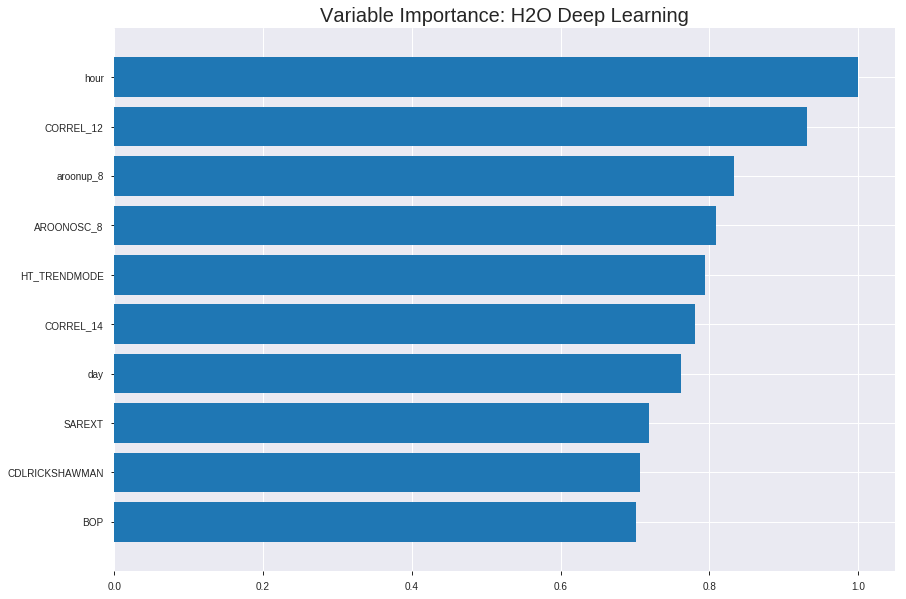

Model Details
H2ODeepLearningEstimator :  Deep Learning
Model Key:  DeepLearning_grid_1_AutoML_20190827_205423_model_2


ModelMetricsBinomial: deeplearning
** Reported on train data. **

MSE: 0.2481628169145484
RMSE: 0.49815942921372913
LogLoss: 0.6896732904157972
Mean Per-Class Error: 0.4392403081613315
AUC: 0.5714876611873275
pr_auc: 0.546966668508571
Gini: 0.14297532237465505
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.32673152365728225: 


0    1     Error    Rate
-----  ---  ----  -------  --------------
0      53   730   0.9323   (730.0/783.0)
1      24   751   0.031    (24.0/775.0)
Total  77   1481  0.484    (754.0/1558.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.326732     0.66578   359
max f2                       0.226476     0.832438  396
max f0point5                 0.410049     0.577428  291
max accuracy                 0.483026     0.560976  199
max precision                0.792137     1         0
max recall                   0.226476     1         396
max specificity              0.792137     1         0
max absolute_mcc             0.410049     0.144624  291
max min_per_class_accuracy   0.475223     0.547097  210
max mean_per_class_accuracy  0.483026     0.56076   199

Gains/Lift Table: Avg response rate: 49.74 %, avg score: 48.10 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain       cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  ---------  -----------------
    1        0.0102696                   0.720949           1.3821    1.3821             0.6875           0.73839   0.6875                      0.73839             0.0141935       0.0141935                  38.2097    38.2097
    2        0.0205392                   0.696895           1.00516   1.19363            0.5              0.709665  0.59375                     0.724027            0.0103226       0.0245161                  0.516129   19.3629
    3        0.0301669                   0.67531            1.47424   1.28318            0.733333         0.682932  0.638298                    0.710912            0.0141935       0.0387097                  47.4237    28.3185
    4        0.0404365                   0.663505           0.628226  1.11685            0.3125           0.669012  0.555556                    0.700271            0.00645161      0.0451613                  -37.1774   11.6846
    5        0.0500642                   0.654442           1.20619   1.13403            0.6              0.659285  0.564103                    0.692389            0.0116129       0.0567742                  20.6194    13.4028
    6        0.100128                    0.614812           1.00516   1.06959            0.5              0.634507  0.532051                    0.663448            0.0503226       0.107097                   0.516129   6.95947
    7        0.150193                    0.579779           1.08248   1.07389            0.538462         0.596248  0.534188                    0.641048            0.0541935       0.16129                    8.24814    7.38903
    8        0.200257                    0.55545            1.13403   1.08892            0.564103         0.566728  0.541667                    0.622468            0.0567742       0.218065                   13.4028    8.89247
    9        0.300385                    0.517301           1.21135   1.12973            0.602564         0.535396  0.561966                    0.593444            0.12129         0.339355                   21.1348    12.9733
    10       0.399872                    0.493623           1.1154    1.12617            0.554839         0.504979  0.560193                    0.571434            0.110968        0.450323                   11.5405    12.6168
    11       0.5                         0.474548           0.992275  1.09935            0.49359          0.484171  0.546855                    0.553959            0.0993548       0.549677                   -0.772539  9.93548
    12       0.600128                    0.457192           1.03093   1.08794            0.512821         0.466351  0.541176                    0.539342            0.103226        0.652903                   3.09347    8.79393
    13       0.699615                    0.43507            0.920857  1.06418            0.458065         0.446184  0.529358                    0.526095            0.0916129       0.744516                   -7.91426   6.41799
    14       0.799743                    0.407005           1.09537   1.06808            0.544872         0.42127   0.5313                      0.512971            0.109677        0.854194                   9.53681    6.80847
    15       0.899872                    0.367181           0.760314  1.03384            0.378205         0.389031  0.514265                    0.49918             0.076129        0.930323                   -23.9686   3.38392
    16       1                           0.203504           0.695881  1                  0.346154         0.318012  0.497433                    



ModelMetricsBinomial: deeplearning
** Reported on validation data. **

MSE: 0.2795140027349083
RMSE: 0.5286908385199315
LogLoss: 0.765438601495948
Mean Per-Class Error: 0.46857310367135696
AUC: 0.501435387352418
pr_auc: 0.5207665856774136
Gini: 0.0028707747048359877
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.08364326434971875: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      2    214  0.9907   (214.0/216.0)
1      0    229  0        (0.0/229.0)
Total  2    443  0.4809   (214.0/445.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value      idx
---------------------------  -----------  ---------  -----
max f1                       0.0836433    0.681548   397
max f2                       0.0836433    0.842531   397
max f0point5                 0.113642     0.572943   392
max accuracy                 0.337661     0.537079   271
max precision                0.731987     1          0
max recall                   0.0836433    1          397
max specificity              0.731987     1          0
max absolute_mcc             0.65362      0.0762742  15
max min_per_class_accuracy   0.434933     0.5        198
max mean_per_class_accuracy  0.337661     0.531427   271

Gains/Lift Table: Avg response rate: 51.46 %, avg score: 42.44 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.011236                    0.696455           1.16594   1.16594            0.6              0.711946  0.6                         0.711946            0.0131004       0.0131004                  16.5939   16.5939
    2        0.0202247                   0.665989           1.94323   1.5114             1                0.684191  0.777778                    0.69961             0.0174672       0.0305677                  94.3231   51.1402
    3        0.0314607                   0.659165           0.777293  1.24922            0.4              0.661381  0.642857                    0.685957            0.00873362      0.0393013                  -22.2707  24.922
    4        0.0404494                   0.652548           1.45742   1.29549            0.75             0.655664  0.666667                    0.679225            0.0131004       0.0524017                  45.7424   29.5488
    5        0.0516854                   0.649033           0.777293  1.18284            0.4              0.651646  0.608696                    0.67323             0.00873362      0.0611354                  -22.2707  18.2837
    6        0.101124                    0.615448           1.05994   1.12276            0.545455         0.629575  0.577778                    0.651887            0.0524017       0.113537                   5.99444   12.2756
    7        0.150562                    0.586299           0.794958  1.01512            0.409091         0.599292  0.522388                    0.634617            0.0393013       0.152838                   -20.5042  1.51209
    8        0.2                         0.570298           1.05994   1.0262             0.545455         0.5785    0.52809                     0.620746            0.0524017       0.20524                    5.99444   2.62009
    9        0.301124                    0.524893           0.863658  0.971616           0.444444         0.546521  0.5                         0.595819            0.0873362       0.292576                   -13.6342  -2.83843
    10       0.4                         0.478095           1.01578   0.982533           0.522727         0.500804  0.505618                    0.572332            0.100437        0.393013                   1.57801   -1.74672
    11       0.501124                    0.434933           1.07957   1.00211            0.555556         0.457246  0.515695                    0.549109            0.10917         0.502183                   7.9573    0.211487
    12       0.6                         0.383414           1.01578   1.00437            0.522727         0.40849   0.516854                    0.525935            0.100437        0.60262                    1.57801   0.436681
    13       0.698876                    0.332139           1.28077   1.04347            0.659091         0.360816  0.536977                    0.502574            0.126638        0.729258                   28.0766   4.34715
    14       0.8                         0.287043           0.604561  0.987991           0.311111         0.311976  0.508427                    0.478482            0.0611354       0.790393                   -39.5439  -1.20087
    15       0.898876                    0.224581           1.01578   0.991048           0.522727         0.261581  0.51                        0.454623            0.100437        0.89083                    1.57801   -0.895197
    16       1                           0.0542832          1.07957   1                  0.555556         0.155843  0.514607                    0.424409   


Scoring History: 


timestamp            duration          training_speed    epochs    iterations    samples    training_rmse    training_logloss    training_r2    training_auc    training_pr_auc    training_lift    training_classification_error    validation_rmse    validation_logloss    validation_r2    validation_auc    validation_pr_auc    validation_lift    validation_classification_error
--  -------------------  ----------------  ----------------  --------  ------------  ---------  ---------------  ------------------  -------------  --------------  -----------------  ---------------  -------------------------------  -----------------  --------------------  ---------------  ----------------  -------------------  -----------------  ---------------------------------
    2019-08-27 20:55:57  0.000 sec                           0         0             0          nan              nan                 nan            nan             nan                nan              nan                              nan                nan                   nan              nan               nan                  nan                nan
    2019-08-27 20:55:59  1 min 33.172 sec  393 obs/sec       0.546855  1             852        0.676512         5.17336             -0.830722      0.518313        0.395553           0.753871         0.502567                         0.694128           5.87042               -0.928902        0.485454          0.41105              1.16594            0.480899
    2019-08-27 20:56:11  1 min 45.026 sec  395 obs/sec       3.29718   6             5137       0.546443         0.921128            -0.194431      0.55669         0.543731           1.63339          0.480103                         0.681908           2.34949               -0.861581        0.478479          0.501405             0.777293           0.485393
    2019-08-27 20:56:22  1 min 56.440 sec  405 obs/sec       6.09564   11            9497       0.532429         0.783184            -0.133953      0.52711         0.518393           1.25645          0.491656                         0.613995           1.11306               -0.509246        0.516446          0.54246              1.55459            0.480899
    2019-08-27 20:56:33  2 min  7.181 sec  416 obs/sec       8.85944   16            13803      0.503322         0.714461            -0.0133598     0.568259        0.546239           1.00516          0.496149                         0.583094           1.07756               -0.361156        0.481866          0.525543             0.777293           0.485393
    2019-08-27 20:56:43  2 min 17.458 sec  425 obs/sec       11.5905   21            18058      0.509199         0.71302             -0.0371631     0.532838        0.509633           0.879516         0.495507                         0.532192           0.773763              -0.133882        0.537462          0.553197             1.16594            0.47191
    2019-08-27 20:56:53  2 min 27.618 sec  434 obs/sec       14.3691   26            22387      0.513368         0.728624            -0.0542158     0.559974        0.542137           1.3821           0.498074                         0.564296           0.889995              -0.274809        0.497392          0.507493             0.777293           0.480899
    2019-08-27 20:57:05  2 min 39.151 sec  442 obs/sec       17.6367   32            27478      0.498159         0.689673            0.00732256     0.571488        0.546967           1.3821           0.483954                         0.528691           0.765439              -0.119011        0.501435          0.520767             1.16594            0.480899
    2019-08-27 20:57:16  2 min 50.663 sec  449 obs/sec       20.9583   38            32653      0.531273         0.823011            -0.129036      0.564985        0.523085           0.879516         0.471759                         0.662742           1.72178               -0.758406        0.509007          0.530702             1.16594            0.478652
    2019-08-27 20:57:28 

Variable Importances: 


variable                  relative_importance    scaled_importance    percentage
------------------------  ---------------------  -------------------  ---------------------
hour                      1.0                    1.0                  0.002772635339066281
CORREL_12                 0.9312421083450317     0.9312421083450317   0.0025819947788240255
aroonup_8                 0.8333063721656799     0.8333063721656799   0.0023104546957356826
AROONOSC_8                0.8087195158004761     0.8087195158004761   0.0022422843089009714
HT_TRENDMODE              0.7943726181983948     0.7943726181983948   0.002202505593603476
---                       ---                    ---                  ---
BBANDS_middleband_24_0_5  0.28274449706077576    0.28274449706077576  0.000783947384477229
BBANDS_lowerband_20_3_2   0.281469464302063      0.281469464302063    0.0007804121835919549
BBANDS_upperband_14_4_2   0.2809915840625763     0.2809915840625763   0.0007790871959521126
T3_8_0                    0.27863168716430664    0.27863168716430664  0.0007725440624154172
BBANDS_middleband_12_7_2  0.2755189836025238     0.2755189836025238   0.0007639136705199806


See the whole table with table.as_data_frame()


('accuracy', 0.57847533632287)

('F1', 0.6706586826347305)

('auc', 0.5838159588159588)

('logloss', 0.7036121666545526)

('mean_per_class_error', 0.42197554697554696)

('rmse', 0.5027915837460373)

('mse', 0.25279937668584845)

deeplearning prediction progress: |███████████████████████████████████████| 100%


/usr/local/lib/python3.6/dist-packages/pandas/plotting/_matplotlib/converter.py:102: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


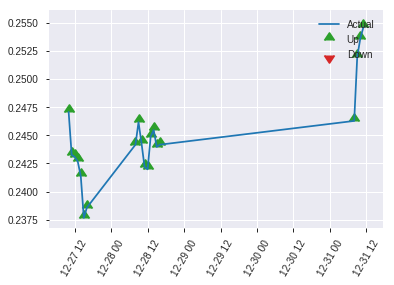


ModelMetricsBinomial: deeplearning
** Reported on test data. **

MSE: 0.25279937668584845
RMSE: 0.5027915837460373
LogLoss: 0.7036121666545526
Mean Per-Class Error: 0.42197554697554696
AUC: 0.5838159588159588
pr_auc: 0.6104119679645891
Gini: 0.16763191763191765
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.14543123950658043: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      1    110  0.991    (110.0/111.0)
1      0    112  0        (0.0/112.0)
Total  1    222  0.4933   (110.0/223.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.145431     0.670659  221
max f2                       0.145431     0.835821  221
max f0point5                 0.411202     0.58642   133
max accuracy                 0.411202     0.578475  133
max precision                0.698975     1         0
max recall                   0.145431     1         221
max specificity              0.698975     1         0
max absolute_mcc             0.575708     0.218391  16
max min_per_class_accuracy   0.43852      0.558559  111
max mean_per_class_accuracy  0.411202     0.578024  133

Gains/Lift Table: Avg response rate: 50.22 %, avg score: 42.99 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain       cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  ---------  -----------------
    1        0.0134529                   0.651783           1.99107   1.99107            1                0.67295   1                           0.67295             0.0267857       0.0267857                  99.1071    99.1071
    2        0.0224215                   0.626664           1.99107   1.99107            1                0.628125  1                           0.65502             0.0178571       0.0446429                  99.1071    99.1071
    3        0.0313901                   0.617023           0.995536  1.70663            0.5              0.622249  0.857143                    0.645657            0.00892857      0.0535714                  -0.446429  70.6633
    4        0.0403587                   0.603992           1.99107   1.76984            1                0.61344   0.888889                    0.638498            0.0178571       0.0714286                  99.1071    76.9841
    5        0.0538117                   0.594312           1.32738   1.65923            0.666667         0.599741  0.833333                    0.628809            0.0178571       0.0892857                  32.7381    65.9226
    6        0.103139                    0.567059           1.26705   1.47166            0.636364         0.576912  0.73913                     0.603988            0.0625          0.151786                   26.7045    47.1661
    7        0.152466                    0.550383           0.905032  1.28834            0.454545         0.558343  0.647059                    0.589221            0.0446429       0.196429                   -9.49675   28.834
    8        0.201794                    0.533008           1.44805   1.32738            0.727273         0.542017  0.666667                    0.577682            0.0714286       0.267857                   44.8052    32.7381
    9        0.300448                    0.500185           0.905032  1.1887             0.454545         0.517487  0.597015                    0.557916            0.0892857       0.357143                   -9.49675   18.8699
    10       0.399103                    0.462873           0.905032  1.11858            0.454545         0.482421  0.561798                    0.539255            0.0892857       0.446429                   -9.49675   11.8579
    11       0.502242                    0.43852            1.12539   1.11998            0.565217         0.451427  0.5625                      0.521219            0.116071        0.5625                     12.5388    11.9978
    12       0.600897                    0.410691           1.17654   1.12926            0.590909         0.425563  0.567164                    0.505514            0.116071        0.678571                   17.6542    12.9264
    13       0.699552                    0.377059           0.633523  1.05935            0.318182         0.393849  0.532051                    0.489766            0.0625          0.741071                   -36.6477   5.93521
    14       0.798206                    0.328663           1.08604   1.06265            0.545455         0.351335  0.533708                    0.472657            0.107143        0.848214                   8.6039     6.26505
    15       0.896861                    0.276843           0.543019  1.00549            0.272727         0.305089  0.505                       0.454224            0.0535714       0.901786                   -45.6981   0.549107
    16       1                           0.117149           0.952252  1                  0.478261         0.218329  0.502242                    

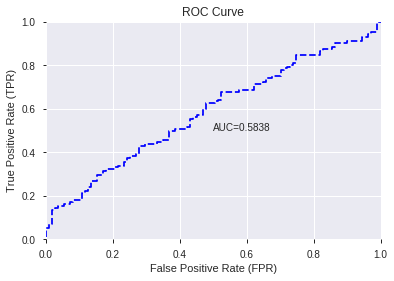

This function is available for GLM models only


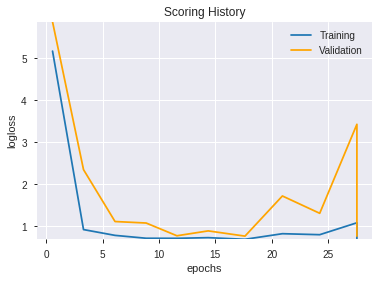

--2019-08-27 21:22:14--  https://h2o-release.s3.amazonaws.com/h2o/rel-yates/5/h2o-3.24.0.5.zip
Resolving h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)... 52.216.100.203
Connecting to h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)|52.216.100.203|:443... connected.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.

Archive:  h2o-3.24.0.5.zip
ERROR: Unknown MOJO type


[{'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Models/DeepLearning_grid_1_AutoML_20190827_205423_model_2',
   '__meta': {'schema_name': 'ModelKeyV3',
    'schema_type': 'Key<Model>',
    'schema_version': 3},
   'name': 'DeepLearning_grid_1_AutoML_20190827_205423_model_2',
   'type': 'Key<Model>'},
  'default_value': None,
  'gridable': False,
  'help': 'Destination id for this model; auto-generated if not specified.',
  'is_member_of_frames': [],
  'is_mutually_exclusive_with': [],
  'label': 'model_id',
  'level': 'critical',
  'name': 'model_id',
  'required': False,
  'type': 'Key<Model>',
  'values': []},
 {'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Frames/automl_training_py_2_sid_a8e7',
   '__meta': {'schema_name': 'FrameKeyV3',
    'schema_type': 'Key<Frame>',
    'schema_version': 3},
   'name': 'automl

In [11]:
# DeepLearning
features_list = model_train(feature_name='All',model_algo="DeepLearning")

AutoML progress: |████████████████████████████████████████████████████████| 100%


model_id       auc   logloss  mean_per_class_error      rmse       mse
0  DeepLearning_grid_1_AutoML_20190827_212221_model_8  0.586470  0.693645              0.495495  0.500249  0.250249
1               DeepLearning_1_AutoML_20190827_212221  0.567165  0.725843              0.490991  0.512264  0.262414
2  DeepLearning_grid_1_AutoML_20190827_212221_model_2  0.566522  0.752219              0.450370  0.522022  0.272507
3  DeepLearning_grid_1_AutoML_20190827_212221_model_9  0.557111  0.688416              0.440999  0.497616  0.247622
4  DeepLearning_grid_1_AutoML_20190827_212221_model_6  0.556628  0.692540              0.459258  0.499201  0.249202
5  DeepLearning_grid_1_AutoML_20190827_212221_model_5  0.553974  0.732254              0.472772  0.513728  0.263917
6  DeepLearning_grid_1_AutoML_20190827_212221_model_1  0.533140  0.955649              0.477397  0.574546  0.330103
7  DeepLearning_grid_1_AutoML_20190827_212221_model_3  0.522603  0.778750              0.477437  0.530710  0.281653
8  DeepLearning_grid_1_AutoML_20190827_212221_model_7  0.516651  0.715797              0.486486  0.510047  0.260148
9  DeepLearning_grid_1_AutoML_20190827_212221_model_4  0.511663  0.977449              0.500000  0.576985  0.332911

variable  relative_importance  scaled_importance  percentage
0                 Volume             1.000000           1.000000    0.023201
1                BETA_20             0.989447           0.989447    0.022956
2                   hour             0.940289           0.940289    0.021815
3           HT_TRENDMODE             0.939601           0.939601    0.021799
4               CORREL_8             0.928257           0.928257    0.021536
5                    day             0.924218           0.924218    0.021442
6         is_month_start             0.913899           0.913899    0.021203
7                 ADX_24             0.901711           0.901711    0.020920
8              dayofweek             0.898868           0.898868    0.020854
9             aroonup_30             0.891995           0.891995    0.020695
10        STOCHRSI_fastk             0.891903           0.891903    0.020693
11               BETA_14             0.888590           0.888590    0.020616
12     CDLDARKCLOUDCOVER             0.887517           0.887517    0.020591
13            aroonup_20             0.878500           0.878500    0.020382
14             CORREL_14             0.876937           0.876937    0.020346
15            aroonup_24             0.876643           0.876643    0.020339
16                SAREXT             0.875114           0.875114    0.020303
17                   BOP             0.874462           0.874462    0.020288
18                 ADX_8             0.874047           0.874047    0.020278
19         days_in_month             0.869717           0.869717    0.020178
20  HT_PHASOR_quadrature             0.864295           0.864295    0.020052
21          STOCHF_fastk             0.863631           0.863631    0.020037
22             CORREL_12             0.858560           0.858560    0.019919
23             aroonup_8             0.857738           0.857738    0.019900
24    CDLMORNINGDOJISTAR             0.853999           0.853999    0.019813
25            aroonup_12             0.852644           0.852644    0.019782
26        CDLRICKSHAWMAN             0.849700           0.849700    0.019714
27                 DX_12             0.849398           0.849398    0.019707
28   CDLGAPSIDESIDEWHITE             0.849180           0.849180    0.019702
29    CDLEVENINGDOJISTAR             0.848543           0.848543    0.019687
30           HT_DCPERIOD             0.848535           0.848535    0.019687
31     CDLLONGLEGGEDDOJI             0.846083           0.846083    0.019630
32           aroondown_8             0.841033           0.841033    0.019513
33               BETA_12             0.839480           0.839480    0.019476
34               weekday             0.837403           0.837403    0.019428
35                  DX_8             0.834308           0.834308    0.019357
36               CDLDOJI             0.833088           0.833088    0.019328
37            AROONOSC_8             0.830281           0.830281    0.019263
38          aroondown_14             0.830196           0.830196    0.019261
39     CDLSTALLEDPATTERN             0.829586           0.829586    0.019247
40          weekday_name             0.826600           0.826600    0.019178
41        STOCHRSI_fastd             0.825915           0.825915    0.019162
42          aroondown_20             0.819601           0.819601    0.019015
43            aroonup_14             0.818038           0.818038    0.018979
44          aroondown_24             0.816568           0.816568    0.018945
45          aroondown_30             0.810510           0.810510    0.018804
46         CDLHANGINGMAN             0.809196           0.809196    0.018774
47           STOCH_slowd             0.799001           0.799001    0.018537
48          aroondown_12             0.791989           0.791989    0.018375
49        CDLMATCHINGLOW             0.745394           0.745394    0.017294

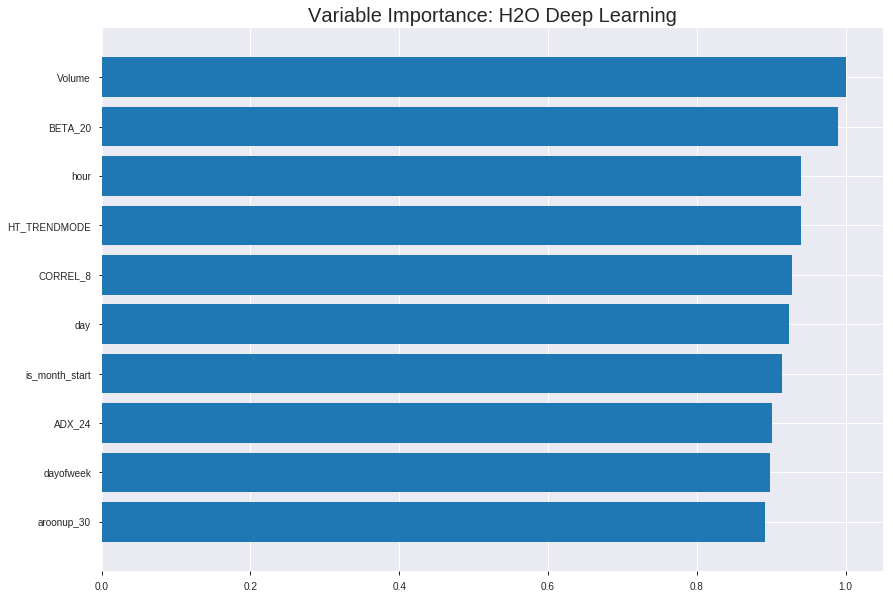

Model Details
H2ODeepLearningEstimator :  Deep Learning
Model Key:  DeepLearning_grid_1_AutoML_20190827_212221_model_8


ModelMetricsBinomial: deeplearning
** Reported on train data. **

MSE: 0.24940462371876423
RMSE: 0.49940426882312916
LogLoss: 0.6919519214250679
Mean Per-Class Error: 0.457273513780744
AUC: 0.550952086680674
pr_auc: 0.5456051339390022
Gini: 0.10190417336134794
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.4833958103468421: 


0    1     Error    Rate
-----  ---  ----  -------  --------------
0      36   747   0.954    (747.0/783.0)
1      12   763   0.0155   (12.0/775.0)
Total  48   1510  0.4872   (759.0/1558.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.483396     0.667834  352
max f2                       0.399941     0.832081  398
max f0point5                 0.519955     0.565713  262
max accuracy                 0.525257     0.544288  105
max precision                0.535069     0.666667  5
max recall                   0.399941     1         398
max specificity              0.539595     0.998723  0
max absolute_mcc             0.525257     0.10768   105
max min_per_class_accuracy   0.522984     0.524904  172
max mean_per_class_accuracy  0.525257     0.542726  105

Gains/Lift Table: Avg response rate: 49.74 %, avg score: 52.03 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0102696                   0.533452           1.13081   1.13081            0.5625           0.534944  0.5625                      0.534944            0.0116129       0.0116129                  13.0806   13.0806
    2        0.0205392                   0.531441           1.3821    1.25645            0.6875           0.53211   0.625                       0.533527            0.0141935       0.0258065                  38.2097   25.6452
    3        0.0301669                   0.530473           1.20619   1.24041            0.6              0.530954  0.617021                    0.532706            0.0116129       0.0374194                  20.6194   24.0412
    4        0.0404365                   0.529726           1.00516   1.18067            0.5              0.530038  0.587302                    0.532028            0.0103226       0.0477419                  0.516129  18.0666
    5        0.0500642                   0.528806           1.34022   1.21135            0.666667         0.529318  0.602564                    0.531507            0.0129032       0.0606452                  34.0215   21.1348
    6        0.100128                    0.526579           1.31444   1.26289            0.653846         0.527501  0.628205                    0.529504            0.0658065       0.126452                   31.4442   26.2895
    7        0.150193                    0.525711           1.23712   1.2543             0.615385         0.526091  0.623932                    0.528366            0.0619355       0.188387                   23.7122   25.4304
    8        0.200257                    0.525206           1.08248   1.21135            0.538462         0.525441  0.602564                    0.527635            0.0541935       0.242581                   8.24814   21.1348
    9        0.300385                    0.524453           0.914955  1.11255            0.455128         0.524815  0.553419                    0.526695            0.0916129       0.334194                   -8.50455  11.255
    10       0.399872                    0.523766           1.06353   1.10035            0.529032         0.524099  0.547352                    0.526049            0.105806        0.44                       6.35255   10.0353
    11       0.5                         0.522968           0.850521  1.05032            0.423077         0.52339   0.522465                    0.525516            0.0851613       0.525161                   -14.9479  5.03226
    12       0.600128                    0.52215            0.914955  1.02774            0.455128         0.522552  0.51123                     0.525022            0.0916129       0.616774                   -8.50455  2.77371
    13       0.699615                    0.521413           1.06353   1.03283            0.529032         0.521753  0.513761                    0.524557            0.105806        0.722581                   6.35255   3.28263
    14       0.799743                    0.520821           1.06959   1.03743            0.532051         0.521123  0.516051                    0.524127            0.107097        0.829677                   6.95947   3.74297
    15       0.902439                    0.519955           1.01773   1.03519            0.50625          0.520387  0.514936                    0.523702            0.104516        0.934194                   1.77258   3.51874
    16       1                           0.385107           0.674516  1                  0.335526         0.488757  0.497433                    0.520292          



ModelMetricsBinomial: deeplearning
** Reported on validation data. **

MSE: 0.24948034770519276
RMSE: 0.49948007738566785
LogLoss: 0.6921040654795608
Mean Per-Class Error: 0.47013989972505255
AUC: 0.5008895358240336
pr_auc: 0.5311253406559969
Gini: 0.001779071648067232
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.4531611635003027: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      3    213  0.9861   (213.0/216.0)
1      1    228  0.0044   (1.0/229.0)
Total  4    441  0.4809   (214.0/445.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value      idx
---------------------------  -----------  ---------  -----
max f1                       0.453161     0.680597   395
max f2                       0.444433     0.841912   398
max f0point5                 0.481321     0.573687   387
max accuracy                 0.505449     0.525843   360
max precision                0.53354      1          0
max recall                   0.444433     1          398
max specificity              0.53354      1          0
max absolute_mcc             0.527194     0.0925485  23
max min_per_class_accuracy   0.521433     0.49345    206
max mean_per_class_accuracy  0.525526     0.52986    57

Gains/Lift Table: Avg response rate: 51.46 %, avg score: 51.89 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.011236                    0.531591           0.777293  0.777293           0.4              0.532876  0.4                         0.532876            0.00873362      0.00873362                 -22.2707  -22.2707
    2        0.0202247                   0.530323           1.94323   1.29549            1                0.5307    0.666667                    0.531909            0.0174672       0.0262009                  94.3231   29.5488
    3        0.0314607                   0.529136           1.55459   1.38802            0.8              0.529475  0.714286                    0.531039            0.0174672       0.0436681                  55.4585   38.8022
    4        0.0404494                   0.528543           0.971616  1.29549            0.5              0.528716  0.666667                    0.530523            0.00873362      0.0524017                  -2.83843  29.5488
    5        0.0516854                   0.527501           1.55459   1.35181            0.8              0.52793   0.695652                    0.529959            0.0174672       0.069869                   55.4585   35.1813
    6        0.101124                    0.525979           0.971616  1.16594            0.5              0.5266    0.6                         0.528317            0.0480349       0.117904                   -2.83843  16.5939
    7        0.150562                    0.525297           1.05994   1.13113            0.545455         0.525612  0.58209                     0.527429            0.0524017       0.170306                   5.99444   13.1135
    8        0.2                         0.524744           0.883287  1.06987            0.454545         0.524974  0.550562                    0.526822            0.0436681       0.213974                   -11.6713  6.9869
    9        0.301124                    0.523743           0.690927  0.942612           0.355556         0.524257  0.485075                    0.525961            0.069869        0.283843                   -30.9073  -5.73877
    10       0.4                         0.522279           1.01578   0.960699           0.522727         0.523032  0.494382                    0.525237            0.100437        0.384279                   1.57801   -3.93013
    11       0.501124                    0.521402           1.07957   0.984687           0.555556         0.521864  0.506726                    0.524556            0.10917         0.49345                    7.9573    -1.53132
    12       0.6                         0.520926           1.05994   0.997089           0.545455         0.521114  0.513109                    0.523989            0.104803        0.598253                   5.99444   -0.291121
    13       0.698876                    0.520484           1.14827   1.01848            0.590909         0.520677  0.524116                    0.52352             0.113537        0.71179                    14.8273   1.84782
    14       0.824719                    0.519955           0.936915  1.00603            0.482143         0.520166  0.517711                    0.523008            0.117904        0.829694                   -6.30848  0.603263
    15       0.898876                    0.506856           1.05994   1.01048            0.545455         0.51413   0.52                        0.522276            0.0786026       0.908297                   5.99444   1.04803
    16       1                           0.411669           0.906841  1                  0.466667         0.48893   0.514607                    0.518904   


Scoring History: 


timestamp            duration          training_speed    epochs    iterations    samples    training_rmse    training_logloss    training_r2    training_auc    training_pr_auc    training_lift    training_classification_error    validation_rmse    validation_logloss    validation_r2    validation_auc    validation_pr_auc    validation_lift    validation_classification_error
--  -------------------  ----------------  ----------------  --------  ------------  ---------  ---------------  ------------------  -------------  --------------  -----------------  ---------------  -------------------------------  -----------------  --------------------  ---------------  ----------------  -------------------  -----------------  ---------------------------------
    2019-08-27 21:27:01  0.000 sec                           0         0             0          nan              nan                 nan            nan             nan                nan              nan                              nan                nan                   nan              nan               nan                  nan                nan
    2019-08-27 21:27:02  55.283 sec        606 obs/sec       0.57638   1             898        0.528276         0.759286            -0.116329      0.500331        0.490914           1.00516          0.501926                         0.518825           0.735782              -0.0776372       0.54849           0.55171              0.777293           0.47191
    2019-08-27 21:27:12  1 min  4.471 sec  950 obs/sec       5.86521   10            9138       0.499404         0.691952            0.0023552      0.550952        0.545605           1.13081          0.487163                         0.49948            0.692104              0.00122623       0.50089           0.531125             0.777293           0.480899
    2019-08-27 21:27:23  1 min 15.308 sec  1210 obs/sec      15.2073   26            23693      0.49625          0.685377            0.0149165      0.6034          0.59615            1.3821           0.472401                         0.49985            0.692947              -0.000254954     0.498433          0.482703             0.777293           0.451685
    2019-08-27 21:27:32  1 min 24.687 sec  1301 obs/sec      23.4499   40            36535      0.48605          0.662033            0.0549957      0.613644        0.590547           1.50774          0.44801                          0.506075           0.718334              -0.0253213       0.48695           0.499224             1.16594            0.469663
    2019-08-27 21:27:41  1 min 33.617 sec  1362 obs/sec      31.5918   54            49220      0.485892         0.661218            0.0556115      0.58413         0.58359            1.05335          0.412709                         0.512721           0.728154              -0.0524309       0.499909          0.33574              1.02344            0.483146
    2019-08-27 21:27:50  1 min 42.365 sec  1405 obs/sec      39.7086   68            61866      0.473786         0.631591            0.102083       0.655927        0.683537           1.88468          0.389602                         0.516104           0.76537               -0.0663615       0.488042          0.465531             0.388646           0.480899
    2019-08-27 21:27:51  1 min 43.463 sec  1403 obs/sec      39.7086   68            61866      0.499404         0.691952            0.0023552      0.550952        0.545605           1.13081          0.487163                         0.49948            0.692104              0.00122623       0.50089           0.531125             0.777293           0.480899

Variable Importances: 


variable        relative_importance    scaled_importance    percentage
--------------  ---------------------  -------------------  --------------------
Volume          1.0                    1.0                  0.023200667254602937
BETA_20         0.989446759223938      0.989446759223938    0.022955825026899815
hour            0.940288782119751      0.940288782119751    0.021815327157196182
HT_TRENDMODE    0.9396008253097534     0.9396008253097534   0.021799366100161893
CORREL_8        0.9282569885253906     0.9282569885253906   0.021536181517537365
---             ---                    ---                  ---
aroondown_30    0.8105102181434631     0.8105102181434631   0.01880437787760213
CDLHANGINGMAN   0.8091956973075867     0.8091956973075867   0.018773880117089716
STOCH_slowd     0.799001157283783      0.799001157283783    0.018537359986183714
aroondown_12    0.7919890284538269     0.7919890284538269   0.018374673918453495
CDLMATCHINGLOW  0.7453941702842712     0.7453941702842712   0.01729364211828622


See the whole table with table.as_data_frame()


('accuracy', 0.5874439461883408)

('F1', 0.6706586826347305)

('auc', 0.586470398970399)

('logloss', 0.6936446317903701)

('mean_per_class_error', 0.41175997425997424)

('rmse', 0.5002493725523371)

('mse', 0.250249434739007)

deeplearning prediction progress: |███████████████████████████████████████| 100%


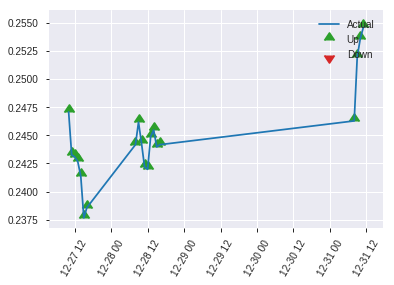


ModelMetricsBinomial: deeplearning
** Reported on test data. **

MSE: 0.250249434739007
RMSE: 0.5002493725523371
LogLoss: 0.6936446317903701
Mean Per-Class Error: 0.41175997425997424
AUC: 0.586470398970399
pr_auc: 0.5760119636961404
Gini: 0.17294079794079797
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.4835520770173736: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      1    110  0.991    (110.0/111.0)
1      0    112  0        (0.0/112.0)
Total  1    222  0.4933   (110.0/223.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.483552     0.670659  217
max f2                       0.483552     0.835821  217
max f0point5                 0.523041     0.587687  105
max accuracy                 0.523832     0.587444  71
max precision                0.534365     1         0
max recall                   0.483552     1         217
max specificity              0.534365     1         0
max absolute_mcc             0.523832     0.188717  71
max min_per_class_accuracy   0.522836     0.576577  111
max mean_per_class_accuracy  0.523832     0.58824   71

Gains/Lift Table: Avg response rate: 50.22 %, avg score: 52.15 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain       cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  ---------  -----------------
    1        0.0134529                   0.53289            1.32738   1.32738            0.666667         0.533834  0.666667                    0.533834            0.0178571       0.0178571                  32.7381    32.7381
    2        0.0224215                   0.529666           0.995536  1.19464            0.5              0.531092  0.6                         0.532737            0.00892857      0.0267857                  -0.446429  19.4643
    3        0.0313901                   0.529284           0.995536  1.13776            0.5              0.529399  0.571429                    0.531784            0.00892857      0.0357143                  -0.446429  13.7755
    4        0.0403587                   0.528575           0         0.884921           0                0.52892   0.444444                    0.531147            0               0.0357143                  -100       -11.5079
    5        0.0538117                   0.527351           1.99107   1.16146            1                0.528127  0.583333                    0.530392            0.0267857       0.0625                     99.1071    16.1458
    6        0.103139                    0.525771           1.26705   1.21196            0.636364         0.52622   0.608696                    0.528397            0.0625          0.125                      26.7045    21.1957
    7        0.152466                    0.525274           1.44805   1.28834            0.727273         0.525461  0.647059                    0.527447            0.0714286       0.196429                   44.8052    28.834
    8        0.201794                    0.524733           1.26705   1.28313            0.636364         0.525032  0.644444                    0.526857            0.0625          0.258929                   26.7045    28.3135
    9        0.300448                    0.523958           1.08604   1.21842            0.545455         0.524272  0.61194                     0.526008            0.107143        0.366071                   8.6039     21.8417
    10       0.399103                    0.523296           1.08604   1.18569            0.545455         0.523617  0.595506                    0.525417            0.107143        0.473214                   8.6039     18.5694
    11       0.502242                    0.522836           1.03882   1.15553            0.521739         0.523118  0.580357                    0.524945            0.107143        0.580357                   3.88199    15.5533
    12       0.600897                    0.522263           0.814529  1.09955            0.409091         0.522495  0.552239                    0.524543            0.0803571       0.660714                   -18.5471   9.95469
    13       0.699552                    0.52163            0.724026  1.04659            0.363636         0.521942  0.525641                    0.524176            0.0714286       0.732143                   -27.5974   4.65888
    14       0.798206                    0.520923           0.905032  1.02909            0.454545         0.521227  0.516854                    0.523811            0.0892857       0.821429                   -9.49675   2.90931
    15       0.910314                    0.519955           0.876071  1.01025            0.44             0.520321  0.507389                    0.523382            0.0982143       0.919643                   -12.3929   1.02481
    16       1                           0.454629           0.895982  1                  0.45             0.502183  0.502242                    

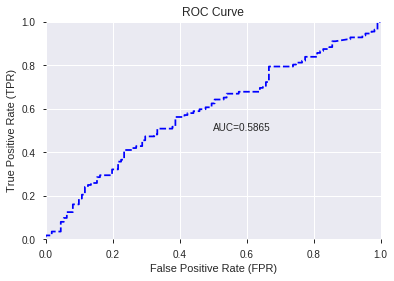

This function is available for GLM models only


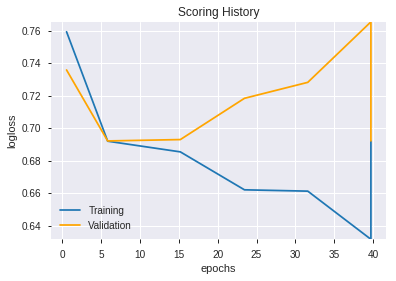

--2019-08-27 21:29:05--  https://h2o-release.s3.amazonaws.com/h2o/rel-yates/5/h2o-3.24.0.5.zip
Resolving h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)... 52.216.237.155
Connecting to h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)|52.216.237.155|:443... connected.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.

Archive:  h2o-3.24.0.5.zip
ERROR: Unknown MOJO type


[{'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Models/DeepLearning_grid_1_AutoML_20190827_212221_model_8',
   '__meta': {'schema_name': 'ModelKeyV3',
    'schema_type': 'Key<Model>',
    'schema_version': 3},
   'name': 'DeepLearning_grid_1_AutoML_20190827_212221_model_8',
   'type': 'Key<Model>'},
  'default_value': None,
  'gridable': False,
  'help': 'Destination id for this model; auto-generated if not specified.',
  'is_member_of_frames': [],
  'is_mutually_exclusive_with': [],
  'label': 'model_id',
  'level': 'critical',
  'name': 'model_id',
  'required': False,
  'type': 'Key<Model>',
  'values': []},
 {'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Frames/automl_training_py_10_sid_a8e7',
   '__meta': {'schema_name': 'FrameKeyV3',
    'schema_type': 'Key<Frame>',
    'schema_version': 3},
   'name': 'autom

['Volume',
 'BETA_20',
 'hour',
 'HT_TRENDMODE',
 'CORREL_8',
 'day',
 'is_month_start',
 'ADX_24',
 'dayofweek',
 'aroonup_30',
 'STOCHRSI_fastk',
 'BETA_14',
 'CDLDARKCLOUDCOVER',
 'aroonup_20',
 'CORREL_14',
 'aroonup_24',
 'SAREXT',
 'BOP',
 'ADX_8',
 'days_in_month',
 'HT_PHASOR_quadrature',
 'STOCHF_fastk',
 'CORREL_12',
 'aroonup_8',
 'CDLMORNINGDOJISTAR',
 'aroonup_12',
 'CDLRICKSHAWMAN',
 'DX_12',
 'CDLGAPSIDESIDEWHITE',
 'CDLEVENINGDOJISTAR',
 'HT_DCPERIOD',
 'CDLLONGLEGGEDDOJI',
 'aroondown_8',
 'BETA_12',
 'weekday',
 'DX_8',
 'CDLDOJI',
 'AROONOSC_8',
 'aroondown_14',
 'CDLSTALLEDPATTERN',
 'weekday_name',
 'STOCHRSI_fastd',
 'aroondown_20',
 'aroonup_14',
 'aroondown_24',
 'aroondown_30',
 'CDLHANGINGMAN',
 'STOCH_slowd',
 'aroondown_12',
 'CDLMATCHINGLOW']

In [12]:
# DeepLearning with top DeepLearning features
model_train(feature_name='DLF',model_algo="DeepLearning",features_list = features_list[:model_selected_features])

AutoML progress: |████████████████████████████████████████████████████████| 100%


model_id      auc   logloss  mean_per_class_error      rmse       mse
0  GLM_grid_1_AutoML_20190827_212911_model_1  0.53314  0.692036              0.486486  0.499445  0.249445

variable  relative_importance  scaled_importance  percentage
0         is_month_start             0.022557           1.000000    0.075524
1                   hour             0.019699           0.873296    0.065955
2          CDLHANGINGMAN             0.015166           0.672359    0.050779
3    CDLGAPSIDESIDEWHITE             0.013241           0.587023    0.044334
4                 Volume             0.012071           0.535136    0.040416
5                 ADX_24             0.011937           0.529191    0.039967
6           HT_TRENDMODE             0.011613           0.514842    0.038883
7     CDLMORNINGDOJISTAR             0.010839           0.480507    0.036290
8         CDLRICKSHAWMAN             0.010655           0.472349    0.035674
9      CDLDARKCLOUDCOVER             0.008487           0.376240    0.028415
10     CDLLONGLEGGEDDOJI             0.008469           0.375454    0.028356
11               CDLDOJI             0.008465           0.375269    0.028342
12                 DX_12             0.008363           0.370757    0.028001
13                 ADX_8             0.008178           0.362555    0.027382
14                SAREXT             0.008061           0.357368    0.026990
15                   BOP             0.008054           0.357066    0.026967
16               BETA_20             0.007748           0.343499    0.025942
17               BETA_14             0.007730           0.342688    0.025881
18             CORREL_14             0.007588           0.336402    0.025406
19    CDLEVENINGDOJISTAR             0.007484           0.331777    0.025057
20            AROONOSC_8             0.006057           0.268502    0.020278
21           aroondown_8             0.005774           0.255993    0.019334
22          aroondown_12             0.005597           0.248123    0.018739
23              CORREL_8             0.005526           0.244973    0.018501
24            aroonup_20             0.005340           0.236719    0.017878
25             dayofweek             0.004761           0.211069    0.015941
26               weekday             0.004758           0.210934    0.015931
27             CORREL_12             0.004668           0.206946    0.015629
28             aroonup_8             0.004589           0.203422    0.015363
29        CDLMATCHINGLOW             0.003836           0.170074    0.012845
30           HT_DCPERIOD             0.003706           0.164297    0.012408
31  HT_PHASOR_quadrature             0.002823           0.125168    0.009453
32          aroondown_14             0.002633           0.116729    0.008816
33        STOCHRSI_fastd             0.002549           0.113011    0.008535
34          aroondown_20             0.002258           0.100084    0.007559
35               BETA_12             0.002230           0.098845    0.007465
36          aroondown_24             0.001653           0.073282    0.005535
37          aroondown_30             0.001627           0.072133    0.005448
38          weekday_name             0.001520           0.067394    0.005090
39        STOCHRSI_fastk             0.001417           0.062799    0.004743
40                   day             0.001390           0.061601    0.004652
41            aroonup_24             0.001333           0.059106    0.004464
42         days_in_month             0.001330           0.058944    0.004452
43          STOCHF_fastk             0.001329           0.058909    0.004449
44           STOCH_slowd             0.001162           0.051530    0.003892
45                  DX_8             0.001003           0.044479    0.003359
46            aroonup_12             0.000637           0.028252    0.002134
47            aroonup_14             0.000393           0.017434    0.001317
48     CDLSTALLEDPATTERN             0.000229           0.010141    0.000766
49            aroonup_30             0.000138           0.006134    0.000463

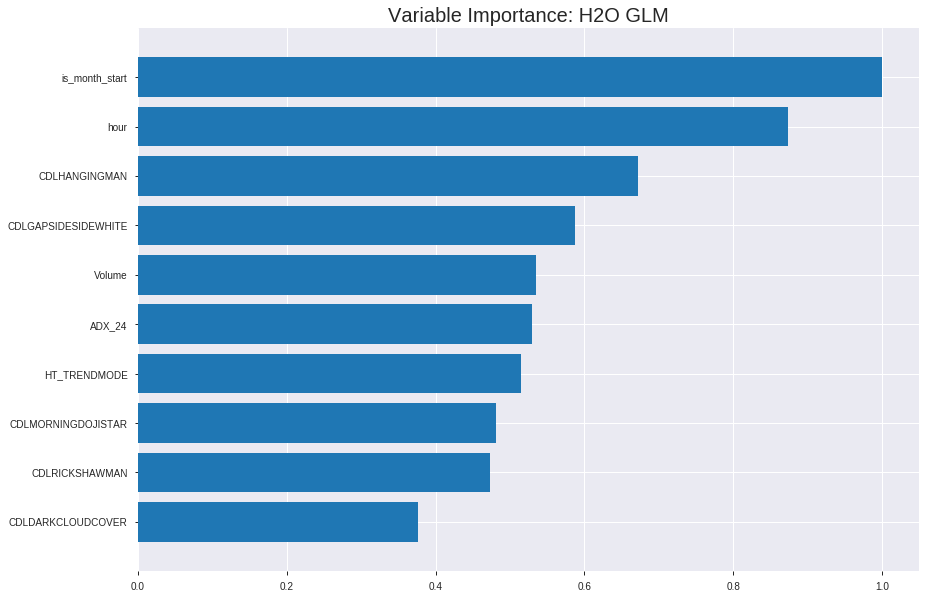

Model Details
H2OGeneralizedLinearEstimator :  Generalized Linear Modeling
Model Key:  GLM_grid_1_AutoML_20190827_212911_model_1


ModelMetricsBinomialGLM: glm
** Reported on train data. **

MSE: 0.247583277488749
RMSE: 0.49757740853936383
LogLoss: 0.6883039621451043
Null degrees of freedom: 1557
Residual degrees of freedom: 1507
Null deviance: 2159.8055361387533
Residual deviance: 2144.7551460441446
AIC: 2246.7551460441446
AUC: 0.5902830305277469
pr_auc: 0.5824114792113293
Gini: 0.18056606105549378
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.4570439395805673: 


0    1     Error    Rate
-----  ---  ----  -------  --------------
0      25   758   0.9681   (758.0/783.0)
1      4    771   0.0052   (4.0/775.0)
Total  29   1529  0.4891   (762.0/1558.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.457044     0.669271  375
max f2                       0.44391      0.833692  390
max f0point5                 0.487341     0.57313   266
max accuracy                 0.503117     0.56611   148
max precision                0.585054     1         0
max recall                   0.44391      1         390
max specificity              0.585054     1         0
max absolute_mcc             0.50767      0.136417  111
max min_per_class_accuracy   0.499007     0.56      181
max mean_per_class_accuracy  0.503117     0.565545  148

Gains/Lift Table: Avg response rate: 49.74 %, avg score: 49.74 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain       cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  ---------  -----------------
    1        0.0102696                   0.532846           1.75903   1.75903            0.875            0.552239  0.875                       0.552239            0.0180645       0.0180645                  75.9032    75.9032
    2        0.0205392                   0.524516           1.25645   1.50774            0.625            0.527531  0.75                        0.539885            0.0129032       0.0309677                  25.6452    50.7742
    3        0.0301669                   0.521475           1.07217   1.36873            0.533333         0.522828  0.680851                    0.534441            0.0103226       0.0412903                  7.2172     36.873
    4        0.0404365                   0.519477           0.753871  1.21258            0.375            0.5206    0.603175                    0.530926            0.00774194      0.0490323                  -24.6129   21.2576
    5        0.0500642                   0.518129           1.60826   1.28867            0.8              0.518869  0.641026                    0.528607            0.0154839       0.0645161                  60.8258    28.8668
    6        0.100128                    0.514654           1.39176   1.34022            0.692308         0.516378  0.666667                    0.522493            0.0696774       0.134194                   39.1762    34.0215
    7        0.150193                    0.512257           0.979388  1.21994            0.487179         0.513484  0.606838                    0.51949             0.0490323       0.183226                   -2.06121   21.9939
    8        0.200257                    0.509749           1.28867   1.23712            0.641026         0.510948  0.615385                    0.517354            0.0645161       0.247742                   28.8668    23.7122
    9        0.300385                    0.506372           1.09537   1.18987            0.544872         0.507916  0.59188                     0.514208            0.109677        0.357419                   9.53681    18.987
    10       0.399872                    0.502596           1.05056   1.15521            0.522581         0.504416  0.574639                    0.511772            0.104516        0.461935                   5.05557    15.5209
    11       0.5                         0.498925           0.992275  1.12258            0.49359          0.500808  0.558408                    0.509576            0.0993548       0.56129                    -0.772539  12.2581
    12       0.600128                    0.495158           1.01805   1.10514            0.50641          0.497173  0.549733                    0.507507            0.101935        0.663226                   1.8048     10.514
    13       0.699615                    0.490761           0.843039  1.06787            0.419355         0.492982  0.531193                    0.505442            0.083871        0.747097                   -15.6961   6.78686
    14       0.799743                    0.485916           1.01805   1.06163            0.50641          0.48849   0.52809                     0.503319            0.101935        0.849032                   1.8048     6.1631
    15       0.899872                    0.477723           0.708768  1.02237            0.352564         0.482168  0.508559                    0.500966            0.0709677       0.92                       -29.1232   2.2368
    16       1                           0.418781           0.798974  1                  0.397436         0.465679  0.497433                    0.497



ModelMetricsBinomialGLM: glm
** Reported on validation data. **

MSE: 0.24988460759320086
RMSE: 0.49988459427471943
LogLoss: 0.6929137860521772
Null degrees of freedom: 444
Residual degrees of freedom: 394
Null deviance: 617.0462294114567
Residual deviance: 616.6932695864377
AIC: 718.6932695864377
AUC: 0.5171943231441047
pr_auc: 0.5196955989436461
Gini: 0.03438864628820948
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.466543272978096: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      17   199  0.9213   (199.0/216.0)
1      8    221  0.0349   (8.0/229.0)
Total  25   420  0.4652   (207.0/445.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.466543     0.681048  374
max f2                       0.437596     0.841293  399
max f0point5                 0.481943     0.584665  297
max accuracy                 0.481943     0.557303  297
max precision                0.570892     1         0
max recall                   0.437596     1         399
max specificity              0.570892     1         0
max absolute_mcc             0.481943     0.115568  297
max min_per_class_accuracy   0.492613     0.490741  199
max mean_per_class_accuracy  0.481943     0.550026  297

Gains/Lift Table: Avg response rate: 51.46 %, avg score: 49.15 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.011236                    0.525218           1.55459   1.55459            0.8              0.537478  0.8                         0.537478            0.0174672       0.0174672                  55.4585   55.4585
    2        0.0202247                   0.520489           0         0.863658           0                0.523226  0.444444                    0.531144            0               0.0174672                  -100      -13.6342
    3        0.0314607                   0.517914           0.777293  0.832813           0.4              0.519525  0.428571                    0.526994            0.00873362      0.0262009                  -22.2707  -16.7187
    4        0.0404494                   0.515802           1.45742   0.971616           0.75             0.516878  0.5                         0.524746            0.0131004       0.0393013                  45.7424   -2.83843
    5        0.0516854                   0.513705           1.55459   1.09835            0.8              0.514503  0.565217                    0.522519            0.0174672       0.0567686                  55.4585   9.83482
    6        0.101124                    0.507498           0.883287  0.993207           0.454545         0.510399  0.511111                    0.516594            0.0436681       0.100437                   -11.6713  -0.679282
    7        0.150562                    0.505508           0.883287  0.957114           0.454545         0.506388  0.492537                    0.513242            0.0436681       0.144105                   -11.6713  -4.2886
    8        0.2                         0.503128           1.32493   1.04803            0.681818         0.504549  0.539326                    0.511094            0.0655022       0.209607                   32.4931   4.80349
    9        0.301124                    0.499695           1.03639   1.04412            0.533333         0.501648  0.537313                    0.507921            0.104803        0.31441                    3.63901   4.41244
    10       0.4                         0.496147           0.662465  0.949782           0.340909         0.497775  0.488764                    0.505413            0.0655022       0.379913                   -33.7535  -5.02183
    11       0.501124                    0.492613           1.12276   0.984687           0.577778         0.494241  0.506726                    0.503159            0.113537        0.49345                    12.2756   -1.53132
    12       0.6                         0.489029           1.32493   1.04076            0.681818         0.49086   0.535581                    0.501132            0.131004        0.624454                   32.4931   4.07569
    13       0.698876                    0.484929           1.19244   1.06222            0.613636         0.487275  0.546624                    0.499172            0.117904        0.742358                   19.2437   6.22165
    14       0.8                         0.47994            0.73411   1.02074            0.377778         0.482244  0.525281                    0.497032            0.0742358       0.816594                   -26.589   2.07424
    15       0.898876                    0.472413           0.883287  1.00562            0.454545         0.476377  0.5175                      0.49476             0.0873362       0.90393                    -11.6713  0.562227
    16       1                           0.437596           0.950024  1                  0.488889         0.462557  0.514607                    0.491503 


Scoring History: 


timestamp            duration    iteration    lambda    predictors    deviance_train    deviance_test
--  -------------------  ----------  -----------  --------  ------------  ----------------  ---------------
    2019-08-27 21:29:11  0.000 sec   2            3.7       51            1.38176           1.38603
    2019-08-27 21:29:11  0.015 sec   4            2.3       51            1.37958           1.38588
    2019-08-27 21:29:11  0.027 sec   6            1.4       51            1.37661           1.38583
    2019-08-27 21:29:11  0.039 sec   8            0.89      51            1.37279           1.38603
    2019-08-27 21:29:11  0.050 sec   10           0.55      51            1.36819           1.38681
    2019-08-27 21:29:11  0.062 sec   12           0.34      51            1.36308           1.3886
    2019-08-27 21:29:11  0.076 sec   14           0.21      51            1.35783           1.39174
    2019-08-27 21:29:11  0.087 sec   16           0.13      51            1.35286           1.39633

/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:7116: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


('accuracy', 0.5515695067264574)

('F1', 0.6746987951807228)

('auc', 0.5331402831402832)

('logloss', 0.6920362171837082)

('mean_per_class_error', 0.44868082368082374)

('rmse', 0.4994447632940437)

('mse', 0.24944507158184334)

glm prediction progress: |████████████████████████████████████████████████| 100%


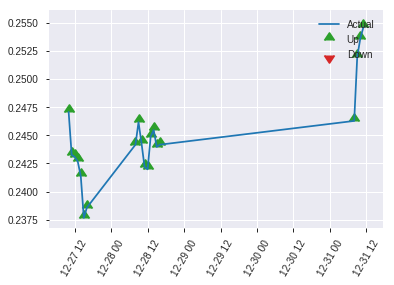


ModelMetricsBinomialGLM: glm
** Reported on test data. **

MSE: 0.24944507158184334
RMSE: 0.4994447632940437
LogLoss: 0.6920362171837082
Null degrees of freedom: 222
Residual degrees of freedom: 172
Null deviance: 309.1597919029809
Residual deviance: 308.6481528639339
AIC: 410.6481528639339
AUC: 0.5331402831402832
pr_auc: 0.5138679412988941
Gini: 0.06628056628056633
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.4664989041724644: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      3    108  0.973    (108.0/111.0)
1      0    112  0        (0.0/112.0)
Total  3    220  0.4843   (108.0/223.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.466499     0.674699  219
max f2                       0.466499     0.838323  219
max f0point5                 0.477332     0.567686  200
max accuracy                 0.495164     0.55157   123
max precision                0.51932      0.666667  5
max recall                   0.466499     1         219
max specificity              0.523779     0.990991  0
max absolute_mcc             0.466499     0.1173    219
max min_per_class_accuracy   0.496855     0.544643  110
max mean_per_class_accuracy  0.495164     0.551319  123

Gains/Lift Table: Avg response rate: 50.22 %, avg score: 49.64 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain       cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  ---------  -----------------
    1        0.0134529                   0.519514           0.66369   0.66369            0.333333         0.521393  0.333333                    0.521393            0.00892857      0.00892857                 -33.631    -33.631
    2        0.0224215                   0.51935            1.99107   1.19464            1                0.519381  0.6                         0.520588            0.0178571       0.0267857                  99.1071    19.4643
    3        0.0313901                   0.518702           0.995536  1.13776            0.5              0.519194  0.571429                    0.52019             0.00892857      0.0357143                  -0.446429  13.7755
    4        0.0403587                   0.516432           0         0.884921           0                0.518074  0.444444                    0.51972             0               0.0357143                  -100       -11.5079
    5        0.0538117                   0.514825           0.66369   0.829613           0.333333         0.515609  0.416667                    0.518692            0.00892857      0.0446429                  -33.631    -17.0387
    6        0.103139                    0.5126             1.26705   1.03882            0.636364         0.513741  0.521739                    0.516324            0.0625          0.107143                   26.7045    3.88199
    7        0.152466                    0.510917           1.08604   1.0541             0.545455         0.511808  0.529412                    0.514863            0.0535714       0.160714                   8.6039     5.40966
    8        0.201794                    0.509435           0.905032  1.01766            0.454545         0.510193  0.511111                    0.513721            0.0446429       0.205357                   -9.49675   1.76587
    9        0.300448                    0.504432           0.995536  1.01039            0.5              0.507066  0.507463                    0.511536            0.0982143       0.303571                   -0.446429  1.03945
    10       0.399103                    0.500617           1.17654   1.05146            0.590909         0.502676  0.52809                     0.509346            0.116071        0.419643                   17.6542    5.14647
    11       0.502242                    0.496813           1.21196   1.08442            0.608696         0.498586  0.544643                    0.507136            0.125           0.544643                   21.1957    8.44228
    12       0.600897                    0.493862           0.905032  1.05497            0.454545         0.495273  0.529851                    0.505189            0.0892857       0.633929                   -9.49675   5.49707
    13       0.699552                    0.489311           0.814529  1.02106            0.409091         0.491787  0.512821                    0.503299            0.0803571       0.714286                   -18.5471   2.10623
    14       0.798206                    0.484755           1.08604   1.02909            0.545455         0.486953  0.516854                    0.501279            0.107143        0.821429                   8.6039     2.90931
    15       0.896861                    0.477381           0.995536  1.0254             0.5              0.481416  0.515                       0.499094            0.0982143       0.919643                   -0.446429  2.54018
    16       1                           0.462079           0.779115  1                  0.391304         0.472664  0.502242                  

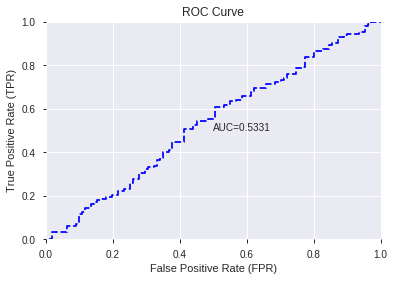

/usr/local/lib/python3.6/dist-packages/matplotlib/cbook/__init__.py:424: MatplotlibDeprecationWarning: 
Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warn_deprecated("2.2", "Passing one of 'on', 'true', 'off', 'false' as a "


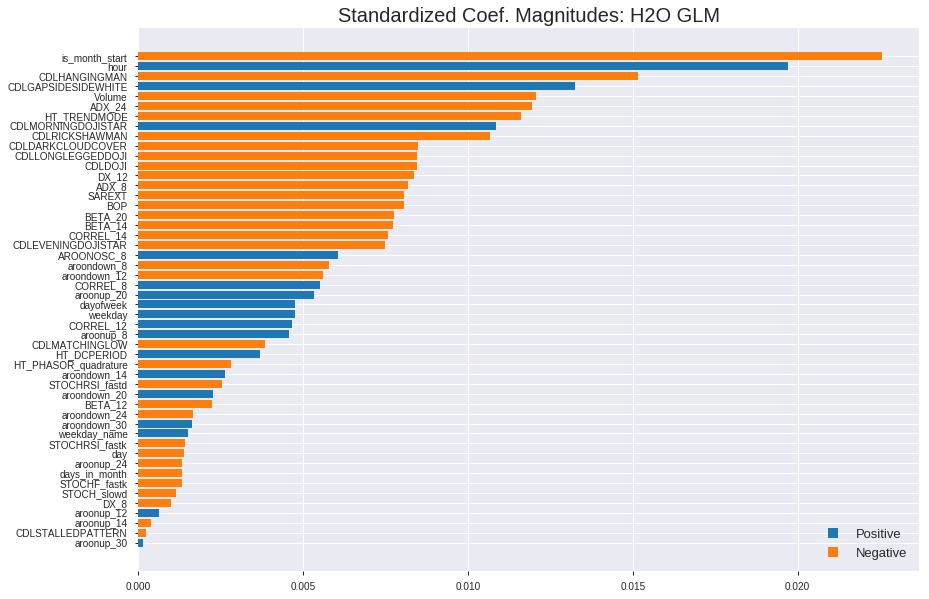

'log_likelihood'
--2019-08-27 21:29:17--  https://h2o-release.s3.amazonaws.com/h2o/rel-yates/5/h2o-3.24.0.5.zip
Resolving h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)... 52.217.32.204
Connecting to h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)|52.217.32.204|:443... connected.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.

Archive:  h2o-3.24.0.5.zip
ERROR: Unknown MOJO type


[{'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Models/GLM_grid_1_AutoML_20190827_212911_model_1',
   '__meta': {'schema_name': 'ModelKeyV3',
    'schema_type': 'Key<Model>',
    'schema_version': 3},
   'name': 'GLM_grid_1_AutoML_20190827_212911_model_1',
   'type': 'Key<Model>'},
  'default_value': None,
  'gridable': False,
  'help': 'Destination id for this model; auto-generated if not specified.',
  'is_member_of_frames': [],
  'is_mutually_exclusive_with': [],
  'label': 'model_id',
  'level': 'critical',
  'name': 'model_id',
  'required': False,
  'type': 'Key<Model>',
  'values': []},
 {'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Frames/automl_training_py_18_sid_a8e7',
   '__meta': {'schema_name': 'FrameKeyV3',
    'schema_type': 'Key<Frame>',
    'schema_version': 3},
   'name': 'automl_training_py_18_s

['is_month_start',
 'hour',
 'CDLHANGINGMAN',
 'CDLGAPSIDESIDEWHITE',
 'Volume',
 'ADX_24',
 'HT_TRENDMODE',
 'CDLMORNINGDOJISTAR',
 'CDLRICKSHAWMAN',
 'CDLDARKCLOUDCOVER',
 'CDLLONGLEGGEDDOJI',
 'CDLDOJI',
 'DX_12',
 'ADX_8',
 'SAREXT',
 'BOP',
 'BETA_20',
 'BETA_14',
 'CORREL_14',
 'CDLEVENINGDOJISTAR',
 'AROONOSC_8',
 'aroondown_8',
 'aroondown_12',
 'CORREL_8',
 'aroonup_20',
 'dayofweek',
 'weekday',
 'CORREL_12',
 'aroonup_8',
 'CDLMATCHINGLOW',
 'HT_DCPERIOD',
 'HT_PHASOR_quadrature',
 'aroondown_14',
 'STOCHRSI_fastd',
 'aroondown_20',
 'BETA_12',
 'aroondown_24',
 'aroondown_30',
 'weekday_name',
 'STOCHRSI_fastk',
 'day',
 'aroonup_24',
 'days_in_month',
 'STOCHF_fastk',
 'STOCH_slowd',
 'DX_8',
 'aroonup_12',
 'aroonup_14',
 'CDLSTALLEDPATTERN',
 'aroonup_30']

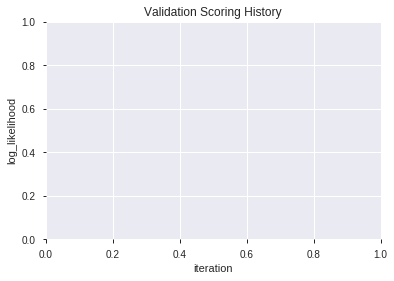

In [13]:
# GLM with top DeepLearning features
model_train(feature_name='DLF',model_algo="GLM",features_list = features_list[:model_selected_features])

AutoML progress: |████████████████████████████████████████████████████████| 100%


model_id       auc   logloss  mean_per_class_error      rmse       mse
0  XGBoost_grid_1_AutoML_20190827_212922_model_2  0.557191  0.686476              0.486406  0.496750  0.246761
1               XGBoost_3_AutoML_20190827_212922  0.553491  0.687507              0.481982  0.497285  0.247292
2  XGBoost_grid_1_AutoML_20190827_212922_model_6  0.552606  0.691233              0.500000  0.499087  0.249088
3  XGBoost_grid_1_AutoML_20190827_212922_model_7  0.551158  0.697798              0.481942  0.502370  0.252376
4               XGBoost_1_AutoML_20190827_212922  0.549871  0.694261              0.490991  0.500540  0.250540
5  XGBoost_grid_1_AutoML_20190827_212922_model_1  0.543919  0.692295              0.441039  0.499617  0.249617
6  XGBoost_grid_1_AutoML_20190827_212922_model_4  0.531934  0.694169              0.490991  0.500500  0.250500
7  XGBoost_grid_1_AutoML_20190827_212922_model_3  0.526625  0.700775              0.500000  0.503685  0.253699
8  XGBoost_grid_1_AutoML_20190827_212922_model_5  0.522683  0.719978              0.486406  0.512060  0.262206
9               XGBoost_2_AutoML_20190827_212922  0.511261  0.703397              0.454673  0.504867  0.254890

variable  relative_importance  scaled_importance  percentage
0            HT_DCPERIOD           271.609955           1.000000    0.061337
1                    BOP           237.785675           0.875467    0.053699
2                  ADX_8           228.966415           0.842997    0.051707
3                 Volume           222.867752           0.820543    0.050330
4                BETA_20           202.614792           0.745977    0.045756
5            STOCH_slowd           193.254990           0.711517    0.043643
6                   hour           189.645935           0.698229    0.042828
7                    day           189.479340           0.697616    0.042790
8                 SAREXT           187.648865           0.690876    0.042377
9           STOCHF_fastk           187.442810           0.690118    0.042330
10                ADX_24           182.062561           0.670309    0.041115
11                 DX_12           180.705353           0.665312    0.040809
12  HT_PHASOR_quadrature           178.620407           0.657636    0.040338
13               BETA_14           153.859497           0.566472    0.034746
14                  DX_8           131.924210           0.485712    0.029792
15               BETA_12           125.462494           0.461922    0.028333
16        STOCHRSI_fastk           121.959808           0.449026    0.027542
17        STOCHRSI_fastd           121.052696           0.445686    0.027337
18          aroondown_30           112.028702           0.412462    0.025299
19             CORREL_14           107.089584           0.394277    0.024184
20             CORREL_12            99.564926           0.366573    0.022485
21            aroonup_30            64.047874           0.235808    0.014464
22            aroonup_24            59.432709           0.218816    0.013422
23        CDLRICKSHAWMAN            58.750607           0.216305    0.013268
24            AROONOSC_8            58.659622           0.215970    0.013247
25            aroonup_20            58.590137           0.215714    0.013231
26          aroondown_12            57.513241           0.211749    0.012988
27          aroondown_20            53.854115           0.198277    0.012162
28          aroondown_24            48.447018           0.178370    0.010941
29              CORREL_8            45.999691           0.169359    0.010388
30          aroondown_14            45.801533           0.168630    0.010343
31            aroonup_14            41.784554           0.153840    0.009436
32           aroondown_8            36.580166           0.134679    0.008261
33             dayofweek            35.884163           0.132117    0.008104
34             aroonup_8            27.125433           0.099869    0.006126
35          weekday_name            26.300911           0.096833    0.005940
36            aroonup_12            23.423946           0.086241    0.005290
37               CDLDOJI            20.947704           0.077124    0.004731
38         days_in_month            12.041528           0.044334    0.002719
39               weekday            10.125387           0.037279    0.002287
40          HT_TRENDMODE             7.041573           0.025925    0.001590
41     CDLDARKCLOUDCOVER             4.237030           0.015600    0.000957
42        CDLMATCHINGLOW             4.171704           0.015359    0.000942
43         CDLHANGINGMAN             1.718801           0.006328    0.000388

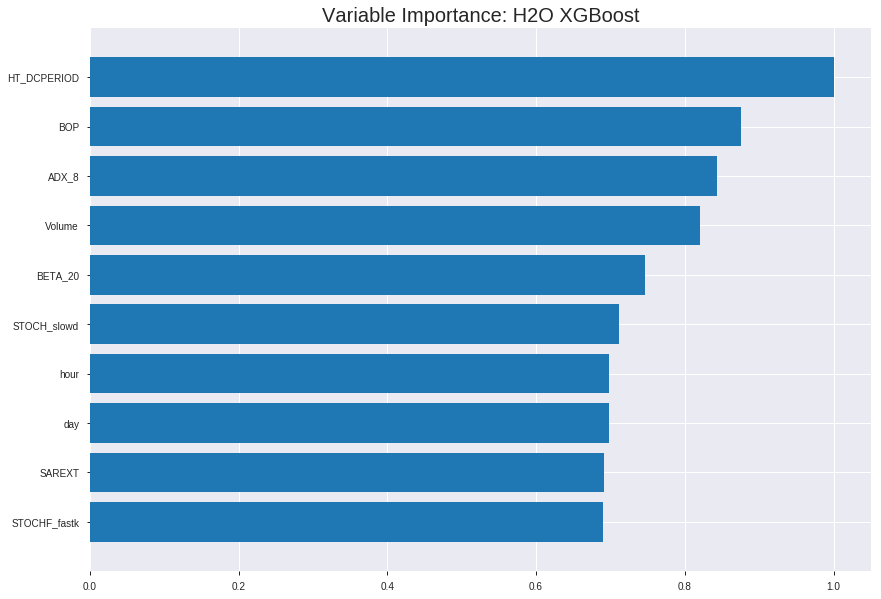

Model Details
H2OXGBoostEstimator :  XGBoost
Model Key:  XGBoost_grid_1_AutoML_20190827_212922_model_2


ModelMetricsBinomial: xgboost
** Reported on train data. **

MSE: 0.19680635851109948
RMSE: 0.4436286267939655
LogLoss: 0.585061823519972
Mean Per-Class Error: 0.15978165039344128
AUC: 0.9202793227042393
pr_auc: 0.9191396515863921
Gini: 0.8405586454084786
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.4766524774687631: 


0    1    Error    Rate
-----  ---  ---  -------  --------------
0      586  197  0.2516   (197.0/783.0)
1      65   710  0.0839   (65.0/775.0)
Total  651  907  0.1682   (262.0/1558.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.476652     0.844233  226
max f2                       0.450091     0.89759   260
max f0point5                 0.533174     0.862015  156
max accuracy                 0.497946     0.84018   200
max precision                0.676161     1         0
max recall                   0.332838     1         386
max specificity              0.676161     1         0
max absolute_mcc             0.497946     0.680473  200
max min_per_class_accuracy   0.500344     0.837419  197
max mean_per_class_accuracy  0.497946     0.840218  200

Gains/Lift Table: Avg response rate: 49.74 %, avg score: 49.71 %



group    cumulative_data_fraction    lower_threshold    lift       cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  ---------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0102696                   0.654407           2.01032    2.01032            1                0.664826  1                           0.664826            0.0206452       0.0206452                  101.032   101.032
    2        0.0205392                   0.64373            2.01032    2.01032            1                0.648365  1                           0.656596            0.0206452       0.0412903                  101.032   101.032
    3        0.0301669                   0.636691           2.01032    2.01032            1                0.639604  1                           0.651173            0.0193548       0.0606452                  101.032   101.032
    4        0.0404365                   0.631449           2.01032    2.01032            1                0.634133  1                           0.646845            0.0206452       0.0812903                  101.032   101.032
    5        0.0500642                   0.626567           2.01032    2.01032            1                0.628645  1                           0.643345            0.0193548       0.100645                   101.032   101.032
    6        0.100128                    0.606117           2.01032    2.01032            1                0.616258  1                           0.629802            0.100645        0.20129                    101.032   101.032
    7        0.150193                    0.590686           1.933      1.98455            0.961538         0.598535  0.987179                    0.619379            0.0967742       0.298065                   93.3002   98.4549
    8        0.200257                    0.578856           1.933      1.97166            0.961538         0.585182  0.980769                    0.61083             0.0967742       0.394839                   93.3002   97.1663
    9        0.300385                    0.552936           1.75259    1.89864            0.871795         0.566243  0.944444                    0.595968            0.175484        0.570323                   75.2589   89.8638
    10       0.399872                    0.528022           1.51747    1.8038             0.754839         0.540973  0.897271                    0.582285            0.150968        0.72129                    51.7469   80.3805
    11       0.5                         0.499231           1.18557    1.68               0.589744         0.512895  0.835687                    0.568389            0.11871         0.84                       18.5575   68
    12       0.600128                    0.472098           0.824748   1.53731            0.410256         0.485306  0.764706                    0.554527            0.0825806       0.922581                   -17.5252  53.7306
    13       0.699615                    0.44239            0.453944   1.38325            0.225806         0.456947  0.688073                    0.540651            0.0451613       0.967742                   -54.6056  38.3249
    14       0.799743                    0.416846           0.206187   1.23588            0.102564         0.430648  0.614767                    0.526879            0.0206452       0.988387                   -79.3813  23.588
    15       0.899872                    0.382414           0.0902068  1.1084             0.0448718        0.400944  0.551355                    0.512866            0.00903226      0.997419                   -90.9793  10.8402
    16       1                           0.297186           0.0257734  1                  0.0128205        0.355619  0.497433                    0.497



ModelMetricsBinomial: xgboost
** Reported on validation data. **

MSE: 0.25776995906485944
RMSE: 0.5077105071444351
LogLoss: 0.7089909065948448
Mean Per-Class Error: 0.49523896166909265
AUC: 0.4665211062590975
pr_auc: 0.4864032391544607
Gini: -0.06695778748180503
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.3641563057899475: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      3    213  0.9861   (213.0/216.0)
1      1    228  0.0044   (1.0/229.0)
Total  4    441  0.4809   (214.0/445.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.364156     0.680597  395
max f2                       0.348253     0.841293  399
max f0point5                 0.364156     0.572002  395
max accuracy                 0.364156     0.519101  395
max precision                0.664871     0.666667  1
max recall                   0.348253     1         399
max specificity              0.709764     0.99537   0
max absolute_mcc             0.441606     0.095029  309
max min_per_class_accuracy   0.496655     0.476852  202
max mean_per_class_accuracy  0.364156     0.504761  395

Gains/Lift Table: Avg response rate: 51.46 %, avg score: 49.52 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain       cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  ---------  -----------------
    1        0.011236                    0.641895           0.777293  0.777293           0.4              0.665577  0.4                         0.665577            0.00873362      0.00873362                 -22.2707   -22.2707
    2        0.0202247                   0.626119           0.485808  0.647744           0.25             0.633741  0.333333                    0.651428            0.00436681      0.0131004                  -51.4192   -35.2256
    3        0.0314607                   0.615727           1.16594   0.832813           0.6              0.621238  0.428571                    0.640646            0.0131004       0.0262009                  16.5939    -16.7187
    4        0.0404494                   0.605275           1.45742   0.971616           0.75             0.611451  0.5                         0.634158            0.0131004       0.0393013                  45.7424    -2.83843
    5        0.0516854                   0.598745           0.777293  0.929372           0.4              0.601462  0.478261                    0.62705             0.00873362      0.0480349                  -22.2707   -7.06284
    6        0.101124                    0.574233           0.794958  0.863658           0.409091         0.585329  0.444444                    0.606653            0.0393013       0.0873362                  -20.5042   -13.6342
    7        0.150562                    0.562142           1.05994   0.928111           0.545455         0.566874  0.477612                    0.593592            0.0524017       0.139738                   5.99444    -7.18895
    8        0.2                         0.548355           0.971616  0.938865           0.5              0.555048  0.483146                    0.584064            0.0480349       0.187773                   -2.83843   -6.11354
    9        0.301124                    0.528635           0.993207  0.957114           0.511111         0.537763  0.492537                    0.568515            0.100437        0.28821                    -0.679282  -4.2886
    10       0.4                         0.508658           0.971616  0.960699           0.5              0.516241  0.494382                    0.555593            0.0960699       0.384279                   -2.83843   -3.93013
    11       0.501124                    0.496657           0.950024  0.958545           0.488889         0.50231   0.493274                    0.544841            0.0960699       0.480349                   -4.99757   -4.14553
    12       0.6                         0.480917           1.14827   0.989811           0.590909         0.489052  0.509363                    0.535647            0.113537        0.593886                   14.8273    -1.01892
    13       0.698876                    0.461335           0.750794  0.955995           0.386364         0.472044  0.491961                    0.526649            0.0742358       0.668122                   -24.9206   -4.40051
    14       0.8                         0.438077           0.993207  0.960699           0.511111         0.45022   0.494382                    0.516988            0.100437        0.768559                   -0.679282  -3.93013
    15       0.898876                    0.414205           1.2366    0.991048           0.636364         0.427369  0.51                        0.50713             0.122271        0.89083                    23.6602    -0.895197
    16       1                           0.348253           1.07957   1                  0.555556         0.388891  0.514607     


Scoring History: 


timestamp            duration    number_of_trees    training_rmse    training_logloss    training_auc    training_pr_auc    training_lift    training_classification_error    validation_rmse    validation_logloss    validation_auc    validation_pr_auc    validation_lift    validation_classification_error
--  -------------------  ----------  -----------------  ---------------  ------------------  --------------  -----------------  ---------------  -------------------------------  -----------------  --------------------  ----------------  -------------------  -----------------  ---------------------------------
    2019-08-27 21:29:27  0.731 sec   0                  0.5              0.693147            0.5             0                  1                0.502567                         0.5                0.693147              0.5               0                    1                  0.485393
    2019-08-27 21:29:28  0.844 sec   5                  0.492515         0.678278            0.781398        0.776112           2.01032          0.32285                          0.50102            0.69519               0.467825          0.498573             1.16594            0.478652
    2019-08-27 21:29:28  0.916 sec   10                 0.48565          0.664805            0.824692        0.823012           2.01032          0.258023                         0.501075           0.695304              0.487536          0.510902             1.16594            0.480899
    2019-08-27 21:29:28  0.989 sec   15                 0.479743         0.653325            0.849067        0.849612           2.01032          0.22914                          0.50188            0.696925              0.478419          0.501641             1.16594            0.483146
    2019-08-27 21:29:28  1.065 sec   20                 0.473903         0.642073            0.869225        0.865969           2.01032          0.209243                         0.502553           0.698288              0.47481           0.49719              0.777293           0.483146
    2019-08-27 21:29:28  1.139 sec   25                 0.468507         0.631747            0.878383        0.878599           2.01032          0.207317                         0.503927           0.701081              0.463691          0.487539             1.16594            0.483146
    2019-08-27 21:29:28  1.217 sec   30                 0.463501         0.622224            0.885394        0.886289           2.01032          0.193838                         0.505008           0.703299              0.461416          0.483347             0.777293           0.480899
    2019-08-27 21:29:28  1.294 sec   35                 0.457946         0.611754            0.898247        0.899941           2.01032          0.186136                         0.505681           0.704701              0.463014          0.484722             0.388646           0.483146
    2019-08-27 21:29:28  1.375 sec   40                 0.453245         0.602933            0.904401        0.906008           2.01032          0.184211                         0.506764           0.70697               0.461608          0.484007             0.777293           0.485393
    2019-08-27 21:29:28  1.451 sec   45                 0.448835         0.594701            0.909738        0.908462           2.01032          0.175866                         0.507203           0.707909              0.466511          0.48704              0.777293           0.483146
    2019-08-27 21:29:28  1.534 sec   50                 0.443629         0.585062            0.920279        0.91914            2.01032          0.168164                         0.507711           0.708991              0.466521          0.486403             0.777293           0.480899

Variable Importances: 


variable           relative_importance    scaled_importance     percentage
-----------------  ---------------------  --------------------  ---------------------
HT_DCPERIOD        271.6099548339844      1.0                   0.06133744653259321
BOP                237.78567504882812     0.8754674518250607    0.05369893801734528
ADX_8              228.96641540527344     0.8429971410481775    0.05170729206617152
Volume             222.8677520751953      0.8205433862371442    0.050330036080993804
BETA_20            202.6147918701172      0.7459770463640076    0.04575632719589412
---                ---                    ---                   ---
weekday            10.125387191772461     0.03727914611215698   0.0022866076314351585
HT_TRENDMODE       7.041572570800781      0.025925311077441133  0.001590192382053392
CDLDARKCLOUDCOVER  4.237030029296875      0.015599686071472111  0.0009568449103341595
CDLMATCHINGLOW     4.171704292297363      0.015359173027539532  0.0009420924543615538
CDLHANGINGMAN      1.718801498413086      0.006328197725535007  0.0003881554896376814


See the whole table with table.as_data_frame()


/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:7116: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


('accuracy', 0.5605381165919282)

('F1', 0.6707317073170733)

('auc', 0.5571911196911197)

('logloss', 0.6864755170637058)

('mean_per_class_error', 0.439028314028314)

('rmse', 0.49675047600426586)

('mse', 0.2467610354104647)

xgboost prediction progress: |████████████████████████████████████████████| 100%


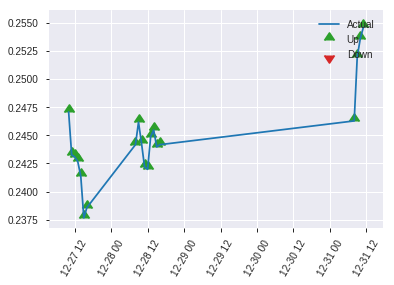


ModelMetricsBinomial: xgboost
** Reported on test data. **

MSE: 0.2467610354104647
RMSE: 0.49675047600426586
LogLoss: 0.6864755170637058
Mean Per-Class Error: 0.439028314028314
AUC: 0.5571911196911197
pr_auc: 0.5817925565992141
Gini: 0.11438223938223935
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.39483243227005005: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      5    106  0.955    (106.0/111.0)
1      2    110  0.0179   (2.0/112.0)
Total  7    216  0.4843   (108.0/223.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.394832     0.670732  215
max f2                       0.367054     0.835821  221
max f0point5                 0.447872     0.568182  180
max accuracy                 0.531438     0.560538  89
max precision                0.666011     1         0
max recall                   0.367054     1         221
max specificity              0.666011     1         0
max absolute_mcc             0.617183     0.184594  16
max min_per_class_accuracy   0.511569     0.504505  111
max mean_per_class_accuracy  0.531438     0.560972  89

Gains/Lift Table: Avg response rate: 50.22 %, avg score: 51.46 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain       cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  ---------  -----------------
    1        0.0134529                   0.65795            1.99107   1.99107            1                0.660909  1                           0.660909            0.0267857       0.0267857                  99.1071    99.1071
    2        0.0224215                   0.653397           0.995536  1.59286            0.5              0.657245  0.8                         0.659443            0.00892857      0.0357143                  -0.446429  59.2857
    3        0.0313901                   0.639939           1.99107   1.70663            1                0.644531  0.857143                    0.655183            0.0178571       0.0535714                  99.1071    70.6633
    4        0.0403587                   0.637873           1.99107   1.76984            1                0.639458  0.888889                    0.651688            0.0178571       0.0714286                  99.1071    76.9841
    5        0.0538117                   0.629086           0.66369   1.4933             0.333333         0.634928  0.75                        0.647498            0.00892857      0.0803571                  -33.631    49.3304
    6        0.103139                    0.601957           1.44805   1.47166            0.727273         0.613081  0.73913                     0.631038            0.0714286       0.151786                   44.8052    47.1661
    7        0.152466                    0.585906           0.905032  1.28834            0.454545         0.591746  0.647059                    0.618326            0.0446429       0.196429                   -9.49675   28.834
    8        0.201794                    0.577894           0.905032  1.19464            0.454545         0.581525  0.6                         0.60933             0.0446429       0.241071                   -9.49675   19.4643
    9        0.300448                    0.555531           1.08604   1.15898            0.545455         0.564611  0.58209                     0.594646            0.107143        0.348214                   8.6039     15.8982
    10       0.399103                    0.531485           1.08604   1.14095            0.545455         0.54257   0.573034                    0.581773            0.107143        0.455357                   8.6039     14.0951
    11       0.502242                    0.511569           0.51941   1.01331            0.26087          0.521052  0.508929                    0.569304            0.0535714       0.508929                   -48.059    1.33131
    12       0.600897                    0.500384           1.17654   1.04011            0.590909         0.505952  0.522388                    0.558903            0.116071        0.625                      17.6542    4.01119
    13       0.699552                    0.477811           1.08604   1.04659            0.545455         0.488753  0.525641                    0.54901             0.107143        0.732143                   8.6039     4.65888
    14       0.798206                    0.45019            0.995536  1.04028            0.5              0.464594  0.522472                    0.538576            0.0982143       0.830357                   -0.446429  4.02789
    15       0.896861                    0.426255           0.814529  1.01545            0.409091         0.439592  0.51                        0.527688            0.0803571       0.910714                   -18.5471   1.54464
    16       1                           0.351768           0.865683  1                  0.434783         0.401127  0.502242                    0

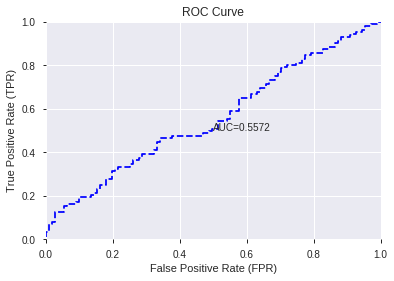

This function is available for GLM models only


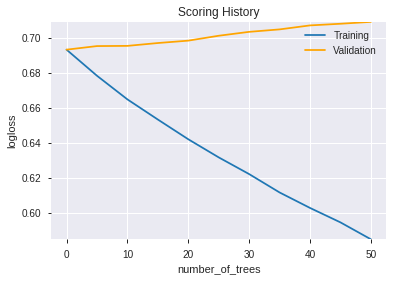

--2019-08-27 21:29:40--  https://h2o-release.s3.amazonaws.com/h2o/rel-yates/5/h2o-3.24.0.5.zip
Resolving h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)... 52.216.147.83
Connecting to h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)|52.216.147.83|:443... connected.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.

Archive:  h2o-3.24.0.5.zip
Exception in thread "main" java.lang.StackOverflowError
	at java.base/java.lang.String.substring(String.java:1874)
	at java.base/java.lang.String.split(String.java:2289)
	at java.base/java.lang.String.split(String.java:2364)
	at hex.genmodel.algos.xgboost.XGBoostMojoModel.constructSubgraph(XGBoostMojoModel.java:101)
	at hex.genmodel.algos.xgboost.XGBoostMojoModel.constructSubgraph(XGBoostMojoModel.java:112)
	at hex.genmodel.algos.xgboost.XGBoostMojoModel.constructSubgraph(XGBoostMojoModel.java:106)
	at hex.genmodel.algos.xgboost.XGBoostMojoMode

[{'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Models/XGBoost_grid_1_AutoML_20190827_212922_model_2',
   '__meta': {'schema_name': 'ModelKeyV3',
    'schema_type': 'Key<Model>',
    'schema_version': 3},
   'name': 'XGBoost_grid_1_AutoML_20190827_212922_model_2',
   'type': 'Key<Model>'},
  'default_value': None,
  'gridable': False,
  'help': 'Destination id for this model; auto-generated if not specified.',
  'is_member_of_frames': [],
  'is_mutually_exclusive_with': [],
  'label': 'model_id',
  'level': 'critical',
  'name': 'model_id',
  'required': False,
  'type': 'Key<Model>',
  'values': []},
 {'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Frames/automl_training_py_26_sid_a8e7',
   '__meta': {'schema_name': 'FrameKeyV3',
    'schema_type': 'Key<Frame>',
    'schema_version': 3},
   'name': 'automl_training

['HT_DCPERIOD',
 'BOP',
 'ADX_8',
 'Volume',
 'BETA_20',
 'STOCH_slowd',
 'hour',
 'day',
 'SAREXT',
 'STOCHF_fastk',
 'ADX_24',
 'DX_12',
 'HT_PHASOR_quadrature',
 'BETA_14',
 'DX_8',
 'BETA_12',
 'STOCHRSI_fastk',
 'STOCHRSI_fastd',
 'aroondown_30',
 'CORREL_14',
 'CORREL_12',
 'aroonup_30',
 'aroonup_24',
 'CDLRICKSHAWMAN',
 'AROONOSC_8',
 'aroonup_20',
 'aroondown_12',
 'aroondown_20',
 'aroondown_24',
 'CORREL_8',
 'aroondown_14',
 'aroonup_14',
 'aroondown_8',
 'dayofweek',
 'aroonup_8',
 'weekday_name',
 'aroonup_12',
 'CDLDOJI',
 'days_in_month',
 'weekday',
 'HT_TRENDMODE',
 'CDLDARKCLOUDCOVER',
 'CDLMATCHINGLOW',
 'CDLHANGINGMAN']

In [14]:
# XGBoost with top DeepLearning features
model_train(feature_name='DLF',model_algo="XGBoost",features_list = features_list[:model_selected_features])

AutoML progress: |████████████████████████████████████████████████████████| 100%


model_id       auc   logloss  mean_per_class_error     rmse       mse
0  GLM_grid_1_AutoML_20190827_212945_model_1  0.463803  0.695855              0.495455  0.50135  0.251352

variable  relative_importance  scaled_importance    percentage
0             is_month_start         9.011343e-03           1.000000  1.822794e-02
1                       hour         7.958030e-03           0.883113  1.609732e-02
2                CDLMARUBOZU         7.255164e-03           0.805115  1.467558e-02
3              CDLHANGINGMAN         6.362054e-03           0.706005  1.286902e-02
4        CDLGAPSIDESIDEWHITE         5.381129e-03           0.597151  1.088482e-02
...                      ...                  ...                ...           ...
1028  BBANDS_lowerband_8_4_3         4.341012e-07           0.000048  8.780900e-07
1029                    High         2.989536e-07           0.000033  6.047165e-07
1030                  MA_8_7         2.870169e-07           0.000032  5.805711e-07
1031  BBANDS_lowerband_8_5_5         1.608173e-07           0.000018  3.252975e-07
1032                  WMA_14         3.636541e-08           0.000004  7.355912e-08

[1033 rows x 4 columns]

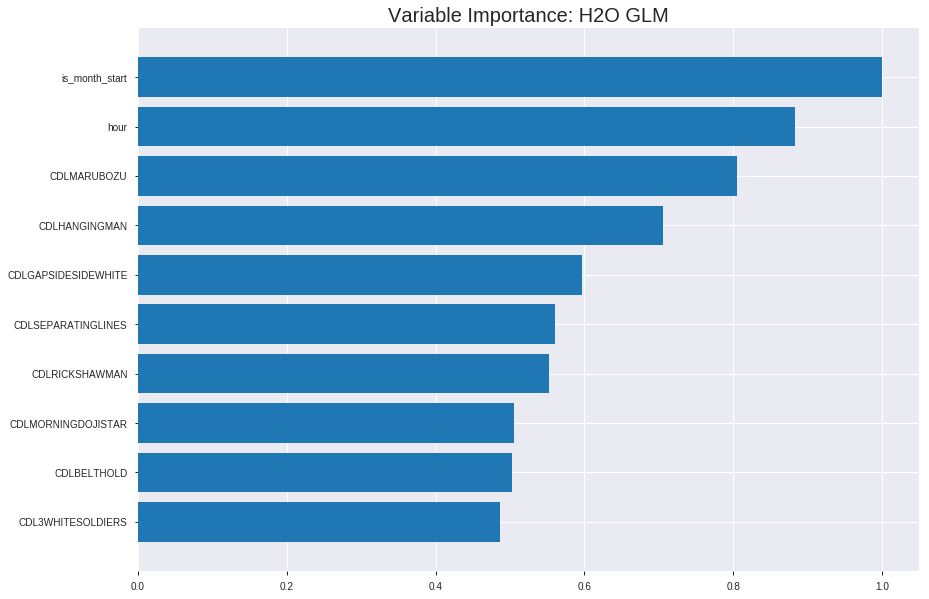

Model Details
H2OGeneralizedLinearEstimator :  Generalized Linear Modeling
Model Key:  GLM_grid_1_AutoML_20190827_212945_model_1


ModelMetricsBinomialGLM: glm
** Reported on train data. **

MSE: 0.2471126934483995
RMSE: 0.4971043084186653
LogLoss: 0.6873450774922317
Null degrees of freedom: 1557
Residual degrees of freedom: 524
Null deviance: 2159.8055361387533
Residual deviance: 2141.767261465794
AIC: 4209.767261465794
AUC: 0.5811222345816339
pr_auc: 0.5807992869315382
Gini: 0.16224446916326785
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.36950172173528534: 


0    1     Error    Rate
-----  ---  ----  -------  --------------
0      7    776   0.9911   (776.0/783.0)
1      1    774   0.0013   (1.0/775.0)
Total  8    1550  0.4987   (777.0/1558.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.369502     0.665806  392
max f2                       0.366831     0.832617  395
max f0point5                 0.498265     0.569097  187
max accuracy                 0.506306     0.563543  144
max precision                0.555245     1         0
max recall                   0.366831     1         395
max specificity              0.555245     1         0
max absolute_mcc             0.499864     0.128713  178
max min_per_class_accuracy   0.504429     0.55871   155
max mean_per_class_accuracy  0.499864     0.563354  178

Gains/Lift Table: Avg response rate: 49.74 %, avg score: 49.74 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0102696                   0.535377           1.75903   1.75903            0.875            0.541521  0.875                       0.541521            0.0180645       0.0180645                  75.9032   75.9032
    2        0.0205392                   0.531946           1.50774   1.63339            0.75             0.533431  0.8125                      0.537476            0.0154839       0.0335484                  50.7742   63.3387
    3        0.0301669                   0.528951           1.34022   1.53982            0.666667         0.530417  0.765957                    0.535223            0.0129032       0.0464516                  34.0215   53.9822
    4        0.0404365                   0.527218           1.63339   1.56358            0.8125           0.528107  0.777778                    0.533416            0.0167742       0.0632258                  63.3387   56.3584
    5        0.0500642                   0.526496           1.20619   1.49486            0.6              0.526902  0.74359                     0.532163            0.0116129       0.0748387                  20.6194   49.4855
    6        0.100128                    0.522222           1.00516   1.25001            0.5              0.524094  0.621795                    0.528128            0.0503226       0.125161                   0.516129  25.0008
    7        0.150193                    0.519257           1.10825   1.20276            0.551282         0.520695  0.598291                    0.525651            0.0554839       0.180645                   10.8255   20.2757
    8        0.200257                    0.517054           1.08248   1.17269            0.538462         0.518102  0.583333                    0.523763            0.0541935       0.234839                   8.24814   17.2688
    9        0.300385                    0.512794           1.17269   1.17269            0.583333         0.514973  0.583333                    0.520833            0.117419        0.352258                   17.2688   17.2688
    10       0.399872                    0.508904           1.05056   1.1423             0.522581         0.510802  0.568218                    0.518337            0.104516        0.456774                   5.05557   14.2302
    11       0.5                         0.504121           1.01805   1.11742            0.50641          0.50655   0.555841                    0.515977            0.101935        0.55871                    1.8048    11.7419
    12       0.600128                    0.49913            1.01805   1.10084            0.50641          0.501735  0.547594                    0.513601            0.101935        0.660645                   1.8048    10.084
    13       0.699615                    0.491858           0.843039  1.06418            0.419355         0.495478  0.529358                    0.511024            0.083871        0.744516                   -15.6961  6.41799
    14       0.799743                    0.482686           0.927841  1.04711            0.461538         0.487848  0.520867                    0.508122            0.0929032       0.837419                   -7.21588  4.71102
    15       0.899872                    0.466901           0.902068  1.03097            0.448718         0.475219  0.512839                    0.504461            0.0903226       0.927742                   -9.79322  3.09714
    16       1                           0.357487           0.721654  1                  0.358974         0.434269  0.497433                    0.497433          



ModelMetricsBinomialGLM: glm
** Reported on validation data. **

MSE: 0.2552380643859141
RMSE: 0.5052109107946048
LogLoss: 0.7040282448964653
Null degrees of freedom: 444
Residual degrees of freedom: -589
Null deviance: 617.0462294114567
Residual deviance: 626.5851379578542
AIC: 2694.5851379578544
AUC: 0.4675218340611354
pr_auc: 0.5008466004506479
Gini: -0.0649563318777292
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.2967103817498353: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      0    216  1        (216.0/216.0)
1      0    229  0        (0.0/229.0)
Total  0    445  0.4854   (216.0/445.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value      idx
---------------------------  -----------  ---------  -----
max f1                       0.29671      0.679525   399
max f2                       0.29671      0.841293   399
max f0point5                 0.29671      0.569935   399
max accuracy                 0.429752     0.516854   362
max precision                0.523539     0.75       3
max recall                   0.29671      1          399
max specificity              0.532953     0.99537    0
max absolute_mcc             0.462419     0.0949498  299
max min_per_class_accuracy   0.480939     0.467249   190
max mean_per_class_accuracy  0.506195     0.509027   60

Gains/Lift Table: Avg response rate: 51.46 %, avg score: 47.41 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.011236                    0.521023           1.16594   1.16594            0.6              0.52652   0.6                         0.52652             0.0131004       0.0131004                  16.5939   16.5939
    2        0.0202247                   0.517176           1.45742   1.29549            0.75             0.518799  0.666667                    0.523089            0.0131004       0.0262009                  45.7424   29.5488
    3        0.0314607                   0.516501           0.388646  0.971616           0.2              0.516986  0.5                         0.520909            0.00436681      0.0305677                  -61.1354  -2.83843
    4        0.0404494                   0.514175           0.485808  0.863658           0.25             0.515607  0.444444                    0.519731            0.00436681      0.0349345                  -51.4192  -13.6342
    5        0.0516854                   0.512708           0.777293  0.844883           0.4              0.513253  0.434783                    0.518323            0.00873362      0.0436681                  -22.2707  -15.5117
    6        0.101124                    0.509925           1.32493   1.07957            0.681818         0.511289  0.555556                    0.514884            0.0655022       0.10917                    32.4931   7.9573
    7        0.150562                    0.506233           0.971616  1.04412            0.5              0.50826   0.537313                    0.512709            0.0480349       0.157205                   -2.83843  4.41244
    8        0.2                         0.501861           0.618301  0.938865           0.318182         0.504726  0.483146                    0.510736            0.0305677       0.187773                   -38.1699  -6.11354
    9        0.301124                    0.495597           1.07957   0.986117           0.555556         0.499039  0.507463                    0.506808            0.10917         0.296943                   7.9573    -1.38826
    10       0.4                         0.487043           0.927451  0.971616           0.477273         0.491572  0.5                         0.503042            0.0917031       0.388646                   -7.25486  -2.83843
    11       0.501124                    0.480867           0.777293  0.932403           0.4              0.48393   0.479821                    0.499185            0.0786026       0.467249                   -22.2707  -6.75975
    12       0.6                         0.475154           1.05994   0.953421           0.545455         0.477785  0.490637                    0.495659            0.104803        0.572052                   5.99444   -4.65793
    13       0.698876                    0.468394           1.01578   0.962243           0.522727         0.471904  0.495177                    0.492298            0.100437        0.672489                   1.57801   -3.77568
    14       0.8                         0.457644           1.07957   0.977074           0.555556         0.463625  0.502809                    0.488673            0.10917         0.781659                   7.9573    -2.29258
    15       0.898876                    0.436625           1.10411   0.991048           0.568182         0.449371  0.51                        0.48435             0.10917         0.89083                    10.4109   -0.895197
    16       1                           0.29671            1.07957   1                  0.555556         0.38331   0.514607                    0.4741


Scoring History: 


timestamp            duration    iteration    lambda    predictors    deviance_train    deviance_test
--  -------------------  ----------  -----------  --------  ------------  ----------------  ---------------
    2019-08-27 21:29:49  0.000 sec   2            3.7       1034          1.37469           1.40806
    2019-08-27 21:29:51  2.012 sec   4            2.7       1034          1.37223           1.4104
    2019-08-27 21:29:53  4.058 sec   6            2         1034          1.36922           1.4126
    2019-08-27 21:29:55  6.110 sec   8            1.4       1034          1.3656            1.41497
    2019-08-27 21:29:57  8.113 sec   10           1         1034          1.36133           1.41763

/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:7116: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


('accuracy', 0.5067264573991032)

('F1', 0.6686746987951807)

('auc', 0.4638030888030888)

('logloss', 0.6958548161972192)

('mean_per_class_error', 0.4910714285714286)

('rmse', 0.5013502524672452)

('mse', 0.25135207564897044)

glm prediction progress: |████████████████████████████████████████████████| 100%


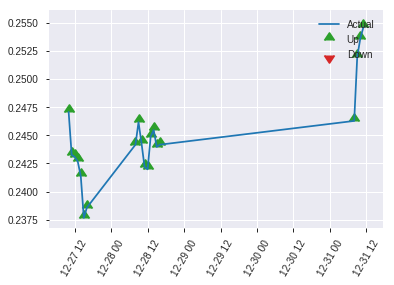


ModelMetricsBinomialGLM: glm
** Reported on test data. **

MSE: 0.25135207564897044
RMSE: 0.5013502524672452
LogLoss: 0.6958548161972192
Null degrees of freedom: 222
Residual degrees of freedom: -811
Null deviance: 309.1597919029809
Residual deviance: 310.35124802395967
AIC: 2378.3512480239597
AUC: 0.4638030888030888
pr_auc: 0.4847077738707101
Gini: -0.07239382239382242
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.45877246707242336: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      2    109  0.982    (109.0/111.0)
1      1    111  0.0089   (1.0/112.0)
Total  3    220  0.4933   (110.0/223.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.458772     0.668675  219
max f2                       0.440375     0.834575  222
max f0point5                 0.458772     0.559476  219
max accuracy                 0.529681     0.506726  1
max precision                0.533952     1         0
max recall                   0.440375     1         222
max specificity              0.533952     1         0
max absolute_mcc             0.494159     0.103065  108
max min_per_class_accuracy   0.493954     0.459459  111
max mean_per_class_accuracy  0.529681     0.508929  1

Gains/Lift Table: Avg response rate: 50.22 %, avg score: 49.32 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain       cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  ---------  -----------------
    1        0.0134529                   0.5292             1.32738   1.32738            0.666667         0.530954  0.666667                    0.530954            0.0178571       0.0178571                  32.7381    32.7381
    2        0.0224215                   0.525875           0.995536  1.19464            0.5              0.527763  0.6                         0.529678            0.00892857      0.0267857                  -0.446429  19.4643
    3        0.0313901                   0.524809           0.995536  1.13776            0.5              0.525144  0.571429                    0.528382            0.00892857      0.0357143                  -0.446429  13.7755
    4        0.0403587                   0.523917           0         0.884921           0                0.524479  0.444444                    0.527515            0               0.0357143                  -100       -11.5079
    5        0.0538117                   0.521235           1.32738   0.995536           0.666667         0.522418  0.5                         0.526241            0.0178571       0.0535714                  32.7381    -0.446429
    6        0.103139                    0.515548           0.905032  0.952252           0.454545         0.518024  0.478261                    0.522311            0.0446429       0.0982143                  -9.49675   -4.77484
    7        0.152466                    0.51356            1.26705   1.0541             0.636364         0.51472   0.529412                    0.519855            0.0625          0.160714                   26.7045    5.40966
    8        0.201794                    0.508764           0.543019  0.929167           0.272727         0.51077   0.466667                    0.517634            0.0267857       0.1875                     -45.6981   -7.08333
    9        0.300448                    0.503381           1.08604   0.980677           0.545455         0.506068  0.492537                    0.513836            0.107143        0.294643                   8.6039     -1.9323
    10       0.399103                    0.498627           0.633523  0.894864           0.318182         0.501225  0.449438                    0.510719            0.0625          0.357143                   -36.6477   -10.5136
    11       0.502242                    0.493954           1.03882   0.924426           0.521739         0.495838  0.464286                    0.507663            0.107143        0.464286                   3.88199    -7.5574
    12       0.600897                    0.488893           1.08604   0.950959           0.545455         0.49174   0.477612                    0.505049            0.107143        0.571429                   8.6039     -4.90405
    13       0.699552                    0.483662           0.995536  0.957246           0.5              0.486133  0.480769                    0.502381            0.0982143       0.669643                   -0.446429  -4.27541
    14       0.798206                    0.476731           1.08604   0.973164           0.545455         0.480644  0.488764                    0.499695            0.107143        0.776786                   8.6039     -2.68359
    15       0.896861                    0.468237           1.17654   0.995536           0.590909         0.473366  0.5                         0.496798            0.116071        0.892857                   17.6542    -0.446429
    16       1                           0.440375           1.03882   1                  0.521739         0.462358  0.502242         

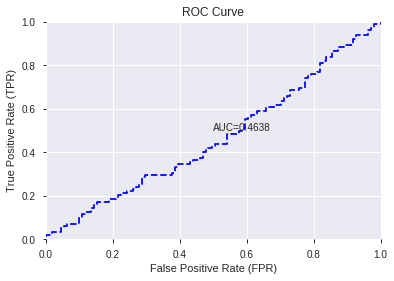

/usr/local/lib/python3.6/dist-packages/matplotlib/cbook/__init__.py:424: MatplotlibDeprecationWarning: 
Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warn_deprecated("2.2", "Passing one of 'on', 'true', 'off', 'false' as a "


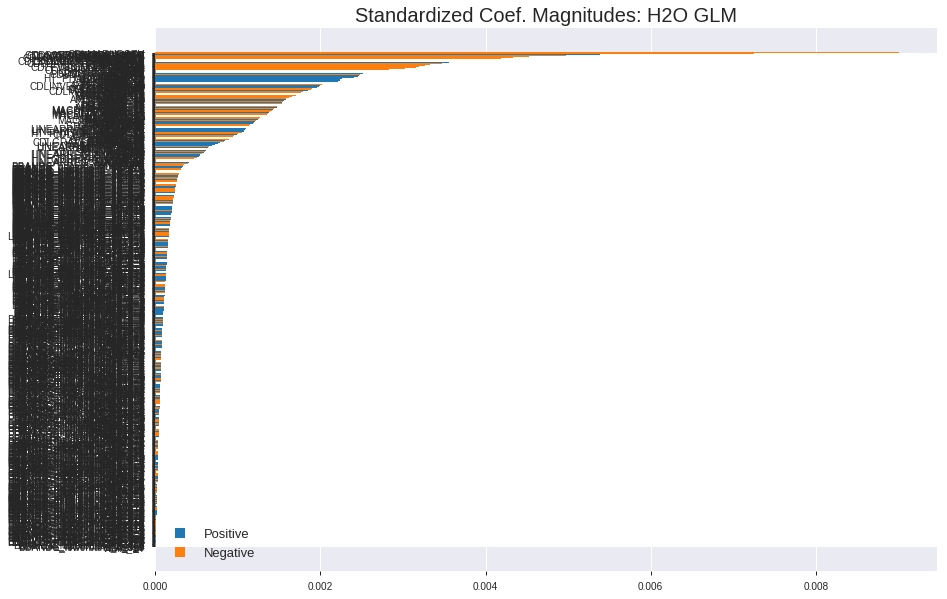

'log_likelihood'
--2019-08-27 21:30:23--  https://h2o-release.s3.amazonaws.com/h2o/rel-yates/5/h2o-3.24.0.5.zip
Resolving h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)... 52.216.128.235
Connecting to h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)|52.216.128.235|:443... connected.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.

Archive:  h2o-3.24.0.5.zip
ERROR: Unknown MOJO type


[{'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Models/GLM_grid_1_AutoML_20190827_212945_model_1',
   '__meta': {'schema_name': 'ModelKeyV3',
    'schema_type': 'Key<Model>',
    'schema_version': 3},
   'name': 'GLM_grid_1_AutoML_20190827_212945_model_1',
   'type': 'Key<Model>'},
  'default_value': None,
  'gridable': False,
  'help': 'Destination id for this model; auto-generated if not specified.',
  'is_member_of_frames': [],
  'is_mutually_exclusive_with': [],
  'label': 'model_id',
  'level': 'critical',
  'name': 'model_id',
  'required': False,
  'type': 'Key<Model>',
  'values': []},
 {'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Frames/automl_training_py_34_sid_a8e7',
   '__meta': {'schema_name': 'FrameKeyV3',
    'schema_type': 'Key<Frame>',
    'schema_version': 3},
   'name': 'automl_training_py_34_s

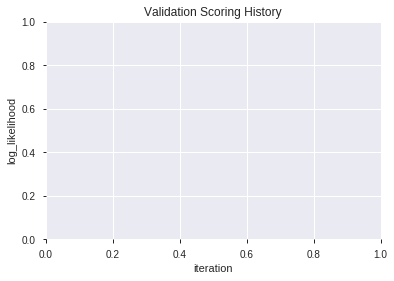

In [15]:
# GLM
glm_features = model_train(feature_name='All',model_algo="GLM")

In [16]:
# DeepLearning with top GLM features
model_train(feature_name='GLMF',model_algo="DeepLearning",features_list = features_list[:model_selected_features])

[]

In [17]:
# GLM with top GLM features
model_train(feature_name='GLMF',model_algo="GLM",features_list = features_list[:model_selected_features])

[]

In [18]:
# XGBoost with top GLM features
model_train(feature_name='GLMF',model_algo="XGBoost",features_list = features_list[:model_selected_features])

[]

AutoML progress: |████████████████████████████████████████████████████████| 100%


model_id       auc   logloss  mean_per_class_error      rmse       mse
0  XGBoost_grid_1_AutoML_20190827_213029_model_2  0.580840  0.685247              0.500000  0.496043  0.246059
1               XGBoost_3_AutoML_20190827_213029  0.577301  0.683530              0.490991  0.495214  0.245237
2  XGBoost_grid_1_AutoML_20190827_213029_model_1  0.562661  0.686133              0.423102  0.496624  0.246636
3  XGBoost_grid_1_AutoML_20190827_213029_model_6  0.556548  0.693945              0.500000  0.500384  0.250384
4               XGBoost_2_AutoML_20190827_213029  0.552365  0.690473              0.436535  0.498594  0.248596
5  XGBoost_grid_1_AutoML_20190827_213029_model_4  0.533301  0.691701              0.486446  0.499268  0.249269
6               XGBoost_1_AutoML_20190827_213029  0.530245  0.703375              0.477357  0.504770  0.254793
7  XGBoost_grid_1_AutoML_20190827_213029_model_3  0.522281  0.700420              0.490991  0.503484  0.253496
8  XGBoost_grid_1_AutoML_20190827_213029_model_7  0.514157  0.709515              0.500000  0.507433  0.257489
9  XGBoost_grid_1_AutoML_20190827_213029_model_5  0.501046  0.720587              0.490911  0.512524  0.262680

variable  relative_importance  scaled_importance  percentage
0                STOCH_slowk           147.525299           1.000000    0.024573
1                        DIV           136.197693           0.923216    0.022686
2                     BETA_8           124.451866           0.843597    0.020730
3                       hour           121.882675           0.826182    0.020302
4                        BOP           120.121437           0.814243    0.020008
..                       ...                  ...                ...         ...
283  BBANDS_lowerband_14_6_4             0.403030           0.002732    0.000067
284   BBANDS_lowerband_8_6_5             0.317564           0.002153    0.000053
285  BBANDS_upperband_12_7_5             0.282954           0.001918    0.000047
286   BBANDS_upperband_8_0_3             0.258486           0.001752    0.000043
287   BBANDS_lowerband_8_7_2             0.178977           0.001213    0.000030

[288 rows x 4 columns]

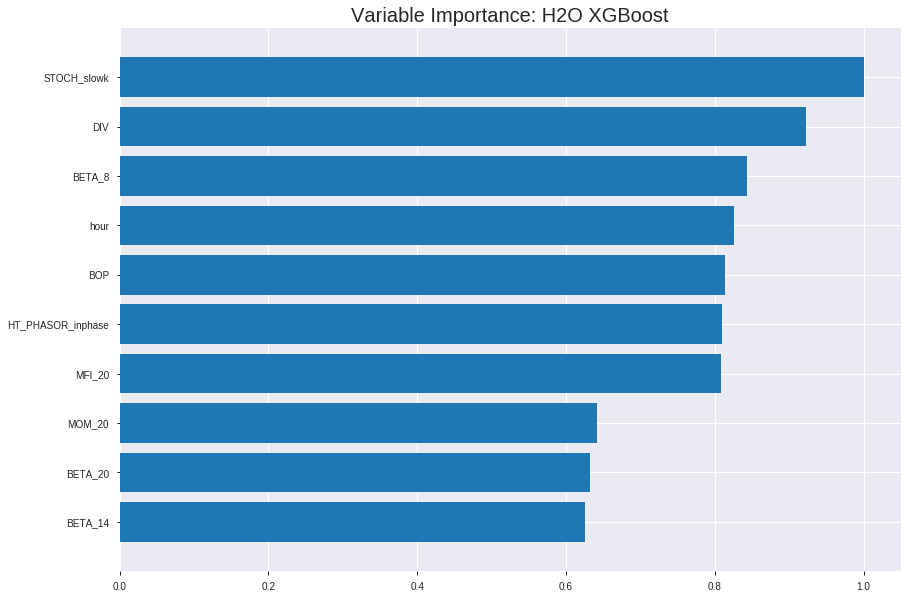

Model Details
H2OXGBoostEstimator :  XGBoost
Model Key:  XGBoost_grid_1_AutoML_20190827_213029_model_2


ModelMetricsBinomial: xgboost
** Reported on train data. **

MSE: 0.1767559671598821
RMSE: 0.42042355685651356
LogLoss: 0.5431420175225887
Mean Per-Class Error: 0.1025600461418037
AUC: 0.960248836155399
pr_auc: 0.9592023689309849
Gini: 0.920497672310798
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.4903517812490463: 


0    1    Error    Rate
-----  ---  ---  -------  --------------
0      682  101  0.129    (101.0/783.0)
1      59   716  0.0761   (59.0/775.0)
Total  741  817  0.1027   (160.0/1558.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.490352     0.899497  204
max f2                       0.44816      0.927193  243
max f0point5                 0.528436     0.911208  168
max accuracy                 0.491188     0.897304  203
max precision                0.750754     1         0
max recall                   0.369227     1         323
max specificity              0.750754     1         0
max absolute_mcc             0.490352     0.795817  204
max min_per_class_accuracy   0.500751     0.888889  193
max mean_per_class_accuracy  0.490352     0.89744   204

Gains/Lift Table: Avg response rate: 49.74 %, avg score: 49.89 %



group    cumulative_data_fraction    lower_threshold    lift       cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  ---------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0102696                   0.703919           2.01032    2.01032            1                0.724368  1                           0.724368            0.0206452       0.0206452                  101.032   101.032
    2        0.0205392                   0.686479           2.01032    2.01032            1                0.694376  1                           0.709372            0.0206452       0.0412903                  101.032   101.032
    3        0.0301669                   0.679647           2.01032    2.01032            1                0.683468  1                           0.701105            0.0193548       0.0606452                  101.032   101.032
    4        0.0404365                   0.673643           2.01032    2.01032            1                0.67621   1                           0.694782            0.0206452       0.0812903                  101.032   101.032
    5        0.0500642                   0.66665            2.01032    2.01032            1                0.670661  1                           0.690144            0.0193548       0.100645                   101.032   101.032
    6        0.100128                    0.641614           2.01032    2.01032            1                0.65395   1                           0.672047            0.100645        0.20129                    101.032   101.032
    7        0.150193                    0.622301           1.98455    2.00173            0.987179         0.629946  0.995726                    0.658013            0.0993548       0.300645                   98.4549   100.173
    8        0.200257                    0.600695           1.95878    1.99099            0.974359         0.611247  0.990385                    0.646322            0.0980645       0.39871                    95.8776   99.0993
    9        0.300385                    0.572774           1.90723    1.96307            0.948718         0.586729  0.976496                    0.626457            0.190968        0.589677                   90.7229   96.3071
    10       0.399872                    0.540109           1.7639     1.91352            0.877419         0.556665  0.951846                    0.609093            0.175484        0.765161                   76.3896   91.3517
    11       0.5                         0.49981            1.26289    1.78323            0.628205         0.519087  0.887035                    0.591069            0.126452        0.891613                   26.2895   78.3226
    12       0.600128                    0.459728           0.682994   1.59966            0.339744         0.479662  0.795722                    0.572481            0.0683871       0.96                       -31.7006  59.9658
    13       0.699615                    0.429227           0.272366   1.41091            0.135484         0.443769  0.701835                    0.554178            0.0270968       0.987097                   -72.7634  41.0914
    14       0.799743                    0.394618           0.0902068  1.24556            0.0448718        0.411566  0.619583                    0.536323            0.00903226      0.996129                   -90.9793  24.5561
    15       0.899872                    0.353379           0.03866    1.11127            0.0192308        0.373222  0.552782                    0.518175            0.00387097      1                          -96.134   11.127
    16       1                           0.260092           0          1                  0                0.325577  0.497433                    



ModelMetricsBinomial: xgboost
** Reported on validation data. **

MSE: 0.2598380537009911
RMSE: 0.5097431252120926
LogLoss: 0.7132085547688884
Mean Per-Class Error: 0.4943696425683325
AUC: 0.4569383794274624
pr_auc: 0.4885543282370441
Gini: -0.08612324114507519
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.3559393584728241: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      2    214  0.9907   (214.0/216.0)
1      0    229  0        (0.0/229.0)
Total  2    443  0.4809   (214.0/445.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.355939     0.681548  397
max f2                       0.355939     0.842531  397
max f0point5                 0.355939     0.572214  397
max accuracy                 0.355939     0.519101  397
max precision                0.613084     0.588235  16
max recall                   0.355939     1         397
max specificity              0.668801     0.99537   0
max absolute_mcc             0.432758     0.138536  324
max min_per_class_accuracy   0.504308     0.472222  197
max mean_per_class_accuracy  0.613084     0.50563   16

Gains/Lift Table: Avg response rate: 51.46 %, avg score: 49.98 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain       cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  ---------  -----------------
    1        0.011236                    0.64607            0.777293  0.777293           0.4              0.652856  0.4                         0.652856            0.00873362      0.00873362                 -22.2707   -22.2707
    2        0.0202247                   0.637701           0.971616  0.863658           0.5              0.64313   0.444444                    0.648534            0.00873362      0.0174672                  -2.83843   -13.6342
    3        0.0314607                   0.620483           1.16594   0.971616           0.6              0.6276    0.5                         0.641057            0.0131004       0.0305677                  16.5939    -2.83843
    4        0.0404494                   0.612015           1.45742   1.07957            0.75             0.616034  0.555556                    0.635497            0.0131004       0.0436681                  45.7424    7.9573
    5        0.0516854                   0.607975           0.388646  0.929372           0.2              0.610541  0.478261                    0.630072            0.00436681      0.0480349                  -61.1354   -7.06284
    6        0.101124                    0.586534           0.794958  0.863658           0.409091         0.596299  0.444444                    0.613561            0.0393013       0.0873362                  -20.5042   -13.6342
    7        0.150562                    0.567162           0.971616  0.899107           0.5              0.576109  0.462687                    0.601263            0.0480349       0.135371                   -2.83843   -10.0893
    8        0.2                         0.557692           1.2366    0.982533           0.636364         0.5619    0.505618                    0.591533            0.0611354       0.196507                   23.6602    -1.74672
    9        0.301124                    0.537414           0.906841  0.957114           0.466667         0.547555  0.492537                    0.576764            0.0917031       0.28821                    -9.31587   -4.2886
    10       0.4                         0.517823           1.01578   0.971616           0.522727         0.527407  0.5                         0.564564            0.100437        0.388646                   1.57801    -2.83843
    11       0.501124                    0.504293           0.863658  0.949831           0.444444         0.510839  0.488789                    0.553722            0.0873362       0.475983                   -13.6342   -5.01694
    12       0.6                         0.484687           0.971616  0.953421           0.5              0.495926  0.490637                    0.544198            0.0960699       0.572052                   -2.83843   -4.65793
    13       0.698876                    0.461798           0.794958  0.931002           0.409091         0.473766  0.4791                      0.534233            0.0786026       0.650655                   -20.5042   -6.89984
    14       0.8                         0.437602           0.993207  0.938865           0.511111         0.448321  0.483146                    0.523374            0.100437        0.751092                   -0.679282  -6.11354
    15       0.898876                    0.410226           1.2366    0.971616           0.636364         0.425508  0.5                         0.512608            0.122271        0.873362                   23.6602    -2.83843
    16       1                           0.34997            1.2523    1                  0.644444         0.38634   0.514607        


Scoring History: 


timestamp            duration    number_of_trees    training_rmse    training_logloss    training_auc    training_pr_auc    training_lift    training_classification_error    validation_rmse    validation_logloss    validation_auc    validation_pr_auc    validation_lift    validation_classification_error
--  -------------------  ----------  -----------------  ---------------  ------------------  --------------  -----------------  ---------------  -------------------------------  -----------------  --------------------  ----------------  -------------------  -----------------  ---------------------------------
    2019-08-27 21:30:49  3.311 sec   0                  0.5              0.693147            0.5             0                  1                0.502567                         0.5                0.693147              0.5               0                    1                  0.485393
    2019-08-27 21:30:50  4.387 sec   5                  0.489857         0.673045            0.791642        0.751833           1.52507          0.293325                         0.502604           0.698374              0.420124          0.46635              1.16594            0.485393
    2019-08-27 21:30:50  4.639 sec   10                 0.480723         0.655222            0.84706         0.832585           1.88468          0.251605                         0.502673           0.698518              0.443312          0.473801             0.388646           0.483146
    2019-08-27 21:30:50  4.889 sec   15                 0.471894         0.638213            0.873874        0.864879           2.01032          0.20154                          0.503747           0.700694              0.445738          0.477737             0.777293           0.480899
    2019-08-27 21:30:50  5.125 sec   20                 0.463452         0.622153            0.896908        0.894218           2.01032          0.186778                         0.504671           0.702584              0.449428          0.47703              0.388646           0.480899
    2019-08-27 21:30:51  5.363 sec   25                 0.455054         0.606363            0.913678        0.913109           2.01032          0.160462                         0.505465           0.704209              0.451682          0.481871             0.777293           0.480899
    2019-08-27 21:30:51  5.598 sec   30                 0.447441         0.592185            0.925702        0.925152           2.01032          0.158537                         0.507069           0.707528              0.448478          0.474571             0.388646           0.476404
    2019-08-27 21:30:51  5.856 sec   35                 0.440132         0.578757            0.937564        0.937307           2.01032          0.144416                         0.506901           0.707226              0.461386          0.481628             0.388646           0.480899
    2019-08-27 21:30:51  6.098 sec   40                 0.433122         0.566008            0.948088        0.948452           2.01032          0.130937                         0.507395           0.708271              0.463398          0.4897               0.777293           0.483146
    2019-08-27 21:30:52  6.341 sec   45                 0.427105         0.555096            0.953546        0.953443           2.01032          0.113607                         0.508741           0.711088              0.457171          0.486363             0.388646           0.483146
    2019-08-27 21:30:52  6.588 sec   50                 0.420424         0.543142            0.960249        0.959202           2.01032          0.102696                         0.509743           0.713209              0.456938          0.488554             0.777293           0.480899

Variable Importances: 


variable                 relative_importance    scaled_importance      percentage
-----------------------  ---------------------  ---------------------  ----------------------
STOCH_slowk              147.52529907226562     1.0                    0.02457310282633292
DIV                      136.19769287109375     0.9232158397752306     0.02268627776169604
BETA_8                   124.45186614990234     0.8435967724352099     0.02072979023301299
hour                     121.88267517089844     0.8261815155595374     0.020301843335060087
BOP                      120.1214370727539      0.8142429659736675     0.02000847612848923
---                      ---                    ---                    ---
BBANDS_lowerband_14_6_4  0.4030301570892334     0.0027319392648159154  6.713222446961785e-05
BBANDS_lowerband_8_6_5   0.3175641596317291     0.0021526081399514366  5.289626116782791e-05
BBANDS_upperband_12_7_5  0.2829543352127075     0.0019180055013757447  4.713134640677841e-05
BBANDS_upperband_8_0_3   0.25848570466041565    0.0017521449289439894  4.3055637505578445e-05
BBANDS_lowerband_8_7_2   0.17897723615169525    0.0012131969043765356  2.98120122798334e-05


See the whole table with table.as_data_frame()


/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:7116: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


('accuracy', 0.5829596412556054)

('F1', 0.6686567164179104)

('auc', 0.5808397683397684)

('logloss', 0.6852474783730368)

('mean_per_class_error', 0.41622425997426005)

('rmse', 0.49604324093545177)

('mse', 0.24605889687774668)

xgboost prediction progress: |████████████████████████████████████████████| 100%


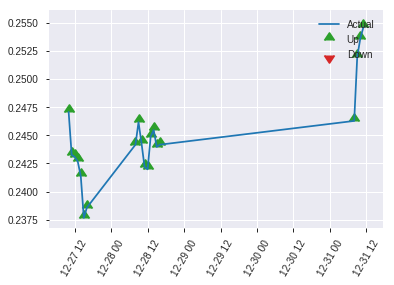


ModelMetricsBinomial: xgboost
** Reported on test data. **

MSE: 0.24605889687774668
RMSE: 0.49604324093545177
LogLoss: 0.6852474783730368
Mean Per-Class Error: 0.41622425997426005
AUC: 0.5808397683397684
pr_auc: 0.5771076368137525
Gini: 0.16167953667953672
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.37471964955329895: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      0    111  1        (111.0/111.0)
1      0    112  0        (0.0/112.0)
Total  0    223  0.4978   (111.0/223.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.37472      0.668657  222
max f2                       0.37472      0.834575  222
max f0point5                 0.486016     0.587432  154
max accuracy                 0.53495      0.58296   70
max precision                0.632385     1         0
max recall                   0.37472      1         222
max specificity              0.632385     1         0
max absolute_mcc             0.53495      0.179832  70
max min_per_class_accuracy   0.510976     0.558559  111
max mean_per_class_accuracy  0.53495      0.583776  70

Gains/Lift Table: Avg response rate: 50.22 %, avg score: 50.83 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain       cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  ---------  -----------------
    1        0.0134529                   0.623973           1.99107   1.99107            1                0.628764  1                           0.628764            0.0267857       0.0267857                  99.1071    99.1071
    2        0.0224215                   0.609052           1.99107   1.99107            1                0.616991  1                           0.624055            0.0178571       0.0446429                  99.1071    99.1071
    3        0.0313901                   0.599037           0.995536  1.70663            0.5              0.601055  0.857143                    0.617483            0.00892857      0.0535714                  -0.446429  70.6633
    4        0.0403587                   0.594421           0.995536  1.54861            0.5              0.598085  0.777778                    0.613173            0.00892857      0.0625                     -0.446429  54.8611
    5        0.0538117                   0.588629           0         1.16146            0                0.590946  0.583333                    0.607616            0               0.0625                     -100       16.1458
    6        0.103139                    0.574921           1.08604   1.12539            0.545455         0.580915  0.565217                    0.594846            0.0535714       0.116071                   8.6039     12.5388
    7        0.152466                    0.558882           1.26705   1.17122            0.636364         0.565764  0.588235                    0.585437            0.0625          0.178571                   26.7045    17.1218
    8        0.201794                    0.552615           1.08604   1.1504             0.545455         0.556118  0.577778                    0.57827             0.0535714       0.232143                   8.6039     15.0397
    9        0.300448                    0.536893           1.35755   1.21842            0.681818         0.544945  0.61194                     0.567328            0.133929        0.366071                   35.7549    21.8417
    10       0.399103                    0.521984           0.905032  1.14095            0.454545         0.530739  0.573034                    0.558283            0.0892857       0.455357                   -9.49675   14.0951
    11       0.502242                    0.510976           1.03882   1.11998            0.521739         0.515756  0.5625                      0.54955             0.107143        0.5625                     3.88199    11.9978
    12       0.600897                    0.499635           0.905032  1.08469            0.454545         0.503826  0.544776                    0.542043            0.0892857       0.651786                   -9.49675   8.46882
    13       0.699552                    0.4837             1.17654   1.09764            0.590909         0.492913  0.551282                    0.535114            0.116071        0.767857                   17.6542    9.76419
    14       0.798206                    0.460895           0.814529  1.06265            0.409091         0.47575   0.533708                    0.527777            0.0803571       0.848214                   -18.5471   6.26505
    15       0.896861                    0.439539           0.633523  1.01545            0.318182         0.450262  0.51                        0.519251            0.0625          0.910714                   -36.6477   1.54464
    16       1                           0.37472            0.865683  1                  0.434783         0.412678  0.502242                    

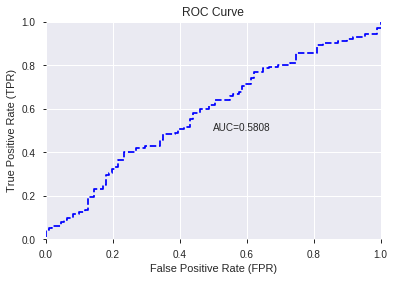

This function is available for GLM models only


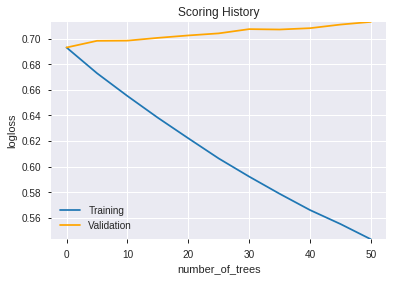

--2019-08-27 21:31:23--  https://h2o-release.s3.amazonaws.com/h2o/rel-yates/5/h2o-3.24.0.5.zip
Resolving h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)... 52.216.9.131
Connecting to h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)|52.216.9.131|:443... connected.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.

Archive:  h2o-3.24.0.5.zip
Exception in thread "main" java.lang.StackOverflowError
	at hex.genmodel.algos.tree.SharedTreeNode.findInclusiveNa(SharedTreeNode.java:129)
	at hex.genmodel.algos.tree.SharedTreeNode.findInclusiveNa(SharedTreeNode.java:129)
	at hex.genmodel.algos.tree.SharedTreeNode.calculateChildInclusiveNa(SharedTreeNode.java:133)
	at hex.genmodel.algos.tree.SharedTreeNode.setLeftChild(SharedTreeNode.java:207)
	at hex.genmodel.algos.tree.SharedTreeSubgraph.makeLeftEdge(SharedTreeSubgraph.java:82)
	at hex.genmodel.algos.tree.SharedTreeSubgraph.makeLeftChildNode(

[{'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Models/XGBoost_grid_1_AutoML_20190827_213029_model_2',
   '__meta': {'schema_name': 'ModelKeyV3',
    'schema_type': 'Key<Model>',
    'schema_version': 3},
   'name': 'XGBoost_grid_1_AutoML_20190827_213029_model_2',
   'type': 'Key<Model>'},
  'default_value': None,
  'gridable': False,
  'help': 'Destination id for this model; auto-generated if not specified.',
  'is_member_of_frames': [],
  'is_mutually_exclusive_with': [],
  'label': 'model_id',
  'level': 'critical',
  'name': 'model_id',
  'required': False,
  'type': 'Key<Model>',
  'values': []},
 {'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Frames/automl_training_py_42_sid_a8e7',
   '__meta': {'schema_name': 'FrameKeyV3',
    'schema_type': 'Key<Frame>',
    'schema_version': 3},
   'name': 'automl_training

In [19]:
# XGBoost
xgb_features = model_train(feature_name='All',model_algo="XGBoost")

AutoML progress: |████████████████████████████████████████████████████████| 100%


model_id       auc   logloss  mean_per_class_error      rmse       mse
0               DeepLearning_1_AutoML_20190827_213129  0.575209  0.715141              0.486406  0.507800  0.257861
1  DeepLearning_grid_1_AutoML_20190827_213129_model_7  0.561454  0.713398              0.459299  0.508452  0.258524
2  DeepLearning_grid_1_AutoML_20190827_213129_model_8  0.557593  0.680811              0.432191  0.493884  0.243922
3  DeepLearning_grid_1_AutoML_20190827_213129_model_5  0.552687  0.696096              0.486446  0.501366  0.251368
4  DeepLearning_grid_1_AutoML_20190827_213129_model_6  0.546573  0.702793              0.463924  0.504404  0.254424
5  DeepLearning_grid_1_AutoML_20190827_213129_model_2  0.519707  0.774078              0.459419  0.532351  0.283398
6  DeepLearning_grid_1_AutoML_20190827_213129_model_9  0.511342  0.693073              0.495495  0.499963  0.249963
7  DeepLearning_grid_1_AutoML_20190827_213129_model_4  0.511261  0.961894              0.490911  0.571373  0.326467
8  DeepLearning_grid_1_AutoML_20190827_213129_model_1  0.499598  0.839148              0.477437  0.547475  0.299729
9  DeepLearning_grid_1_AutoML_20190827_213129_model_3  0.499115  0.796220              0.468388  0.536943  0.288308

variable  relative_importance  scaled_importance  percentage
0                  DX_12             1.000000           1.000000    0.029870
1    CDLGAPSIDESIDEWHITE             0.868111           0.868111    0.025930
2           STOCHF_fastk             0.852109           0.852109    0.025452
3              CORREL_14             0.803625           0.803625    0.024004
4                    day             0.802072           0.802072    0.023958
5           aroondown_24             0.784168           0.784168    0.023423
6     CDLMORNINGDOJISTAR             0.777864           0.777864    0.023235
7         is_month_start             0.775672           0.775672    0.023169
8          days_in_month             0.769700           0.769700    0.022991
9                    BOP             0.757621           0.757621    0.022630
10     CDLSTALLEDPATTERN             0.757240           0.757240    0.022619
11               BETA_20             0.752073           0.752073    0.022464
12                ADX_24             0.746860           0.746860    0.022308
13               weekday             0.746327           0.746327    0.022293
14          weekday_name             0.733249           0.733249    0.021902
15               BETA_14             0.731861           0.731861    0.021860
16               BETA_12             0.729662           0.729662    0.021795
17            aroonup_12             0.727435           0.727435    0.021728
18           aroondown_8             0.725138           0.725138    0.021660
19               CDLDOJI             0.716568           0.716568    0.021404
20          HT_TRENDMODE             0.709673           0.709673    0.021198
21             dayofweek             0.707588           0.707588    0.021135
22            aroonup_24             0.703004           0.703004    0.020999
23          aroondown_14             0.699207           0.699207    0.020885
24              CORREL_8             0.696676           0.696676    0.020810
25                Volume             0.690836           0.690836    0.020635
26                  DX_8             0.688487           0.688487    0.020565
27          aroondown_12             0.677381           0.677381    0.020233
28        STOCHRSI_fastd             0.660278           0.660278    0.019722
29            aroonup_30             0.659504           0.659504    0.019699
30             aroonup_8             0.651959           0.651959    0.019474
31         CDLHANGINGMAN             0.640492           0.640492    0.019131
32           STOCH_slowd             0.629145           0.629145    0.018792
33             CORREL_12             0.628063           0.628063    0.018760
34     CDLDARKCLOUDCOVER             0.618575           0.618575    0.018477
35     CDLLONGLEGGEDDOJI             0.605613           0.605613    0.018089
36            aroonup_20             0.604625           0.604625    0.018060
37          aroondown_20             0.604308           0.604308    0.018050
38            aroonup_14             0.582525           0.582525    0.017400
39        CDLRICKSHAWMAN             0.578241           0.578241    0.017272
40  HT_PHASOR_quadrature             0.537183           0.537183    0.016045
41    CDLEVENINGDOJISTAR             0.519282           0.519282    0.015511
42           HT_DCPERIOD             0.518376           0.518376    0.015484
43                  hour             0.500909           0.500909    0.014962
44                SAREXT             0.493009           0.493009    0.014726
45          aroondown_30             0.490353           0.490353    0.014647
46        CDLMATCHINGLOW             0.490023           0.490023    0.014637
47                 ADX_8             0.476869           0.476869    0.014244
48            AROONOSC_8             0.460462           0.460462    0.013754
49        STOCHRSI_fastk             0.398749           0.398749    0.011911

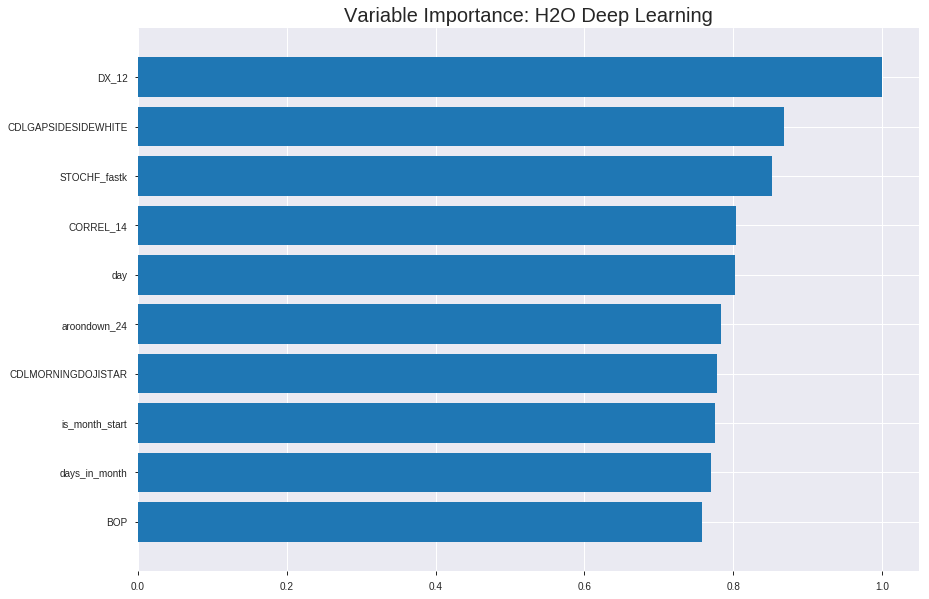

Model Details
H2ODeepLearningEstimator :  Deep Learning
Model Key:  DeepLearning_1_AutoML_20190827_213129


ModelMetricsBinomial: deeplearning
** Reported on train data. **

MSE: 0.23181834423799835
RMSE: 0.48147517510043897
LogLoss: 0.6581925280006984
Mean Per-Class Error: 0.37891072384954483
AUC: 0.6603683104684218
pr_auc: 0.6537976591931893
Gini: 0.32073662093684363
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.25543668311787987: 


0    1     Error    Rate
-----  ---  ----  -------  --------------
0      127  656   0.8378   (656.0/783.0)
1      35   740   0.0452   (35.0/775.0)
Total  162  1396  0.4435   (691.0/1558.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.255437     0.681713  333
max f2                       0.163302     0.836218  376
max f0point5                 0.421394     0.619459  224
max accuracy                 0.421394     0.620668  224
max precision                0.764637     0.904762  16
max recall                   0.110645     1         393
max specificity              0.999715     0.998723  0
max absolute_mcc             0.410416     0.247132  232
max min_per_class_accuracy   0.448339     0.605161  200
max mean_per_class_accuracy  0.421394     0.621089  224

Gains/Lift Table: Avg response rate: 49.74 %, avg score: 44.33 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0102696                   0.779549           1.75903   1.75903            0.875            0.842994  0.875                       0.842994            0.0180645       0.0180645                  75.9032   75.9032
    2        0.0205392                   0.738052           1.63339   1.69621            0.8125           0.753539  0.84375                     0.798267            0.0167742       0.0348387                  63.3387   69.621
    3        0.0301669                   0.722946           1.60826   1.66814            0.8              0.730931  0.829787                    0.776777            0.0154839       0.0503226                  60.8258   66.814
    4        0.0404365                   0.69915            2.01032   1.75504            1                0.712798  0.873016                    0.760528            0.0206452       0.0709677                  101.032   75.5044
    5        0.0500642                   0.67911            1.60826   1.72682            0.8              0.69202   0.858974                    0.747353            0.0154839       0.0864516                  60.8258   72.6816
    6        0.100128                    0.621794           1.52063   1.62372            0.75641          0.642301  0.807692                    0.694827            0.076129        0.162581                   52.0629   62.3722
    7        0.150193                    0.584267           1.10825   1.4519             0.551282         0.601096  0.722222                    0.663584            0.0554839       0.218065                   10.8255   45.19
    8        0.200257                    0.560428           1.13403   1.37243            0.564103         0.572333  0.682692                    0.640771            0.0567742       0.274839                   13.4028   37.2432
    9        0.300385                    0.513157           1.14691   1.29726            0.570513         0.536935  0.645299                    0.606159            0.114839        0.389677                   14.6915   29.7259
    10       0.399872                    0.479689           1.10243   1.24879            0.548387         0.495429  0.621188                    0.57861             0.109677        0.499355                   10.2435   24.8788
    11       0.5                         0.447383           1.06959   1.2129             0.532051         0.465306  0.603338                    0.55592             0.107097        0.606452                   6.95947   21.2903
    12       0.600128                    0.41299            1.13403   1.19974            0.564103         0.430789  0.596791                    0.535042            0.113548        0.72                       13.4028   19.9743
    13       0.699615                    0.368033           0.843039  1.14902            0.419355         0.391402  0.57156                     0.514617            0.083871        0.803871                   -15.6961  14.9019
    14       0.799743                    0.322785           0.798974  1.10519            0.397436         0.346713  0.549759                    0.493595            0.08            0.883871                   -20.1026  10.5193
    15       0.899872                    0.250043           0.734541  1.06395            0.365385         0.289175  0.529244                    0.470849            0.0735484       0.957419                   -26.5459  6.3951
    16       1                           0.0363638          0.425261  1                  0.211538         0.195254  0.497433                    0.443254            0.



ModelMetricsBinomial: deeplearning
** Reported on validation data. **

MSE: 0.2854407596252223
RMSE: 0.5342665623312227
LogLoss: 0.7971475345764832
Mean Per-Class Error: 0.4780850719715348
AUC: 0.49859493773249236
pr_auc: 0.5172144199634254
Gini: -0.0028101245350152793
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.10633863223035514: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      3    213  0.9861   (213.0/216.0)
1      0    229  0        (0.0/229.0)
Total  3    442  0.4787   (213.0/445.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value      idx
---------------------------  -----------  ---------  -----
max f1                       0.106339     0.682563   396
max f2                       0.106339     0.843152   396
max f0point5                 0.106339     0.57336    396
max accuracy                 0.405584     0.521348   199
max precision                0.67858      0.636364   10
max recall                   0.106339     1          396
max specificity              0.999213     0.99537    0
max absolute_mcc             0.106339     0.0848282  396
max min_per_class_accuracy   0.405584     0.515284   199
max mean_per_class_accuracy  0.588628     0.521915   40

Gains/Lift Table: Avg response rate: 51.46 %, avg score: 40.31 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain       cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  ---------  -----------------
    1        0.011236                    0.764013           0.388646  0.388646           0.2              0.890175  0.2                         0.890175            0.00436681      0.00436681                 -61.1354   -61.1354
    2        0.0202247                   0.685086           1.94323   1.07957            1                0.708866  0.555556                    0.809593            0.0174672       0.0218341                  94.3231    7.9573
    3        0.0314607                   0.672396           0.777293  0.971616           0.4              0.677445  0.5                         0.762398            0.00873362      0.0305677                  -22.2707   -2.83843
    4        0.0404494                   0.653296           1.45742   1.07957            0.75             0.664753  0.555556                    0.740699            0.0131004       0.0436681                  45.7424    7.9573
    5        0.0516854                   0.633433           1.16594   1.09835            0.6              0.639843  0.565217                    0.718774            0.0131004       0.0567686                  16.5939    9.83482
    6        0.101124                    0.582485           1.2366    1.16594            0.636364         0.605456  0.6                         0.663374            0.0611354       0.117904                   23.6602    16.5939
    7        0.150562                    0.551317           0.441644  0.928111           0.227273         0.567775  0.477612                    0.631983            0.0218341       0.139738                   -55.8356   -7.18895
    8        0.2                         0.522546           1.2366    1.00437            0.636364         0.538997  0.516854                    0.608998            0.0611354       0.200873                   23.6602    0.436681
    9        0.301124                    0.483617           0.993207  1.00062            0.511111         0.504285  0.514925                    0.573833            0.100437        0.30131                    -0.679282  0.0619175
    10       0.4                         0.432048           0.927451  0.982533           0.477273         0.456387  0.505618                    0.544801            0.0917031       0.393013                   -7.25486   -1.74672
    11       0.501124                    0.403566           1.20912   1.02826            0.622222         0.415741  0.529148                    0.518758            0.122271        0.515284                   20.9122    2.8257
    12       0.6                         0.363525           0.971616  1.01892            0.5              0.384019  0.524345                    0.496554            0.0960699       0.611354                   -2.83843   1.89229
    13       0.698876                    0.319812           0.927451  1.00598            0.477273         0.343724  0.517685                    0.474931            0.0917031       0.703057                   -7.25486   0.598155
    14       0.8                         0.28298            0.777293  0.977074           0.4              0.300404  0.502809                    0.45287             0.0786026       0.781659                   -22.2707   -2.29258
    15       0.898876                    0.203493           1.14827   0.995906           0.590909         0.248077  0.5125                      0.430343            0.113537        0.895197                   14.8273    -0.409389
    16       1                           0.0767807          1.03639   1                  0.533333         0.160803  0.514607            


Scoring History: 


timestamp            duration    training_speed    epochs    iterations    samples    training_rmse    training_logloss    training_r2    training_auc    training_pr_auc    training_lift    training_classification_error    validation_rmse    validation_logloss    validation_r2    validation_auc    validation_pr_auc    validation_lift    validation_classification_error
--  -------------------  ----------  ----------------  --------  ------------  ---------  ---------------  ------------------  -------------  --------------  -----------------  ---------------  -------------------------------  -----------------  --------------------  ---------------  ----------------  -------------------  -----------------  ---------------------------------
    2019-08-27 21:31:29  0.000 sec                     0         0             0          nan              nan                 nan            nan             nan                nan              nan                              nan                nan                   nan              nan               nan                  nan                nan
    2019-08-27 21:31:29  0.067 sec   86555 obs/sec     1         1             1558       0.52461          0.772622            -0.100891      0.546792        0.548945           1.50774          0.502567                         0.56745            0.944343              -0.2891          0.501668          0.504345             0.777293           0.480899
    2019-08-27 21:31:29  0.260 sec   80725 obs/sec     10        10            15580      0.481475         0.658193            0.0727022      0.660368        0.653798           1.75903          0.443517                         0.534267           0.797148              -0.142738        0.498595          0.517214             0.388646           0.478652

Variable Importances: 


variable             relative_importance    scaled_importance    percentage
-------------------  ---------------------  -------------------  --------------------
DX_12                1.0                    1.0                  0.029869696422224288
CDLGAPSIDESIDEWHITE  0.8681110739707947     0.8681110739707947   0.02593021424027873
STOCHF_fastk         0.852109432220459      0.852109432220459    0.025452250058939013
CORREL_14            0.8036245703697205     0.8036245703697205   0.02400402195438397
day                  0.8020715713500977     0.8020715713500977   0.023957634345123824
---                  ---                    ---                  ---
aroondown_30         0.49035295844078064    0.49035295844078064  0.014646694008365681
CDLMATCHINGLOW       0.4900234043598175     0.4900234043598175   0.014636850328012607
ADX_8                0.47686898708343506    0.47686898708343506  0.0142439318773558
AROONOSC_8           0.46046167612075806    0.46046167612075806  0.013753850479795606
STOCHRSI_fastk       0.39874887466430664    0.39874887466430664  0.011910507834926401


See the whole table with table.as_data_frame()


/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:7116: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


('accuracy', 0.5964125560538116)

('F1', 0.6707317073170733)

('auc', 0.5752091377091377)

('logloss', 0.7151408627976539)

('mean_per_class_error', 0.4028716216216216)

('rmse', 0.5078000404509427)

('mse', 0.25786088108197913)

deeplearning prediction progress: |███████████████████████████████████████| 100%


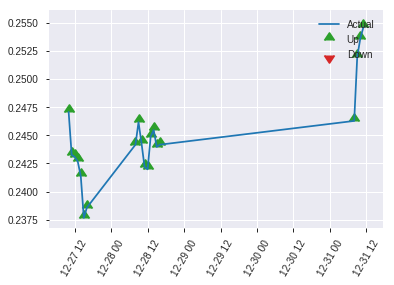


ModelMetricsBinomial: deeplearning
** Reported on test data. **

MSE: 0.25786088108197913
RMSE: 0.5078000404509427
LogLoss: 0.7151408627976539
Mean Per-Class Error: 0.4028716216216216
AUC: 0.5752091377091377
pr_auc: 0.572675845894948
Gini: 0.15041827541827546
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.16707773675460055: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      5    106  0.955    (106.0/111.0)
1      2    110  0.0179   (2.0/112.0)
Total  7    216  0.4843   (108.0/223.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.167078     0.670732  215
max f2                       0.0637021    0.835821  221
max f0point5                 0.466571     0.588942  75
max accuracy                 0.466571     0.596413  75
max precision                0.999899     1         0
max recall                   0.0637021    1         221
max specificity              0.999899     1         0
max absolute_mcc             0.466571     0.204919  75
max min_per_class_accuracy   0.426249     0.540541  111
max mean_per_class_accuracy  0.466571     0.597128  75

Gains/Lift Table: Avg response rate: 50.22 %, avg score: 42.08 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain       cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  ---------  -----------------
    1        0.0134529                   0.789732           1.32738   1.32738            0.666667         0.872675  0.666667                    0.872675            0.0178571       0.0178571                  32.7381    32.7381
    2        0.0224215                   0.73389            0         0.796429           0                0.7437    0.4                         0.821085            0               0.0178571                  -100       -20.3571
    3        0.0313901                   0.679623           1.99107   1.13776            1                0.713806  0.571429                    0.790434            0.0178571       0.0357143                  99.1071    13.7755
    4        0.0403587                   0.644501           0.995536  1.10615            0.5              0.666035  0.555556                    0.762789            0.00892857      0.0446429                  -0.446429  10.6151
    5        0.0538117                   0.602725           1.32738   1.16146            0.666667         0.622639  0.583333                    0.727752            0.0178571       0.0625                     32.7381    16.1458
    6        0.103139                    0.558947           1.62906   1.38509            0.818182         0.579201  0.695652                    0.656706            0.0803571       0.142857                   62.9058    38.5093
    7        0.152466                    0.538071           0.905032  1.22978            0.454545         0.544556  0.617647                    0.620422            0.0446429       0.1875                     -9.49675   22.9779
    8        0.201794                    0.517729           1.44805   1.28313            0.727273         0.526646  0.644444                    0.597499            0.0714286       0.258929                   44.8052    28.3135
    9        0.300448                    0.478984           1.08604   1.21842            0.545455         0.49459   0.61194                     0.563708            0.107143        0.366071                   8.6039     21.8417
    10       0.399103                    0.452381           1.08604   1.18569            0.545455         0.463691  0.595506                    0.538985            0.107143        0.473214                   8.6039     18.5694
    11       0.502242                    0.426249           0.692547  1.08442            0.347826         0.437745  0.544643                    0.518194            0.0714286       0.544643                   -30.7453   8.44228
    12       0.600897                    0.387939           0.905032  1.05497            0.454545         0.401671  0.529851                    0.499064            0.0892857       0.633929                   -9.49675   5.49707
    13       0.699552                    0.355948           0.905032  1.03383            0.454545         0.374378  0.519231                    0.48148             0.0892857       0.723214                   -9.49675   3.38255
    14       0.798206                    0.330073           0.814529  1.00672            0.409091         0.344101  0.505618                    0.4645              0.0803571       0.803571                   -18.5471   0.672151
    15       0.896861                    0.272887           0.995536  1.00549            0.5              0.298918  0.505                       0.446286            0.0982143       0.901786                   -0.446429  0.549107
    16       1                           0.0116577          0.952252  1                  0.478261         0.198741  0.502242                 

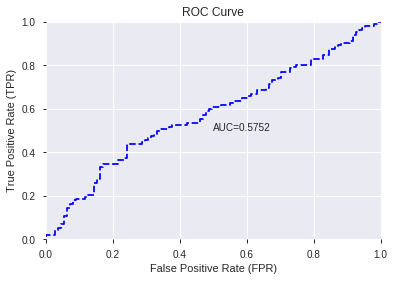

This function is available for GLM models only


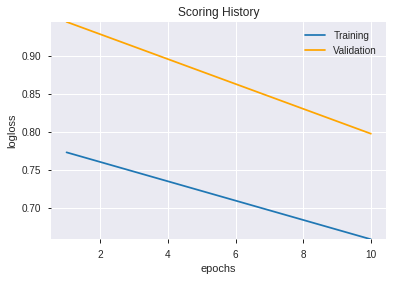

--2019-08-27 21:38:48--  https://h2o-release.s3.amazonaws.com/h2o/rel-yates/5/h2o-3.24.0.5.zip
Resolving h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)... 52.216.147.3
Connecting to h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)|52.216.147.3|:443... connected.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.

Archive:  h2o-3.24.0.5.zip
ERROR: Unknown MOJO type


[{'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Models/DeepLearning_1_AutoML_20190827_213129',
   '__meta': {'schema_name': 'ModelKeyV3',
    'schema_type': 'Key<Model>',
    'schema_version': 3},
   'name': 'DeepLearning_1_AutoML_20190827_213129',
   'type': 'Key<Model>'},
  'default_value': None,
  'gridable': False,
  'help': 'Destination id for this model; auto-generated if not specified.',
  'is_member_of_frames': [],
  'is_mutually_exclusive_with': [],
  'label': 'model_id',
  'level': 'critical',
  'name': 'model_id',
  'required': False,
  'type': 'Key<Model>',
  'values': []},
 {'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Frames/automl_training_py_50_sid_a8e7',
   '__meta': {'schema_name': 'FrameKeyV3',
    'schema_type': 'Key<Frame>',
    'schema_version': 3},
   'name': 'automl_training_py_50_sid_a8e7'

['DX_12',
 'CDLGAPSIDESIDEWHITE',
 'STOCHF_fastk',
 'CORREL_14',
 'day',
 'aroondown_24',
 'CDLMORNINGDOJISTAR',
 'is_month_start',
 'days_in_month',
 'BOP',
 'CDLSTALLEDPATTERN',
 'BETA_20',
 'ADX_24',
 'weekday',
 'weekday_name',
 'BETA_14',
 'BETA_12',
 'aroonup_12',
 'aroondown_8',
 'CDLDOJI',
 'HT_TRENDMODE',
 'dayofweek',
 'aroonup_24',
 'aroondown_14',
 'CORREL_8',
 'Volume',
 'DX_8',
 'aroondown_12',
 'STOCHRSI_fastd',
 'aroonup_30',
 'aroonup_8',
 'CDLHANGINGMAN',
 'STOCH_slowd',
 'CORREL_12',
 'CDLDARKCLOUDCOVER',
 'CDLLONGLEGGEDDOJI',
 'aroonup_20',
 'aroondown_20',
 'aroonup_14',
 'CDLRICKSHAWMAN',
 'HT_PHASOR_quadrature',
 'CDLEVENINGDOJISTAR',
 'HT_DCPERIOD',
 'hour',
 'SAREXT',
 'aroondown_30',
 'CDLMATCHINGLOW',
 'ADX_8',
 'AROONOSC_8',
 'STOCHRSI_fastk']

In [20]:
# DeepLearning with top XGBoost features
model_train(feature_name='XGBF',model_algo="DeepLearning",features_list = features_list[:model_selected_features])

AutoML progress: |████████████████████████████████████████████████████████| 100%


model_id      auc   logloss  mean_per_class_error      rmse       mse
0  GLM_grid_1_AutoML_20190827_213853_model_1  0.53314  0.692036              0.486486  0.499445  0.249445

variable  relative_importance  scaled_importance  percentage
0         is_month_start             0.022557           1.000000    0.075524
1                   hour             0.019699           0.873296    0.065955
2          CDLHANGINGMAN             0.015166           0.672359    0.050779
3    CDLGAPSIDESIDEWHITE             0.013241           0.587023    0.044334
4                 Volume             0.012071           0.535136    0.040416
5                 ADX_24             0.011937           0.529191    0.039967
6           HT_TRENDMODE             0.011613           0.514842    0.038883
7     CDLMORNINGDOJISTAR             0.010839           0.480507    0.036290
8         CDLRICKSHAWMAN             0.010655           0.472349    0.035674
9      CDLDARKCLOUDCOVER             0.008487           0.376240    0.028415
10     CDLLONGLEGGEDDOJI             0.008469           0.375454    0.028356
11               CDLDOJI             0.008465           0.375269    0.028342
12                 DX_12             0.008363           0.370757    0.028001
13                 ADX_8             0.008178           0.362555    0.027382
14                SAREXT             0.008061           0.357368    0.026990
15                   BOP             0.008054           0.357066    0.026967
16               BETA_20             0.007748           0.343499    0.025942
17               BETA_14             0.007730           0.342688    0.025881
18             CORREL_14             0.007588           0.336402    0.025406
19    CDLEVENINGDOJISTAR             0.007484           0.331777    0.025057
20            AROONOSC_8             0.006057           0.268502    0.020278
21           aroondown_8             0.005774           0.255993    0.019334
22          aroondown_12             0.005597           0.248123    0.018739
23              CORREL_8             0.005526           0.244973    0.018501
24            aroonup_20             0.005340           0.236719    0.017878
25             dayofweek             0.004761           0.211069    0.015941
26               weekday             0.004758           0.210934    0.015931
27             CORREL_12             0.004668           0.206946    0.015629
28             aroonup_8             0.004589           0.203422    0.015363
29        CDLMATCHINGLOW             0.003836           0.170074    0.012845
30           HT_DCPERIOD             0.003706           0.164297    0.012408
31  HT_PHASOR_quadrature             0.002823           0.125168    0.009453
32          aroondown_14             0.002633           0.116729    0.008816
33        STOCHRSI_fastd             0.002549           0.113011    0.008535
34          aroondown_20             0.002258           0.100084    0.007559
35               BETA_12             0.002230           0.098845    0.007465
36          aroondown_24             0.001653           0.073282    0.005535
37          aroondown_30             0.001627           0.072133    0.005448
38          weekday_name             0.001520           0.067394    0.005090
39        STOCHRSI_fastk             0.001417           0.062799    0.004743
40                   day             0.001390           0.061601    0.004652
41            aroonup_24             0.001333           0.059106    0.004464
42         days_in_month             0.001330           0.058944    0.004452
43          STOCHF_fastk             0.001329           0.058909    0.004449
44           STOCH_slowd             0.001162           0.051530    0.003892
45                  DX_8             0.001003           0.044479    0.003359
46            aroonup_12             0.000637           0.028252    0.002134
47            aroonup_14             0.000393           0.017434    0.001317
48     CDLSTALLEDPATTERN             0.000229           0.010141    0.000766
49            aroonup_30             0.000138           0.006134    0.000463

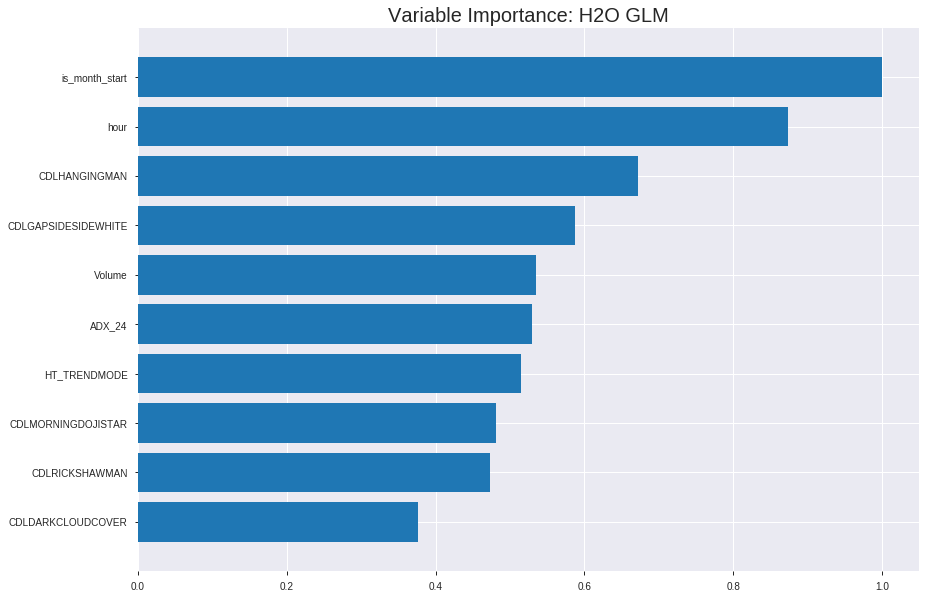

Model Details
H2OGeneralizedLinearEstimator :  Generalized Linear Modeling
Model Key:  GLM_grid_1_AutoML_20190827_213853_model_1


ModelMetricsBinomialGLM: glm
** Reported on train data. **

MSE: 0.247583277488749
RMSE: 0.49757740853936383
LogLoss: 0.6883039621451043
Null degrees of freedom: 1557
Residual degrees of freedom: 1507
Null deviance: 2159.8055361387533
Residual deviance: 2144.7551460441446
AIC: 2246.7551460441446
AUC: 0.5902830305277469
pr_auc: 0.5824114792113293
Gini: 0.18056606105549378
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.4570439395805673: 


0    1     Error    Rate
-----  ---  ----  -------  --------------
0      25   758   0.9681   (758.0/783.0)
1      4    771   0.0052   (4.0/775.0)
Total  29   1529  0.4891   (762.0/1558.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.457044     0.669271  375
max f2                       0.44391      0.833692  390
max f0point5                 0.487341     0.57313   266
max accuracy                 0.503117     0.56611   148
max precision                0.585054     1         0
max recall                   0.44391      1         390
max specificity              0.585054     1         0
max absolute_mcc             0.50767      0.136417  111
max min_per_class_accuracy   0.499007     0.56      181
max mean_per_class_accuracy  0.503117     0.565545  148

Gains/Lift Table: Avg response rate: 49.74 %, avg score: 49.74 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain       cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  ---------  -----------------
    1        0.0102696                   0.532846           1.75903   1.75903            0.875            0.552239  0.875                       0.552239            0.0180645       0.0180645                  75.9032    75.9032
    2        0.0205392                   0.524516           1.25645   1.50774            0.625            0.527531  0.75                        0.539885            0.0129032       0.0309677                  25.6452    50.7742
    3        0.0301669                   0.521475           1.07217   1.36873            0.533333         0.522828  0.680851                    0.534441            0.0103226       0.0412903                  7.2172     36.873
    4        0.0404365                   0.519477           0.753871  1.21258            0.375            0.5206    0.603175                    0.530926            0.00774194      0.0490323                  -24.6129   21.2576
    5        0.0500642                   0.518129           1.60826   1.28867            0.8              0.518869  0.641026                    0.528607            0.0154839       0.0645161                  60.8258    28.8668
    6        0.100128                    0.514654           1.39176   1.34022            0.692308         0.516378  0.666667                    0.522493            0.0696774       0.134194                   39.1762    34.0215
    7        0.150193                    0.512257           0.979388  1.21994            0.487179         0.513484  0.606838                    0.51949             0.0490323       0.183226                   -2.06121   21.9939
    8        0.200257                    0.509749           1.28867   1.23712            0.641026         0.510948  0.615385                    0.517354            0.0645161       0.247742                   28.8668    23.7122
    9        0.300385                    0.506372           1.09537   1.18987            0.544872         0.507916  0.59188                     0.514208            0.109677        0.357419                   9.53681    18.987
    10       0.399872                    0.502596           1.05056   1.15521            0.522581         0.504416  0.574639                    0.511772            0.104516        0.461935                   5.05557    15.5209
    11       0.5                         0.498925           0.992275  1.12258            0.49359          0.500808  0.558408                    0.509576            0.0993548       0.56129                    -0.772539  12.2581
    12       0.600128                    0.495158           1.01805   1.10514            0.50641          0.497173  0.549733                    0.507507            0.101935        0.663226                   1.8048     10.514
    13       0.699615                    0.490761           0.843039  1.06787            0.419355         0.492982  0.531193                    0.505442            0.083871        0.747097                   -15.6961   6.78686
    14       0.799743                    0.485916           1.01805   1.06163            0.50641          0.48849   0.52809                     0.503319            0.101935        0.849032                   1.8048     6.1631
    15       0.899872                    0.477723           0.708768  1.02237            0.352564         0.482168  0.508559                    0.500966            0.0709677       0.92                       -29.1232   2.2368
    16       1                           0.418781           0.798974  1                  0.397436         0.465679  0.497433                    0.497



ModelMetricsBinomialGLM: glm
** Reported on validation data. **

MSE: 0.24988460759320086
RMSE: 0.49988459427471943
LogLoss: 0.6929137860521772
Null degrees of freedom: 444
Residual degrees of freedom: 394
Null deviance: 617.0462294114567
Residual deviance: 616.6932695864377
AIC: 718.6932695864377
AUC: 0.5171943231441047
pr_auc: 0.5196955989436461
Gini: 0.03438864628820948
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.466543272978096: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      17   199  0.9213   (199.0/216.0)
1      8    221  0.0349   (8.0/229.0)
Total  25   420  0.4652   (207.0/445.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.466543     0.681048  374
max f2                       0.437596     0.841293  399
max f0point5                 0.481943     0.584665  297
max accuracy                 0.481943     0.557303  297
max precision                0.570892     1         0
max recall                   0.437596     1         399
max specificity              0.570892     1         0
max absolute_mcc             0.481943     0.115568  297
max min_per_class_accuracy   0.492613     0.490741  199
max mean_per_class_accuracy  0.481943     0.550026  297

Gains/Lift Table: Avg response rate: 51.46 %, avg score: 49.15 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.011236                    0.525218           1.55459   1.55459            0.8              0.537478  0.8                         0.537478            0.0174672       0.0174672                  55.4585   55.4585
    2        0.0202247                   0.520489           0         0.863658           0                0.523226  0.444444                    0.531144            0               0.0174672                  -100      -13.6342
    3        0.0314607                   0.517914           0.777293  0.832813           0.4              0.519525  0.428571                    0.526994            0.00873362      0.0262009                  -22.2707  -16.7187
    4        0.0404494                   0.515802           1.45742   0.971616           0.75             0.516878  0.5                         0.524746            0.0131004       0.0393013                  45.7424   -2.83843
    5        0.0516854                   0.513705           1.55459   1.09835            0.8              0.514503  0.565217                    0.522519            0.0174672       0.0567686                  55.4585   9.83482
    6        0.101124                    0.507498           0.883287  0.993207           0.454545         0.510399  0.511111                    0.516594            0.0436681       0.100437                   -11.6713  -0.679282
    7        0.150562                    0.505508           0.883287  0.957114           0.454545         0.506388  0.492537                    0.513242            0.0436681       0.144105                   -11.6713  -4.2886
    8        0.2                         0.503128           1.32493   1.04803            0.681818         0.504549  0.539326                    0.511094            0.0655022       0.209607                   32.4931   4.80349
    9        0.301124                    0.499695           1.03639   1.04412            0.533333         0.501648  0.537313                    0.507921            0.104803        0.31441                    3.63901   4.41244
    10       0.4                         0.496147           0.662465  0.949782           0.340909         0.497775  0.488764                    0.505413            0.0655022       0.379913                   -33.7535  -5.02183
    11       0.501124                    0.492613           1.12276   0.984687           0.577778         0.494241  0.506726                    0.503159            0.113537        0.49345                    12.2756   -1.53132
    12       0.6                         0.489029           1.32493   1.04076            0.681818         0.49086   0.535581                    0.501132            0.131004        0.624454                   32.4931   4.07569
    13       0.698876                    0.484929           1.19244   1.06222            0.613636         0.487275  0.546624                    0.499172            0.117904        0.742358                   19.2437   6.22165
    14       0.8                         0.47994            0.73411   1.02074            0.377778         0.482244  0.525281                    0.497032            0.0742358       0.816594                   -26.589   2.07424
    15       0.898876                    0.472413           0.883287  1.00562            0.454545         0.476377  0.5175                      0.49476             0.0873362       0.90393                    -11.6713  0.562227
    16       1                           0.437596           0.950024  1                  0.488889         0.462557  0.514607                    0.491503 


Scoring History: 


timestamp            duration    iteration    lambda    predictors    deviance_train    deviance_test
--  -------------------  ----------  -----------  --------  ------------  ----------------  ---------------
    2019-08-27 21:38:53  0.000 sec   2            3.7       51            1.38176           1.38603
    2019-08-27 21:38:53  0.021 sec   4            2.3       51            1.37958           1.38588
    2019-08-27 21:38:53  0.034 sec   6            1.4       51            1.37661           1.38583
    2019-08-27 21:38:53  0.048 sec   8            0.89      51            1.37279           1.38603
    2019-08-27 21:38:53  0.061 sec   10           0.55      51            1.36819           1.38681
    2019-08-27 21:38:53  0.072 sec   12           0.34      51            1.36308           1.3886
    2019-08-27 21:38:53  0.084 sec   14           0.21      51            1.35783           1.39174
    2019-08-27 21:38:53  0.095 sec   16           0.13      51            1.35286           1.39633

/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:7116: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


('accuracy', 0.5515695067264574)

('F1', 0.6746987951807228)

('auc', 0.5331402831402832)

('logloss', 0.6920362171837082)

('mean_per_class_error', 0.44868082368082374)

('rmse', 0.4994447632940437)

('mse', 0.24944507158184334)

glm prediction progress: |████████████████████████████████████████████████| 100%


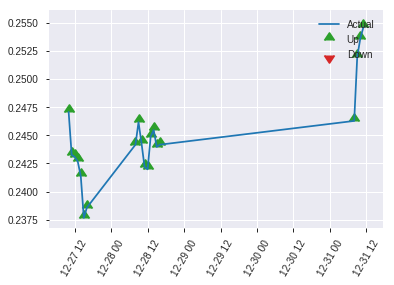


ModelMetricsBinomialGLM: glm
** Reported on test data. **

MSE: 0.24944507158184334
RMSE: 0.4994447632940437
LogLoss: 0.6920362171837082
Null degrees of freedom: 222
Residual degrees of freedom: 172
Null deviance: 309.1597919029809
Residual deviance: 308.6481528639339
AIC: 410.6481528639339
AUC: 0.5331402831402832
pr_auc: 0.5138679412988941
Gini: 0.06628056628056633
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.4664989041724644: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      3    108  0.973    (108.0/111.0)
1      0    112  0        (0.0/112.0)
Total  3    220  0.4843   (108.0/223.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.466499     0.674699  219
max f2                       0.466499     0.838323  219
max f0point5                 0.477332     0.567686  200
max accuracy                 0.495164     0.55157   123
max precision                0.51932      0.666667  5
max recall                   0.466499     1         219
max specificity              0.523779     0.990991  0
max absolute_mcc             0.466499     0.1173    219
max min_per_class_accuracy   0.496855     0.544643  110
max mean_per_class_accuracy  0.495164     0.551319  123

Gains/Lift Table: Avg response rate: 50.22 %, avg score: 49.64 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain       cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  ---------  -----------------
    1        0.0134529                   0.519514           0.66369   0.66369            0.333333         0.521393  0.333333                    0.521393            0.00892857      0.00892857                 -33.631    -33.631
    2        0.0224215                   0.51935            1.99107   1.19464            1                0.519381  0.6                         0.520588            0.0178571       0.0267857                  99.1071    19.4643
    3        0.0313901                   0.518702           0.995536  1.13776            0.5              0.519194  0.571429                    0.52019             0.00892857      0.0357143                  -0.446429  13.7755
    4        0.0403587                   0.516432           0         0.884921           0                0.518074  0.444444                    0.51972             0               0.0357143                  -100       -11.5079
    5        0.0538117                   0.514825           0.66369   0.829613           0.333333         0.515609  0.416667                    0.518692            0.00892857      0.0446429                  -33.631    -17.0387
    6        0.103139                    0.5126             1.26705   1.03882            0.636364         0.513741  0.521739                    0.516324            0.0625          0.107143                   26.7045    3.88199
    7        0.152466                    0.510917           1.08604   1.0541             0.545455         0.511808  0.529412                    0.514863            0.0535714       0.160714                   8.6039     5.40966
    8        0.201794                    0.509435           0.905032  1.01766            0.454545         0.510193  0.511111                    0.513721            0.0446429       0.205357                   -9.49675   1.76587
    9        0.300448                    0.504432           0.995536  1.01039            0.5              0.507066  0.507463                    0.511536            0.0982143       0.303571                   -0.446429  1.03945
    10       0.399103                    0.500617           1.17654   1.05146            0.590909         0.502676  0.52809                     0.509346            0.116071        0.419643                   17.6542    5.14647
    11       0.502242                    0.496813           1.21196   1.08442            0.608696         0.498586  0.544643                    0.507136            0.125           0.544643                   21.1957    8.44228
    12       0.600897                    0.493862           0.905032  1.05497            0.454545         0.495273  0.529851                    0.505189            0.0892857       0.633929                   -9.49675   5.49707
    13       0.699552                    0.489311           0.814529  1.02106            0.409091         0.491787  0.512821                    0.503299            0.0803571       0.714286                   -18.5471   2.10623
    14       0.798206                    0.484755           1.08604   1.02909            0.545455         0.486953  0.516854                    0.501279            0.107143        0.821429                   8.6039     2.90931
    15       0.896861                    0.477381           0.995536  1.0254             0.5              0.481416  0.515                       0.499094            0.0982143       0.919643                   -0.446429  2.54018
    16       1                           0.462079           0.779115  1                  0.391304         0.472664  0.502242                  

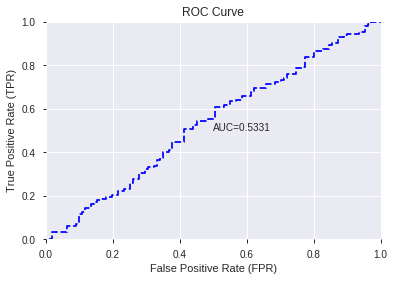

/usr/local/lib/python3.6/dist-packages/matplotlib/cbook/__init__.py:424: MatplotlibDeprecationWarning: 
Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warn_deprecated("2.2", "Passing one of 'on', 'true', 'off', 'false' as a "


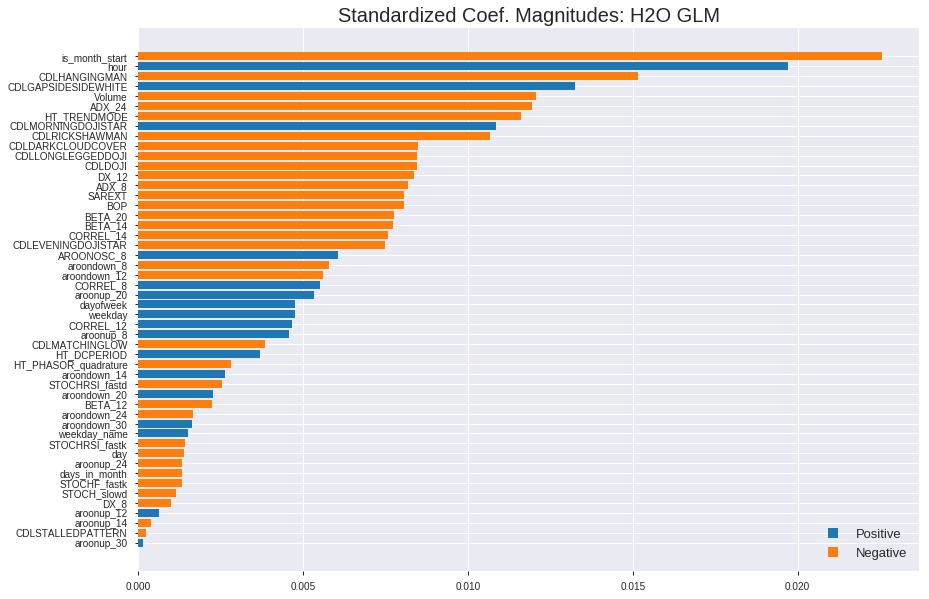

'log_likelihood'
--2019-08-27 21:38:59--  https://h2o-release.s3.amazonaws.com/h2o/rel-yates/5/h2o-3.24.0.5.zip
Resolving h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)... 52.216.80.176
Connecting to h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)|52.216.80.176|:443... connected.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.

Archive:  h2o-3.24.0.5.zip
ERROR: Unknown MOJO type


[{'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Models/GLM_grid_1_AutoML_20190827_213853_model_1',
   '__meta': {'schema_name': 'ModelKeyV3',
    'schema_type': 'Key<Model>',
    'schema_version': 3},
   'name': 'GLM_grid_1_AutoML_20190827_213853_model_1',
   'type': 'Key<Model>'},
  'default_value': None,
  'gridable': False,
  'help': 'Destination id for this model; auto-generated if not specified.',
  'is_member_of_frames': [],
  'is_mutually_exclusive_with': [],
  'label': 'model_id',
  'level': 'critical',
  'name': 'model_id',
  'required': False,
  'type': 'Key<Model>',
  'values': []},
 {'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Frames/automl_training_py_58_sid_a8e7',
   '__meta': {'schema_name': 'FrameKeyV3',
    'schema_type': 'Key<Frame>',
    'schema_version': 3},
   'name': 'automl_training_py_58_s

['is_month_start',
 'hour',
 'CDLHANGINGMAN',
 'CDLGAPSIDESIDEWHITE',
 'Volume',
 'ADX_24',
 'HT_TRENDMODE',
 'CDLMORNINGDOJISTAR',
 'CDLRICKSHAWMAN',
 'CDLDARKCLOUDCOVER',
 'CDLLONGLEGGEDDOJI',
 'CDLDOJI',
 'DX_12',
 'ADX_8',
 'SAREXT',
 'BOP',
 'BETA_20',
 'BETA_14',
 'CORREL_14',
 'CDLEVENINGDOJISTAR',
 'AROONOSC_8',
 'aroondown_8',
 'aroondown_12',
 'CORREL_8',
 'aroonup_20',
 'dayofweek',
 'weekday',
 'CORREL_12',
 'aroonup_8',
 'CDLMATCHINGLOW',
 'HT_DCPERIOD',
 'HT_PHASOR_quadrature',
 'aroondown_14',
 'STOCHRSI_fastd',
 'aroondown_20',
 'BETA_12',
 'aroondown_24',
 'aroondown_30',
 'weekday_name',
 'STOCHRSI_fastk',
 'day',
 'aroonup_24',
 'days_in_month',
 'STOCHF_fastk',
 'STOCH_slowd',
 'DX_8',
 'aroonup_12',
 'aroonup_14',
 'CDLSTALLEDPATTERN',
 'aroonup_30']

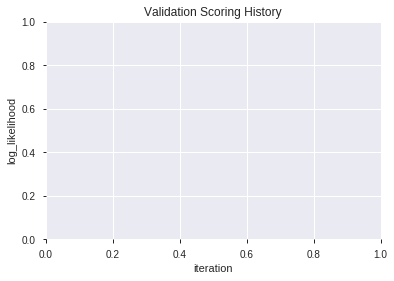

In [21]:
# GLM with top XGBoost features
model_train(feature_name='XGBF',model_algo="GLM",features_list = features_list[:model_selected_features])

AutoML progress: |████████████████████████████████████████████████████████| 100%


model_id       auc   logloss  mean_per_class_error      rmse       mse
0  XGBoost_grid_1_AutoML_20190827_213905_model_2  0.557191  0.686476              0.486406  0.496750  0.246761
1               XGBoost_3_AutoML_20190827_213905  0.553491  0.687507              0.481982  0.497285  0.247292
2  XGBoost_grid_1_AutoML_20190827_213905_model_6  0.552606  0.691233              0.500000  0.499087  0.249088
3  XGBoost_grid_1_AutoML_20190827_213905_model_7  0.551158  0.697798              0.481942  0.502370  0.252376
4               XGBoost_1_AutoML_20190827_213905  0.549871  0.694261              0.490991  0.500540  0.250540
5  XGBoost_grid_1_AutoML_20190827_213905_model_1  0.543919  0.692295              0.441039  0.499617  0.249617
6  XGBoost_grid_1_AutoML_20190827_213905_model_4  0.531934  0.694169              0.490991  0.500500  0.250500
7  XGBoost_grid_1_AutoML_20190827_213905_model_3  0.526625  0.700775              0.500000  0.503685  0.253699
8  XGBoost_grid_1_AutoML_20190827_213905_model_5  0.522683  0.719978              0.486406  0.512060  0.262206
9               XGBoost_2_AutoML_20190827_213905  0.511261  0.703397              0.454673  0.504867  0.254890

variable  relative_importance  scaled_importance  percentage
0            HT_DCPERIOD           271.609955           1.000000    0.061337
1                    BOP           237.785675           0.875467    0.053699
2                  ADX_8           228.966415           0.842997    0.051707
3                 Volume           222.867752           0.820543    0.050330
4                BETA_20           202.614792           0.745977    0.045756
5            STOCH_slowd           193.254990           0.711517    0.043643
6                   hour           189.645935           0.698229    0.042828
7                    day           189.479340           0.697616    0.042790
8                 SAREXT           187.648865           0.690876    0.042377
9           STOCHF_fastk           187.442810           0.690118    0.042330
10                ADX_24           182.062561           0.670309    0.041115
11                 DX_12           180.705353           0.665312    0.040809
12  HT_PHASOR_quadrature           178.620407           0.657636    0.040338
13               BETA_14           153.859497           0.566472    0.034746
14                  DX_8           131.924210           0.485712    0.029792
15               BETA_12           125.462494           0.461922    0.028333
16        STOCHRSI_fastk           121.959808           0.449026    0.027542
17        STOCHRSI_fastd           121.052696           0.445686    0.027337
18          aroondown_30           112.028702           0.412462    0.025299
19             CORREL_14           107.089584           0.394277    0.024184
20             CORREL_12            99.564926           0.366573    0.022485
21            aroonup_30            64.047874           0.235808    0.014464
22            aroonup_24            59.432709           0.218816    0.013422
23        CDLRICKSHAWMAN            58.750607           0.216305    0.013268
24            AROONOSC_8            58.659622           0.215970    0.013247
25            aroonup_20            58.590137           0.215714    0.013231
26          aroondown_12            57.513241           0.211749    0.012988
27          aroondown_20            53.854115           0.198277    0.012162
28          aroondown_24            48.447018           0.178370    0.010941
29              CORREL_8            45.999691           0.169359    0.010388
30          aroondown_14            45.801533           0.168630    0.010343
31            aroonup_14            41.784554           0.153840    0.009436
32           aroondown_8            36.580166           0.134679    0.008261
33             dayofweek            35.884163           0.132117    0.008104
34             aroonup_8            27.125433           0.099869    0.006126
35          weekday_name            26.300911           0.096833    0.005940
36            aroonup_12            23.423946           0.086241    0.005290
37               CDLDOJI            20.947704           0.077124    0.004731
38         days_in_month            12.041528           0.044334    0.002719
39               weekday            10.125387           0.037279    0.002287
40          HT_TRENDMODE             7.041573           0.025925    0.001590
41     CDLDARKCLOUDCOVER             4.237030           0.015600    0.000957
42        CDLMATCHINGLOW             4.171704           0.015359    0.000942
43         CDLHANGINGMAN             1.718801           0.006328    0.000388

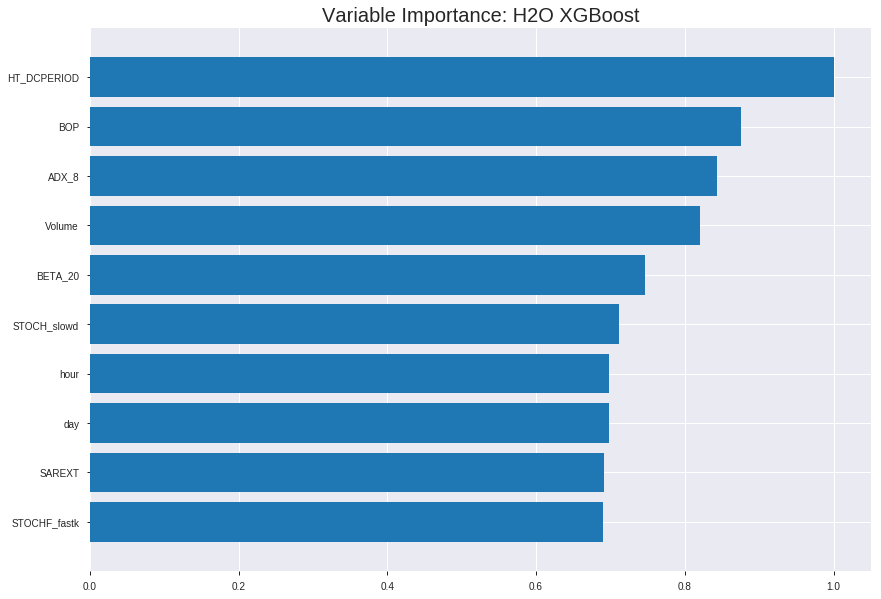

Model Details
H2OXGBoostEstimator :  XGBoost
Model Key:  XGBoost_grid_1_AutoML_20190827_213905_model_2


ModelMetricsBinomial: xgboost
** Reported on train data. **

MSE: 0.19680635851109948
RMSE: 0.4436286267939655
LogLoss: 0.585061823519972
Mean Per-Class Error: 0.15978165039344128
AUC: 0.9202793227042393
pr_auc: 0.9191396515863921
Gini: 0.8405586454084786
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.4766524774687631: 


0    1    Error    Rate
-----  ---  ---  -------  --------------
0      586  197  0.2516   (197.0/783.0)
1      65   710  0.0839   (65.0/775.0)
Total  651  907  0.1682   (262.0/1558.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.476652     0.844233  226
max f2                       0.450091     0.89759   260
max f0point5                 0.533174     0.862015  156
max accuracy                 0.497946     0.84018   200
max precision                0.676161     1         0
max recall                   0.332838     1         386
max specificity              0.676161     1         0
max absolute_mcc             0.497946     0.680473  200
max min_per_class_accuracy   0.500344     0.837419  197
max mean_per_class_accuracy  0.497946     0.840218  200

Gains/Lift Table: Avg response rate: 49.74 %, avg score: 49.71 %



group    cumulative_data_fraction    lower_threshold    lift       cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  ---------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0102696                   0.654407           2.01032    2.01032            1                0.664826  1                           0.664826            0.0206452       0.0206452                  101.032   101.032
    2        0.0205392                   0.64373            2.01032    2.01032            1                0.648365  1                           0.656596            0.0206452       0.0412903                  101.032   101.032
    3        0.0301669                   0.636691           2.01032    2.01032            1                0.639604  1                           0.651173            0.0193548       0.0606452                  101.032   101.032
    4        0.0404365                   0.631449           2.01032    2.01032            1                0.634133  1                           0.646845            0.0206452       0.0812903                  101.032   101.032
    5        0.0500642                   0.626567           2.01032    2.01032            1                0.628645  1                           0.643345            0.0193548       0.100645                   101.032   101.032
    6        0.100128                    0.606117           2.01032    2.01032            1                0.616258  1                           0.629802            0.100645        0.20129                    101.032   101.032
    7        0.150193                    0.590686           1.933      1.98455            0.961538         0.598535  0.987179                    0.619379            0.0967742       0.298065                   93.3002   98.4549
    8        0.200257                    0.578856           1.933      1.97166            0.961538         0.585182  0.980769                    0.61083             0.0967742       0.394839                   93.3002   97.1663
    9        0.300385                    0.552936           1.75259    1.89864            0.871795         0.566243  0.944444                    0.595968            0.175484        0.570323                   75.2589   89.8638
    10       0.399872                    0.528022           1.51747    1.8038             0.754839         0.540973  0.897271                    0.582285            0.150968        0.72129                    51.7469   80.3805
    11       0.5                         0.499231           1.18557    1.68               0.589744         0.512895  0.835687                    0.568389            0.11871         0.84                       18.5575   68
    12       0.600128                    0.472098           0.824748   1.53731            0.410256         0.485306  0.764706                    0.554527            0.0825806       0.922581                   -17.5252  53.7306
    13       0.699615                    0.44239            0.453944   1.38325            0.225806         0.456947  0.688073                    0.540651            0.0451613       0.967742                   -54.6056  38.3249
    14       0.799743                    0.416846           0.206187   1.23588            0.102564         0.430648  0.614767                    0.526879            0.0206452       0.988387                   -79.3813  23.588
    15       0.899872                    0.382414           0.0902068  1.1084             0.0448718        0.400944  0.551355                    0.512866            0.00903226      0.997419                   -90.9793  10.8402
    16       1                           0.297186           0.0257734  1                  0.0128205        0.355619  0.497433                    0.497



ModelMetricsBinomial: xgboost
** Reported on validation data. **

MSE: 0.25776995906485944
RMSE: 0.5077105071444351
LogLoss: 0.7089909065948448
Mean Per-Class Error: 0.49523896166909265
AUC: 0.4665211062590975
pr_auc: 0.4864032391544607
Gini: -0.06695778748180503
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.3641563057899475: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      3    213  0.9861   (213.0/216.0)
1      1    228  0.0044   (1.0/229.0)
Total  4    441  0.4809   (214.0/445.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.364156     0.680597  395
max f2                       0.348253     0.841293  399
max f0point5                 0.364156     0.572002  395
max accuracy                 0.364156     0.519101  395
max precision                0.664871     0.666667  1
max recall                   0.348253     1         399
max specificity              0.709764     0.99537   0
max absolute_mcc             0.441606     0.095029  309
max min_per_class_accuracy   0.496655     0.476852  202
max mean_per_class_accuracy  0.364156     0.504761  395

Gains/Lift Table: Avg response rate: 51.46 %, avg score: 49.52 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain       cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  ---------  -----------------
    1        0.011236                    0.641895           0.777293  0.777293           0.4              0.665577  0.4                         0.665577            0.00873362      0.00873362                 -22.2707   -22.2707
    2        0.0202247                   0.626119           0.485808  0.647744           0.25             0.633741  0.333333                    0.651428            0.00436681      0.0131004                  -51.4192   -35.2256
    3        0.0314607                   0.615727           1.16594   0.832813           0.6              0.621238  0.428571                    0.640646            0.0131004       0.0262009                  16.5939    -16.7187
    4        0.0404494                   0.605275           1.45742   0.971616           0.75             0.611451  0.5                         0.634158            0.0131004       0.0393013                  45.7424    -2.83843
    5        0.0516854                   0.598745           0.777293  0.929372           0.4              0.601462  0.478261                    0.62705             0.00873362      0.0480349                  -22.2707   -7.06284
    6        0.101124                    0.574233           0.794958  0.863658           0.409091         0.585329  0.444444                    0.606653            0.0393013       0.0873362                  -20.5042   -13.6342
    7        0.150562                    0.562142           1.05994   0.928111           0.545455         0.566874  0.477612                    0.593592            0.0524017       0.139738                   5.99444    -7.18895
    8        0.2                         0.548355           0.971616  0.938865           0.5              0.555048  0.483146                    0.584064            0.0480349       0.187773                   -2.83843   -6.11354
    9        0.301124                    0.528635           0.993207  0.957114           0.511111         0.537763  0.492537                    0.568515            0.100437        0.28821                    -0.679282  -4.2886
    10       0.4                         0.508658           0.971616  0.960699           0.5              0.516241  0.494382                    0.555593            0.0960699       0.384279                   -2.83843   -3.93013
    11       0.501124                    0.496657           0.950024  0.958545           0.488889         0.50231   0.493274                    0.544841            0.0960699       0.480349                   -4.99757   -4.14553
    12       0.6                         0.480917           1.14827   0.989811           0.590909         0.489052  0.509363                    0.535647            0.113537        0.593886                   14.8273    -1.01892
    13       0.698876                    0.461335           0.750794  0.955995           0.386364         0.472044  0.491961                    0.526649            0.0742358       0.668122                   -24.9206   -4.40051
    14       0.8                         0.438077           0.993207  0.960699           0.511111         0.45022   0.494382                    0.516988            0.100437        0.768559                   -0.679282  -3.93013
    15       0.898876                    0.414205           1.2366    0.991048           0.636364         0.427369  0.51                        0.50713             0.122271        0.89083                    23.6602    -0.895197
    16       1                           0.348253           1.07957   1                  0.555556         0.388891  0.514607     


Scoring History: 


timestamp            duration    number_of_trees    training_rmse    training_logloss    training_auc    training_pr_auc    training_lift    training_classification_error    validation_rmse    validation_logloss    validation_auc    validation_pr_auc    validation_lift    validation_classification_error
--  -------------------  ----------  -----------------  ---------------  ------------------  --------------  -----------------  ---------------  -------------------------------  -----------------  --------------------  ----------------  -------------------  -----------------  ---------------------------------
    2019-08-27 21:39:10  0.728 sec   0                  0.5              0.693147            0.5             0                  1                0.502567                         0.5                0.693147              0.5               0                    1                  0.485393
    2019-08-27 21:39:10  0.846 sec   5                  0.492515         0.678278            0.781398        0.776112           2.01032          0.32285                          0.50102            0.69519               0.467825          0.498573             1.16594            0.478652
    2019-08-27 21:39:10  0.916 sec   10                 0.48565          0.664805            0.824692        0.823012           2.01032          0.258023                         0.501075           0.695304              0.487536          0.510902             1.16594            0.480899
    2019-08-27 21:39:10  0.985 sec   15                 0.479743         0.653325            0.849067        0.849612           2.01032          0.22914                          0.50188            0.696925              0.478419          0.501641             1.16594            0.483146
    2019-08-27 21:39:10  1.057 sec   20                 0.473903         0.642073            0.869225        0.865969           2.01032          0.209243                         0.502553           0.698288              0.47481           0.49719              0.777293           0.483146
    2019-08-27 21:39:10  1.134 sec   25                 0.468507         0.631747            0.878383        0.878599           2.01032          0.207317                         0.503927           0.701081              0.463691          0.487539             1.16594            0.483146
    2019-08-27 21:39:10  1.215 sec   30                 0.463501         0.622224            0.885394        0.886289           2.01032          0.193838                         0.505008           0.703299              0.461416          0.483347             0.777293           0.480899
    2019-08-27 21:39:10  1.292 sec   35                 0.457946         0.611754            0.898247        0.899941           2.01032          0.186136                         0.505681           0.704701              0.463014          0.484722             0.388646           0.483146
    2019-08-27 21:39:10  1.370 sec   40                 0.453245         0.602933            0.904401        0.906008           2.01032          0.184211                         0.506764           0.70697               0.461608          0.484007             0.777293           0.485393
    2019-08-27 21:39:10  1.448 sec   45                 0.448835         0.594701            0.909738        0.908462           2.01032          0.175866                         0.507203           0.707909              0.466511          0.48704              0.777293           0.483146
    2019-08-27 21:39:10  1.527 sec   50                 0.443629         0.585062            0.920279        0.91914            2.01032          0.168164                         0.507711           0.708991              0.466521          0.486403             0.777293           0.480899

Variable Importances: 


variable           relative_importance    scaled_importance     percentage
-----------------  ---------------------  --------------------  ---------------------
HT_DCPERIOD        271.6099548339844      1.0                   0.06133744653259321
BOP                237.78567504882812     0.8754674518250607    0.05369893801734528
ADX_8              228.96641540527344     0.8429971410481775    0.05170729206617152
Volume             222.8677520751953      0.8205433862371442    0.050330036080993804
BETA_20            202.6147918701172      0.7459770463640076    0.04575632719589412
---                ---                    ---                   ---
weekday            10.125387191772461     0.03727914611215698   0.0022866076314351585
HT_TRENDMODE       7.041572570800781      0.025925311077441133  0.001590192382053392
CDLDARKCLOUDCOVER  4.237030029296875      0.015599686071472111  0.0009568449103341595
CDLMATCHINGLOW     4.171704292297363      0.015359173027539532  0.0009420924543615538
CDLHANGINGMAN      1.718801498413086      0.006328197725535007  0.0003881554896376814


See the whole table with table.as_data_frame()


/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:7116: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


('accuracy', 0.5605381165919282)

('F1', 0.6707317073170733)

('auc', 0.5571911196911197)

('logloss', 0.6864755170637058)

('mean_per_class_error', 0.439028314028314)

('rmse', 0.49675047600426586)

('mse', 0.2467610354104647)

xgboost prediction progress: |████████████████████████████████████████████| 100%


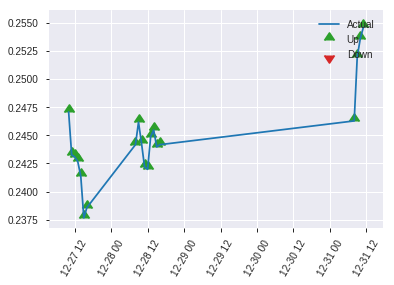


ModelMetricsBinomial: xgboost
** Reported on test data. **

MSE: 0.2467610354104647
RMSE: 0.49675047600426586
LogLoss: 0.6864755170637058
Mean Per-Class Error: 0.439028314028314
AUC: 0.5571911196911197
pr_auc: 0.5817925565992141
Gini: 0.11438223938223935
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.39483243227005005: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      5    106  0.955    (106.0/111.0)
1      2    110  0.0179   (2.0/112.0)
Total  7    216  0.4843   (108.0/223.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.394832     0.670732  215
max f2                       0.367054     0.835821  221
max f0point5                 0.447872     0.568182  180
max accuracy                 0.531438     0.560538  89
max precision                0.666011     1         0
max recall                   0.367054     1         221
max specificity              0.666011     1         0
max absolute_mcc             0.617183     0.184594  16
max min_per_class_accuracy   0.511569     0.504505  111
max mean_per_class_accuracy  0.531438     0.560972  89

Gains/Lift Table: Avg response rate: 50.22 %, avg score: 51.46 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain       cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  ---------  -----------------
    1        0.0134529                   0.65795            1.99107   1.99107            1                0.660909  1                           0.660909            0.0267857       0.0267857                  99.1071    99.1071
    2        0.0224215                   0.653397           0.995536  1.59286            0.5              0.657245  0.8                         0.659443            0.00892857      0.0357143                  -0.446429  59.2857
    3        0.0313901                   0.639939           1.99107   1.70663            1                0.644531  0.857143                    0.655183            0.0178571       0.0535714                  99.1071    70.6633
    4        0.0403587                   0.637873           1.99107   1.76984            1                0.639458  0.888889                    0.651688            0.0178571       0.0714286                  99.1071    76.9841
    5        0.0538117                   0.629086           0.66369   1.4933             0.333333         0.634928  0.75                        0.647498            0.00892857      0.0803571                  -33.631    49.3304
    6        0.103139                    0.601957           1.44805   1.47166            0.727273         0.613081  0.73913                     0.631038            0.0714286       0.151786                   44.8052    47.1661
    7        0.152466                    0.585906           0.905032  1.28834            0.454545         0.591746  0.647059                    0.618326            0.0446429       0.196429                   -9.49675   28.834
    8        0.201794                    0.577894           0.905032  1.19464            0.454545         0.581525  0.6                         0.60933             0.0446429       0.241071                   -9.49675   19.4643
    9        0.300448                    0.555531           1.08604   1.15898            0.545455         0.564611  0.58209                     0.594646            0.107143        0.348214                   8.6039     15.8982
    10       0.399103                    0.531485           1.08604   1.14095            0.545455         0.54257   0.573034                    0.581773            0.107143        0.455357                   8.6039     14.0951
    11       0.502242                    0.511569           0.51941   1.01331            0.26087          0.521052  0.508929                    0.569304            0.0535714       0.508929                   -48.059    1.33131
    12       0.600897                    0.500384           1.17654   1.04011            0.590909         0.505952  0.522388                    0.558903            0.116071        0.625                      17.6542    4.01119
    13       0.699552                    0.477811           1.08604   1.04659            0.545455         0.488753  0.525641                    0.54901             0.107143        0.732143                   8.6039     4.65888
    14       0.798206                    0.45019            0.995536  1.04028            0.5              0.464594  0.522472                    0.538576            0.0982143       0.830357                   -0.446429  4.02789
    15       0.896861                    0.426255           0.814529  1.01545            0.409091         0.439592  0.51                        0.527688            0.0803571       0.910714                   -18.5471   1.54464
    16       1                           0.351768           0.865683  1                  0.434783         0.401127  0.502242                    0

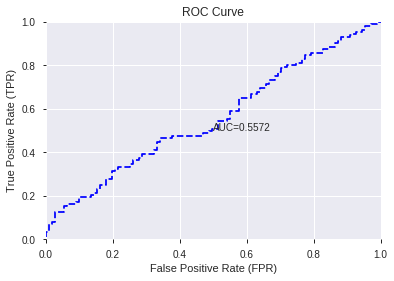

This function is available for GLM models only


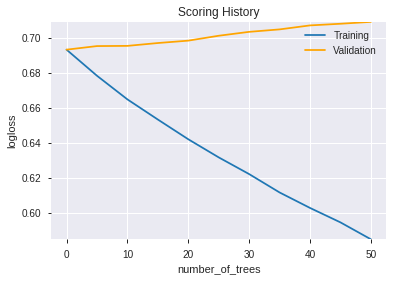

--2019-08-27 21:39:23--  https://h2o-release.s3.amazonaws.com/h2o/rel-yates/5/h2o-3.24.0.5.zip
Resolving h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)... 52.216.133.171
Connecting to h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)|52.216.133.171|:443... connected.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.

Archive:  h2o-3.24.0.5.zip
Exception in thread "main" java.lang.StackOverflowError
	at java.base/java.lang.String.substring(String.java:1874)
	at java.base/java.lang.String.split(String.java:2289)
	at java.base/java.lang.String.split(String.java:2364)
	at hex.genmodel.algos.xgboost.XGBoostMojoModel.constructSubgraph(XGBoostMojoModel.java:101)
	at hex.genmodel.algos.xgboost.XGBoostMojoModel.constructSubgraph(XGBoostMojoModel.java:112)
	at hex.genmodel.algos.xgboost.XGBoostMojoModel.constructSubgraph(XGBoostMojoModel.java:106)
	at hex.genmodel.algos.xgboost.XGBoostMojoMo

[{'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Models/XGBoost_grid_1_AutoML_20190827_213905_model_2',
   '__meta': {'schema_name': 'ModelKeyV3',
    'schema_type': 'Key<Model>',
    'schema_version': 3},
   'name': 'XGBoost_grid_1_AutoML_20190827_213905_model_2',
   'type': 'Key<Model>'},
  'default_value': None,
  'gridable': False,
  'help': 'Destination id for this model; auto-generated if not specified.',
  'is_member_of_frames': [],
  'is_mutually_exclusive_with': [],
  'label': 'model_id',
  'level': 'critical',
  'name': 'model_id',
  'required': False,
  'type': 'Key<Model>',
  'values': []},
 {'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Frames/automl_training_py_66_sid_a8e7',
   '__meta': {'schema_name': 'FrameKeyV3',
    'schema_type': 'Key<Frame>',
    'schema_version': 3},
   'name': 'automl_training

['HT_DCPERIOD',
 'BOP',
 'ADX_8',
 'Volume',
 'BETA_20',
 'STOCH_slowd',
 'hour',
 'day',
 'SAREXT',
 'STOCHF_fastk',
 'ADX_24',
 'DX_12',
 'HT_PHASOR_quadrature',
 'BETA_14',
 'DX_8',
 'BETA_12',
 'STOCHRSI_fastk',
 'STOCHRSI_fastd',
 'aroondown_30',
 'CORREL_14',
 'CORREL_12',
 'aroonup_30',
 'aroonup_24',
 'CDLRICKSHAWMAN',
 'AROONOSC_8',
 'aroonup_20',
 'aroondown_12',
 'aroondown_20',
 'aroondown_24',
 'CORREL_8',
 'aroondown_14',
 'aroonup_14',
 'aroondown_8',
 'dayofweek',
 'aroonup_8',
 'weekday_name',
 'aroonup_12',
 'CDLDOJI',
 'days_in_month',
 'weekday',
 'HT_TRENDMODE',
 'CDLDARKCLOUDCOVER',
 'CDLMATCHINGLOW',
 'CDLHANGINGMAN']

In [22]:
# XGBoost with top XGBoost features
model_train(feature_name='XGBF',model_algo="XGBoost",features_list = features_list[:model_selected_features])

In [0]:
# PCA
try:
  del xgb_features,glm_features,dl_features
except:
  pass
gc.collect()

if features_to_include is True or 'PCA' in features_to_include:
  for _ in range(3):
    try:
      from h2o.estimators.pca import H2OPrincipalComponentAnalysisEstimator
      h2o_model = H2OPrincipalComponentAnalysisEstimator(seed=1, k=PCA_k, pca_method="GramSVD", max_iterations=10000)
      h2o_model.train(x=list(train_hf.columns[:-1]), training_frame=train_hf[:index_splits[0],:])

      display(h2o_model.varimp(use_pandas=True))
      display(h2o_model)

      training_frame = h2o_model.predict(train_hf)
      del h2o_model, H2OPrincipalComponentAnalysisEstimator
      gc.collect()

      training_frame = training_frame.cbind(train_hf[data_label_name])
      break
    except KeyboardInterrupt:
      break
    except Exception as e:
      print(e)
      load_h2o()
else:
  training_frame = []

In [24]:
# DeepLearning with PCA
model_train(feature_name='PCA',model_algo="DeepLearning",training_frame=training_frame)

[]

In [25]:
# GLM with PCA
model_train(feature_name='PCA',model_algo="GLM",training_frame=training_frame)

[]

In [26]:
# XGBoost with PCA
model_train(feature_name='PCA',model_algo="XGBoost",training_frame=training_frame)

[]

In [0]:
# Generalized Low Rank
try:
  del training_frame
except:
  pass
gc.collect()

if features_to_include is True or 'GLRM' in features_to_include:
  for _ in range(3):
    try:
      from h2o.estimators.glrm import H2OGeneralizedLowRankEstimator

      h2o_model = H2OGeneralizedLowRankEstimator(seed=1, k=GLRM_k)
      h2o_model.train(x=list(train_hf.columns[:-1]), training_frame=train_hf[:index_splits[0],:])

      display(h2o_model.varimp(use_pandas=True))
      display(h2o_model)

      training_frame = h2o_model.predict(train_hf)
      del h2o_model, H2OGeneralizedLowRankEstimator
      gc.collect()

      training_frame = training_frame.cbind(train_hf[data_label_name])
      break
    except KeyboardInterrupt:
      break
    except Exception as e:
      print(e)
      load_h2o()
else:
  training_frame = []

In [28]:
# DeepLearning with Generalized Low Rank
model_train(feature_name='GLRM',model_algo="DeepLearning",training_frame=training_frame)

[]

In [29]:
# GLM with Generalized Low Rank
model_train(feature_name='GLRM',model_algo="GLM",training_frame=training_frame)

[]

In [30]:
# XGBoost with Generalized Low Rank
model_train(feature_name='GLRM',model_algo="XGBoost",training_frame=training_frame)

[]

In [0]:
# High Correlation Filter 
try:
  del training_frame
except:
  pass
gc.collect()

if features_to_include is True or 'HCF' in features_to_include:
  corr_matrix = pd.read_pickle('scaled_df')[:index_splits[0]].drop(data_label_name,axis=1).corr().abs()

  upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool))

  features_list = [column for column in upper.columns if not any(upper[column] > HCF_threshold)]

  del corr_matrix, upper
  gc.collect()

  display(len(features_list),features_list)
else:
  features_list = []

In [32]:
# DeepLearning with low correlation features
model_train(feature_name='HCF',model_algo="DeepLearning",features_list=features_list)

[]

In [33]:
# GLM with low correlation features
model_train(feature_name='HCF',model_algo="GLM",features_list=features_list)

[]

In [34]:
# XGBoost with low correlation features
model_train(feature_name='HCF',model_algo="XGBoost",features_list=features_list)

[]

In [0]:
#	Low Variance Filter  
try:
  del features_list
except:
  pass
gc.collect()

if features_to_include is True or 'LVF' in features_to_include:
  df_variance = pd.read_pickle('scaled_df')[:index_splits[0]].drop(data_label_name,axis=1).var()
  features_list = [column for column in df_variance.index if df_variance[column]  > LVF_threshold]

  del df_variance
  gc.collect()

  display(len(features_list),features_list)
else:
  features_list = []

In [36]:
# DeepLearning with Low Variance features  
model_train(feature_name='LVF',model_algo="DeepLearning",features_list=features_list)

[]

In [37]:
# GLM with Low Variance features  
model_train(feature_name='LVF',model_algo="GLM",features_list=features_list)

[]

In [38]:
# XGBoost with Low Variance features  
model_train(feature_name='LVF',model_algo="XGBoost",features_list=features_list)

[]

In [0]:
# Select k best features
try:
  del features_list
except:
  pass
gc.collect()

if features_to_include is True or 'KBest' in features_to_include:
  from sklearn.feature_selection import SelectKBest
  from sklearn.feature_selection import f_classif

  bestfeatures = SelectKBest(score_func=f_classif, k=select_k).fit(pd.read_pickle('scaled_df')[:index_splits[0]].drop(data_label_name,axis=1)
                                                              ,pd.read_pickle('scaled_df')[:index_splits[0]][data_label_name])

  features_list = list(np.array(train_hf.columns)[:-1][bestfeatures.get_support()])

  del bestfeatures, SelectKBest, f_classif
  gc.collect()
  display(len(features_list),features_list)
else:
  features_list=[]

In [40]:
# DeepLearning with Select k best features 
model_train(feature_name='KBest',model_algo="DeepLearning",features_list=features_list)

[]

In [41]:
# GLM with Select k best features
model_train(feature_name='KBest',model_algo="GLM",features_list=features_list)

[]

In [42]:
# XGBoost with Select k best features
model_train(feature_name='KBest',model_algo="XGBoost",features_list=features_list)

[]

In [0]:
# Select Percentile
try:
  del features_list
except:
  pass
gc.collect()

if features_to_include is True or 'Percentile' in features_to_include:
  from sklearn.feature_selection import SelectPercentile
  from sklearn.feature_selection import f_classif

  bestfeatures = SelectPercentile(score_func=f_classif, percentile=select_percentile).fit(pd.read_pickle('scaled_df')[:index_splits[0]].drop(data_label_name,axis=1)
                                                              ,pd.read_pickle('scaled_df')[:index_splits[0]][data_label_name])

  features_list = list(np.array(train_hf.columns)[:-1][bestfeatures.get_support()])

  del bestfeatures, SelectPercentile, f_classif
  gc.collect()
  display(len(features_list),features_list)
else:
  features_list=[]

In [44]:
# DeepLearning with Select Percentile features  
model_train(feature_name='Percentile',model_algo="DeepLearning",features_list=features_list)

[]

In [45]:
# GLM with Select Percentile features  
model_train(feature_name='Percentile',model_algo="GLM",features_list=features_list)

[]

In [46]:
# XGBoost with Select Percentile features  
model_train(feature_name='Percentile',model_algo="XGBoost",features_list=features_list)

[]

In [47]:
# Select Family-wise error
try:
  del features_list
except:
  pass
gc.collect()

if features_to_include is True or 'Fwe' in features_to_include:
  from sklearn.feature_selection import SelectFwe
  from sklearn.feature_selection import f_classif

  bestfeatures = SelectFwe(score_func=f_classif, alpha=select_alpha).fit(pd.read_pickle('scaled_df')[:index_splits[0]].drop(data_label_name,axis=1)
                                                              ,pd.read_pickle('scaled_df')[:index_splits[0]][data_label_name])

  features_list = list(np.array(train_hf.columns)[:-1][bestfeatures.get_support()])

  del bestfeatures, SelectFwe, f_classif
  gc.collect()
  display(len(features_list),features_list)
else:
  features_list=[]

/usr/local/lib/python3.6/dist-packages/sklearn/feature_selection/univariate_selection.py:114: UserWarning: Features [ 12  13 915 925 927 933] are constant.
  UserWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/feature_selection/univariate_selection.py:115: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/usr/local/lib/python3.6/dist-packages/sklearn/feature_selection/univariate_selection.py:721: RuntimeWarning: invalid value encountered in less
  return (self.pvalues_ < self.alpha / len(self.pvalues_))


0

[]

AutoML progress: |████████████████████████████████████████████████████████| 100%


model_id       auc   logloss  mean_per_class_error      rmse       mse
0  DeepLearning_grid_1_AutoML_20190827_213930_model_2  0.551882  0.726582              0.490951  0.514553  0.264765
1  DeepLearning_grid_1_AutoML_20190827_213930_model_3  0.506194  1.023159              0.500000  0.603511  0.364226
2  DeepLearning_grid_1_AutoML_20190827_213930_model_9  0.500000  0.693180              0.500000  0.500017  0.250017
3  DeepLearning_grid_1_AutoML_20190827_213930_model_8  0.500000  0.695116              0.500000  0.500982  0.250983
4  DeepLearning_grid_1_AutoML_20190827_213930_model_7  0.500000  0.693721              0.500000  0.500287  0.250287
5  DeepLearning_grid_1_AutoML_20190827_213930_model_6  0.500000  0.693137              0.500000  0.499995  0.249995
6  DeepLearning_grid_1_AutoML_20190827_213930_model_5  0.500000  0.693140              0.500000  0.499996  0.249996
7  DeepLearning_grid_1_AutoML_20190827_213930_model_1  0.499558  5.856272              0.500000  0.702843  0.493988
8               DeepLearning_1_AutoML_20190827_213930  0.498552  1.309578              0.495495  0.634738  0.402893
9  DeepLearning_grid_1_AutoML_20190827_213930_model_4  0.474180  1.150993              0.500000  0.615180  0.378446

variable  relative_importance  scaled_importance  percentage
0                         hour             1.000000           1.000000    0.002951
1                 HT_TRENDMODE             0.914183           0.914183    0.002698
2                    CORREL_12             0.879722           0.879722    0.002596
3                    CORREL_14             0.851844           0.851844    0.002514
4                    aroonup_8             0.850501           0.850501    0.002510
...                        ...                  ...                ...         ...
1028  BBANDS_middleband_12_4_2             0.258007           0.258007    0.000761
1029                  MEDPRICE             0.254432           0.254432    0.000751
1030   BBANDS_middleband_8_0_3             0.254285           0.254285    0.000750
1031                    MAX_12             0.253662           0.253662    0.000749
1032                      ASIN             0.249172           0.249172    0.000735

[1033 rows x 4 columns]

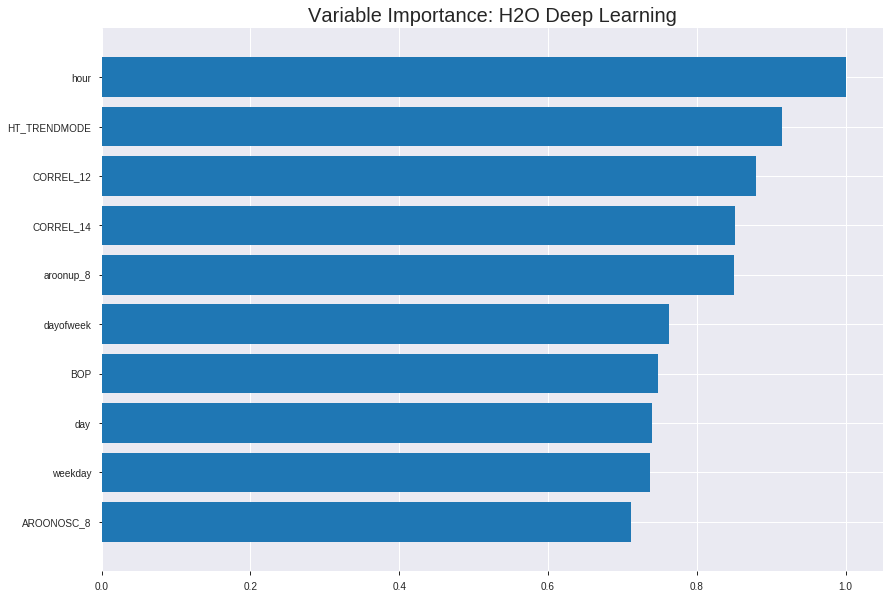

Model Details
H2ODeepLearningEstimator :  Deep Learning
Model Key:  DeepLearning_grid_1_AutoML_20190827_213930_model_2


ModelMetricsBinomial: deeplearning
** Reported on train data. **

MSE: 0.2436030254657398
RMSE: 0.49356157211207174
LogLoss: 0.6803350894430596
Mean Per-Class Error: 0.41838421291146544
AUC: 0.6012178140320521
pr_auc: 0.5809794048899377
Gini: 0.2024356280641042
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.25879107103585536: 


0    1     Error    Rate
-----  ---  ----  -------  --------------
0      18   765   0.977    (765.0/783.0)
1      5    770   0.0065   (5.0/775.0)
Total  23   1535  0.4942   (770.0/1558.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.258791     0.666667  380
max f2                       0.189404     0.832438  396
max f0point5                 0.480833     0.583666  219
max accuracy                 0.508127     0.581515  179
max precision                0.885713     1         0
max recall                   0.189404     1         396
max specificity              0.885713     1         0
max absolute_mcc             0.500243     0.163351  191
max min_per_class_accuracy   0.50256      0.577267  187
max mean_per_class_accuracy  0.500243     0.581616  191

Gains/Lift Table: Avg response rate: 49.74 %, avg score: 49.48 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0102696                   0.720362           1.3821    1.3821             0.6875           0.771125  0.6875                      0.771125            0.0141935       0.0141935                  38.2097   38.2097
    2        0.0205392                   0.69564            1.25645   1.31927            0.625            0.711276  0.65625                     0.7412              0.0129032       0.0270968                  25.6452   31.9274
    3        0.0301669                   0.669789           1.34022   1.32596            0.666667         0.682469  0.659574                    0.722456            0.0129032       0.04                       34.0215   32.5957
    4        0.0404365                   0.659225           0.879516  1.21258            0.4375           0.664853  0.603175                    0.707827            0.00903226      0.0490323                  -12.0484  21.2576
    5        0.0500642                   0.643852           1.34022   1.23712            0.666667         0.652823  0.615385                    0.697249            0.0129032       0.0619355                  34.0215   23.7122
    6        0.100128                    0.597878           1.18557   1.21135            0.589744         0.618773  0.602564                    0.658011            0.0593548       0.12129                    18.5575   21.1348
    7        0.150193                    0.566886           1.41754   1.28008            0.705128         0.581118  0.636752                    0.63238             0.0709677       0.192258                   41.7535   28.0077
    8        0.200257                    0.549433           1.1598    1.25001            0.576923         0.558812  0.621795                    0.613988            0.0580645       0.250323                   15.9801   25.0008
    9        0.300385                    0.526979           1.13403   1.21135            0.564103         0.536985  0.602564                    0.58832             0.113548        0.363871                   13.4028   21.1348
    10       0.399872                    0.513238           1.10243   1.18425            0.548387         0.519987  0.589085                    0.571319            0.109677        0.473548                   10.2435   18.4251
    11       0.5                         0.502359           1.04382   1.15613            0.519231         0.50794   0.575096                    0.558627            0.104516        0.578065                   4.38213   15.6129
    12       0.600128                    0.487506           0.966501  1.12449            0.480769         0.494811  0.559358                    0.54798             0.0967742       0.674839                   -3.34988  12.4491
    13       0.699615                    0.467855           0.856008  1.08631            0.425806         0.478064  0.540367                    0.538038            0.0851613       0.76                       -14.3992  8.63119
    14       0.799743                    0.435382           0.876294  1.06002            0.435897         0.455327  0.527287                    0.527682            0.0877419       0.847742                   -12.3706  6.00176
    15       0.899872                    0.380288           0.721654  1.02237            0.358974         0.409425  0.508559                    0.514524            0.0722581       0.92                       -27.8346  2.2368
    16       1                           0.0762844          0.798974  1                  0.397436         0.317287  0.497433                    0.494775          



ModelMetricsBinomial: deeplearning
** Reported on validation data. **

MSE: 0.2861885384999615
RMSE: 0.5349659227464507
LogLoss: 0.7865349145862598
Mean Per-Class Error: 0.48883026039139577
AUC: 0.4798237101730552
pr_auc: 0.492336025814946
Gini: -0.04035257965388961
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.026319287440233957: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      0    216  1        (216.0/216.0)
1      0    229  0        (0.0/229.0)
Total  0    445  0.4854   (216.0/445.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value      idx
---------------------------  -----------  ---------  -----
max f1                       0.0263193    0.679525   399
max f2                       0.0263193    0.841293   399
max f0point5                 0.0263193    0.569935   399
max accuracy                 0.517597     0.514607   243
max precision                0.517597     0.523636   243
max recall                   0.0263193    1          399
max specificity              0.918189     0.99537    0
max absolute_mcc             0.702433     0.0809153  84
max min_per_class_accuracy   0.570894     0.476852   197
max mean_per_class_accuracy  0.517597     0.51117    243

Gains/Lift Table: Avg response rate: 51.46 %, avg score: 56.27 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain       cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  ---------  -----------------
    1        0.011236                    0.878387           0.388646  0.388646           0.2              0.901378  0.2                         0.901378            0.00436681      0.00436681                 -61.1354   -61.1354
    2        0.0202247                   0.847144           0.971616  0.647744           0.5              0.861578  0.333333                    0.883689            0.00873362      0.0131004                  -2.83843   -35.2256
    3        0.0314607                   0.830186           1.16594   0.832813           0.6              0.839085  0.428571                    0.867759            0.0131004       0.0262009                  16.5939    -16.7187
    4        0.0404494                   0.823994           0.485808  0.755701           0.25             0.825487  0.388889                    0.858365            0.00436681      0.0305677                  -51.4192   -24.4299
    5        0.0516854                   0.807666           0.777293  0.760395           0.4              0.816066  0.391304                    0.84917             0.00873362      0.0393013                  -22.2707   -23.9605
    6        0.101124                    0.7769             1.14827   0.950024           0.590909         0.789842  0.488889                    0.820165            0.0567686       0.0960699                  14.8273    -4.99757
    7        0.150562                    0.73631            0.971616  0.957114           0.5              0.756222  0.492537                    0.799169            0.0480349       0.144105                   -2.83843   -4.2886
    8        0.2                         0.714005           0.70663   0.895197           0.363636         0.72767   0.460674                    0.781495            0.0349345       0.179039                   -29.337    -10.4803
    9        0.301124                    0.66363            0.993207  0.928111           0.511111         0.688843  0.477612                    0.75038             0.100437        0.279476                   -0.679282  -7.18895
    10       0.4                         0.618979           1.05994   0.960699           0.545455         0.640358  0.494382                    0.723184            0.104803        0.384279                   5.99444    -3.93013
    11       0.501124                    0.570894           0.950024  0.958545           0.488889         0.595422  0.493274                    0.697402            0.0960699       0.480349                   -4.99757   -4.14553
    12       0.6                         0.525717           1.19244   0.997089           0.613636         0.548977  0.513109                    0.672943            0.117904        0.598253                   19.2437    -0.291121
    13       0.698876                    0.474745           0.794958  0.968492           0.409091         0.500702  0.498392                    0.648574            0.0786026       0.676856                   -20.5042   -3.15084
    14       0.8                         0.421451           1.07957   0.982533           0.555556         0.450035  0.505618                    0.623478            0.10917         0.786026                   7.9573     -1.74672
    15       0.898876                    0.358378           1.14827   1.00076            0.590909         0.394532  0.515                       0.598294            0.113537        0.899563                   14.8273    0.0764192
    16       1                           0.0263193          0.993207  1                  0.511111         0.24598   0.514607    


Scoring History: 


timestamp            duration          training_speed    epochs    iterations    samples    training_rmse    training_logloss    training_r2    training_auc    training_pr_auc    training_lift    training_classification_error    validation_rmse    validation_logloss    validation_r2    validation_auc    validation_pr_auc    validation_lift    validation_classification_error
--  -------------------  ----------------  ----------------  --------  ------------  ---------  ---------------  ------------------  -------------  --------------  -----------------  ---------------  -------------------------------  -----------------  --------------------  ---------------  ----------------  -------------------  -----------------  ---------------------------------
    2019-08-27 21:41:00  0.000 sec                           0         0             0          nan              nan                 nan            nan             nan                nan              nan                              nan                nan                   nan              nan               nan                  nan                nan
    2019-08-27 21:41:02  1 min 29.112 sec  429 obs/sec       0.607189  1             946        0.660794         3.88797             -0.746641      0.512034        0.39465            0.949319         0.491656                         0.691164           9.24906               -0.912466        0.526373          0.200963             1.21452            0.483146
    2019-08-27 21:41:12  1 min 38.950 sec  423 obs/sec       3.03466   5             4728       0.536897         0.847199            -0.153063      0.601046        0.596329           1.50774          0.502567                         0.69821            2.45375               -0.951653        0.484231          0.508042             0.777293           0.480899
    2019-08-27 21:41:21  1 min 48.414 sec  434 obs/sec       5.52054   9             8601       0.541039         0.836543            -0.170924      0.530578        0.512822           1.50774          0.491014                         0.669641           1.73039               -0.795206        0.506621          0.556097             1.94323            0.480899
    2019-08-27 21:41:30  1 min 57.350 sec  446 obs/sec       7.97433   13            12424      0.534925         0.799627            -0.144609      0.514001        0.507697           1.50774          0.494223                         0.650528           1.45989               -0.694195        0.523926          0.550059             1.16594            0.476404
    2019-08-27 21:41:41  2 min  8.062 sec  459 obs/sec       11.1046   18            17301      0.520599         0.753538            -0.0841207     0.53724         0.519117           1.25645          0.499358                         0.630585           1.26724               -0.59191         0.457858          0.48459              1.16594            0.483146
    2019-08-27 21:41:52  2 min 18.982 sec  463 obs/sec       14.1553   23            22054      0.536028         0.808216            -0.149335      0.527246        0.503994           1.13081          0.48973                          0.640627           1.37383               -0.643012        0.504892          0.541555             1.16594            0.483146
    2019-08-27 21:42:02  2 min 29.803 sec  468 obs/sec       17.233    28            26849      0.499916         0.699692            0.000309423    0.601266        0.573991           1.25645          0.486521                         0.566775           0.964175              -0.286035        0.481684          0.521431             0.777293           0.485393
    2019-08-27 21:42:14  2 min 41.447 sec  478 obs/sec       20.9204   34            32594      0.505662         0.711697            -0.0228019     0.582331        0.54853            1.3821           0.462773                         0.600291           1.08279               -0.442628        0.474729          0.489957             0.388646           0.483146
    2019-08-27 21:42:24

Variable Importances: 


variable                  relative_importance    scaled_importance    percentage
------------------------  ---------------------  -------------------  ---------------------
hour                      1.0                    1.0                  0.0029511000131322127
HT_TRENDMODE              0.914183497428894      0.914183497428894    0.0026978469312676613
CORREL_12                 0.8797224164009094     0.8797224164009094   0.0025961488345934256
CORREL_14                 0.8518442511558533     0.8518442511558533   0.0025138775807726386
aroonup_8                 0.8505007028579712     0.8505007028579712   0.002509912635373115
---                       ---                    ---                  ---
BBANDS_middleband_12_4_2  0.25800710916519165    0.25800710916519165  0.0007614047832456013
MEDPRICE                  0.2544323801994324     0.2544323801994324   0.000750855400547805
BBANDS_middleband_8_0_3   0.25428465008735657    0.25428465008735657  0.0007504194342121181
MAX_12                    0.25366178154945374    0.25366178154945374  0.0007485812868617334
ASIN                      0.24917162954807281    0.24917162954807281  0.0007353303992314926


See the whole table with table.as_data_frame()


/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:7116: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


('accuracy', 0.5695067264573991)

('F1', 0.6706948640483384)

('auc', 0.5518822393822393)

('logloss', 0.726581911956145)

('mean_per_class_error', 0.4305421492921493)

('rmse', 0.5145533329492415)

('mse', 0.264765132449173)

deeplearning prediction progress: |███████████████████████████████████████| 100%


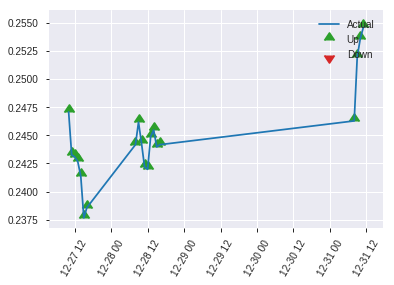


ModelMetricsBinomial: deeplearning
** Reported on test data. **

MSE: 0.264765132449173
RMSE: 0.5145533329492415
LogLoss: 0.726581911956145
Mean Per-Class Error: 0.4305421492921493
AUC: 0.5518822393822393
pr_auc: 0.5672325146619188
Gini: 0.1037644787644787
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.2895084476820236: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      3    108  0.973    (108.0/111.0)
1      1    111  0.0089   (1.0/112.0)
Total  4    219  0.4888   (109.0/223.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.289508     0.670695  218
max f2                       0.195403     0.834575  222
max f0point5                 0.588569     0.572183  113
max accuracy                 0.588569     0.569507  113
max precision                0.843533     1         0
max recall                   0.195403     1         222
max specificity              0.843533     1         0
max absolute_mcc             0.76995      0.201024  23
max min_per_class_accuracy   0.601381     0.5625    110
max mean_per_class_accuracy  0.588569     0.569458  113

Gains/Lift Table: Avg response rate: 50.22 %, avg score: 59.27 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain       cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  ---------  -----------------
    1        0.0134529                   0.82907            1.32738   1.32738            0.666667         0.834529  0.666667                    0.834529            0.0178571       0.0178571                  32.7381    32.7381
    2        0.0224215                   0.818923           1.99107   1.59286            1                0.826561  0.8                         0.831342            0.0178571       0.0357143                  99.1071    59.2857
    3        0.0313901                   0.806494           0.995536  1.42219            0.5              0.810045  0.714286                    0.825257            0.00892857      0.0446429                  -0.446429  42.2194
    4        0.0403587                   0.800733           1.99107   1.54861            1                0.802867  0.777778                    0.820282            0.0178571       0.0625                     99.1071    54.8611
    5        0.0538117                   0.799717           1.32738   1.4933             0.666667         0.800285  0.75                        0.815282            0.0178571       0.0803571                  32.7381    49.3304
    6        0.103139                    0.771323           1.62906   1.55823            0.818182         0.78591   0.782609                    0.801235            0.0803571       0.160714                   62.9058    55.823
    7        0.152466                    0.745985           0.543019  1.22978            0.272727         0.754447  0.617647                    0.786098            0.0267857       0.1875                     -45.6981   22.9779
    8        0.201794                    0.71975            0.905032  1.1504             0.454545         0.733434  0.577778                    0.773224            0.0446429       0.232143                   -9.49675   15.0397
    9        0.300448                    0.681214           0.814529  1.04011            0.409091         0.700761  0.522388                    0.74943             0.0803571       0.3125                     -18.5471   4.01119
    10       0.399103                    0.63421            1.26705   1.09621            0.636364         0.66119   0.550562                    0.727618            0.125           0.4375                     26.7045    9.62079
    11       0.502242                    0.594911           1.21196   1.11998            0.608696         0.617087  0.5625                      0.70492             0.125           0.5625                     21.1957    11.9978
    12       0.600897                    0.55272            0.905032  1.08469            0.454545         0.571833  0.544776                    0.68307             0.0892857       0.651786                   -9.49675   8.46882
    13       0.699552                    0.52297            0.452516  0.995536           0.227273         0.538386  0.5                         0.662666            0.0446429       0.696429                   -54.7484   -0.446429
    14       0.798206                    0.473994           1.08604   1.00672            0.545455         0.500626  0.505618                    0.642638            0.107143        0.803571                   8.6039     0.672151
    15       0.896861                    0.409194           0.995536  1.00549            0.5              0.448702  0.505                       0.621305            0.0982143       0.901786                   -0.446429  0.549107
    16       1                           0.195403           0.952252  1                  0.478261         0.343883  0.502242                 

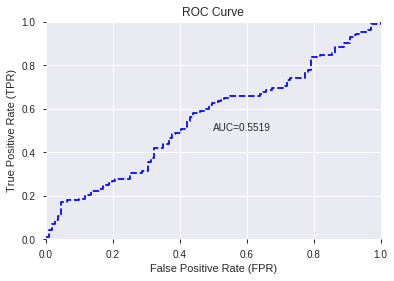

This function is available for GLM models only


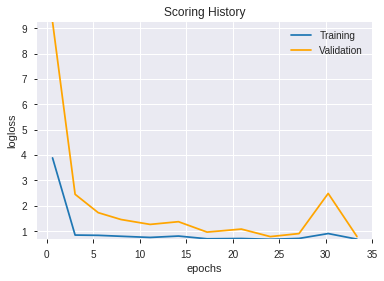

--2019-08-27 22:06:04--  https://h2o-release.s3.amazonaws.com/h2o/rel-yates/5/h2o-3.24.0.5.zip
Resolving h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)... 52.216.107.148
Connecting to h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)|52.216.107.148|:443... connected.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.

Archive:  h2o-3.24.0.5.zip
ERROR: Unknown MOJO type


[{'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Models/DeepLearning_grid_1_AutoML_20190827_213930_model_2',
   '__meta': {'schema_name': 'ModelKeyV3',
    'schema_type': 'Key<Model>',
    'schema_version': 3},
   'name': 'DeepLearning_grid_1_AutoML_20190827_213930_model_2',
   'type': 'Key<Model>'},
  'default_value': None,
  'gridable': False,
  'help': 'Destination id for this model; auto-generated if not specified.',
  'is_member_of_frames': [],
  'is_mutually_exclusive_with': [],
  'label': 'model_id',
  'level': 'critical',
  'name': 'model_id',
  'required': False,
  'type': 'Key<Model>',
  'values': []},
 {'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Frames/automl_training_py_74_sid_a8e7',
   '__meta': {'schema_name': 'FrameKeyV3',
    'schema_type': 'Key<Frame>',
    'schema_version': 3},
   'name': 'autom

['hour',
 'HT_TRENDMODE',
 'CORREL_12',
 'CORREL_14',
 'aroonup_8',
 'dayofweek',
 'BOP',
 'day',
 'weekday',
 'AROONOSC_8',
 'aroondown_8',
 'aroonup_14',
 'is_month_start',
 'STOCHRSI_fastk',
 'weekday_name',
 'CDLLONGLEGGEDDOJI',
 'SAREXT',
 'days_in_month',
 'CDLRICKSHAWMAN',
 'CDLHANGINGMAN',
 'CDLDOJI',
 'aroondown_30',
 'aroondown_12',
 'aroonup_24',
 'aroondown_20',
 'aroonup_20',
 'CDL3WHITESOLDIERS',
 'CORREL_8',
 'aroondown_24',
 'STOCHRSI_fastd',
 'aroonup_12',
 'HT_DCPERIOD',
 'CDLGAPSIDESIDEWHITE',
 'DX_8',
 'aroonup_30',
 'CDLSTALLEDPATTERN',
 'CDLTHRUSTING',
 'CDLEVENINGDOJISTAR',
 'BETA_20',
 'CDLMORNINGDOJISTAR',
 'BETA_12',
 'ADXR_8',
 'STOCHF_fastk',
 'CDLSPINNINGTOP',
 'CDLDARKCLOUDCOVER',
 'AROONOSC_12',
 'CORREL_20',
 'CORREL_30',
 'BETA_8',
 'ULTOSC',
 'SUB',
 'AROONOSC_30',
 'CDLCLOSINGMARUBOZU',
 'DIV',
 'aroondown_14',
 'AROONOSC_14',
 'STOCH_slowd',
 'BETA_14',
 'CDLMATCHINGLOW',
 'TRANGE',
 'PLUS_DI_30',
 'ADXR_14',
 'ADOSC',
 'ADX_24',
 'CDLIDENTICAL3CROWS

In [48]:
# DeepLearning with Select Family-wise error features
model_train(feature_name='Fwe',model_algo="DeepLearning",features_list=features_list)

AutoML progress: |████████████████████████████████████████████████████████| 100%


model_id       auc   logloss  mean_per_class_error     rmse       mse
0  GLM_grid_1_AutoML_20190827_220611_model_1  0.463803  0.695855              0.495455  0.50135  0.251352

variable  relative_importance  scaled_importance    percentage
0             is_month_start         9.011343e-03           1.000000  1.822794e-02
1                       hour         7.958030e-03           0.883113  1.609732e-02
2                CDLMARUBOZU         7.255164e-03           0.805115  1.467558e-02
3              CDLHANGINGMAN         6.362054e-03           0.706005  1.286902e-02
4        CDLGAPSIDESIDEWHITE         5.381129e-03           0.597151  1.088482e-02
...                      ...                  ...                ...           ...
1028  BBANDS_lowerband_8_4_3         4.341012e-07           0.000048  8.780900e-07
1029                    High         2.989536e-07           0.000033  6.047165e-07
1030                  MA_8_7         2.870169e-07           0.000032  5.805711e-07
1031  BBANDS_lowerband_8_5_5         1.608173e-07           0.000018  3.252975e-07
1032                  WMA_14         3.636541e-08           0.000004  7.355912e-08

[1033 rows x 4 columns]

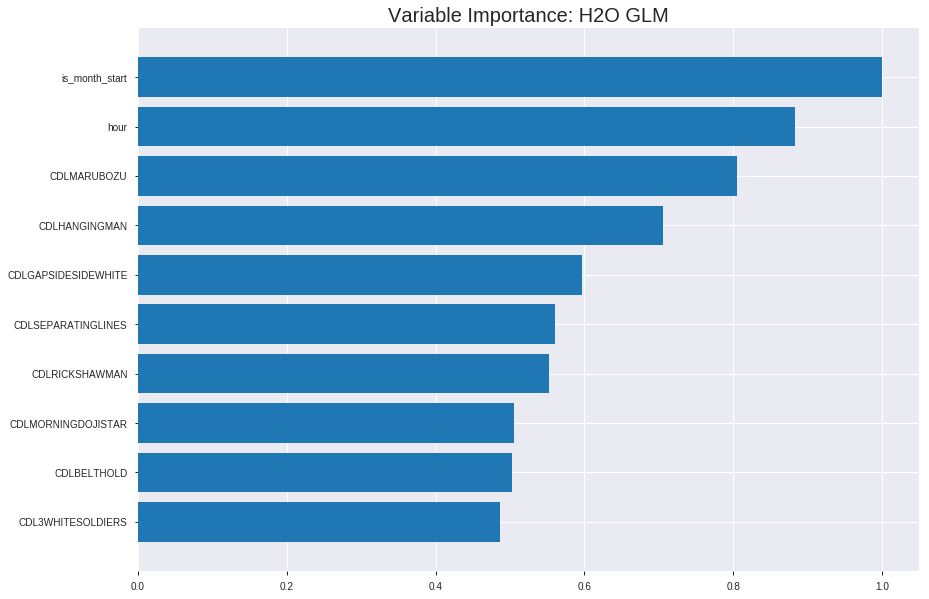

Model Details
H2OGeneralizedLinearEstimator :  Generalized Linear Modeling
Model Key:  GLM_grid_1_AutoML_20190827_220611_model_1


ModelMetricsBinomialGLM: glm
** Reported on train data. **

MSE: 0.2471126934483995
RMSE: 0.4971043084186653
LogLoss: 0.6873450774922317
Null degrees of freedom: 1557
Residual degrees of freedom: 524
Null deviance: 2159.8055361387533
Residual deviance: 2141.767261465794
AIC: 4209.767261465794
AUC: 0.5811222345816339
pr_auc: 0.5807992869315382
Gini: 0.16224446916326785
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.36950172173528534: 


0    1     Error    Rate
-----  ---  ----  -------  --------------
0      7    776   0.9911   (776.0/783.0)
1      1    774   0.0013   (1.0/775.0)
Total  8    1550  0.4987   (777.0/1558.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.369502     0.665806  392
max f2                       0.366831     0.832617  395
max f0point5                 0.498265     0.569097  187
max accuracy                 0.506306     0.563543  144
max precision                0.555245     1         0
max recall                   0.366831     1         395
max specificity              0.555245     1         0
max absolute_mcc             0.499864     0.128713  178
max min_per_class_accuracy   0.504429     0.55871   155
max mean_per_class_accuracy  0.499864     0.563354  178

Gains/Lift Table: Avg response rate: 49.74 %, avg score: 49.74 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0102696                   0.535377           1.75903   1.75903            0.875            0.541521  0.875                       0.541521            0.0180645       0.0180645                  75.9032   75.9032
    2        0.0205392                   0.531946           1.50774   1.63339            0.75             0.533431  0.8125                      0.537476            0.0154839       0.0335484                  50.7742   63.3387
    3        0.0301669                   0.528951           1.34022   1.53982            0.666667         0.530417  0.765957                    0.535223            0.0129032       0.0464516                  34.0215   53.9822
    4        0.0404365                   0.527218           1.63339   1.56358            0.8125           0.528107  0.777778                    0.533416            0.0167742       0.0632258                  63.3387   56.3584
    5        0.0500642                   0.526496           1.20619   1.49486            0.6              0.526902  0.74359                     0.532163            0.0116129       0.0748387                  20.6194   49.4855
    6        0.100128                    0.522222           1.00516   1.25001            0.5              0.524094  0.621795                    0.528128            0.0503226       0.125161                   0.516129  25.0008
    7        0.150193                    0.519257           1.10825   1.20276            0.551282         0.520695  0.598291                    0.525651            0.0554839       0.180645                   10.8255   20.2757
    8        0.200257                    0.517054           1.08248   1.17269            0.538462         0.518102  0.583333                    0.523763            0.0541935       0.234839                   8.24814   17.2688
    9        0.300385                    0.512794           1.17269   1.17269            0.583333         0.514973  0.583333                    0.520833            0.117419        0.352258                   17.2688   17.2688
    10       0.399872                    0.508904           1.05056   1.1423             0.522581         0.510802  0.568218                    0.518337            0.104516        0.456774                   5.05557   14.2302
    11       0.5                         0.504121           1.01805   1.11742            0.50641          0.50655   0.555841                    0.515977            0.101935        0.55871                    1.8048    11.7419
    12       0.600128                    0.49913            1.01805   1.10084            0.50641          0.501735  0.547594                    0.513601            0.101935        0.660645                   1.8048    10.084
    13       0.699615                    0.491858           0.843039  1.06418            0.419355         0.495478  0.529358                    0.511024            0.083871        0.744516                   -15.6961  6.41799
    14       0.799743                    0.482686           0.927841  1.04711            0.461538         0.487848  0.520867                    0.508122            0.0929032       0.837419                   -7.21588  4.71102
    15       0.899872                    0.466901           0.902068  1.03097            0.448718         0.475219  0.512839                    0.504461            0.0903226       0.927742                   -9.79322  3.09714
    16       1                           0.357487           0.721654  1                  0.358974         0.434269  0.497433                    0.497433          



ModelMetricsBinomialGLM: glm
** Reported on validation data. **

MSE: 0.2552380643859141
RMSE: 0.5052109107946048
LogLoss: 0.7040282448964653
Null degrees of freedom: 444
Residual degrees of freedom: -589
Null deviance: 617.0462294114567
Residual deviance: 626.5851379578542
AIC: 2694.5851379578544
AUC: 0.4675218340611354
pr_auc: 0.5008466004506479
Gini: -0.0649563318777292
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.2967103817498353: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      0    216  1        (216.0/216.0)
1      0    229  0        (0.0/229.0)
Total  0    445  0.4854   (216.0/445.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value      idx
---------------------------  -----------  ---------  -----
max f1                       0.29671      0.679525   399
max f2                       0.29671      0.841293   399
max f0point5                 0.29671      0.569935   399
max accuracy                 0.429752     0.516854   362
max precision                0.523539     0.75       3
max recall                   0.29671      1          399
max specificity              0.532953     0.99537    0
max absolute_mcc             0.462419     0.0949498  299
max min_per_class_accuracy   0.480939     0.467249   190
max mean_per_class_accuracy  0.506195     0.509027   60

Gains/Lift Table: Avg response rate: 51.46 %, avg score: 47.41 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.011236                    0.521023           1.16594   1.16594            0.6              0.52652   0.6                         0.52652             0.0131004       0.0131004                  16.5939   16.5939
    2        0.0202247                   0.517176           1.45742   1.29549            0.75             0.518799  0.666667                    0.523089            0.0131004       0.0262009                  45.7424   29.5488
    3        0.0314607                   0.516501           0.388646  0.971616           0.2              0.516986  0.5                         0.520909            0.00436681      0.0305677                  -61.1354  -2.83843
    4        0.0404494                   0.514175           0.485808  0.863658           0.25             0.515607  0.444444                    0.519731            0.00436681      0.0349345                  -51.4192  -13.6342
    5        0.0516854                   0.512708           0.777293  0.844883           0.4              0.513253  0.434783                    0.518323            0.00873362      0.0436681                  -22.2707  -15.5117
    6        0.101124                    0.509925           1.32493   1.07957            0.681818         0.511289  0.555556                    0.514884            0.0655022       0.10917                    32.4931   7.9573
    7        0.150562                    0.506233           0.971616  1.04412            0.5              0.50826   0.537313                    0.512709            0.0480349       0.157205                   -2.83843  4.41244
    8        0.2                         0.501861           0.618301  0.938865           0.318182         0.504726  0.483146                    0.510736            0.0305677       0.187773                   -38.1699  -6.11354
    9        0.301124                    0.495597           1.07957   0.986117           0.555556         0.499039  0.507463                    0.506808            0.10917         0.296943                   7.9573    -1.38826
    10       0.4                         0.487043           0.927451  0.971616           0.477273         0.491572  0.5                         0.503042            0.0917031       0.388646                   -7.25486  -2.83843
    11       0.501124                    0.480867           0.777293  0.932403           0.4              0.48393   0.479821                    0.499185            0.0786026       0.467249                   -22.2707  -6.75975
    12       0.6                         0.475154           1.05994   0.953421           0.545455         0.477785  0.490637                    0.495659            0.104803        0.572052                   5.99444   -4.65793
    13       0.698876                    0.468394           1.01578   0.962243           0.522727         0.471904  0.495177                    0.492298            0.100437        0.672489                   1.57801   -3.77568
    14       0.8                         0.457644           1.07957   0.977074           0.555556         0.463625  0.502809                    0.488673            0.10917         0.781659                   7.9573    -2.29258
    15       0.898876                    0.436625           1.10411   0.991048           0.568182         0.449371  0.51                        0.48435             0.10917         0.89083                    10.4109   -0.895197
    16       1                           0.29671            1.07957   1                  0.555556         0.38331   0.514607                    0.4741


Scoring History: 


timestamp            duration    iteration    lambda    predictors    deviance_train    deviance_test
--  -------------------  ----------  -----------  --------  ------------  ----------------  ---------------
    2019-08-27 22:06:14  0.000 sec   2            3.7       1034          1.37469           1.40806
    2019-08-27 22:06:16  2.078 sec   4            2.7       1034          1.37223           1.4104
    2019-08-27 22:06:18  4.034 sec   6            2         1034          1.36922           1.4126
    2019-08-27 22:06:20  6.088 sec   8            1.4       1034          1.3656            1.41497
    2019-08-27 22:06:22  8.054 sec   10           1         1034          1.36133           1.41763

/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:7116: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


('accuracy', 0.5067264573991032)

('F1', 0.6686746987951807)

('auc', 0.4638030888030888)

('logloss', 0.6958548161972192)

('mean_per_class_error', 0.4910714285714286)

('rmse', 0.5013502524672452)

('mse', 0.25135207564897044)

glm prediction progress: |████████████████████████████████████████████████| 100%


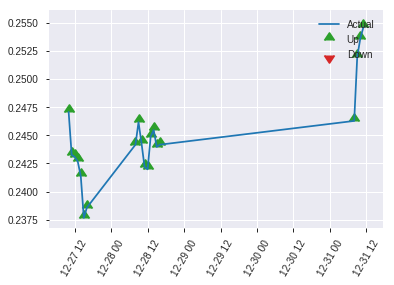


ModelMetricsBinomialGLM: glm
** Reported on test data. **

MSE: 0.25135207564897044
RMSE: 0.5013502524672452
LogLoss: 0.6958548161972192
Null degrees of freedom: 222
Residual degrees of freedom: -811
Null deviance: 309.1597919029809
Residual deviance: 310.35124802395967
AIC: 2378.3512480239597
AUC: 0.4638030888030888
pr_auc: 0.4847077738707101
Gini: -0.07239382239382242
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.45877246707242336: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      2    109  0.982    (109.0/111.0)
1      1    111  0.0089   (1.0/112.0)
Total  3    220  0.4933   (110.0/223.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.458772     0.668675  219
max f2                       0.440375     0.834575  222
max f0point5                 0.458772     0.559476  219
max accuracy                 0.529681     0.506726  1
max precision                0.533952     1         0
max recall                   0.440375     1         222
max specificity              0.533952     1         0
max absolute_mcc             0.494159     0.103065  108
max min_per_class_accuracy   0.493954     0.459459  111
max mean_per_class_accuracy  0.529681     0.508929  1

Gains/Lift Table: Avg response rate: 50.22 %, avg score: 49.32 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain       cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  ---------  -----------------
    1        0.0134529                   0.5292             1.32738   1.32738            0.666667         0.530954  0.666667                    0.530954            0.0178571       0.0178571                  32.7381    32.7381
    2        0.0224215                   0.525875           0.995536  1.19464            0.5              0.527763  0.6                         0.529678            0.00892857      0.0267857                  -0.446429  19.4643
    3        0.0313901                   0.524809           0.995536  1.13776            0.5              0.525144  0.571429                    0.528382            0.00892857      0.0357143                  -0.446429  13.7755
    4        0.0403587                   0.523917           0         0.884921           0                0.524479  0.444444                    0.527515            0               0.0357143                  -100       -11.5079
    5        0.0538117                   0.521235           1.32738   0.995536           0.666667         0.522418  0.5                         0.526241            0.0178571       0.0535714                  32.7381    -0.446429
    6        0.103139                    0.515548           0.905032  0.952252           0.454545         0.518024  0.478261                    0.522311            0.0446429       0.0982143                  -9.49675   -4.77484
    7        0.152466                    0.51356            1.26705   1.0541             0.636364         0.51472   0.529412                    0.519855            0.0625          0.160714                   26.7045    5.40966
    8        0.201794                    0.508764           0.543019  0.929167           0.272727         0.51077   0.466667                    0.517634            0.0267857       0.1875                     -45.6981   -7.08333
    9        0.300448                    0.503381           1.08604   0.980677           0.545455         0.506068  0.492537                    0.513836            0.107143        0.294643                   8.6039     -1.9323
    10       0.399103                    0.498627           0.633523  0.894864           0.318182         0.501225  0.449438                    0.510719            0.0625          0.357143                   -36.6477   -10.5136
    11       0.502242                    0.493954           1.03882   0.924426           0.521739         0.495838  0.464286                    0.507663            0.107143        0.464286                   3.88199    -7.5574
    12       0.600897                    0.488893           1.08604   0.950959           0.545455         0.49174   0.477612                    0.505049            0.107143        0.571429                   8.6039     -4.90405
    13       0.699552                    0.483662           0.995536  0.957246           0.5              0.486133  0.480769                    0.502381            0.0982143       0.669643                   -0.446429  -4.27541
    14       0.798206                    0.476731           1.08604   0.973164           0.545455         0.480644  0.488764                    0.499695            0.107143        0.776786                   8.6039     -2.68359
    15       0.896861                    0.468237           1.17654   0.995536           0.590909         0.473366  0.5                         0.496798            0.116071        0.892857                   17.6542    -0.446429
    16       1                           0.440375           1.03882   1                  0.521739         0.462358  0.502242         

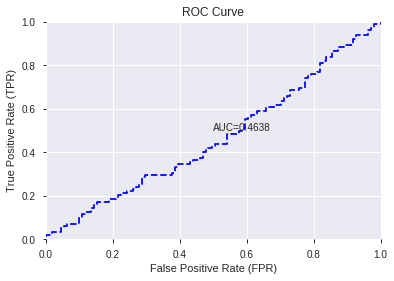

/usr/local/lib/python3.6/dist-packages/matplotlib/cbook/__init__.py:424: MatplotlibDeprecationWarning: 
Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warn_deprecated("2.2", "Passing one of 'on', 'true', 'off', 'false' as a "


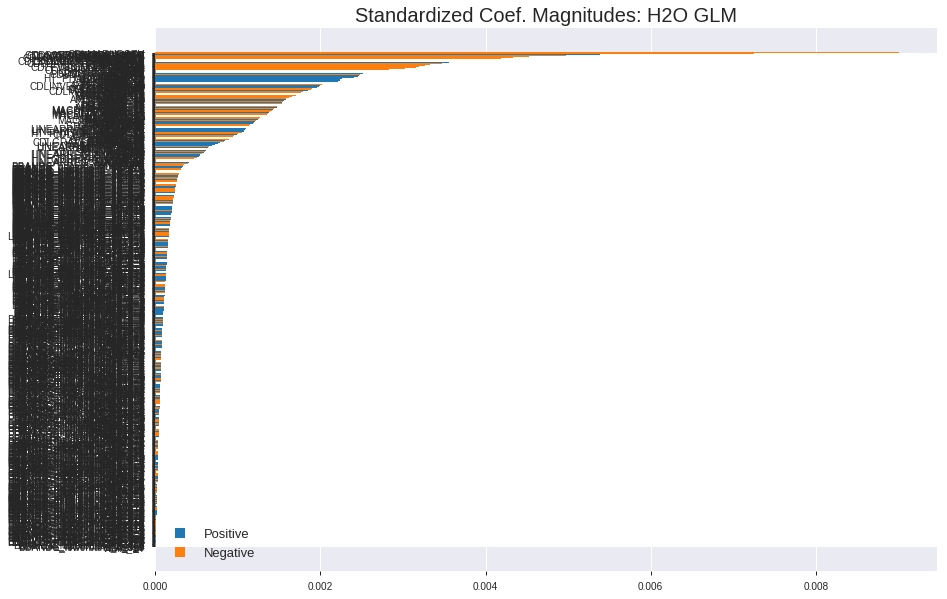

'log_likelihood'
--2019-08-27 22:06:48--  https://h2o-release.s3.amazonaws.com/h2o/rel-yates/5/h2o-3.24.0.5.zip
Resolving h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)... 52.216.232.203
Connecting to h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)|52.216.232.203|:443... connected.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.

Archive:  h2o-3.24.0.5.zip
ERROR: Unknown MOJO type


[{'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Models/GLM_grid_1_AutoML_20190827_220611_model_1',
   '__meta': {'schema_name': 'ModelKeyV3',
    'schema_type': 'Key<Model>',
    'schema_version': 3},
   'name': 'GLM_grid_1_AutoML_20190827_220611_model_1',
   'type': 'Key<Model>'},
  'default_value': None,
  'gridable': False,
  'help': 'Destination id for this model; auto-generated if not specified.',
  'is_member_of_frames': [],
  'is_mutually_exclusive_with': [],
  'label': 'model_id',
  'level': 'critical',
  'name': 'model_id',
  'required': False,
  'type': 'Key<Model>',
  'values': []},
 {'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Frames/automl_training_py_82_sid_a8e7',
   '__meta': {'schema_name': 'FrameKeyV3',
    'schema_type': 'Key<Frame>',
    'schema_version': 3},
   'name': 'automl_training_py_82_s

['is_month_start',
 'hour',
 'CDLMARUBOZU',
 'CDLHANGINGMAN',
 'CDLGAPSIDESIDEWHITE',
 'CDLSEPARATINGLINES',
 'CDLRICKSHAWMAN',
 'CDLMORNINGDOJISTAR',
 'CDLBELTHOLD',
 'CDL3WHITESOLDIERS',
 'CDLCLOSINGMARUBOZU',
 'CDL3OUTSIDE',
 'CDLTAKURI',
 'SAREXT',
 'CDLDOJI',
 'CDLDRAGONFLYDOJI',
 'CDLLONGLEGGEDDOJI',
 'CDLXSIDEGAP3METHODS',
 'CORREL_8',
 'DIV',
 'CDLDARKCLOUDCOVER',
 'ADOSC',
 'CORREL_12',
 'TRANGE',
 'HT_TRENDMODE',
 'VAR_8',
 'DX_30',
 'BOP',
 'CORREL_20',
 'CDLEVENINGDOJISTAR',
 'CDLLONGLINE',
 'DX_24',
 'CDLTHRUSTING',
 'DX_20',
 'Volume',
 'ADX_20',
 'CDLSHOOTINGSTAR',
 'ADX_24',
 'SUB',
 'CDL3LINESTRIKE',
 'ADX_14',
 'CDLHIKKAKEMOD',
 'weekday',
 'dayofweek',
 'CDLMORNINGSTAR',
 'ADXR_14',
 'PLUS_DM_8',
 'CCI_8',
 'HT_DCPERIOD',
 'aroondown_30',
 'aroondown_20',
 'HT_PHASOR_inphase',
 'CORREL_30',
 'ADX_12',
 'MOM_14',
 'is_month_end',
 'aroondown_14',
 'DX_14',
 'ROCR_14',
 'ROCR100_14',
 'ROC_14',
 'ROCP_14',
 'MFI_20',
 'NATR_8',
 'AROONOSC_14',
 'PLUS_DM_12',
 'BETA_30'

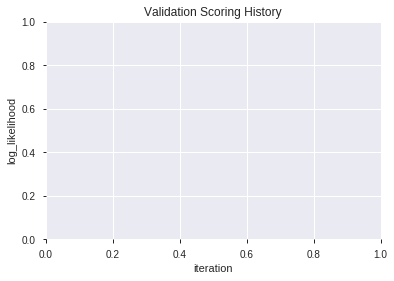

In [49]:
# GLM with Select Family-wise error features
model_train(feature_name='Fwe',model_algo="GLM",features_list=features_list)

AutoML progress: |████████████████████████████████████████████████████████| 100%


model_id       auc   logloss  mean_per_class_error      rmse       mse
0  XGBoost_grid_1_AutoML_20190827_220654_model_2  0.580840  0.685247              0.500000  0.496043  0.246059
1               XGBoost_3_AutoML_20190827_220654  0.577301  0.683530              0.490991  0.495214  0.245237
2  XGBoost_grid_1_AutoML_20190827_220654_model_1  0.562661  0.686133              0.423102  0.496624  0.246636
3  XGBoost_grid_1_AutoML_20190827_220654_model_6  0.556548  0.693945              0.500000  0.500384  0.250384
4               XGBoost_2_AutoML_20190827_220654  0.552365  0.690473              0.436535  0.498594  0.248596
5  XGBoost_grid_1_AutoML_20190827_220654_model_4  0.533301  0.691701              0.486446  0.499268  0.249269
6               XGBoost_1_AutoML_20190827_220654  0.530245  0.703375              0.477357  0.504770  0.254793
7  XGBoost_grid_1_AutoML_20190827_220654_model_3  0.522281  0.700420              0.490991  0.503484  0.253496
8  XGBoost_grid_1_AutoML_20190827_220654_model_7  0.514157  0.709515              0.500000  0.507433  0.257489
9  XGBoost_grid_1_AutoML_20190827_220654_model_5  0.501046  0.720587              0.490911  0.512524  0.262680

variable  relative_importance  scaled_importance  percentage
0                STOCH_slowk           147.525299           1.000000    0.024573
1                        DIV           136.197693           0.923216    0.022686
2                     BETA_8           124.451866           0.843597    0.020730
3                       hour           121.882675           0.826182    0.020302
4                        BOP           120.121437           0.814243    0.020008
..                       ...                  ...                ...         ...
283  BBANDS_lowerband_14_6_4             0.403030           0.002732    0.000067
284   BBANDS_lowerband_8_6_5             0.317564           0.002153    0.000053
285  BBANDS_upperband_12_7_5             0.282954           0.001918    0.000047
286   BBANDS_upperband_8_0_3             0.258486           0.001752    0.000043
287   BBANDS_lowerband_8_7_2             0.178977           0.001213    0.000030

[288 rows x 4 columns]

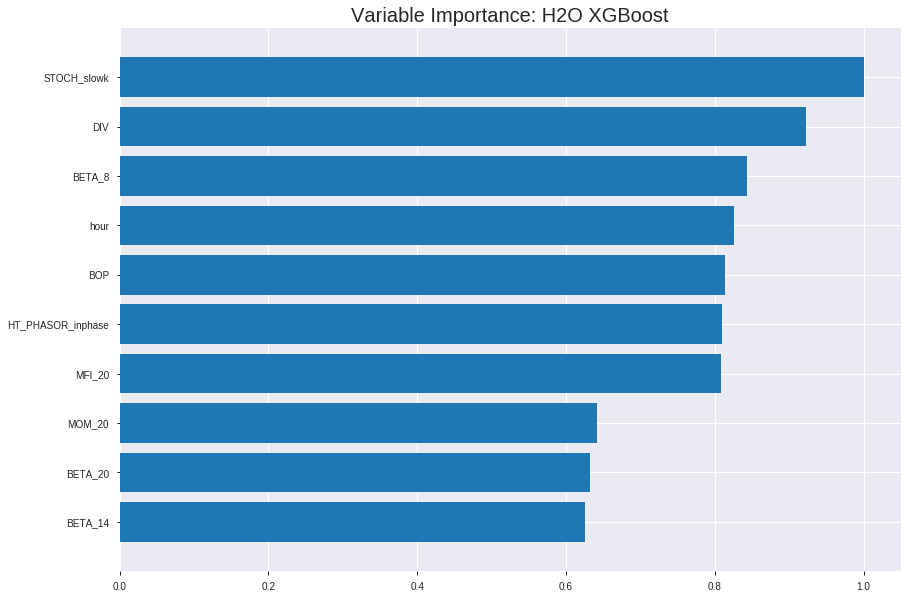

Model Details
H2OXGBoostEstimator :  XGBoost
Model Key:  XGBoost_grid_1_AutoML_20190827_220654_model_2


ModelMetricsBinomial: xgboost
** Reported on train data. **

MSE: 0.1767559671598821
RMSE: 0.42042355685651356
LogLoss: 0.5431420175225887
Mean Per-Class Error: 0.1025600461418037
AUC: 0.960248836155399
pr_auc: 0.9592023689309849
Gini: 0.920497672310798
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.4903517812490463: 


0    1    Error    Rate
-----  ---  ---  -------  --------------
0      682  101  0.129    (101.0/783.0)
1      59   716  0.0761   (59.0/775.0)
Total  741  817  0.1027   (160.0/1558.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.490352     0.899497  204
max f2                       0.44816      0.927193  243
max f0point5                 0.528436     0.911208  168
max accuracy                 0.491188     0.897304  203
max precision                0.750754     1         0
max recall                   0.369227     1         323
max specificity              0.750754     1         0
max absolute_mcc             0.490352     0.795817  204
max min_per_class_accuracy   0.500751     0.888889  193
max mean_per_class_accuracy  0.490352     0.89744   204

Gains/Lift Table: Avg response rate: 49.74 %, avg score: 49.89 %



group    cumulative_data_fraction    lower_threshold    lift       cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  ---------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0102696                   0.703919           2.01032    2.01032            1                0.724368  1                           0.724368            0.0206452       0.0206452                  101.032   101.032
    2        0.0205392                   0.686479           2.01032    2.01032            1                0.694376  1                           0.709372            0.0206452       0.0412903                  101.032   101.032
    3        0.0301669                   0.679647           2.01032    2.01032            1                0.683468  1                           0.701105            0.0193548       0.0606452                  101.032   101.032
    4        0.0404365                   0.673643           2.01032    2.01032            1                0.67621   1                           0.694782            0.0206452       0.0812903                  101.032   101.032
    5        0.0500642                   0.66665            2.01032    2.01032            1                0.670661  1                           0.690144            0.0193548       0.100645                   101.032   101.032
    6        0.100128                    0.641614           2.01032    2.01032            1                0.65395   1                           0.672047            0.100645        0.20129                    101.032   101.032
    7        0.150193                    0.622301           1.98455    2.00173            0.987179         0.629946  0.995726                    0.658013            0.0993548       0.300645                   98.4549   100.173
    8        0.200257                    0.600695           1.95878    1.99099            0.974359         0.611247  0.990385                    0.646322            0.0980645       0.39871                    95.8776   99.0993
    9        0.300385                    0.572774           1.90723    1.96307            0.948718         0.586729  0.976496                    0.626457            0.190968        0.589677                   90.7229   96.3071
    10       0.399872                    0.540109           1.7639     1.91352            0.877419         0.556665  0.951846                    0.609093            0.175484        0.765161                   76.3896   91.3517
    11       0.5                         0.49981            1.26289    1.78323            0.628205         0.519087  0.887035                    0.591069            0.126452        0.891613                   26.2895   78.3226
    12       0.600128                    0.459728           0.682994   1.59966            0.339744         0.479662  0.795722                    0.572481            0.0683871       0.96                       -31.7006  59.9658
    13       0.699615                    0.429227           0.272366   1.41091            0.135484         0.443769  0.701835                    0.554178            0.0270968       0.987097                   -72.7634  41.0914
    14       0.799743                    0.394618           0.0902068  1.24556            0.0448718        0.411566  0.619583                    0.536323            0.00903226      0.996129                   -90.9793  24.5561
    15       0.899872                    0.353379           0.03866    1.11127            0.0192308        0.373222  0.552782                    0.518175            0.00387097      1                          -96.134   11.127
    16       1                           0.260092           0          1                  0                0.325577  0.497433                    



ModelMetricsBinomial: xgboost
** Reported on validation data. **

MSE: 0.2598380537009911
RMSE: 0.5097431252120926
LogLoss: 0.7132085547688884
Mean Per-Class Error: 0.4943696425683325
AUC: 0.4569383794274624
pr_auc: 0.4885543282370441
Gini: -0.08612324114507519
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.3559393584728241: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      2    214  0.9907   (214.0/216.0)
1      0    229  0        (0.0/229.0)
Total  2    443  0.4809   (214.0/445.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.355939     0.681548  397
max f2                       0.355939     0.842531  397
max f0point5                 0.355939     0.572214  397
max accuracy                 0.355939     0.519101  397
max precision                0.613084     0.588235  16
max recall                   0.355939     1         397
max specificity              0.668801     0.99537   0
max absolute_mcc             0.432758     0.138536  324
max min_per_class_accuracy   0.504308     0.472222  197
max mean_per_class_accuracy  0.613084     0.50563   16

Gains/Lift Table: Avg response rate: 51.46 %, avg score: 49.98 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain       cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  ---------  -----------------
    1        0.011236                    0.64607            0.777293  0.777293           0.4              0.652856  0.4                         0.652856            0.00873362      0.00873362                 -22.2707   -22.2707
    2        0.0202247                   0.637701           0.971616  0.863658           0.5              0.64313   0.444444                    0.648534            0.00873362      0.0174672                  -2.83843   -13.6342
    3        0.0314607                   0.620483           1.16594   0.971616           0.6              0.6276    0.5                         0.641057            0.0131004       0.0305677                  16.5939    -2.83843
    4        0.0404494                   0.612015           1.45742   1.07957            0.75             0.616034  0.555556                    0.635497            0.0131004       0.0436681                  45.7424    7.9573
    5        0.0516854                   0.607975           0.388646  0.929372           0.2              0.610541  0.478261                    0.630072            0.00436681      0.0480349                  -61.1354   -7.06284
    6        0.101124                    0.586534           0.794958  0.863658           0.409091         0.596299  0.444444                    0.613561            0.0393013       0.0873362                  -20.5042   -13.6342
    7        0.150562                    0.567162           0.971616  0.899107           0.5              0.576109  0.462687                    0.601263            0.0480349       0.135371                   -2.83843   -10.0893
    8        0.2                         0.557692           1.2366    0.982533           0.636364         0.5619    0.505618                    0.591533            0.0611354       0.196507                   23.6602    -1.74672
    9        0.301124                    0.537414           0.906841  0.957114           0.466667         0.547555  0.492537                    0.576764            0.0917031       0.28821                    -9.31587   -4.2886
    10       0.4                         0.517823           1.01578   0.971616           0.522727         0.527407  0.5                         0.564564            0.100437        0.388646                   1.57801    -2.83843
    11       0.501124                    0.504293           0.863658  0.949831           0.444444         0.510839  0.488789                    0.553722            0.0873362       0.475983                   -13.6342   -5.01694
    12       0.6                         0.484687           0.971616  0.953421           0.5              0.495926  0.490637                    0.544198            0.0960699       0.572052                   -2.83843   -4.65793
    13       0.698876                    0.461798           0.794958  0.931002           0.409091         0.473766  0.4791                      0.534233            0.0786026       0.650655                   -20.5042   -6.89984
    14       0.8                         0.437602           0.993207  0.938865           0.511111         0.448321  0.483146                    0.523374            0.100437        0.751092                   -0.679282  -6.11354
    15       0.898876                    0.410226           1.2366    0.971616           0.636364         0.425508  0.5                         0.512608            0.122271        0.873362                   23.6602    -2.83843
    16       1                           0.34997            1.2523    1                  0.644444         0.38634   0.514607        


Scoring History: 


timestamp            duration    number_of_trees    training_rmse    training_logloss    training_auc    training_pr_auc    training_lift    training_classification_error    validation_rmse    validation_logloss    validation_auc    validation_pr_auc    validation_lift    validation_classification_error
--  -------------------  ----------  -----------------  ---------------  ------------------  --------------  -----------------  ---------------  -------------------------------  -----------------  --------------------  ----------------  -------------------  -----------------  ---------------------------------
    2019-08-27 22:07:13  3.262 sec   0                  0.5              0.693147            0.5             0                  1                0.502567                         0.5                0.693147              0.5               0                    1                  0.485393
    2019-08-27 22:07:14  4.390 sec   5                  0.489857         0.673045            0.791642        0.751833           1.52507          0.293325                         0.502604           0.698374              0.420124          0.46635              1.16594            0.485393
    2019-08-27 22:07:15  4.630 sec   10                 0.480723         0.655222            0.84706         0.832585           1.88468          0.251605                         0.502673           0.698518              0.443312          0.473801             0.388646           0.483146
    2019-08-27 22:07:15  4.870 sec   15                 0.471894         0.638213            0.873874        0.864879           2.01032          0.20154                          0.503747           0.700694              0.445738          0.477737             0.777293           0.480899
    2019-08-27 22:07:15  5.106 sec   20                 0.463452         0.622153            0.896908        0.894218           2.01032          0.186778                         0.504671           0.702584              0.449428          0.47703              0.388646           0.480899
    2019-08-27 22:07:15  5.347 sec   25                 0.455054         0.606363            0.913678        0.913109           2.01032          0.160462                         0.505465           0.704209              0.451682          0.481871             0.777293           0.480899
    2019-08-27 22:07:16  5.595 sec   30                 0.447441         0.592185            0.925702        0.925152           2.01032          0.158537                         0.507069           0.707528              0.448478          0.474571             0.388646           0.476404
    2019-08-27 22:07:16  5.843 sec   35                 0.440132         0.578757            0.937564        0.937307           2.01032          0.144416                         0.506901           0.707226              0.461386          0.481628             0.388646           0.480899
    2019-08-27 22:07:16  6.086 sec   40                 0.433122         0.566008            0.948088        0.948452           2.01032          0.130937                         0.507395           0.708271              0.463398          0.4897               0.777293           0.483146
    2019-08-27 22:07:16  6.331 sec   45                 0.427105         0.555096            0.953546        0.953443           2.01032          0.113607                         0.508741           0.711088              0.457171          0.486363             0.388646           0.483146
    2019-08-27 22:07:17  6.583 sec   50                 0.420424         0.543142            0.960249        0.959202           2.01032          0.102696                         0.509743           0.713209              0.456938          0.488554             0.777293           0.480899

Variable Importances: 


variable                 relative_importance    scaled_importance      percentage
-----------------------  ---------------------  ---------------------  ----------------------
STOCH_slowk              147.52529907226562     1.0                    0.02457310282633292
DIV                      136.19769287109375     0.9232158397752306     0.02268627776169604
BETA_8                   124.45186614990234     0.8435967724352099     0.02072979023301299
hour                     121.88267517089844     0.8261815155595374     0.020301843335060087
BOP                      120.1214370727539      0.8142429659736675     0.02000847612848923
---                      ---                    ---                    ---
BBANDS_lowerband_14_6_4  0.4030301570892334     0.0027319392648159154  6.713222446961785e-05
BBANDS_lowerband_8_6_5   0.3175641596317291     0.0021526081399514366  5.289626116782791e-05
BBANDS_upperband_12_7_5  0.2829543352127075     0.0019180055013757447  4.713134640677841e-05
BBANDS_upperband_8_0_3   0.25848570466041565    0.0017521449289439894  4.3055637505578445e-05
BBANDS_lowerband_8_7_2   0.17897723615169525    0.0012131969043765356  2.98120122798334e-05


See the whole table with table.as_data_frame()


/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:7116: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


('accuracy', 0.5829596412556054)

('F1', 0.6686567164179104)

('auc', 0.5808397683397684)

('logloss', 0.6852474783730368)

('mean_per_class_error', 0.41622425997426005)

('rmse', 0.49604324093545177)

('mse', 0.24605889687774668)

xgboost prediction progress: |████████████████████████████████████████████| 100%


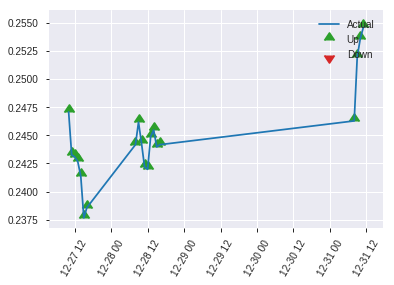


ModelMetricsBinomial: xgboost
** Reported on test data. **

MSE: 0.24605889687774668
RMSE: 0.49604324093545177
LogLoss: 0.6852474783730368
Mean Per-Class Error: 0.41622425997426005
AUC: 0.5808397683397684
pr_auc: 0.5771076368137525
Gini: 0.16167953667953672
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.37471964955329895: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      0    111  1        (111.0/111.0)
1      0    112  0        (0.0/112.0)
Total  0    223  0.4978   (111.0/223.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.37472      0.668657  222
max f2                       0.37472      0.834575  222
max f0point5                 0.486016     0.587432  154
max accuracy                 0.53495      0.58296   70
max precision                0.632385     1         0
max recall                   0.37472      1         222
max specificity              0.632385     1         0
max absolute_mcc             0.53495      0.179832  70
max min_per_class_accuracy   0.510976     0.558559  111
max mean_per_class_accuracy  0.53495      0.583776  70

Gains/Lift Table: Avg response rate: 50.22 %, avg score: 50.83 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain       cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  ---------  -----------------
    1        0.0134529                   0.623973           1.99107   1.99107            1                0.628764  1                           0.628764            0.0267857       0.0267857                  99.1071    99.1071
    2        0.0224215                   0.609052           1.99107   1.99107            1                0.616991  1                           0.624055            0.0178571       0.0446429                  99.1071    99.1071
    3        0.0313901                   0.599037           0.995536  1.70663            0.5              0.601055  0.857143                    0.617483            0.00892857      0.0535714                  -0.446429  70.6633
    4        0.0403587                   0.594421           0.995536  1.54861            0.5              0.598085  0.777778                    0.613173            0.00892857      0.0625                     -0.446429  54.8611
    5        0.0538117                   0.588629           0         1.16146            0                0.590946  0.583333                    0.607616            0               0.0625                     -100       16.1458
    6        0.103139                    0.574921           1.08604   1.12539            0.545455         0.580915  0.565217                    0.594846            0.0535714       0.116071                   8.6039     12.5388
    7        0.152466                    0.558882           1.26705   1.17122            0.636364         0.565764  0.588235                    0.585437            0.0625          0.178571                   26.7045    17.1218
    8        0.201794                    0.552615           1.08604   1.1504             0.545455         0.556118  0.577778                    0.57827             0.0535714       0.232143                   8.6039     15.0397
    9        0.300448                    0.536893           1.35755   1.21842            0.681818         0.544945  0.61194                     0.567328            0.133929        0.366071                   35.7549    21.8417
    10       0.399103                    0.521984           0.905032  1.14095            0.454545         0.530739  0.573034                    0.558283            0.0892857       0.455357                   -9.49675   14.0951
    11       0.502242                    0.510976           1.03882   1.11998            0.521739         0.515756  0.5625                      0.54955             0.107143        0.5625                     3.88199    11.9978
    12       0.600897                    0.499635           0.905032  1.08469            0.454545         0.503826  0.544776                    0.542043            0.0892857       0.651786                   -9.49675   8.46882
    13       0.699552                    0.4837             1.17654   1.09764            0.590909         0.492913  0.551282                    0.535114            0.116071        0.767857                   17.6542    9.76419
    14       0.798206                    0.460895           0.814529  1.06265            0.409091         0.47575   0.533708                    0.527777            0.0803571       0.848214                   -18.5471   6.26505
    15       0.896861                    0.439539           0.633523  1.01545            0.318182         0.450262  0.51                        0.519251            0.0625          0.910714                   -36.6477   1.54464
    16       1                           0.37472            0.865683  1                  0.434783         0.412678  0.502242                    

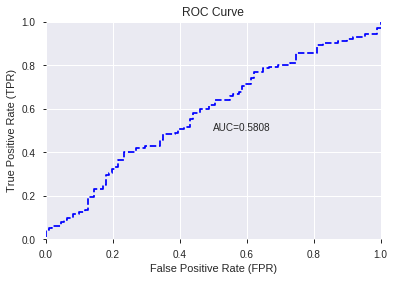

This function is available for GLM models only


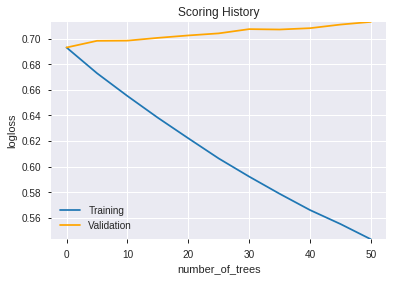

--2019-08-27 22:07:48--  https://h2o-release.s3.amazonaws.com/h2o/rel-yates/5/h2o-3.24.0.5.zip
Resolving h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)... 52.216.113.211
Connecting to h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)|52.216.113.211|:443... connected.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.

Archive:  h2o-3.24.0.5.zip
Exception in thread "main" java.lang.StackOverflowError
	at java.base/java.lang.String.substring(String.java:1874)
	at java.base/java.lang.String.split(String.java:2289)
	at java.base/java.lang.String.split(String.java:2364)
	at hex.genmodel.algos.xgboost.XGBoostMojoModel.constructSubgraph(XGBoostMojoModel.java:101)
	at hex.genmodel.algos.xgboost.XGBoostMojoModel.constructSubgraph(XGBoostMojoModel.java:106)
	at hex.genmodel.algos.xgboost.XGBoostMojoModel.constructSubgraph(XGBoostMojoModel.java:112)
	at hex.genmodel.algos.xgboost.XGBoostMojoMo

[{'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Models/XGBoost_grid_1_AutoML_20190827_220654_model_2',
   '__meta': {'schema_name': 'ModelKeyV3',
    'schema_type': 'Key<Model>',
    'schema_version': 3},
   'name': 'XGBoost_grid_1_AutoML_20190827_220654_model_2',
   'type': 'Key<Model>'},
  'default_value': None,
  'gridable': False,
  'help': 'Destination id for this model; auto-generated if not specified.',
  'is_member_of_frames': [],
  'is_mutually_exclusive_with': [],
  'label': 'model_id',
  'level': 'critical',
  'name': 'model_id',
  'required': False,
  'type': 'Key<Model>',
  'values': []},
 {'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Frames/automl_training_py_90_sid_a8e7',
   '__meta': {'schema_name': 'FrameKeyV3',
    'schema_type': 'Key<Frame>',
    'schema_version': 3},
   'name': 'automl_training

['STOCH_slowk',
 'DIV',
 'BETA_8',
 'hour',
 'BOP',
 'HT_PHASOR_inphase',
 'MFI_20',
 'MOM_20',
 'BETA_20',
 'BETA_14',
 'CORREL_24',
 'HT_PHASOR_quadrature',
 'HT_DCPERIOD',
 'Volume',
 'AROONOSC_20',
 'CCI_8',
 'DX_12',
 'DX_14',
 'STDDEV_20',
 'STDDEV_8',
 'CCI_14',
 'MFI_30',
 'ADX_8',
 'MACDEXT_hist',
 'ADX_24',
 'STOCHRSI_fastd',
 'TRANGE',
 'DX_30',
 'STOCHF_fastk',
 'DX_20',
 'CDLHIKKAKE',
 'CORREL_20',
 'LINEARREG_ANGLE_12',
 'MFI_24',
 'WILLR_8',
 'CORREL_12',
 'MACDEXT_signal',
 'STDDEV_14',
 'CMO_30',
 'WILLR_24',
 'PLUS_DI_8',
 'ADX_14',
 'ADOSC',
 'CMO_8',
 'NATR_20',
 'STOCHRSI_fastk',
 'PLUS_DM_24',
 'ADXR_14',
 'MINUS_DM_8',
 'AROONOSC_24',
 'BETA_12',
 'MINUS_DM_30',
 'WILLR_12',
 'MFI_14',
 'ADX_12',
 'ADXR_12',
 'ADX_20',
 'ATR_8',
 'PLUS_DM_8',
 'aroonup_30',
 'ULTOSC',
 'NATR_30',
 'PLUS_DM_12',
 'CORREL_30',
 'ADXR_8',
 'CDLRICKSHAWMAN',
 'CORREL_14',
 'DX_8',
 'BETA_30',
 'CMO_24',
 'MFI_12',
 'MINUS_DI_24',
 'MFI_8',
 'AD',
 'PLUS_DM_14',
 'MOM_8',
 'ATR_30',
 

In [50]:
# XGBoost with Select Family-wise error features
model_train(feature_name='Fwe',model_algo="XGBoost",features_list=features_list)

In [51]:
# recursive feature elimination with cross validation
try:
  del features_list
except:
  pass
gc.collect()

if features_to_include is True or 'RFE' in features_to_include:
  from sklearn.feature_selection import RFECV
  from sklearn.svm import LinearSVC
  from sklearn.tree import DecisionTreeClassifier,ExtraTreeClassifier
  from sklearn.linear_model import LogisticRegression, LinearRegression

  bestfeatures = RFECV(ExtraTreeClassifier(random_state=1,criterion='entropy'), min_features_to_select=select_rfe, step=1,cv=5).fit(pd.read_pickle('scaled_df')[:index_splits[0]].drop(data_label_name,axis=1)
                                                              ,pd.read_pickle('scaled_df')[:index_splits[0]][data_label_name])

  features_list = list(np.array(train_hf.columns)[:-1][bestfeatures.get_support()])

  del bestfeatures, RFECV, LinearSVC, DecisionTreeClassifier,ExtraTreeClassifier, LogisticRegression, LinearRegression
  gc.collect()
  display(len(features_list),features_list)
else:
  features_list = []

777

['BBANDS_middleband_8_7_3',
 'BBANDS_lowerband_8_7_3',
 'BBANDS_upperband_8_7_4',
 'BBANDS_middleband_8_7_4',
 'BBANDS_lowerband_8_7_4',
 'BBANDS_upperband_8_7_5',
 'BBANDS_middleband_8_7_5',
 'BBANDS_lowerband_8_7_5',
 'MA_8_8',
 'MAVP_8_8',
 'T3_8_8',
 'BBANDS_upperband_8_8_2',
 'BBANDS_middleband_8_8_2',
 'BBANDS_lowerband_8_8_2',
 'BBANDS_upperband_8_8_3',
 'BBANDS_middleband_8_8_3',
 'BBANDS_lowerband_8_8_3',
 'BBANDS_upperband_8_8_4',
 'BBANDS_middleband_8_8_4',
 'BBANDS_lowerband_8_8_4',
 'BBANDS_upperband_8_8_5',
 'BBANDS_middleband_8_8_5',
 'BBANDS_lowerband_8_8_5',
 'DEMA_12',
 'EMA_12',
 'KAMA_12',
 'MIDPOINT_12',
 'MIDPRICE_12',
 'SAR_0.12',
 'SMA_12',
 'TEMA_12',
 'TRIMA_12',
 'WMA_12',
 'MA_12_0',
 'MAVP_12_0',
 'BBANDS_upperband_12_0_2',
 'BBANDS_middleband_12_0_2',
 'BBANDS_lowerband_12_0_2',
 'BBANDS_upperband_12_0_3',
 'BBANDS_middleband_12_0_3',
 'BBANDS_lowerband_12_0_3',
 'BBANDS_upperband_12_0_4',
 'BBANDS_middleband_12_0_4',
 'BBANDS_lowerband_12_0_4',
 'BBANDS_u

AutoML progress: |████████████████████████████████████████████████████████| 100%


model_id       auc   logloss  mean_per_class_error      rmse       mse
0  DeepLearning_grid_1_AutoML_20190827_220901_model_3  0.531210  0.771334              0.500000  0.532300  0.283343
1  DeepLearning_grid_1_AutoML_20190827_220901_model_6  0.525097  0.690595              0.481861  0.498736  0.248738
2  DeepLearning_grid_1_AutoML_20190827_220901_model_4  0.515846  0.795298              0.495495  0.531639  0.282640
3  DeepLearning_grid_1_AutoML_20190827_220901_model_7  0.504786  0.692718              0.500000  0.499725  0.249725
4  DeepLearning_grid_1_AutoML_20190827_220901_model_9  0.500000  0.694118              0.500000  0.500485  0.250485
5  DeepLearning_grid_1_AutoML_20190827_220901_model_8  0.500000  0.693170              0.500000  0.500011  0.250011
6  DeepLearning_grid_1_AutoML_20190827_220901_model_5  0.500000  0.694194              0.500000  0.500522  0.250523
7  DeepLearning_grid_1_AutoML_20190827_220901_model_2  0.481982  0.889034              0.500000  0.564434  0.318586
8  DeepLearning_grid_1_AutoML_20190827_220901_model_1  0.480936  2.588815              0.472933  0.665870  0.443382
9               DeepLearning_1_AutoML_20190827_220901  0.475467  1.850996              0.500000  0.690034  0.476147

variable  relative_importance  scaled_importance  percentage
0           CDLDARKCLOUDCOVER             1.000000           1.000000    0.004001
1          CDLMORNINGDOJISTAR             0.983335           0.983335    0.003935
2           CDL3WHITESOLDIERS             0.975986           0.975986    0.003905
3              CDLMORNINGSTAR             0.973788           0.973788    0.003897
4         CDLGAPSIDESIDEWHITE             0.963024           0.963024    0.003853
..                        ...                  ...                ...         ...
769                    WMA_12             0.261875           0.261875    0.001048
770                  AVGPRICE             0.261629           0.261629    0.001047
771  BBANDS_middleband_14_2_2             0.260696           0.260696    0.001043
772  BBANDS_middleband_30_7_4             0.260679           0.260679    0.001043
773                 MAVP_24_7             0.255664           0.255664    0.001023

[774 rows x 4 columns]

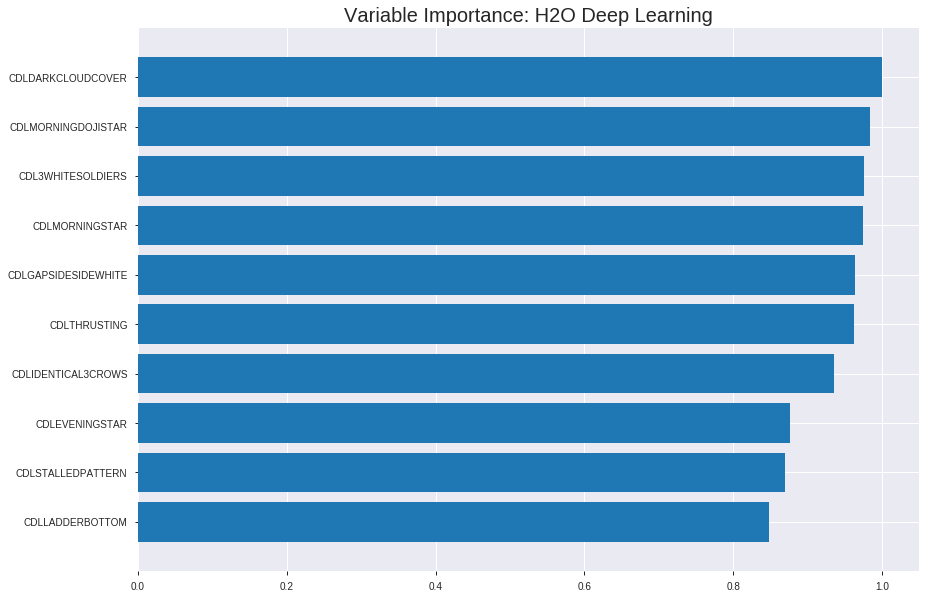

Model Details
H2ODeepLearningEstimator :  Deep Learning
Model Key:  DeepLearning_grid_1_AutoML_20190827_220901_model_3


ModelMetricsBinomial: deeplearning
** Reported on train data. **

MSE: 0.2598469053264225
RMSE: 0.5097518075754343
LogLoss: 0.7198779104582933
Mean Per-Class Error: 0.44266304123923694
AUC: 0.5731874922753677
pr_auc: 0.5569332782005024
Gini: 0.1463749845507354
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.1668823988433771: 


0    1     Error    Rate
-----  ---  ----  -------  --------------
0      25   758   0.9681   (758.0/783.0)
1      9    766   0.0116   (9.0/775.0)
Total  34   1524  0.4923   (767.0/1558.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.166882     0.666377  377
max f2                       0.0729154    0.832617  396
max f0point5                 0.343498     0.566054  297
max accuracy                 0.506367     0.557125  204
max precision                0.893541     1         0
max recall                   0.0729154    1         396
max specificity              0.893541     1         0
max absolute_mcc             0.593566     0.115983  146
max min_per_class_accuracy   0.528768     0.550968  189
max mean_per_class_accuracy  0.505415     0.557337  205

Gains/Lift Table: Avg response rate: 49.74 %, avg score: 51.42 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0102696                   0.855457           1.3821    1.3821             0.6875           0.872685  0.6875                      0.872685            0.0141935       0.0141935                  38.2097   38.2097
    2        0.0205392                   0.842568           0.879516  1.13081            0.4375           0.848334  0.5625                      0.860509            0.00903226      0.0232258                  -12.0484  13.0806
    3        0.0301669                   0.824471           0.804129  1.02655            0.4              0.833607  0.510638                    0.851924            0.00774194      0.0309677                  -19.5871  2.65477
    4        0.0404365                   0.803988           1.50774   1.14876            0.75             0.814508  0.571429                    0.842421            0.0154839       0.0464516                  50.7742   14.8756
    5        0.0500642                   0.789638           0.938151  1.10825            0.466667         0.798452  0.551282                    0.833966            0.00903226      0.0554839                  -6.18495  10.8255
    6        0.100128                    0.743427           1.36599   1.23712            0.679487         0.768781  0.615385                    0.801373            0.0683871       0.123871                   36.5988   23.7122
    7        0.150193                    0.709218           1.1598    1.21135            0.576923         0.727215  0.602564                    0.776654            0.0580645       0.181935                   15.9801   21.1348
    8        0.200257                    0.681887           1.08248   1.17913            0.538462         0.696122  0.586538                    0.756521            0.0541935       0.236129                   8.24814   17.9132
    9        0.300385                    0.631927           1.12114   1.1598             0.557692         0.654241  0.576923                    0.722428            0.112258        0.348387                   12.1141   15.9801
    10       0.399872                    0.575001           1.05056   1.13262            0.522581         0.601952  0.563403                    0.692454            0.104516        0.452903                   5.05557   13.2622
    11       0.5                         0.527665           0.979388  1.10194            0.487179         0.550663  0.548139                    0.664059            0.0980645       0.550968                   -2.06121  10.1935
    12       0.600128                    0.472946           1.01805   1.08794            0.50641          0.499938  0.541176                    0.636677            0.101935        0.652903                   1.8048    8.79393
    13       0.699615                    0.409591           0.843039  1.05311            0.419355         0.445232  0.523853                    0.609453            0.083871        0.736774                   -15.6961  5.31139
    14       0.799743                    0.335913           1.04382   1.05195            0.519231         0.375328  0.523274                    0.58014             0.104516        0.84129                    4.38213   5.19505
    15       0.899872                    0.26172            0.811861  1.02524            0.403846         0.302142  0.509986                    0.549207            0.0812903       0.922581                   -18.8139  2.52358
    16       1                           0.0495048          0.773201  1                  0.384615         0.199249  0.497433                    0.514167         



ModelMetricsBinomial: deeplearning
** Reported on validation data. **

MSE: 0.29577554007712975
RMSE: 0.5438524984562724
LogLoss: 0.8025726014936602
Mean Per-Class Error: 0.47939915898431185
AUC: 0.4603954391072295
pr_auc: 0.5062854819016114
Gini: -0.07920912178554096
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.09213471568368711: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      1    215  0.9954   (215.0/216.0)
1      0    229  0        (0.0/229.0)
Total  1    444  0.4831   (215.0/445.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.0921347    0.680535  398
max f2                       0.0921347    0.841912  398
max f0point5                 0.337898     0.571429  378
max accuracy                 0.337898     0.521348  378
max precision                0.924737     1         0
max recall                   0.0921347    1         398
max specificity              0.924737     1         0
max absolute_mcc             0.511779     0.137708  310
max min_per_class_accuracy   0.645453     0.462882  195
max mean_per_class_accuracy  0.781855     0.520601  58

Gains/Lift Table: Avg response rate: 51.46 %, avg score: 62.71 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.011236                    0.89095            1.16594   1.16594            0.6              0.900828  0.6                         0.900828            0.0131004       0.0131004                  16.5939   16.5939
    2        0.0202247                   0.881365           0.971616  1.07957            0.5              0.88663   0.555556                    0.894518            0.00873362      0.0218341                  -2.83843  7.9573
    3        0.0314607                   0.862345           1.55459   1.24922            0.8              0.872031  0.642857                    0.886487            0.0174672       0.0393013                  55.4585   24.922
    4        0.0404494                   0.846497           0.971616  1.18753            0.5              0.857003  0.611111                    0.879935            0.00873362      0.0480349                  -2.83843  18.753
    5        0.0516854                   0.841829           0.777293  1.09835            0.4              0.842751  0.565217                    0.871852            0.00873362      0.0567686                  -22.2707  9.83482
    6        0.101124                    0.803353           0.70663   0.906841           0.363636         0.819729  0.466667                    0.84637             0.0349345       0.0917031                  -29.337   -9.31587
    7        0.150562                    0.778739           1.50159   1.10213            0.772727         0.790166  0.567164                    0.827915            0.0742358       0.165939                   50.1588   10.2131
    8        0.2                         0.755772           0.883287  1.04803            0.454545         0.765383  0.539326                    0.812457            0.0436681       0.209607                   -11.6713  4.80349
    9        0.301124                    0.722234           0.820475  0.971616           0.422222         0.738265  0.5                         0.787542            0.0829694       0.292576                   -17.9525  -2.83843
    10       0.4                         0.689886           0.794958  0.927948           0.409091         0.707592  0.477528                    0.767779            0.0786026       0.371179                   -20.5042  -7.20524
    11       0.501124                    0.64529            0.906841  0.923688           0.466667         0.666612  0.475336                    0.747364            0.0917031       0.462882                   -9.31587  -7.63115
    12       0.6                         0.615971           1.01578   0.938865           0.522727         0.629258  0.483146                    0.727901            0.100437        0.563319                   1.57801   -6.11354
    13       0.698876                    0.559811           1.14827   0.968492           0.590909         0.592585  0.498392                    0.708757            0.113537        0.676856                   14.8273   -3.15084
    14       0.8                         0.507449           0.73411   0.938865           0.377778         0.530133  0.483146                    0.686178            0.0742358       0.751092                   -26.589   -6.11354
    15       0.898876                    0.428147           1.32493   0.981332           0.681818         0.468642  0.505                       0.662249            0.131004        0.882096                   32.4931   -1.86681
    16       1                           0.060374           1.16594   1                  0.6              0.314551  0.514607                    0.627088    


Scoring History: 


timestamp            duration          training_speed    epochs    iterations    samples    training_rmse    training_logloss    training_r2    training_auc    training_pr_auc    training_lift    training_classification_error    validation_rmse    validation_logloss    validation_r2    validation_auc    validation_pr_auc    validation_lift    validation_classification_error
--  -------------------  ----------------  ----------------  --------  ------------  ---------  ---------------  ------------------  -------------  --------------  -----------------  ---------------  -------------------------------  -----------------  --------------------  ---------------  ----------------  -------------------  -----------------  ---------------------------------
    2019-08-27 22:11:16  0.000 sec                           0         0             0          nan              nan                 nan            nan             nan                nan              nan                              nan                nan                   nan              nan               nan                  nan                nan
    2019-08-27 22:11:17  2 min 14.662 sec  579 obs/sec       0.52439   1             817        0.589222         1.17268             -0.388767      0.550779        0.534398           1.3821           0.484596                         0.633297           1.68073               -0.605629        0.474193          0.488913             0.777293           0.480899
    2019-08-27 22:11:26  2 min 23.762 sec  599 obs/sec       3.72786   7             5808       0.562601         1.26205             -0.266111      0.601017        0.533444           1.50774          0.487805                         0.671451           4.57896               -0.804927        0.471333          0.450433             0.388646           0.483146
    2019-08-27 22:11:35  2 min 32.372 sec  613 obs/sec       6.88447   13            10726      0.575763         2.34051             -0.326046      0.603654        0.596788           1.63339          0.502567                         0.71736            12.7555               -1.06018         0.507753          0.541436             1.55459            0.485393
    2019-08-27 22:11:43  2 min 40.770 sec  624 obs/sec       10.0353   19            15635      0.587253         1.43852             -0.379503      0.570494        0.493805           1.50774          0.472401                         0.695018           6.16662               -0.933852        0.502173          0.433437             1.16594            0.478652
    2019-08-27 22:11:52  2 min 49.071 sec  631 obs/sec       13.1829   25            20539      0.556671         1.02553             -0.239562      0.606778        0.564662           2.01032          0.473042                         0.68391            3.07031               -0.872527        0.476508          0.490741             0.777293           0.480899
    2019-08-27 22:12:00  2 min 57.468 sec  636 obs/sec       16.3703   31            25505      0.528713         0.828745            -0.11818       0.600065        0.581053           1.75903          0.469191                         0.662152           1.85655               -0.75528         0.472606          0.487421             0.388646           0.480899
    2019-08-27 22:12:10  3 min  6.985 sec  641 obs/sec       20.0847   38            31292      0.499217         0.712347            0.00310329     0.622762        0.601904           1.75903          0.459564                         0.609536           1.27909               -0.487408        0.491701          0.514226             1.16594            0.480899
    2019-08-27 22:12:18  3 min 15.167 sec  643 obs/sec       23.2086   44            36159      0.50935          0.726001            -0.037777      0.588189        0.568961           1.50774          0.483954                         0.593518           1.0536                -0.410259        0.498373          0.519576             0.777293           0.485393
    2019-08-27 22:12:26

Variable Importances: 


variable                  relative_importance    scaled_importance    percentage
------------------------  ---------------------  -------------------  ---------------------
CDLDARKCLOUDCOVER         1.0                    1.0                  0.004001395465184245
CDLMORNINGDOJISTAR        0.9833345413208008     0.9833345413208008   0.003934710374400081
CDL3WHITESOLDIERS         0.9759855270385742     0.9759855270385742   0.0039053040619776063
CDLMORNINGSTAR            0.9737880229949951     0.9737880229949951   0.0038965109792629044
CDLGAPSIDESIDEWHITE       0.9630241394042969     0.9630241394042969   0.0038534404242753137
---                       ---                    ---                  ---
WMA_12                    0.2618750333786011     0.2618750333786011   0.001047865571006107
AVGPRICE                  0.2616289556026459     0.2616289556026459   0.0010468809165093173
BBANDS_middleband_14_2_2  0.2606964409351349     0.2606964409351349   0.0010431495565475211
BBANDS_middleband_30_7_4  0.2606789171695709     0.2606789171695709   0.0010430794370314604
MAVP_24_7                 0.25566422939300537    0.25566422939300537  0.0010230136881029962


See the whole table with table.as_data_frame()


/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:7116: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


('accuracy', 0.5695067264573991)

('F1', 0.6686567164179104)

('auc', 0.5312097812097812)

('logloss', 0.771334027622798)

('mean_per_class_error', 0.4290942728442728)

('rmse', 0.5323001478813475)

('mse', 0.28334344743450446)

deeplearning prediction progress: |███████████████████████████████████████| 100%


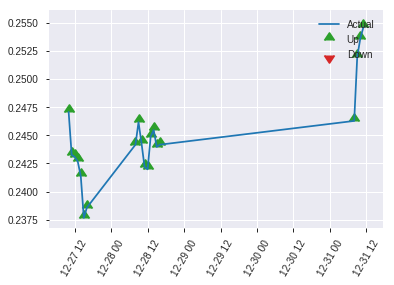


ModelMetricsBinomial: deeplearning
** Reported on test data. **

MSE: 0.28334344743450446
RMSE: 0.5323001478813475
LogLoss: 0.771334027622798
Mean Per-Class Error: 0.4290942728442728
AUC: 0.5312097812097812
pr_auc: 0.5419995549873877
Gini: 0.06241956241956248
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.3443202445434858: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      0    111  1        (111.0/111.0)
1      0    112  0        (0.0/112.0)
Total  0    223  0.4978   (111.0/223.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.34432      0.668657  222
max f2                       0.34432      0.834575  222
max f0point5                 0.480813     0.560166  212
max accuracy                 0.763308     0.569507  41
max precision                0.763308     0.690476  41
max recall                   0.34432      1         222
max specificity              0.919223     0.990991  0
max absolute_mcc             0.763308     0.18135   41
max min_per_class_accuracy   0.677456     0.5       110
max mean_per_class_accuracy  0.763308     0.570906  41

Gains/Lift Table: Avg response rate: 50.22 %, avg score: 66.59 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain       cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  ---------  -----------------
    1        0.0134529                   0.862413           0.66369   0.66369            0.333333         0.893596  0.333333                    0.893596            0.00892857      0.00892857                 -33.631    -33.631
    2        0.0224215                   0.847878           0.995536  0.796429           0.5              0.850726  0.4                         0.876448            0.00892857      0.0178571                  -0.446429  -20.3571
    3        0.0313901                   0.837675           0.995536  0.853316           0.5              0.843155  0.428571                    0.866936            0.00892857      0.0267857                  -0.446429  -14.6684
    4        0.0403587                   0.826129           1.99107   1.10615            1                0.831891  0.555556                    0.859148            0.0178571       0.0446429                  99.1071    10.6151
    5        0.0538117                   0.815251           1.99107   1.32738            1                0.821966  0.666667                    0.849852            0.0267857       0.0714286                  99.1071    32.7381
    6        0.103139                    0.795995           1.08604   1.21196            0.545455         0.805766  0.608696                    0.828768            0.0535714       0.125                      8.6039     21.1957
    7        0.152466                    0.772496           1.44805   1.28834            0.727273         0.783376  0.647059                    0.814082            0.0714286       0.196429                   44.8052    28.834
    8        0.201794                    0.756196           1.26705   1.28313            0.636364         0.764987  0.644444                    0.802081            0.0625          0.258929                   26.7045    28.3135
    9        0.300448                    0.735139           0.724026  1.09955            0.363636         0.742859  0.552239                    0.782635            0.0714286       0.330357                   -27.5974   9.95469
    10       0.399103                    0.706238           0.814529  1.02909            0.409091         0.721103  0.516854                    0.767425            0.0803571       0.410714                   -18.5471   2.90931
    11       0.502242                    0.676265           0.865683  0.995536           0.434783         0.692819  0.5                         0.752104            0.0892857       0.5                        -13.4317   -0.446429
    12       0.600897                    0.63999            0.905032  0.980677           0.454545         0.657998  0.492537                    0.736654            0.0892857       0.589286                   -9.49675   -1.9323
    13       0.699552                    0.61812            1.08604   0.995536           0.545455         0.631304  0.5                         0.721797            0.107143        0.696429                   8.6039     -0.446429
    14       0.798206                    0.576925           1.08604   1.00672            0.545455         0.598586  0.505618                    0.706568            0.107143        0.803571                   8.6039     0.672151
    15       0.896861                    0.519568           0.995536  1.00549            0.5              0.551128  0.505                       0.68947             0.0982143       0.901786                   -0.446429  0.549107
    16       1                           0.34432            0.952252  1                  0.478261         0.460504  0.502242             

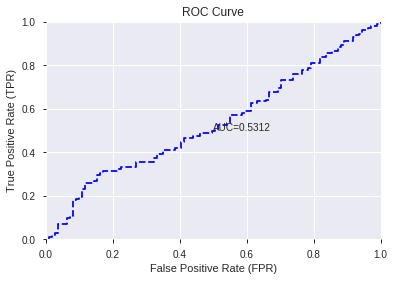

This function is available for GLM models only


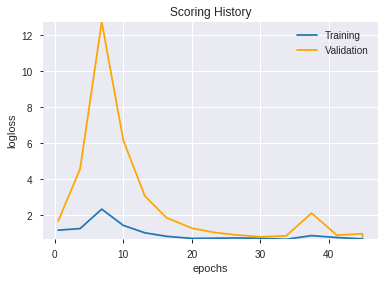

--2019-08-27 22:29:33--  https://h2o-release.s3.amazonaws.com/h2o/rel-yates/5/h2o-3.24.0.5.zip
Resolving h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)... 52.216.80.224
Connecting to h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)|52.216.80.224|:443... connected.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.

Archive:  h2o-3.24.0.5.zip
ERROR: Unknown MOJO type


[{'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Models/DeepLearning_grid_1_AutoML_20190827_220901_model_3',
   '__meta': {'schema_name': 'ModelKeyV3',
    'schema_type': 'Key<Model>',
    'schema_version': 3},
   'name': 'DeepLearning_grid_1_AutoML_20190827_220901_model_3',
   'type': 'Key<Model>'},
  'default_value': None,
  'gridable': False,
  'help': 'Destination id for this model; auto-generated if not specified.',
  'is_member_of_frames': [],
  'is_mutually_exclusive_with': [],
  'label': 'model_id',
  'level': 'critical',
  'name': 'model_id',
  'required': False,
  'type': 'Key<Model>',
  'values': []},
 {'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Frames/automl_training_py_98_sid_a8e7',
   '__meta': {'schema_name': 'FrameKeyV3',
    'schema_type': 'Key<Frame>',
    'schema_version': 3},
   'name': 'autom

['CDLDARKCLOUDCOVER',
 'CDLMORNINGDOJISTAR',
 'CDL3WHITESOLDIERS',
 'CDLMORNINGSTAR',
 'CDLGAPSIDESIDEWHITE',
 'CDLTHRUSTING',
 'CDLIDENTICAL3CROWS',
 'CDLEVENINGSTAR',
 'CDLSTALLEDPATTERN',
 'CDLLADDERBOTTOM',
 'CDLEVENINGDOJISTAR',
 'CDLMATCHINGLOW',
 'CDLHANGINGMAN',
 'CDLADVANCEBLOCK',
 'CDLINVERTEDHAMMER',
 'CDLSEPARATINGLINES',
 'CDLSHOOTINGSTAR',
 'HT_TRENDMODE',
 'CDLHIKKAKEMOD',
 'CDLXSIDEGAP3METHODS',
 'CDLTAKURI',
 'CDLGRAVESTONEDOJI',
 'CDLDRAGONFLYDOJI',
 'CDLHAMMER',
 'CDL3INSIDE',
 'CDLTASUKIGAP',
 'CDL3LINESTRIKE',
 'CORREL_14',
 'CORREL_12',
 'CORREL_20',
 'aroondown_12',
 'VAR_14',
 'VAR_8',
 'CDLDOJI',
 'CDLLONGLEGGEDDOJI',
 'CDLRICKSHAWMAN',
 'VAR_12',
 'VAR_20',
 'BOP',
 'VAR_30',
 'STOCHRSI_fastk',
 'VAR_24',
 'CORREL_24',
 'aroondown_24',
 'CORREL_30',
 'aroondown_8',
 'HT_DCPERIOD',
 'aroonup_12',
 'aroondown_30',
 'aroondown_20',
 'aroondown_14',
 'aroonup_14',
 'aroonup_30',
 'SUB',
 'STOCHF_fastk',
 'MFI_30',
 'STOCHRSI_fastd',
 'BETA_12',
 'WILLR_8',
 'DX_8'

In [52]:
# DeepLearning with recursive feature elimination with cross validation
model_train(feature_name='RFE',model_algo="DeepLearning",features_list=features_list)

AutoML progress: |████████████████████████████████████████████████████████| 100%


model_id       auc   logloss  mean_per_class_error      rmse       mse
0  GLM_grid_1_AutoML_20190827_222940_model_1  0.460505  0.696415              0.495455  0.501629  0.251631

variable  relative_importance  scaled_importance    percentage
0                 CDLMARUBOZU         8.319182e-03           1.000000  1.729074e-02
1               CDLHANGINGMAN         7.453960e-03           0.895997  1.549245e-02
2         CDLGAPSIDESIDEWHITE         6.219488e-03           0.747608  1.292670e-02
3          CDLSEPARATINGLINES         5.867241e-03           0.705267  1.219458e-02
4              CDLRICKSHAWMAN         5.649833e-03           0.679133  1.174272e-02
..                        ...                  ...                ...           ...
769  BBANDS_middleband_12_5_2         1.069024e-06           0.000129  2.221880e-06
770   BBANDS_lowerband_12_2_5         1.019807e-06           0.000123  2.119586e-06
771   BBANDS_middleband_8_7_5         9.796920e-07           0.000118  2.036210e-06
772    BBANDS_upperband_8_8_4         3.646946e-07           0.000044  7.579881e-07
773               LINEARREG_8         5.005420e-08           0.000006  1.040336e-07

[774 rows x 4 columns]

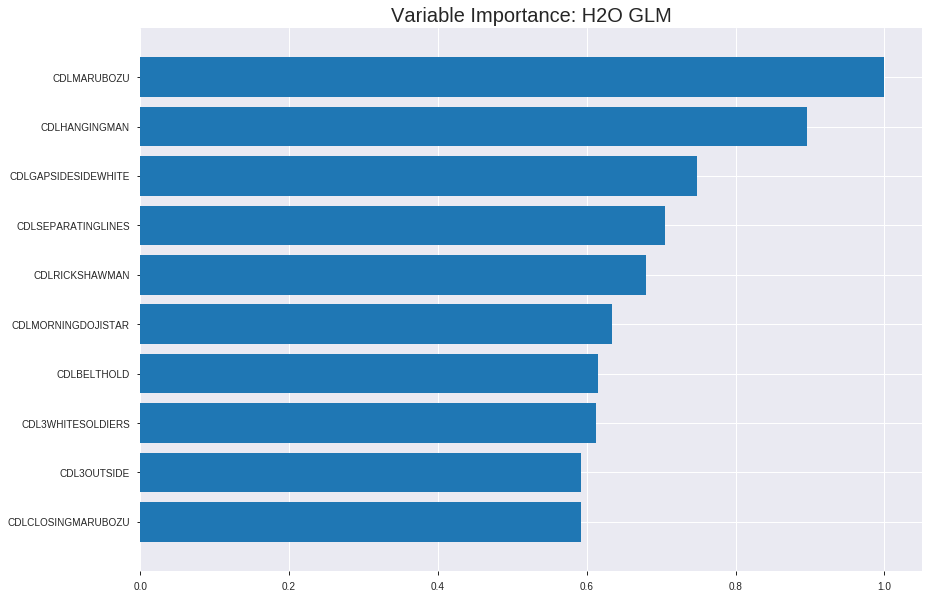

Model Details
H2OGeneralizedLinearEstimator :  Generalized Linear Modeling
Model Key:  GLM_grid_1_AutoML_20190827_222940_model_1


ModelMetricsBinomialGLM: glm
** Reported on train data. **

MSE: 0.24725991728486318
RMSE: 0.49725236780216864
LogLoss: 0.687641490829973
Null degrees of freedom: 1557
Residual degrees of freedom: 783
Null deviance: 2159.8055361387533
Residual deviance: 2142.6908854261956
AIC: 3692.6908854261956
AUC: 0.5766069295101554
pr_auc: 0.5755182443119939
Gini: 0.1532138590203107
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.3636959239392694: 


0    1     Error    Rate
-----  ---  ----  -------  --------------
0      5    778   0.9936   (778.0/783.0)
1      1    774   0.0013   (1.0/775.0)
Total  6    1552  0.5      (779.0/1558.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.363696     0.665234  393
max f2                       0.358224     0.832259  397
max f0point5                 0.470846     0.566886  287
max accuracy                 0.508491     0.55905   135
max precision                0.560091     1         0
max recall                   0.358224     1         397
max specificity              0.560091     1         0
max absolute_mcc             0.499096     0.120283  183
max min_per_class_accuracy   0.504837     0.554839  155
max mean_per_class_accuracy  0.499096     0.558924  183

Gains/Lift Table: Avg response rate: 49.74 %, avg score: 49.74 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain       cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  ---------  -----------------
    1        0.0102696                   0.538197           1.75903   1.75903            0.875            0.545088  0.875                       0.545088            0.0180645       0.0180645                  75.9032    75.9032
    2        0.0205392                   0.534487           1.3821    1.57056            0.6875           0.536148  0.78125                     0.540618            0.0141935       0.0322581                  38.2097    57.0565
    3        0.0301669                   0.531059           1.60826   1.58259            0.8              0.532324  0.787234                    0.537971            0.0154839       0.0477419                  60.8258    58.2594
    4        0.0404365                   0.528774           1.3821    1.53167            0.6875           0.529881  0.761905                    0.535916            0.0141935       0.0619355                  38.2097    53.1674
    5        0.0500642                   0.527721           0.938151  1.41754            0.466667         0.528149  0.705128                    0.534423            0.00903226      0.0709677                  -6.18495   41.7535
    6        0.100128                    0.522728           1.18557   1.30156            0.589744         0.525089  0.647436                    0.529756            0.0593548       0.130323                   18.5575    30.1555
    7        0.150193                    0.51936            1.13403   1.24571            0.564103         0.521055  0.619658                    0.526855            0.0567742       0.187097                   13.4028    24.5713
    8        0.200257                    0.517054           0.979388  1.17913            0.487179         0.51817   0.586538                    0.524684            0.0490323       0.236129                   -2.06121   17.9132
    9        0.300385                    0.513056           1.01805   1.12544            0.50641          0.515214  0.559829                    0.521527            0.101935        0.338065                   1.8048     12.5437
    10       0.399872                    0.509099           1.19322   1.1423             0.593548         0.510958  0.568218                    0.518898            0.11871         0.456774                   19.3224    14.2302
    11       0.5                         0.504708           0.992275  1.11226            0.49359          0.506985  0.553273                    0.516512            0.0993548       0.556129                   -0.772539  11.2258
    12       0.600128                    0.499005           1.03093   1.09869            0.512821         0.501822  0.546524                    0.514061            0.103226        0.659355                   3.09347    9.86897
    13       0.699615                    0.491816           0.778189  1.05311            0.387097         0.495509  0.523853                    0.511423            0.0774194       0.736774                   -22.1811   5.31139
    14       0.799743                    0.480906           0.992275  1.0455             0.49359          0.487447  0.520064                    0.508421            0.0993548       0.836129                   -0.772539  4.54968
    15       0.899872                    0.465818           0.889181  1.0281             0.442308         0.473995  0.511412                    0.504591            0.0890323       0.925161                   -11.0819   2.81036
    16       1                           0.35463            0.747428  1                  0.371795         0.433102  0.497433                    



ModelMetricsBinomialGLM: glm
** Reported on validation data. **

MSE: 0.2556214529179008
RMSE: 0.5055902025533137
LogLoss: 0.7048575405677856
Null degrees of freedom: 444
Residual degrees of freedom: -330
Null deviance: 617.0462294114567
Residual deviance: 627.3232111053292
AIC: 2177.3232111053294
AUC: 0.4643377001455604
pr_auc: 0.48905251484986484
Gini: -0.07132459970887917
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.28597223211871164: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      0    216  1        (216.0/216.0)
1      0    229  0        (0.0/229.0)
Total  0    445  0.4854   (216.0/445.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value      idx
---------------------------  -----------  ---------  -----
max f1                       0.285972     0.679525   399
max f2                       0.285972     0.841293   399
max f0point5                 0.285972     0.569935   399
max accuracy                 0.420679     0.514607   372
max precision                0.522598     0.625      7
max recall                   0.285972     1          399
max specificity              0.536935     0.99537    0
max absolute_mcc             0.468711     0.0925235  268
max min_per_class_accuracy   0.480424     0.462963   196
max mean_per_class_accuracy  0.494376     0.506742   116

Gains/Lift Table: Avg response rate: 51.46 %, avg score: 47.36 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.011236                    0.524087           0.777293  0.777293           0.4              0.529807  0.4                         0.529807            0.00873362      0.00873362                 -22.2707  -22.2707
    2        0.0202247                   0.519499           1.45742   1.07957            0.75             0.522217  0.555556                    0.526434            0.0131004       0.0218341                  45.7424   7.9573
    3        0.0314607                   0.517594           0.388646  0.832813           0.2              0.518692  0.428571                    0.523669            0.00436681      0.0262009                  -61.1354  -16.7187
    4        0.0404494                   0.514521           0.971616  0.863658           0.5              0.516359  0.444444                    0.522044            0.00873362      0.0349345                  -2.83843  -13.6342
    5        0.0516854                   0.513583           0.388646  0.760395           0.2              0.51392   0.391304                    0.520278            0.00436681      0.0393013                  -61.1354  -23.9605
    6        0.101124                    0.50908            0.971616  0.863658           0.5              0.511407  0.444444                    0.515941            0.0480349       0.0873362                  -2.83843  -13.6342
    7        0.150562                    0.505818           1.05994   0.928111           0.545455         0.507544  0.477612                    0.513184            0.0524017       0.139738                   5.99444   -7.18895
    8        0.2                         0.502863           1.14827   0.982533           0.590909         0.5041    0.505618                    0.510938            0.0567686       0.196507                   14.8273   -1.74672
    9        0.301124                    0.495043           1.07957   1.01512            0.555556         0.49878   0.522388                    0.506855            0.10917         0.305677                   7.9573    1.51209
    10       0.4                         0.488668           0.839123  0.971616           0.431818         0.491552  0.5                         0.503072            0.0829694       0.388646                   -16.0877  -2.83843
    11       0.501124                    0.480424           0.777293  0.932403           0.4              0.484629  0.479821                    0.499351            0.0786026       0.467249                   -22.2707  -6.75975
    12       0.6                         0.474818           1.05994   0.953421           0.545455         0.477158  0.490637                    0.495693            0.104803        0.572052                   5.99444   -4.65793
    13       0.698876                    0.468068           0.927451  0.949747           0.477273         0.471591  0.488746                    0.492283            0.0917031       0.663755                   -7.25486  -5.02534
    14       0.8                         0.456197           1.16594   0.977074           0.6              0.46309   0.502809                    0.488593            0.117904        0.781659                   16.5939   -2.29258
    15       0.898876                    0.435015           1.14827   0.995906           0.590909         0.448087  0.5125                      0.484138            0.113537        0.895197                   14.8273   -0.409389
    16       1                           0.285972           1.03639   1                  0.533333         0.379655  0.514607                    0.47


Scoring History: 


timestamp            duration    iteration    lambda    predictors    deviance_train    deviance_test
--  -------------------  ----------  -----------  --------  ------------  ----------------  ---------------
    2019-08-27 22:29:42  0.000 sec   2            3.2       775           1.37528           1.40972
    2019-08-27 22:29:43  1.144 sec   4            2.3       775           1.3731            1.4123
    2019-08-27 22:29:44  2.303 sec   6            1.7       775           1.37046           1.41464
    2019-08-27 22:29:45  3.478 sec   8            1.2       775           1.3673            1.41728
    2019-08-27 22:29:47  4.624 sec   10           0.89      775           1.36363           1.42046

/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:7116: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


('accuracy', 0.5067264573991032)

('F1', 0.6686746987951807)

('auc', 0.460505148005148)

('logloss', 0.696414697608174)

('mean_per_class_error', 0.49111164736164736)

('rmse', 0.5016287060731363)

('mse', 0.25163135875660897)

glm prediction progress: |████████████████████████████████████████████████| 100%


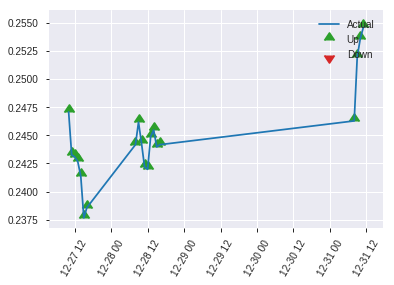


ModelMetricsBinomialGLM: glm
** Reported on test data. **

MSE: 0.25163135875660897
RMSE: 0.5016287060731363
LogLoss: 0.696414697608174
Null degrees of freedom: 222
Residual degrees of freedom: -552
Null deviance: 309.1597919029809
Residual deviance: 310.6009551332456
AIC: 1860.6009551332456
AUC: 0.460505148005148
pr_auc: 0.471839780086802
Gini: -0.07898970398970395
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.45561334178497365: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      2    109  0.982    (109.0/111.0)
1      1    111  0.0089   (1.0/112.0)
Total  3    220  0.4933   (110.0/223.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value      idx
---------------------------  -----------  ---------  -----
max f1                       0.455613     0.668675   219
max f2                       0.437349     0.834575   222
max f0point5                 0.455613     0.559476   219
max accuracy                 0.528387     0.506726   3
max precision                0.537353     1          0
max recall                   0.437349     1          222
max specificity              0.537353     1          0
max absolute_mcc             0.494305     0.0942113  99
max min_per_class_accuracy   0.491872     0.468468   111
max mean_per_class_accuracy  0.528387     0.508888   3

Gains/Lift Table: Avg response rate: 50.22 %, avg score: 49.14 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain       cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  ---------  -----------------
    1        0.0134529                   0.530722           1.32738   1.32738            0.666667         0.533394  0.666667                    0.533394            0.0178571       0.0178571                  32.7381    32.7381
    2        0.0224215                   0.526986           0.995536  1.19464            0.5              0.527711  0.6                         0.531121            0.00892857      0.0267857                  -0.446429  19.4643
    3        0.0313901                   0.525128           0         0.853316           0                0.526652  0.428571                    0.529844            0               0.0267857                  -100       -14.6684
    4        0.0403587                   0.521068           0.995536  0.884921           0.5              0.523305  0.444444                    0.528391            0.00892857      0.0357143                  -0.446429  -11.5079
    5        0.0538117                   0.519638           1.32738   0.995536           0.666667         0.520415  0.5                         0.526397            0.0178571       0.0535714                  32.7381    -0.446429
    6        0.103139                    0.515238           0.543019  0.779115           0.272727         0.517084  0.391304                    0.521943            0.0267857       0.0803571                  -45.6981   -22.0885
    7        0.152466                    0.51203            1.08604   0.878414           0.545455         0.513666  0.441176                    0.519265            0.0535714       0.133929                   8.6039     -12.1586
    8        0.201794                    0.507803           1.08604   0.929167           0.545455         0.509939  0.466667                    0.516985            0.0535714       0.1875                     8.6039     -7.08333
    9        0.300448                    0.501485           0.814529  0.891525           0.409091         0.504061  0.447761                    0.512742            0.0803571       0.267857                   -18.5471   -10.8475
    10       0.399103                    0.497272           1.08604   0.939607           0.545455         0.49902   0.47191                     0.50935             0.107143        0.375                      8.6039     -6.03933
    11       0.502242                    0.491872           0.952252  0.942203           0.478261         0.494322  0.473214                    0.506264            0.0982143       0.473214                   -4.77484   -5.77966
    12       0.600897                    0.486184           0.905032  0.936101           0.454545         0.489219  0.470149                    0.503465            0.0892857       0.5625                     -9.49675   -6.38993
    13       0.699552                    0.480718           1.08604   0.957246           0.545455         0.483165  0.480769                    0.500602            0.107143        0.669643                   8.6039     -4.27541
    14       0.798206                    0.475228           1.17654   0.98435            0.590909         0.478167  0.494382                    0.497829            0.116071        0.785714                   17.6542    -1.56501
    15       0.896861                    0.467031           1.08604   0.995536           0.545455         0.472524  0.5                         0.495046            0.107143        0.892857                   8.6039     -0.446429
    16       1                           0.437349           1.03882   1                  0.521739         0.459229  0.502242     

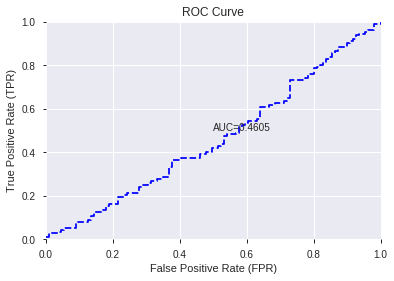

/usr/local/lib/python3.6/dist-packages/matplotlib/cbook/__init__.py:424: MatplotlibDeprecationWarning: 
Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warn_deprecated("2.2", "Passing one of 'on', 'true', 'off', 'false' as a "


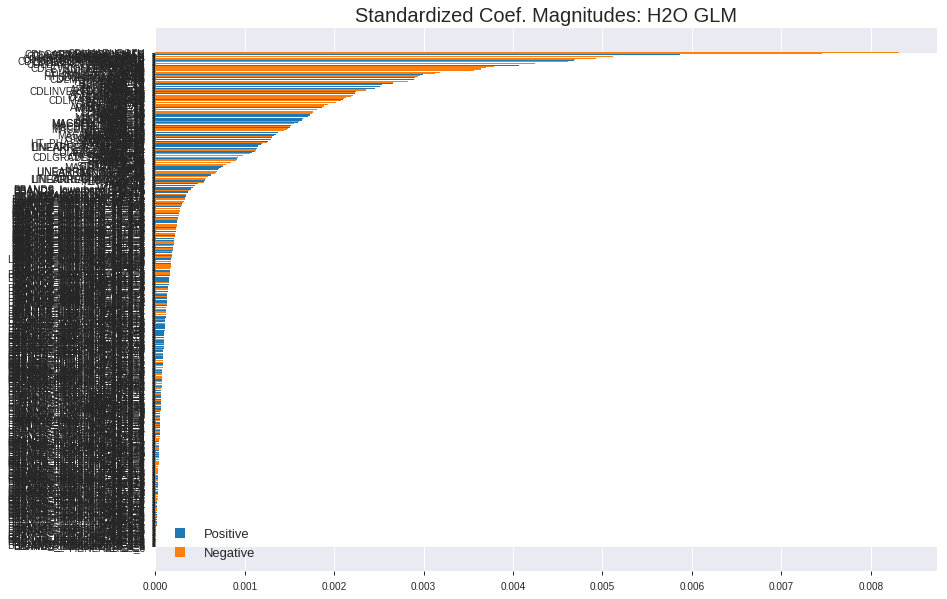

'log_likelihood'
--2019-08-27 22:30:08--  https://h2o-release.s3.amazonaws.com/h2o/rel-yates/5/h2o-3.24.0.5.zip
Resolving h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)... 52.216.200.107
Connecting to h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)|52.216.200.107|:443... connected.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.

Archive:  h2o-3.24.0.5.zip
ERROR: Unknown MOJO type


[{'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Models/GLM_grid_1_AutoML_20190827_222940_model_1',
   '__meta': {'schema_name': 'ModelKeyV3',
    'schema_type': 'Key<Model>',
    'schema_version': 3},
   'name': 'GLM_grid_1_AutoML_20190827_222940_model_1',
   'type': 'Key<Model>'},
  'default_value': None,
  'gridable': False,
  'help': 'Destination id for this model; auto-generated if not specified.',
  'is_member_of_frames': [],
  'is_mutually_exclusive_with': [],
  'label': 'model_id',
  'level': 'critical',
  'name': 'model_id',
  'required': False,
  'type': 'Key<Model>',
  'values': []},
 {'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Frames/automl_training_py_106_sid_a8e7',
   '__meta': {'schema_name': 'FrameKeyV3',
    'schema_type': 'Key<Frame>',
    'schema_version': 3},
   'name': 'automl_training_py_106

['CDLMARUBOZU',
 'CDLHANGINGMAN',
 'CDLGAPSIDESIDEWHITE',
 'CDLSEPARATINGLINES',
 'CDLRICKSHAWMAN',
 'CDLMORNINGDOJISTAR',
 'CDLBELTHOLD',
 'CDL3WHITESOLDIERS',
 'CDL3OUTSIDE',
 'CDLCLOSINGMARUBOZU',
 'CDLTAKURI',
 'CDLDRAGONFLYDOJI',
 'CDLXSIDEGAP3METHODS',
 'CDLDOJI',
 'CDLLONGLEGGEDDOJI',
 'CORREL_8',
 'DIV',
 'CDLDARKCLOUDCOVER',
 'TRANGE',
 'CORREL_12',
 'ADOSC',
 'VAR_8',
 'HT_TRENDMODE',
 'CDLEVENINGDOJISTAR',
 'CORREL_20',
 'CDLTHRUSTING',
 'DX_30',
 'BOP',
 'CDLLONGLINE',
 'DX_24',
 'DX_20',
 'CDLSHOOTINGSTAR',
 'ADX_20',
 'SUB',
 'CDL3LINESTRIKE',
 'HT_PHASOR_inphase',
 'ADX_24',
 'PLUS_DM_8',
 'CDLHIKKAKEMOD',
 'CORREL_30',
 'aroondown_30',
 'CDLMORNINGSTAR',
 'HT_DCPERIOD',
 'aroondown_20',
 'CCI_8',
 'ADX_14',
 'ADXR_14',
 'ADX_12',
 'aroondown_14',
 'DX_14',
 'MOM_14',
 'ROCP_14',
 'ROCR_14',
 'ROCR100_14',
 'AROONOSC_14',
 'ROC_14',
 'MFI_20',
 'PLUS_DM_12',
 'NATR_8',
 'CDLINVERTEDHAMMER',
 'CDLHAMMER',
 'ROC_20',
 'AROONOSC_30',
 'ROCP_20',
 'ROCR_20',
 'ROCR100_20',
 

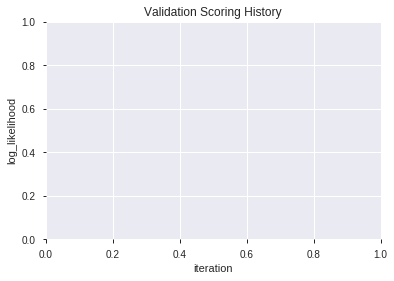

In [53]:
# GLM with recursive feature elimination with cross validation
model_train(feature_name='RFE',model_algo="GLM",features_list=features_list)

AutoML progress: |████████████████████████████████████████████████████████| 100%


model_id       auc   logloss  mean_per_class_error      rmse       mse
0               XGBoost_1_AutoML_20190827_223013  0.576174  0.694059              0.495455  0.500182  0.250182
1  XGBoost_grid_1_AutoML_20190827_223013_model_3  0.566281  0.686426              0.436575  0.496630  0.246641
2               XGBoost_3_AutoML_20190827_223013  0.557030  0.687121              0.490991  0.497038  0.247047
3               XGBoost_2_AutoML_20190827_223013  0.553571  0.690466              0.472852  0.498643  0.248645
4  XGBoost_grid_1_AutoML_20190827_223013_model_6  0.550515  0.690273              0.459339  0.498587  0.248589
5  XGBoost_grid_1_AutoML_20190827_223013_model_5  0.545367  0.705462              0.486406  0.505124  0.255150
6  XGBoost_grid_1_AutoML_20190827_223013_model_4  0.541667  0.690319              0.481861  0.498600  0.248602
7  XGBoost_grid_1_AutoML_20190827_223013_model_2  0.532819  0.693051              0.490991  0.499952  0.249952
8  XGBoost_grid_1_AutoML_20190827_223013_model_1  0.524614  0.708840              0.495455  0.507429  0.257484
9  XGBoost_grid_1_AutoML_20190827_223013_model_7  0.511583  0.706279              0.500000  0.506052  0.256089

variable  relative_importance  scaled_importance  percentage
0                        BOP           207.571854           1.000000    0.025978
1          HT_PHASOR_inphase           152.315903           0.733798    0.019062
2                    BETA_12           111.431206           0.536832    0.013946
3                    BETA_20           109.344238           0.526778    0.013685
4                      CCI_8           105.439423           0.507966    0.013196
..                       ...                  ...                ...         ...
318                   RSI_24             0.617116           0.002973    0.000077
319  BBANDS_lowerband_14_7_5             0.583617           0.002812    0.000073
320                   T3_8_8             0.447422           0.002156    0.000056
321  BBANDS_upperband_20_5_5             0.349417           0.001683    0.000044
322  BBANDS_lowerband_12_2_2             0.320777           0.001545    0.000040

[323 rows x 4 columns]

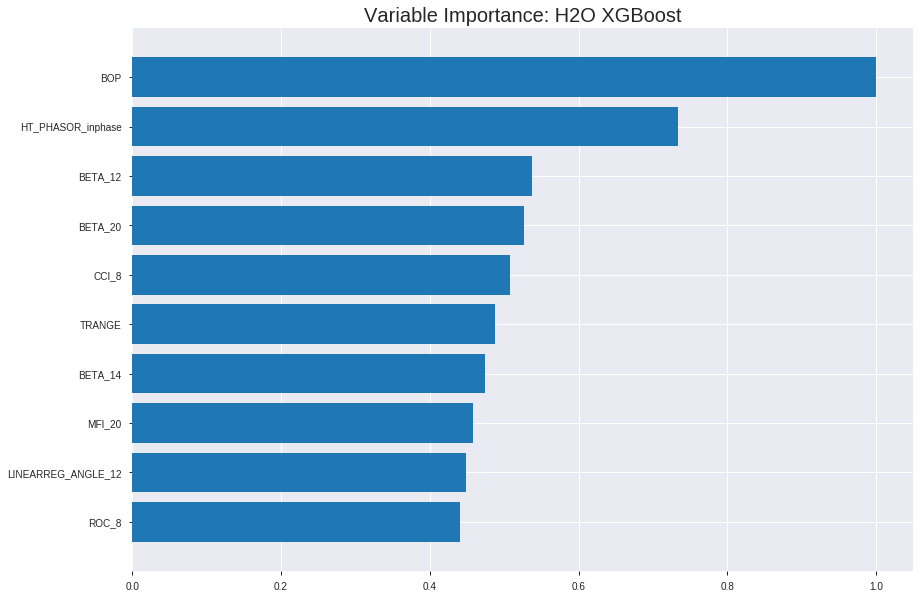

Model Details
H2OXGBoostEstimator :  XGBoost
Model Key:  XGBoost_1_AutoML_20190827_223013


ModelMetricsBinomial: xgboost
** Reported on train data. **

MSE: 0.1393924131274493
RMSE: 0.37335293373355094
LogLoss: 0.46104869990380726
Mean Per-Class Error: 0.06473942240349362
AUC: 0.9827124788860051
pr_auc: 0.9805901956884937
Gini: 0.9654249577720102
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.48711390793323517: 


0    1    Error    Rate
-----  ---  ---  -------  --------------
0      719  64   0.0817   (64.0/783.0)
1      37   738  0.0477   (37.0/775.0)
Total  756  802  0.0648   (101.0/1558.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.487114     0.935954  205
max f2                       0.453839     0.950164  225
max f0point5                 0.535726     0.949475  174
max accuracy                 0.487114     0.935173  205
max precision                0.838516     1         0
max recall                   0.351345     1         293
max specificity              0.838516     1         0
max absolute_mcc             0.487114     0.870889  205
max min_per_class_accuracy   0.494946     0.92848   200
max mean_per_class_accuracy  0.487114     0.935261  205

Gains/Lift Table: Avg response rate: 49.74 %, avg score: 49.71 %



group    cumulative_data_fraction    lower_threshold    lift       cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  ---------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0102696                   0.786091           2.01032    2.01032            1                0.804987  1                           0.804987            0.0206452       0.0206452                  101.032   101.032
    2        0.0205392                   0.773648           2.01032    2.01032            1                0.779198  1                           0.792092            0.0206452       0.0412903                  101.032   101.032
    3        0.0301669                   0.761284           2.01032    2.01032            1                0.769028  1                           0.784731            0.0193548       0.0606452                  101.032   101.032
    4        0.0404365                   0.750503           2.01032    2.01032            1                0.755601  1                           0.777333            0.0206452       0.0812903                  101.032   101.032
    5        0.0500642                   0.74174            2.01032    2.01032            1                0.745243  1                           0.771162            0.0193548       0.100645                   101.032   101.032
    6        0.100128                    0.710507           2.01032    2.01032            1                0.725519  1                           0.748341            0.100645        0.20129                    101.032   101.032
    7        0.150193                    0.684621           1.98455    2.00173            0.987179         0.698709  0.995726                    0.731797            0.0993548       0.300645                   98.4549   100.173
    8        0.200257                    0.658899           2.01032    2.00388            1                0.672691  0.996795                    0.717021            0.100645        0.40129                    101.032   100.388
    9        0.300385                    0.620289           1.99744    2.00173            0.99359          0.640703  0.995726                    0.691581            0.2             0.60129                    99.7436   100.173
    10       0.399872                    0.567328           1.88062    1.9716             0.935484         0.592879  0.980738                    0.667024            0.187097        0.788387                   88.0624   97.16
    11       0.5                         0.493371           1.44331    1.86581            0.717949         0.529596  0.928113                    0.639504            0.144516        0.932903                   44.3309   86.5806
    12       0.600128                    0.431359           0.515467   1.64051            0.25641          0.460591  0.816043                    0.609653            0.0516129       0.984516                   -48.4533  64.0509
    13       0.699615                    0.380963           0.103759   1.42198            0.0516129        0.405986  0.707339                    0.580691            0.0103226       0.994839                   -89.6241  42.198
    14       0.799743                    0.327776           0.0515467  1.2504             0.025641         0.354009  0.62199                     0.55231             0.00516129      1                          -94.8453  25.0401
    15       0.899872                    0.28461            0          1.11127            0                0.307196  0.552782                    0.525037            0               1                          -100      11.127
    16       1                           0.15688            0          1                  0                0.246314  0.497433                    0.4



ModelMetricsBinomial: xgboost
** Reported on validation data. **

MSE: 0.2706085239892137
RMSE: 0.5202004651951146
LogLoss: 0.736616105052204
Mean Per-Class Error: 0.4946324599708879
AUC: 0.45117661329451725
pr_auc: 0.4807186730762412
Gini: -0.0976467734109655
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.23989702761173248: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      1    215  0.9954   (215.0/216.0)
1      0    229  0        (0.0/229.0)
Total  1    444  0.4831   (215.0/445.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.239897     0.680535  398
max f2                       0.239897     0.841912  398
max f0point5                 0.239897     0.571072  398
max accuracy                 0.239897     0.516854  398
max precision                0.656746     0.6       9
max recall                   0.239897     1         398
max specificity              0.71511      0.99537   0
max absolute_mcc             0.53934      0.11546   78
max min_per_class_accuracy   0.446619     0.471616  195
max mean_per_class_accuracy  0.615682     0.505368  19

Gains/Lift Table: Avg response rate: 51.46 %, avg score: 45.46 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.011236                    0.670919           0.777293  0.777293           0.4              0.693228  0.4                         0.693228            0.00873362      0.00873362                 -22.2707  -22.2707
    2        0.0202247                   0.656903           1.45742   1.07957            0.75             0.665776  0.555556                    0.681027            0.0131004       0.0218341                  45.7424   7.9573
    3        0.0314607                   0.630811           0.777293  0.971616           0.4              0.642882  0.5                         0.667404            0.00873362      0.0305677                  -22.2707  -2.83843
    4        0.0404494                   0.622676           1.45742   1.07957            0.75             0.628204  0.555556                    0.658693            0.0131004       0.0436681                  45.7424   7.9573
    5        0.0516854                   0.614627           1.16594   1.09835            0.6              0.617128  0.565217                    0.649657            0.0131004       0.0567686                  16.5939   9.83482
    6        0.101124                    0.578103           0.70663   0.906841           0.363636         0.594842  0.466667                    0.622859            0.0349345       0.0917031                  -29.337   -9.31587
    7        0.150562                    0.558926           0.618301  0.812097           0.318182         0.569133  0.41791                     0.605217            0.0305677       0.122271                   -38.1699  -18.7903
    8        0.2                         0.539551           0.70663   0.786026           0.363636         0.550677  0.404494                    0.591735            0.0349345       0.157205                   -29.337   -21.3974
    9        0.301124                    0.50677            1.07957   0.884605           0.555556         0.521232  0.455224                    0.568059            0.10917         0.266376                   7.9573    -11.5395
    10       0.4                         0.479403           0.971616  0.906114           0.5              0.493039  0.466292                    0.549515            0.0960699       0.362445                   -2.83843  -9.38865
    11       0.501124                    0.446382           1.07957   0.941117           0.555556         0.464046  0.484305                    0.532268            0.10917         0.471616                   7.9573    -5.88834
    12       0.6                         0.425067           1.14827   0.975255           0.590909         0.435445  0.501873                    0.516312            0.113537        0.585153                   14.8273   -2.47453
    13       0.698876                    0.400214           0.927451  0.968492           0.477273         0.414176  0.498392                    0.501862            0.0917031       0.676856                   -7.25486  -3.15084
    14       0.8                         0.366077           0.906841  0.960699           0.466667         0.384615  0.494382                    0.487041            0.0917031       0.768559                   -9.31587  -3.93013
    15       0.898876                    0.338023           1.05994   0.971616           0.545455         0.35296   0.5                         0.472292            0.104803        0.873362                   5.99444   -2.83843
    16       1                           0.237125           1.2523    1                  0.644444         0.29691   0.514607                    0.45455


Scoring History: 


timestamp            duration    number_of_trees    training_rmse    training_logloss    training_auc    training_pr_auc    training_lift    training_classification_error    validation_rmse    validation_logloss    validation_auc    validation_pr_auc    validation_lift    validation_classification_error
--  -------------------  ----------  -----------------  ---------------  ------------------  --------------  -----------------  ---------------  -------------------------------  -----------------  --------------------  ----------------  -------------------  -----------------  ---------------------------------
    2019-08-27 22:30:14  0.009 sec   0                  0.5              0.693147            0.5             0                  1                0.502567                         0.5                0.693147              0.5               0                    1                  0.485393
    2019-08-27 22:30:15  1.033 sec   5                  0.48209          0.657854            0.829399        0.833008           2.01032          0.267651                         0.501244           0.695654              0.496472          0.500318             0.777293           0.485393
    2019-08-27 22:30:15  1.268 sec   10                 0.466152         0.627214            0.885719        0.886245           2.01032          0.206675                         0.503407           0.70004               0.474052          0.491434             0.388646           0.485393
    2019-08-27 22:30:15  1.486 sec   15                 0.451996         0.600624            0.921346        0.922486           2.01032          0.165597                         0.505297           0.703912              0.47206           0.493502             1.16594            0.483146
    2019-08-27 22:30:15  1.711 sec   20                 0.43805          0.574871            0.939973        0.941843           2.01032          0.130295                         0.508199           0.70993               0.459567          0.495685             1.16594            0.483146
    2019-08-27 22:30:16  1.957 sec   25                 0.424733         0.550708            0.954017        0.955902           2.01032          0.117458                         0.511741           0.717439              0.449499          0.490191             1.16594            0.483146
    2019-08-27 22:30:16  2.264 sec   30                 0.411873         0.527758            0.964681        0.965886           2.01032          0.0969191                        0.51416            0.722717              0.445688          0.485188             1.16594            0.485393
    2019-08-27 22:30:16  2.501 sec   35                 0.400679         0.508051            0.971808        0.972388           2.01032          0.0924262                        0.514812           0.724233              0.454725          0.485325             1.16594            0.480899
    2019-08-27 22:30:16  2.710 sec   40                 0.391378         0.491737            0.975952        0.97573            2.01032          0.0795892                        0.515581           0.726086              0.457434          0.488145             1.16594            0.483146
    2019-08-27 22:30:17  2.921 sec   45                 0.383139         0.47756             0.978972        0.977404           2.01032          0.0776637                        0.518508           0.732641              0.453239          0.480598             0.777293           0.485393
    2019-08-27 22:30:17  3.151 sec   50                 0.373353         0.461049            0.982712        0.98059            2.01032          0.0648267                        0.5202             0.736616              0.451177          0.480719             0.777293           0.483146

Variable Importances: 


variable                 relative_importance    scaled_importance      percentage
-----------------------  ---------------------  ---------------------  ---------------------
BOP                      207.5718536376953      1.0                    0.025977756042098753
HT_PHASOR_inphase        152.31590270996094     0.7337984415546992     0.019062436898780236
BETA_12                  111.43120574951172     0.5368319634703868     0.013945689782634578
BETA_20                  109.34423828125        0.5267777705165366     0.013684504410879272
CCI_8                    105.43942260742188     0.5079658959516751     0.013195814122738734
---                      ---                    ---                    ---
RSI_24                   0.6171159744262695     0.0029730233825603822  7.723247613960884e-05
BBANDS_lowerband_14_7_5  0.5836174488067627     0.002811640588927983   7.3040113297234e-05
T3_8_8                   0.4474220275878906     0.0021555043217412317  5.599516541788325e-05
BBANDS_upperband_20_5_5  0.34941673278808594    0.0016833531457399453  4.372973735273181e-05
BBANDS_lowerband_12_2_2  0.32077741622924805    0.0015453801207033903  4.01455077679418e-05


See the whole table with table.as_data_frame()


/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:7116: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


('accuracy', 0.5964125560538116)

('F1', 0.6686746987951807)

('auc', 0.5761743886743887)

('logloss', 0.6940587374233972)

('mean_per_class_error', 0.4040781853281853)

('rmse', 0.5001818194048832)

('mse', 0.25018185246317914)

xgboost prediction progress: |████████████████████████████████████████████| 100%


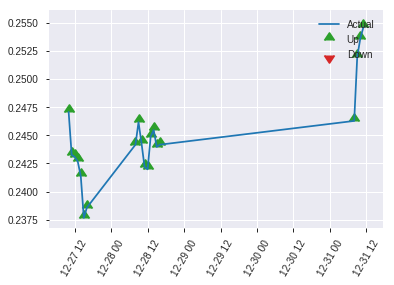


ModelMetricsBinomial: xgboost
** Reported on test data. **

MSE: 0.25018185246317914
RMSE: 0.5001818194048832
LogLoss: 0.6940587374233972
Mean Per-Class Error: 0.4040781853281853
AUC: 0.5761743886743887
pr_auc: 0.5415922248565485
Gini: 0.1523487773487775
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.2786993980407715: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      2    109  0.982    (109.0/111.0)
1      1    111  0.0089   (1.0/112.0)
Total  3    220  0.4933   (110.0/223.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.278699     0.668675  219
max f2                       0.226142     0.834575  222
max f0point5                 0.41509      0.60241   137
max accuracy                 0.417358     0.596413  135
max precision                0.652868     1         0
max recall                   0.226142     1         222
max specificity              0.652868     1         0
max absolute_mcc             0.41509      0.197418  137
max min_per_class_accuracy   0.445561     0.558559  111
max mean_per_class_accuracy  0.417358     0.595922  135

Gains/Lift Table: Avg response rate: 50.22 %, avg score: 44.59 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain       cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  ---------  -----------------
    1        0.0134529                   0.613885           1.32738   1.32738            0.666667         0.634698  0.666667                    0.634698            0.0178571       0.0178571                  32.7381    32.7381
    2        0.0224215                   0.599291           0.995536  1.19464            0.5              0.605015  0.6                         0.622825            0.00892857      0.0267857                  -0.446429  19.4643
    3        0.0313901                   0.588405           0.995536  1.13776            0.5              0.592617  0.571429                    0.614194            0.00892857      0.0357143                  -0.446429  13.7755
    4        0.0403587                   0.577643           0.995536  1.10615            0.5              0.58536   0.555556                    0.607786            0.00892857      0.0446429                  -0.446429  10.6151
    5        0.0538117                   0.570702           0         0.829613           0                0.57397   0.416667                    0.599332            0               0.0446429                  -100       -17.0387
    6        0.103139                    0.549129           1.26705   1.03882            0.636364         0.559688  0.521739                    0.580372            0.0625          0.107143                   26.7045    3.88199
    7        0.152466                    0.535236           0.905032  0.995536           0.454545         0.54142   0.5                         0.56777             0.0446429       0.151786                   -9.49675   -0.446429
    8        0.201794                    0.513198           1.44805   1.10615            0.727273         0.52111   0.555556                    0.556364            0.0714286       0.223214                   44.8052    10.6151
    9        0.300448                    0.495339           0.995536  1.06983            0.5              0.504732  0.537313                    0.53941             0.0982143       0.321429                   -0.446429  6.98294
    10       0.399103                    0.467447           1.53856   1.18569            0.772727         0.483187  0.595506                    0.525512            0.151786        0.473214                   53.8555    18.5694
    11       0.502242                    0.445561           0.865683  1.11998            0.434783         0.458402  0.5625                      0.511731            0.0892857       0.5625                     -13.4317   11.9978
    12       0.600897                    0.418459           1.26705   1.14412            0.636364         0.430534  0.574627                    0.4984              0.125           0.6875                     26.7045    14.4123
    13       0.699552                    0.398826           0.724026  1.08488            0.363636         0.408551  0.544872                    0.485729            0.0714286       0.758929                   -27.5974   8.48787
    14       0.798206                    0.373646           0.905032  1.06265            0.454545         0.388058  0.533708                    0.473657            0.0892857       0.848214                   -9.49675   6.26505
    15       0.896861                    0.343553           0.814529  1.03536            0.409091         0.360234  0.52                        0.461181            0.0803571       0.928571                   -18.5471   3.53571
    16       1                           0.226142           0.692547  1                  0.347826         0.312673  0.502242                 

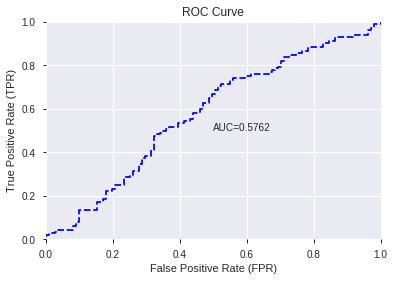

This function is available for GLM models only


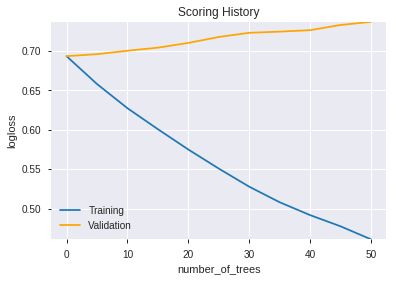

--2019-08-27 22:30:56--  https://h2o-release.s3.amazonaws.com/h2o/rel-yates/5/h2o-3.24.0.5.zip
Resolving h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)... 52.216.207.131
Connecting to h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)|52.216.207.131|:443... connected.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.

Archive:  h2o-3.24.0.5.zip
Exception in thread "main" java.lang.StackOverflowError
	at java.base/java.lang.String.substring(String.java:1874)
	at java.base/java.lang.String.split(String.java:2289)
	at java.base/java.lang.String.split(String.java:2364)
	at hex.genmodel.algos.xgboost.XGBoostMojoModel.constructSubgraph(XGBoostMojoModel.java:101)
	at hex.genmodel.algos.xgboost.XGBoostMojoModel.constructSubgraph(XGBoostMojoModel.java:106)
	at hex.genmodel.algos.xgboost.XGBoostMojoModel.constructSubgraph(XGBoostMojoModel.java:106)
	at hex.genmodel.algos.xgboost.XGBoostMojoMo

[{'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Models/XGBoost_1_AutoML_20190827_223013',
   '__meta': {'schema_name': 'ModelKeyV3',
    'schema_type': 'Key<Model>',
    'schema_version': 3},
   'name': 'XGBoost_1_AutoML_20190827_223013',
   'type': 'Key<Model>'},
  'default_value': None,
  'gridable': False,
  'help': 'Destination id for this model; auto-generated if not specified.',
  'is_member_of_frames': [],
  'is_mutually_exclusive_with': [],
  'label': 'model_id',
  'level': 'critical',
  'name': 'model_id',
  'required': False,
  'type': 'Key<Model>',
  'values': []},
 {'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Frames/automl_training_py_114_sid_a8e7',
   '__meta': {'schema_name': 'FrameKeyV3',
    'schema_type': 'Key<Frame>',
    'schema_version': 3},
   'name': 'automl_training_py_114_sid_a8e7',
   'ty

['BOP',
 'HT_PHASOR_inphase',
 'BETA_12',
 'BETA_20',
 'CCI_8',
 'TRANGE',
 'BETA_14',
 'MFI_20',
 'LINEARREG_ANGLE_12',
 'ROC_8',
 'STDDEV_8',
 'HT_DCPERIOD',
 'ADOSC',
 'STOCH_slowk',
 'WILLR_14',
 'STOCHRSI_fastd',
 'ADX_8',
 'MFI_14',
 'HT_PHASOR_quadrature',
 'ADXR_14',
 'MOM_8',
 'CORREL_30',
 'STDDEV_24',
 'DIV',
 'ADX_14',
 'BETA_30',
 'MOM_20',
 'MFI_30',
 'BETA_24',
 'STOCHF_fastk',
 'WILLR_12',
 'LINEARREG_ANGLE_8',
 'PLUS_DM_20',
 'MFI_8',
 'WILLR_8',
 'ULTOSC',
 'ATR_8',
 'OBV',
 'STOCHF_fastd',
 'NATR_20',
 'MACDFIX_hist_8',
 'CORREL_24',
 'DX_12',
 'STDDEV_20',
 'PLUS_DM_8',
 'LINEARREG_ANGLE_14',
 'ROC_14',
 'BETA_8',
 'ROC_24',
 'AROONOSC_20',
 'STOCH_slowd',
 'PLUS_DM_12',
 'TRIX_8',
 'CORREL_20',
 'WILLR_24',
 'STOCHRSI_fastk',
 'ADX_20',
 'MFI_12',
 'DX_14',
 'ATR_24',
 'CCI_12',
 'DX_24',
 'APO',
 'ADX_24',
 'MINUS_DM_8',
 'STDDEV_12',
 'MACDFIX_signal_24',
 'CCI_30',
 'NATR_12',
 'ROC_20',
 'AROONOSC_14',
 'SUB',
 'CMO_8',
 'ROC_12',
 'ATR_20',
 'DX_20',
 'CORREL_

In [54]:
# XGBoost with recursive feature elimination with cross validation
model_train(feature_name='RFE',model_algo="XGBoost",features_list=features_list)

In [55]:
# Experiment Summary
pd.set_option('precision', 3) 

for k in models_summary:
  print(k)
  display(models_summary[k].max())
  print('\n'*3)
  display(models_summary[k].groupby(models_summary[k].index).max())
  print('\n'*3)
  
display(models_summary)

pd.set_option('precision', 6) 

accuracy


DeepLearning    0.596
GLM             0.552
XGBoost         0.596
dtype: float64

DeepLearning    GLM  XGBoost
All          0.578  0.507    0.583
DLF          0.587  0.552    0.561
Fwe          0.570  0.507    0.583
RFE          0.570  0.507    0.596
XGBF         0.596  0.552    0.561





F1


DeepLearning    0.671
GLM             0.675
XGBoost         0.671
dtype: float64

DeepLearning    GLM  XGBoost
All          0.671  0.669    0.669
DLF          0.671  0.675    0.671
Fwe          0.671  0.669    0.669
RFE          0.669  0.669    0.669
XGBF         0.671  0.675    0.671





auc


DeepLearning    0.586
GLM             0.533
XGBoost         0.581
dtype: float64

DeepLearning    GLM  XGBoost
All          0.584  0.464    0.581
DLF          0.586  0.533    0.557
Fwe          0.552  0.464    0.581
RFE          0.531  0.461    0.576
XGBF         0.575  0.533    0.557





logloss


DeepLearning    0.771
GLM             0.696
XGBoost         0.694
dtype: float64

DeepLearning    GLM  XGBoost
All          0.704  0.696    0.685
DLF          0.694  0.692    0.686
Fwe          0.727  0.696    0.685
RFE          0.771  0.696    0.694
XGBF         0.715  0.692    0.686





mean_per_class_error


DeepLearning    0.431
GLM             0.491
XGBoost         0.439
dtype: float64

DeepLearning    GLM  XGBoost
All          0.422  0.491    0.416
DLF          0.412  0.449    0.439
Fwe          0.431  0.491    0.416
RFE          0.429  0.491    0.404
XGBF         0.403  0.449    0.439





rmse


DeepLearning    0.532
GLM             0.502
XGBoost         0.500
dtype: float64

DeepLearning    GLM  XGBoost
All          0.503  0.501    0.496
DLF          0.500  0.499    0.497
Fwe          0.515  0.501    0.496
RFE          0.532  0.502    0.500
XGBF         0.508  0.499    0.497





mse


DeepLearning    0.283
GLM             0.252
XGBoost         0.250
dtype: float64

DeepLearning    GLM  XGBoost
All          0.253  0.251    0.246
DLF          0.250  0.249    0.247
Fwe          0.265  0.251    0.246
RFE          0.283  0.252    0.250
XGBF         0.258  0.249    0.247

{'F1':       DeepLearning    GLM  XGBoost
 All          0.671    NaN      NaN
 DLF          0.671    NaN      NaN
 DLF            NaN  0.675      NaN
 DLF            NaN    NaN    0.671
 All            NaN  0.669      NaN
 All            NaN    NaN    0.669
 XGBF         0.671    NaN      NaN
 XGBF           NaN  0.675      NaN
 XGBF           NaN    NaN    0.671
 Fwe          0.671    NaN      NaN
 Fwe            NaN  0.669      NaN
 Fwe            NaN    NaN    0.669
 RFE          0.669    NaN      NaN
 RFE            NaN  0.669      NaN
 RFE            NaN    NaN    0.669,
 'accuracy':       DeepLearning    GLM  XGBoost
 All          0.578    NaN      NaN
 DLF          0.587    NaN      NaN
 DLF            NaN  0.552      NaN
 DLF            NaN    NaN    0.561
 All            NaN  0.507      NaN
 All            NaN    NaN    0.583
 XGBF         0.596    NaN      NaN
 XGBF           NaN  0.552      NaN
 XGBF           NaN    NaN    0.561
 Fwe          0.570    NaN      NaN
 Fwe     